In [4]:
import librosa
import os
import numpy as np

from dtw import dtw
from numpy.linalg import norm
from numpy import array
import pyaudio
import wave

import heapq

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [23]:
def initialCorpus(path):
    # 音乐库位置
    audioList = os.listdir(path)

    raw_audioList = {}
    beat_database = {}

    for tmp in audioList:
        audioName = os.path.join(path, tmp)
        if audioName.endswith('.wav'):
            # 读入一维音频序列
            y, sr = librosa.load(audioName)
            # 提取 MFCC 特征
            f = librosa.feature.mfcc(y=y, sr=sr)
            # 存入数据表
            beat_database[audioName] = f

    # 保存音乐节奏数据库
    np.save('beatDatabase_mfcc.npy', beat_database)
    
    return beat_database

In [6]:
def readCorpus(path):
    
    # 读入音乐节奏数据库
    all_data = np.load(path, allow_pickle=True)
    beat_database = all_data.item()
    
    return beat_database

In [24]:
def updateCorpus(path, dbpath):
    
    # 音乐库位置
    audioList = os.listdir(path)
    
    # 已保存序列的文件
    raw_db = readCorpus(dbPath)
    raw_files = raw_db.keys()
    
    for tmp in audioList:
        audioName = os.path.join(path, tmp)
        if audioName.endswith('.wav') and audioName not in raw_files:
            y, sr = librosa.load(audioName)
            # 提取 MFCC 特征
            f = librosa.feature.mfcc(y=y, sr=sr)
            # 存入数据表
            beat_database[audioName] = f

    # 保存音乐节奏数据库
    np.save(dbpath, beat_database)

In [8]:
def voiceCompare_quick(dbPath, tPath):
    
    # 读入语料库
    all_data = np.load(dbPath, allow_pickle=True)
    beat_database = all_data.item()

    # 读入要识别的录音
    y, sr = librosa.load(tPath)

    # 识别录音的节奏序列
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_frames = librosa.feature.delta(beat_frames,mode ='nearest')
    x = array(beat_frames).reshape(-1, 1)

    # 将待识别的录音序列与语料库中语音逐一做DTW对比
    compare_result = {}
    
    for songID in beat_database.keys():
        y = beat_database[songID]
        y = array(y).reshape(-1, 1)
        
        dist = dtw(x, y).distance
        # print('两段话的差异程度为： ', songID.split("\\")[1], ": ", dist)
        
        compare_result[songID] = dist

    matched_song = min(compare_result, key=compare_result.get)
    print("最接近的录音是：", matched_song)

In [69]:
from sklearn import preprocessing

def voiceCompare(dbPath, tPath):
    
    # 读入语料库
    all_data = np.load(dbPath, allow_pickle=True)
    beat_database = all_data.item()

    # 读入要识别的录音
    y, sr = librosa.load(tPath)

    # 提取录音的 MFCC 特征
    x = librosa.feature.mfcc(y=y, sr=sr).T  # n1 * 20
    lenx = len(x)

    # 将待识别的录音序列与语料库中语音逐一做DTW对比
    # compare_result = {}
    heap = []
    heapq.heapify(heap)  # 栈 for [dist, 时间段，文件名]
    
    for songID in beat_database.keys():
        
        y = beat_database[songID].T
        leny = len(y)  # n2 * 20
        print(leny)
        
        for tp in range(0, leny - lenx):
            # 计算 DTW(y[tp : tp + lenx])
            total_dist = 0
            for i in range(0, lenx):
                p1 = preprocessing.minmax_scale(x[i])
                p2 = preprocessing.minmax_scale(y[tp + i])
                total_dist += dtw(p1, p2, distance_only=False).distance
            
            # 入栈
            tupleY = (total_dist, tp, songID)
            heapq.heappush(heap, tupleY)
            print(tupleY)
            
            #if (songID == './corpus\\00415250.wav'):
            #   print(dist, tp)
            #   print(sliY)
        
        # dist = dtw(x, y).distance
        # print('两段话的差异程度为： ', songID.split("\\")[1], ": ", dist)
        
        # compare_result[songID] = dist

    #  matched_song = min(compare_result, key=compare_result.get)
    # print("最接近的录音是：", matched_song)
    return heap

In [70]:
# 语料库路径
corpus_path = './corpus'

# 数据表路径
dbPath = './beatDatabase_mfcc.npy';

In [71]:
# 初始化语料序列库
# beatDB = initialCorpus(corpus_path)

# 更新语料库中新音乐文件的序列
# updateCorpus(corpus_path, dbPath)

# 读入语料序列库
# beat_database = readCorpus(dbPath)

# 识别输入录音

# test file path
testPath = './input/end_of_time_slice.wav'

vheap = voiceCompare(dbPath, testPath)

3876
(34.23995789885521, 0, './corpus\\00415250.wav')
(117.02482533454895, 1, './corpus\\00415250.wav')
(211.9939416050911, 2, './corpus\\00415250.wav')
(294.9919925928116, 3, './corpus\\00415250.wav')
(363.4599016010761, 4, './corpus\\00415250.wav')
(414.0971767902374, 5, './corpus\\00415250.wav')
(459.0182718038559, 6, './corpus\\00415250.wav')
(494.5255655348301, 7, './corpus\\00415250.wav')
(511.31404918432236, 8, './corpus\\00415250.wav')
(528.6797177791595, 9, './corpus\\00415250.wav')
(558.552105486393, 10, './corpus\\00415250.wav')
(583.2704781889915, 11, './corpus\\00415250.wav')
(597.8346497416496, 12, './corpus\\00415250.wav')
(609.1897319555283, 13, './corpus\\00415250.wav')
(616.122367978096, 14, './corpus\\00415250.wav')
(627.14919090271, 15, './corpus\\00415250.wav')
(638.9081397950649, 16, './corpus\\00415250.wav')
(647.0699375867844, 17, './corpus\\00415250.wav')
(666.5173467993736, 18, './corpus\\00415250.wav')
(688.8564739525318, 19, './corpus\\00415250.wav')
(701.52

(779.8765150904655, 163, './corpus\\00415250.wav')
(784.3909851312637, 164, './corpus\\00415250.wav')
(786.9110336601734, 165, './corpus\\00415250.wav')
(791.8790335655212, 166, './corpus\\00415250.wav')
(795.056953638792, 167, './corpus\\00415250.wav')
(794.1061447262764, 168, './corpus\\00415250.wav')
(791.5748206079006, 169, './corpus\\00415250.wav')
(787.6319316625595, 170, './corpus\\00415250.wav')
(782.8201687932014, 171, './corpus\\00415250.wav')
(783.3360750675201, 172, './corpus\\00415250.wav')
(789.6397425532341, 173, './corpus\\00415250.wav')
(797.9990462064743, 174, './corpus\\00415250.wav')
(807.9942467212677, 175, './corpus\\00415250.wav')
(816.9547183811665, 176, './corpus\\00415250.wav')
(821.7032268941402, 177, './corpus\\00415250.wav')
(827.3097456097603, 178, './corpus\\00415250.wav')
(832.3107512891293, 179, './corpus\\00415250.wav')
(823.4177383184433, 180, './corpus\\00415250.wav')
(810.552794277668, 181, './corpus\\00415250.wav')
(799.0682189166546, 182, './corpu

(522.4158392250538, 325, './corpus\\00415250.wav')
(529.1673223376274, 326, './corpus\\00415250.wav')
(541.6164898872375, 327, './corpus\\00415250.wav')
(552.0838724970818, 328, './corpus\\00415250.wav')
(561.7845310866833, 329, './corpus\\00415250.wav')
(557.618672311306, 330, './corpus\\00415250.wav')
(558.6337532997131, 331, './corpus\\00415250.wav')
(566.4936333596706, 332, './corpus\\00415250.wav')
(580.1262691617012, 333, './corpus\\00415250.wav')
(583.6498784422874, 334, './corpus\\00415250.wav')
(583.7067564725876, 335, './corpus\\00415250.wav')
(581.7807928919792, 336, './corpus\\00415250.wav')
(578.277971804142, 337, './corpus\\00415250.wav')
(573.9110713601112, 338, './corpus\\00415250.wav')
(574.3734980225563, 339, './corpus\\00415250.wav')
(580.4302489757538, 340, './corpus\\00415250.wav')
(595.1830088794231, 341, './corpus\\00415250.wav')
(618.6064032614231, 342, './corpus\\00415250.wav')
(639.3387086689472, 343, './corpus\\00415250.wav')
(651.9147858917713, 344, './corpu

(855.7749828398228, 487, './corpus\\00415250.wav')
(850.8878490626812, 488, './corpus\\00415250.wav')
(845.5368535220623, 489, './corpus\\00415250.wav')
(841.5010966956615, 490, './corpus\\00415250.wav')
(839.7159083485603, 491, './corpus\\00415250.wav')
(833.4556027650833, 492, './corpus\\00415250.wav')
(824.7486849427223, 493, './corpus\\00415250.wav')
(817.7413962185383, 494, './corpus\\00415250.wav')
(810.8085858821869, 495, './corpus\\00415250.wav')
(803.6423457860947, 496, './corpus\\00415250.wav')
(794.8931188881397, 497, './corpus\\00415250.wav')
(783.0695151984692, 498, './corpus\\00415250.wav')
(770.2692776322365, 499, './corpus\\00415250.wav')
(759.7610915899277, 500, './corpus\\00415250.wav')
(751.6002463698387, 501, './corpus\\00415250.wav')
(746.5801472365856, 502, './corpus\\00415250.wav')
(740.1240958273411, 503, './corpus\\00415250.wav')
(732.9475737214088, 504, './corpus\\00415250.wav')
(726.7029626071453, 505, './corpus\\00415250.wav')
(721.6831598579884, 506, './cor

(579.5292037725449, 649, './corpus\\00415250.wav')
(573.1301171779633, 650, './corpus\\00415250.wav')
(578.5682452321053, 651, './corpus\\00415250.wav')
(587.934260725975, 652, './corpus\\00415250.wav')
(591.7407048940659, 653, './corpus\\00415250.wav')
(596.9087489843369, 654, './corpus\\00415250.wav')
(615.0158451795578, 655, './corpus\\00415250.wav')
(634.8337308168411, 656, './corpus\\00415250.wav')
(643.6860663890839, 657, './corpus\\00415250.wav')
(638.7650701105595, 658, './corpus\\00415250.wav')
(629.7423170506954, 659, './corpus\\00415250.wav')
(625.2660395205021, 660, './corpus\\00415250.wav')
(619.2087664604187, 661, './corpus\\00415250.wav')
(617.8216538131237, 662, './corpus\\00415250.wav')
(617.6369355916977, 663, './corpus\\00415250.wav')
(624.4577351212502, 664, './corpus\\00415250.wav')
(649.1161046922207, 665, './corpus\\00415250.wav')
(667.5858718156815, 666, './corpus\\00415250.wav')
(683.3049598634243, 667, './corpus\\00415250.wav')
(694.5057511031628, 668, './corp

(1147.705329835415, 811, './corpus\\00415250.wav')
(1156.9480600953102, 812, './corpus\\00415250.wav')
(1164.1745035350323, 813, './corpus\\00415250.wav')
(1165.1169375777245, 814, './corpus\\00415250.wav')
(1163.9557031393051, 815, './corpus\\00415250.wav')
(1163.7017953693867, 816, './corpus\\00415250.wav')
(1168.1173024475574, 817, './corpus\\00415250.wav')
(1176.991365879774, 818, './corpus\\00415250.wav')
(1191.1058197915554, 819, './corpus\\00415250.wav')
(1209.6095474362373, 820, './corpus\\00415250.wav')
(1228.0343844294548, 821, './corpus\\00415250.wav')
(1242.3603925406933, 822, './corpus\\00415250.wav')
(1254.9336954653263, 823, './corpus\\00415250.wav')
(1263.16814661026, 824, './corpus\\00415250.wav')
(1267.7792001366615, 825, './corpus\\00415250.wav')
(1265.645724773407, 826, './corpus\\00415250.wav')
(1260.5645360350609, 827, './corpus\\00415250.wav')
(1252.6295484304428, 828, './corpus\\00415250.wav')
(1242.3892531394958, 829, './corpus\\00415250.wav')
(1230.74080526828

(554.9503026008606, 973, './corpus\\00415250.wav')
(541.0841653347015, 974, './corpus\\00415250.wav')
(555.746283531189, 975, './corpus\\00415250.wav')
(580.5393077433109, 976, './corpus\\00415250.wav')
(602.3630118370056, 977, './corpus\\00415250.wav')
(617.473899781704, 978, './corpus\\00415250.wav')
(623.7222935557365, 979, './corpus\\00415250.wav')
(624.3187024593353, 980, './corpus\\00415250.wav')
(612.9180068969727, 981, './corpus\\00415250.wav')
(597.8459610939026, 982, './corpus\\00415250.wav')
(584.7503337264061, 983, './corpus\\00415250.wav')
(580.3313934206963, 984, './corpus\\00415250.wav')
(583.4774603843689, 985, './corpus\\00415250.wav')
(581.0451067686081, 986, './corpus\\00415250.wav')
(575.7549624443054, 987, './corpus\\00415250.wav')
(567.7949084937572, 988, './corpus\\00415250.wav')
(552.6302154362202, 989, './corpus\\00415250.wav')
(533.4504430294037, 990, './corpus\\00415250.wav')
(532.1379106640816, 991, './corpus\\00415250.wav')
(544.1484263539314, 992, './corpu

(611.3121142089367, 1133, './corpus\\00415250.wav')
(601.6579840779305, 1134, './corpus\\00415250.wav')
(594.2423587143421, 1135, './corpus\\00415250.wav')
(582.9503401815891, 1136, './corpus\\00415250.wav')
(572.2160165607929, 1137, './corpus\\00415250.wav')
(561.7252916097641, 1138, './corpus\\00415250.wav')
(547.8552587628365, 1139, './corpus\\00415250.wav')
(536.2242913842201, 1140, './corpus\\00415250.wav')
(534.5278197228909, 1141, './corpus\\00415250.wav')
(545.3261789083481, 1142, './corpus\\00415250.wav')
(559.298914283514, 1143, './corpus\\00415250.wav')
(570.0888694524765, 1144, './corpus\\00415250.wav')
(574.8486896157265, 1145, './corpus\\00415250.wav')
(574.9433282911777, 1146, './corpus\\00415250.wav')
(574.9681869149208, 1147, './corpus\\00415250.wav')
(572.2356250882149, 1148, './corpus\\00415250.wav')
(563.703715801239, 1149, './corpus\\00415250.wav')
(557.3012173473835, 1150, './corpus\\00415250.wav')
(554.9713868796825, 1151, './corpus\\00415250.wav')
(554.025619357

(703.1014594435692, 1291, './corpus\\00415250.wav')
(704.7921058833599, 1292, './corpus\\00415250.wav')
(709.3859247863293, 1293, './corpus\\00415250.wav')
(714.2413519918919, 1294, './corpus\\00415250.wav')
(719.0117032527924, 1295, './corpus\\00415250.wav')
(723.6930304169655, 1296, './corpus\\00415250.wav')
(726.8027883768082, 1297, './corpus\\00415250.wav')
(725.2156455516815, 1298, './corpus\\00415250.wav')
(716.6786024272442, 1299, './corpus\\00415250.wav')
(705.5458408892155, 1300, './corpus\\00415250.wav')
(694.8926753997803, 1301, './corpus\\00415250.wav')
(689.481021374464, 1302, './corpus\\00415250.wav')
(685.778914898634, 1303, './corpus\\00415250.wav')
(678.7352171838284, 1304, './corpus\\00415250.wav')
(672.5222527384758, 1305, './corpus\\00415250.wav')
(664.1039438247681, 1306, './corpus\\00415250.wav')
(650.0603174865246, 1307, './corpus\\00415250.wav')
(638.0637625157833, 1308, './corpus\\00415250.wav')
(629.2357102930546, 1309, './corpus\\00415250.wav')
(622.720061659

(1095.1241719722748, 1449, './corpus\\00415250.wav')
(1089.6828457415104, 1450, './corpus\\00415250.wav')
(1080.7978325784206, 1451, './corpus\\00415250.wav')
(1073.0911508500576, 1452, './corpus\\00415250.wav')
(1068.2840269505978, 1453, './corpus\\00415250.wav')
(1064.9078644514084, 1454, './corpus\\00415250.wav')
(1060.8821674883366, 1455, './corpus\\00415250.wav')
(1060.8744146227837, 1456, './corpus\\00415250.wav')
(1067.9200440049171, 1457, './corpus\\00415250.wav')
(1074.692641466856, 1458, './corpus\\00415250.wav')
(1084.1260632276535, 1459, './corpus\\00415250.wav')
(1096.2505714297295, 1460, './corpus\\00415250.wav')
(1104.8530815839767, 1461, './corpus\\00415250.wav')
(1114.7778640687466, 1462, './corpus\\00415250.wav')
(1120.5645427405834, 1463, './corpus\\00415250.wav')
(1134.3768779039383, 1464, './corpus\\00415250.wav')
(1150.2978328168392, 1465, './corpus\\00415250.wav')
(1167.2088959515095, 1466, './corpus\\00415250.wav')
(1180.244826644659, 1467, './corpus\\00415250.w

(925.6141114234924, 1607, './corpus\\00415250.wav')
(920.7417927980423, 1608, './corpus\\00415250.wav')
(913.5500935018063, 1609, './corpus\\00415250.wav')
(907.7897461950779, 1610, './corpus\\00415250.wav')
(902.9121880233288, 1611, './corpus\\00415250.wav')
(898.2339353859425, 1612, './corpus\\00415250.wav')
(892.1252162754536, 1613, './corpus\\00415250.wav')
(885.2462971806526, 1614, './corpus\\00415250.wav')
(878.0517643988132, 1615, './corpus\\00415250.wav')
(871.4463387429714, 1616, './corpus\\00415250.wav')
(865.3893998265266, 1617, './corpus\\00415250.wav')
(857.9832543432713, 1618, './corpus\\00415250.wav')
(850.0678877532482, 1619, './corpus\\00415250.wav')
(842.1590135395527, 1620, './corpus\\00415250.wav')
(834.9660731852055, 1621, './corpus\\00415250.wav')
(829.4610868990421, 1622, './corpus\\00415250.wav')
(827.0734618008137, 1623, './corpus\\00415250.wav')
(825.1679582297802, 1624, './corpus\\00415250.wav')
(823.7081992328167, 1625, './corpus\\00415250.wav')
(822.5529305

(535.5352196991444, 1765, './corpus\\00415250.wav')
(537.462290585041, 1766, './corpus\\00415250.wav')
(544.9548483490944, 1767, './corpus\\00415250.wav')
(559.4971178174019, 1768, './corpus\\00415250.wav')
(570.2282258272171, 1769, './corpus\\00415250.wav')
(576.8552062213421, 1770, './corpus\\00415250.wav')
(578.5618278682232, 1771, './corpus\\00415250.wav')
(581.0274187326431, 1772, './corpus\\00415250.wav')
(586.6621373593807, 1773, './corpus\\00415250.wav')
(595.655713558197, 1774, './corpus\\00415250.wav')
(610.0060768723488, 1775, './corpus\\00415250.wav')
(620.910886913538, 1776, './corpus\\00415250.wav')
(622.2814972102642, 1777, './corpus\\00415250.wav')
(618.3127111792564, 1778, './corpus\\00415250.wav')
(609.8973157405853, 1779, './corpus\\00415250.wav')
(607.5705843865871, 1780, './corpus\\00415250.wav')
(610.2091257870197, 1781, './corpus\\00415250.wav')
(613.9782598018646, 1782, './corpus\\00415250.wav')
(621.4308811724186, 1783, './corpus\\00415250.wav')
(630.4642136991

(1065.0385056138039, 1923, './corpus\\00415250.wav')
(1078.3558621108532, 1924, './corpus\\00415250.wav')
(1086.5781953632832, 1925, './corpus\\00415250.wav')
(1091.5588110089302, 1926, './corpus\\00415250.wav')
(1099.6800751388073, 1927, './corpus\\00415250.wav')
(1105.8161211311817, 1928, './corpus\\00415250.wav')
(1107.9621378779411, 1929, './corpus\\00415250.wav')
(1106.79870352149, 1930, './corpus\\00415250.wav')
(1105.4532940089703, 1931, './corpus\\00415250.wav')
(1105.598426580429, 1932, './corpus\\00415250.wav')
(1103.993971824646, 1933, './corpus\\00415250.wav')
(1104.8228164613247, 1934, './corpus\\00415250.wav')
(1102.5074319839478, 1935, './corpus\\00415250.wav')
(1106.763596713543, 1936, './corpus\\00415250.wav')
(1116.480909228325, 1937, './corpus\\00415250.wav')
(1124.699844032526, 1938, './corpus\\00415250.wav')
(1133.062570810318, 1939, './corpus\\00415250.wav')
(1139.916617512703, 1940, './corpus\\00415250.wav')
(1148.5817773342133, 1941, './corpus\\00415250.wav')
(1

(907.5651481747627, 2081, './corpus\\00415250.wav')
(914.1721466481686, 2082, './corpus\\00415250.wav')
(905.1694555878639, 2083, './corpus\\00415250.wav')
(882.7321607172489, 2084, './corpus\\00415250.wav')
(863.978224337101, 2085, './corpus\\00415250.wav')
(849.9240578711033, 2086, './corpus\\00415250.wav')
(833.3021485209465, 2087, './corpus\\00415250.wav')
(812.8250150084496, 2088, './corpus\\00415250.wav')
(790.2199187576771, 2089, './corpus\\00415250.wav')
(772.1578646302223, 2090, './corpus\\00415250.wav')
(755.3410591483116, 2091, './corpus\\00415250.wav')
(732.143411308527, 2092, './corpus\\00415250.wav')
(715.9923885166645, 2093, './corpus\\00415250.wav')
(709.9508484899998, 2094, './corpus\\00415250.wav')
(718.3043987452984, 2095, './corpus\\00415250.wav')
(732.5450878441334, 2096, './corpus\\00415250.wav')
(745.8784969449043, 2097, './corpus\\00415250.wav')
(758.5452620983124, 2098, './corpus\\00415250.wav')
(768.9507831931114, 2099, './corpus\\00415250.wav')
(772.986270844

(1114.881675183773, 2239, './corpus\\00415250.wav')
(1116.6162760853767, 2240, './corpus\\00415250.wav')
(1112.8408643305302, 2241, './corpus\\00415250.wav')
(1107.6646111905575, 2242, './corpus\\00415250.wav')
(1100.5503234863281, 2243, './corpus\\00415250.wav')
(1093.7461315989494, 2244, './corpus\\00415250.wav')
(1086.980738133192, 2245, './corpus\\00415250.wav')
(1079.6259007453918, 2246, './corpus\\00415250.wav')
(1073.1483716070652, 2247, './corpus\\00415250.wav')
(1073.7420012950897, 2248, './corpus\\00415250.wav')
(1076.698742032051, 2249, './corpus\\00415250.wav')
(1084.8535235524178, 2250, './corpus\\00415250.wav')
(1094.3471268713474, 2251, './corpus\\00415250.wav')
(1098.162991553545, 2252, './corpus\\00415250.wav')
(1094.1236587762833, 2253, './corpus\\00415250.wav')
(1080.733687222004, 2254, './corpus\\00415250.wav')
(1065.3988170325756, 2255, './corpus\\00415250.wav')
(1053.0377308428288, 2256, './corpus\\00415250.wav')
(1041.4938090741634, 2257, './corpus\\00415250.wav'

(806.0066040754318, 2397, './corpus\\00415250.wav')
(806.1629882752895, 2398, './corpus\\00415250.wav')
(792.3364916741848, 2399, './corpus\\00415250.wav')
(782.4597385525703, 2400, './corpus\\00415250.wav')
(779.8590410649776, 2401, './corpus\\00415250.wav')
(775.6687285602093, 2402, './corpus\\00415250.wav')
(773.4846144914627, 2403, './corpus\\00415250.wav')
(769.4939225316048, 2404, './corpus\\00415250.wav')
(762.993028730154, 2405, './corpus\\00415250.wav')
(755.5821614861488, 2406, './corpus\\00415250.wav')
(747.3668478131294, 2407, './corpus\\00415250.wav')
(735.0715065002441, 2408, './corpus\\00415250.wav')
(730.4024577736855, 2409, './corpus\\00415250.wav')
(744.0834703147411, 2410, './corpus\\00415250.wav')
(761.252769947052, 2411, './corpus\\00415250.wav')
(777.5000439584255, 2412, './corpus\\00415250.wav')
(789.0018588602543, 2413, './corpus\\00415250.wav')
(792.7976593375206, 2414, './corpus\\00415250.wav')
(792.6711789667606, 2415, './corpus\\00415250.wav')
(785.733717739

(787.7072886228561, 2555, './corpus\\00415250.wav')
(784.2582942247391, 2556, './corpus\\00415250.wav')
(773.9557213783264, 2557, './corpus\\00415250.wav')
(755.1344181597233, 2558, './corpus\\00415250.wav')
(735.9885491132736, 2559, './corpus\\00415250.wav')
(724.688025355339, 2560, './corpus\\00415250.wav')
(715.6461901366711, 2561, './corpus\\00415250.wav')
(713.985896140337, 2562, './corpus\\00415250.wav')
(716.8318636715412, 2563, './corpus\\00415250.wav')
(721.1826594173908, 2564, './corpus\\00415250.wav')
(732.5164206922054, 2565, './corpus\\00415250.wav')
(734.6268946230412, 2566, './corpus\\00415250.wav')
(733.1088619530201, 2567, './corpus\\00415250.wav')
(729.8778328597546, 2568, './corpus\\00415250.wav')
(729.56215056777, 2569, './corpus\\00415250.wav')
(737.1293975114822, 2570, './corpus\\00415250.wav')
(752.1610243320465, 2571, './corpus\\00415250.wav')
(767.8343605697155, 2572, './corpus\\00415250.wav')
(778.0271172523499, 2573, './corpus\\00415250.wav')
(784.20832946896

(589.028289437294, 2713, './corpus\\00415250.wav')
(589.8772464394569, 2714, './corpus\\00415250.wav')
(591.3182495236397, 2715, './corpus\\00415250.wav')
(593.2777690887451, 2716, './corpus\\00415250.wav')
(594.0764056444168, 2717, './corpus\\00415250.wav')
(592.6337831020355, 2718, './corpus\\00415250.wav')
(593.2781882286072, 2719, './corpus\\00415250.wav')
(595.9969989061356, 2720, './corpus\\00415250.wav')
(597.3476210236549, 2721, './corpus\\00415250.wav')
(595.1475165486336, 2722, './corpus\\00415250.wav')
(588.8892518281937, 2723, './corpus\\00415250.wav')
(585.7579817175865, 2724, './corpus\\00415250.wav')
(579.7255659103394, 2725, './corpus\\00415250.wav')
(577.4685452580452, 2726, './corpus\\00415250.wav')
(571.3904953598976, 2727, './corpus\\00415250.wav')
(568.869879245758, 2728, './corpus\\00415250.wav')
(564.6970471739769, 2729, './corpus\\00415250.wav')
(559.9536365866661, 2730, './corpus\\00415250.wav')
(557.6737088561058, 2731, './corpus\\00415250.wav')
(559.346976459

(625.8778204917908, 2871, './corpus\\00415250.wav')
(610.3629063665867, 2872, './corpus\\00415250.wav')
(591.2456382215023, 2873, './corpus\\00415250.wav')
(572.8329509496689, 2874, './corpus\\00415250.wav')
(553.1784828007221, 2875, './corpus\\00415250.wav')
(544.1975972652435, 2876, './corpus\\00415250.wav')
(549.1609632670879, 2877, './corpus\\00415250.wav')
(558.5652503967285, 2878, './corpus\\00415250.wav')
(568.9203224778175, 2879, './corpus\\00415250.wav')
(578.4404129981995, 2880, './corpus\\00415250.wav')
(587.6889241039753, 2881, './corpus\\00415250.wav')
(586.8534353971481, 2882, './corpus\\00415250.wav')
(578.8980941474438, 2883, './corpus\\00415250.wav')
(563.0303862094879, 2884, './corpus\\00415250.wav')
(553.9124723374844, 2885, './corpus\\00415250.wav')
(552.0467108786106, 2886, './corpus\\00415250.wav')
(549.0726853609085, 2887, './corpus\\00415250.wav')
(543.3548505008221, 2888, './corpus\\00415250.wav')
(540.9548925459385, 2889, './corpus\\00415250.wav')
(547.4077839

(784.8125884830952, 3029, './corpus\\00415250.wav')
(784.9209600389004, 3030, './corpus\\00415250.wav')
(784.9297305643559, 3031, './corpus\\00415250.wav')
(784.6806954443455, 3032, './corpus\\00415250.wav')
(784.5205765068531, 3033, './corpus\\00415250.wav')
(784.5133137404919, 3034, './corpus\\00415250.wav')
(784.6618084609509, 3035, './corpus\\00415250.wav')
(784.915996581316, 3036, './corpus\\00415250.wav')
(784.9324289858341, 3037, './corpus\\00415250.wav')
(784.9332078397274, 3038, './corpus\\00415250.wav')
(784.9393281042576, 3039, './corpus\\00415250.wav')
(784.8157095015049, 3040, './corpus\\00415250.wav')
(780.7249014079571, 3041, './corpus\\00415250.wav')
(774.2181925475597, 3042, './corpus\\00415250.wav')
(766.8936696052551, 3043, './corpus\\00415250.wav')
(759.5719578266144, 3044, './corpus\\00415250.wav')
(752.5643866062164, 3045, './corpus\\00415250.wav')
(745.768125295639, 3046, './corpus\\00415250.wav')
(739.7690433263779, 3047, './corpus\\00415250.wav')
(732.896986097

(676.709914624691, 3187, './corpus\\00415250.wav')
(693.0268506705761, 3188, './corpus\\00415250.wav')
(702.5682196319103, 3189, './corpus\\00415250.wav')
(709.7534947395325, 3190, './corpus\\00415250.wav')
(713.8824152350426, 3191, './corpus\\00415250.wav')
(717.745071798563, 3192, './corpus\\00415250.wav')
(723.2419876158237, 3193, './corpus\\00415250.wav')
(725.608773380518, 3194, './corpus\\00415250.wav')
(724.7492909431458, 3195, './corpus\\00415250.wav')
(718.0940419733524, 3196, './corpus\\00415250.wav')
(706.9108986854553, 3197, './corpus\\00415250.wav')
(690.3711749017239, 3198, './corpus\\00415250.wav')
(675.8827805519104, 3199, './corpus\\00415250.wav')
(656.4541752338409, 3200, './corpus\\00415250.wav')
(637.6822763979435, 3201, './corpus\\00415250.wav')
(637.7990871369839, 3202, './corpus\\00415250.wav')
(645.3752864897251, 3203, './corpus\\00415250.wav')
(654.9532327353954, 3204, './corpus\\00415250.wav')
(657.304695814848, 3205, './corpus\\00415250.wav')
(653.67682963609

(840.2283483147621, 3345, './corpus\\00415250.wav')
(835.5908309221268, 3346, './corpus\\00415250.wav')
(836.2241087257862, 3347, './corpus\\00415250.wav')
(847.1836380064487, 3348, './corpus\\00415250.wav')
(864.9168440699577, 3349, './corpus\\00415250.wav')
(886.2100076973438, 3350, './corpus\\00415250.wav')
(898.0735523998737, 3351, './corpus\\00415250.wav')
(907.8756880164146, 3352, './corpus\\00415250.wav')
(918.0264022648335, 3353, './corpus\\00415250.wav')
(934.1999827623367, 3354, './corpus\\00415250.wav')
(952.5667500495911, 3355, './corpus\\00415250.wav')
(968.8055462539196, 3356, './corpus\\00415250.wav')
(986.1412074267864, 3357, './corpus\\00415250.wav')
(998.8060851693153, 3358, './corpus\\00415250.wav')
(1011.1301256120205, 3359, './corpus\\00415250.wav')
(1030.4403923749924, 3360, './corpus\\00415250.wav')
(1043.6936550736427, 3361, './corpus\\00415250.wav')
(1050.3809627592564, 3362, './corpus\\00415250.wav')
(1052.9351311326027, 3363, './corpus\\00415250.wav')
(1055.0

(755.3000162243843, 3503, './corpus\\00415250.wav')
(765.3290958702564, 3504, './corpus\\00415250.wav')
(768.1441669464111, 3505, './corpus\\00415250.wav')
(764.9401039481163, 3506, './corpus\\00415250.wav')
(757.306599020958, 3507, './corpus\\00415250.wav')
(743.7478645145893, 3508, './corpus\\00415250.wav')
(728.8194492459297, 3509, './corpus\\00415250.wav')
(707.2525069117546, 3510, './corpus\\00415250.wav')
(685.82980504632, 3511, './corpus\\00415250.wav')
(676.3524274528027, 3512, './corpus\\00415250.wav')
(677.7275108993053, 3513, './corpus\\00415250.wav')
(679.3951423764229, 3514, './corpus\\00415250.wav')
(672.0142641961575, 3515, './corpus\\00415250.wav')
(662.0609136223793, 3516, './corpus\\00415250.wav')
(652.7187477946281, 3517, './corpus\\00415250.wav')
(638.7101194262505, 3518, './corpus\\00415250.wav')
(623.5296804606915, 3519, './corpus\\00415250.wav')
(611.1241618096828, 3520, './corpus\\00415250.wav')
(601.5430340766907, 3521, './corpus\\00415250.wav')
(595.8080222606

(610.1983252763748, 1, './corpus\\00429126.wav')
(603.923141002655, 2, './corpus\\00429126.wav')
(594.3777488172054, 3, './corpus\\00429126.wav')
(584.1913921236992, 4, './corpus\\00429126.wav')
(578.7843295633793, 5, './corpus\\00429126.wav')
(575.3586094379425, 6, './corpus\\00429126.wav')
(583.6165352761745, 7, './corpus\\00429126.wav')
(593.1277536153793, 8, './corpus\\00429126.wav')
(604.6372082531452, 9, './corpus\\00429126.wav')
(611.567545413971, 10, './corpus\\00429126.wav')
(621.1312034130096, 11, './corpus\\00429126.wav')
(628.3107864260674, 12, './corpus\\00429126.wav')
(636.189636349678, 13, './corpus\\00429126.wav')
(644.9846809506416, 14, './corpus\\00429126.wav')
(649.2480651438236, 15, './corpus\\00429126.wav')
(653.8417600393295, 16, './corpus\\00429126.wav')
(661.7615435421467, 17, './corpus\\00429126.wav')
(663.5845768153667, 18, './corpus\\00429126.wav')
(657.9915836155415, 19, './corpus\\00429126.wav')
(651.770454198122, 20, './corpus\\00429126.wav')
(646.61627888

(637.5960628092289, 165, './corpus\\00429126.wav')
(642.7885414361954, 166, './corpus\\00429126.wav')
(654.4429384469986, 167, './corpus\\00429126.wav')
(661.9168339371681, 168, './corpus\\00429126.wav')
(666.4652961492538, 169, './corpus\\00429126.wav')
(663.2159885168076, 170, './corpus\\00429126.wav')
(647.7508219182491, 171, './corpus\\00429126.wav')
(641.1303817033768, 172, './corpus\\00429126.wav')
(659.6126929521561, 173, './corpus\\00429126.wav')
(686.9171240329742, 174, './corpus\\00429126.wav')
(711.4856534898281, 175, './corpus\\00429126.wav')
(735.7513343095779, 176, './corpus\\00429126.wav')
(754.96495449543, 177, './corpus\\00429126.wav')
(761.8469314575195, 178, './corpus\\00429126.wav')
(751.3952019810677, 179, './corpus\\00429126.wav')
(735.1276299059391, 180, './corpus\\00429126.wav')
(721.6762967705727, 181, './corpus\\00429126.wav')
(717.3297154605389, 182, './corpus\\00429126.wav')
(722.1973905265331, 183, './corpus\\00429126.wav')
(731.6078548431396, 184, './corpu

(944.2216863334179, 327, './corpus\\00429126.wav')
(959.5718203783035, 328, './corpus\\00429126.wav')
(968.8596794009209, 329, './corpus\\00429126.wav')
(971.8392552435398, 330, './corpus\\00429126.wav')
(972.3418210446835, 331, './corpus\\00429126.wav')
(972.8915992975235, 332, './corpus\\00429126.wav')
(981.2446333765984, 333, './corpus\\00429126.wav')
(989.3737905919552, 334, './corpus\\00429126.wav')
(992.5912655591965, 335, './corpus\\00429126.wav')
(993.5733638703823, 336, './corpus\\00429126.wav')
(996.0115878582001, 337, './corpus\\00429126.wav')
(997.0647805035114, 338, './corpus\\00429126.wav')
(993.9140385687351, 339, './corpus\\00429126.wav')
(989.117226421833, 340, './corpus\\00429126.wav')
(982.2494021356106, 341, './corpus\\00429126.wav')
(976.2246476709843, 342, './corpus\\00429126.wav')
(968.4934701621532, 343, './corpus\\00429126.wav')
(961.1942434310913, 344, './corpus\\00429126.wav')
(949.6292844116688, 345, './corpus\\00429126.wav')
(943.6867963969707, 346, './corp

(642.1483432650566, 489, './corpus\\00429126.wav')
(643.6162184476852, 490, './corpus\\00429126.wav')
(642.6121169030666, 491, './corpus\\00429126.wav')
(641.242853730917, 492, './corpus\\00429126.wav')
(646.5216977000237, 493, './corpus\\00429126.wav')
(653.4110605418682, 494, './corpus\\00429126.wav')
(662.1055108904839, 495, './corpus\\00429126.wav')
(664.0324758589268, 496, './corpus\\00429126.wav')
(656.357546120882, 497, './corpus\\00429126.wav')
(647.9176203012466, 498, './corpus\\00429126.wav')
(644.8536078035831, 499, './corpus\\00429126.wav')
(649.2822199463844, 500, './corpus\\00429126.wav')
(661.1345366835594, 501, './corpus\\00429126.wav')
(669.1221754252911, 502, './corpus\\00429126.wav')
(678.3417427241802, 503, './corpus\\00429126.wav')
(684.9770332574844, 504, './corpus\\00429126.wav')
(688.6577600538731, 505, './corpus\\00429126.wav')
(689.6510887444019, 506, './corpus\\00429126.wav')
(695.7130551934242, 507, './corpus\\00429126.wav')
(693.9098162055016, 508, './corpu

(783.5161931216717, 650, './corpus\\00429126.wav')
(786.1111363768578, 651, './corpus\\00429126.wav')
(786.566544175148, 652, './corpus\\00429126.wav')
(790.9564879238605, 653, './corpus\\00429126.wav')
(799.0864399075508, 654, './corpus\\00429126.wav')
(809.4291772842407, 655, './corpus\\00429126.wav')
(818.0351059138775, 656, './corpus\\00429126.wav')
(825.272911131382, 657, './corpus\\00429126.wav')
(835.6059311032295, 658, './corpus\\00429126.wav')
(845.8123418092728, 659, './corpus\\00429126.wav')
(854.4936797320843, 660, './corpus\\00429126.wav')
(863.3052316904068, 661, './corpus\\00429126.wav')
(866.3719778358936, 662, './corpus\\00429126.wav')
(870.5017670691013, 663, './corpus\\00429126.wav')
(875.5885484516621, 664, './corpus\\00429126.wav')
(878.1804712712765, 665, './corpus\\00429126.wav')
(880.5865496695042, 666, './corpus\\00429126.wav')
(881.3429535925388, 667, './corpus\\00429126.wav')
(881.7543092668056, 668, './corpus\\00429126.wav')
(884.1609611809254, 669, './corpu

(533.3669439852238, 812, './corpus\\00429126.wav')
(517.5787750184536, 813, './corpus\\00429126.wav')
(499.1210159957409, 814, './corpus\\00429126.wav')
(480.00481417775154, 815, './corpus\\00429126.wav')
(459.8356222510338, 816, './corpus\\00429126.wav')
(447.4932138621807, 817, './corpus\\00429126.wav')
(444.60133308172226, 818, './corpus\\00429126.wav')
(439.4649859070778, 819, './corpus\\00429126.wav')
(450.7663669884205, 820, './corpus\\00429126.wav')
(475.89756178855896, 821, './corpus\\00429126.wav')
(501.4610462784767, 822, './corpus\\00429126.wav')
(511.9672273993492, 823, './corpus\\00429126.wav')
(519.713320761919, 824, './corpus\\00429126.wav')
(526.7582522928715, 825, './corpus\\00429126.wav')
(538.1019974350929, 826, './corpus\\00429126.wav')
(545.6821218729019, 827, './corpus\\00429126.wav')
(552.6813225746155, 828, './corpus\\00429126.wav')
(564.8263612985611, 829, './corpus\\00429126.wav')
(575.4914149940014, 830, './corpus\\00429126.wav')
(579.3651687204838, 831, './c

(1093.7636839151382, 974, './corpus\\00429126.wav')
(1100.750400006771, 975, './corpus\\00429126.wav')
(1106.9270694851875, 976, './corpus\\00429126.wav')
(1109.5492414832115, 977, './corpus\\00429126.wav')
(1108.162553280592, 978, './corpus\\00429126.wav')
(1104.0142591297626, 979, './corpus\\00429126.wav')
(1095.1626673936844, 980, './corpus\\00429126.wav')
(1085.3160658180714, 981, './corpus\\00429126.wav')
(1076.3545916080475, 982, './corpus\\00429126.wav')
(1073.705803513527, 983, './corpus\\00429126.wav')
(1072.6060172915459, 984, './corpus\\00429126.wav')
(1069.1202051341534, 985, './corpus\\00429126.wav')
(1060.0457923710346, 986, './corpus\\00429126.wav')
(1047.930764168501, 987, './corpus\\00429126.wav')
(1039.9035226404667, 988, './corpus\\00429126.wav')
(1034.419479072094, 989, './corpus\\00429126.wav')
(1028.4219454526901, 990, './corpus\\00429126.wav')
(1022.8598811924458, 991, './corpus\\00429126.wav')
(1020.1054394543171, 992, './corpus\\00429126.wav')
(1021.57142546772

(669.1847351491451, 1132, './corpus\\00429126.wav')
(690.9710246324539, 1133, './corpus\\00429126.wav')
(711.7779722511768, 1134, './corpus\\00429126.wav')
(728.0390490293503, 1135, './corpus\\00429126.wav')
(742.9020198881626, 1136, './corpus\\00429126.wav')
(750.0231567919254, 1137, './corpus\\00429126.wav')
(748.4194917678833, 1138, './corpus\\00429126.wav')
(739.3910106122494, 1139, './corpus\\00429126.wav')
(726.2196975946426, 1140, './corpus\\00429126.wav')
(701.8098284900188, 1141, './corpus\\00429126.wav')
(671.5993897020817, 1142, './corpus\\00429126.wav')
(630.9526557922363, 1143, './corpus\\00429126.wav')
(589.5832625031471, 1144, './corpus\\00429126.wav')
(550.5076424181461, 1145, './corpus\\00429126.wav')
(501.0918947458267, 1146, './corpus\\00429126.wav')
(463.93805465102196, 1147, './corpus\\00429126.wav')
(451.3549414277077, 1148, './corpus\\00429126.wav')
(448.9613901376724, 1149, './corpus\\00429126.wav')
(452.91627728939056, 1150, './corpus\\00429126.wav')
(458.88321

(929.8865991830826, 1290, './corpus\\00429126.wav')
(943.2344556450844, 1291, './corpus\\00429126.wav')
(951.801894068718, 1292, './corpus\\00429126.wav')
(962.1596007943153, 1293, './corpus\\00429126.wav')
(964.7479474246502, 1294, './corpus\\00429126.wav')
(963.9175553619862, 1295, './corpus\\00429126.wav')
(960.8938042521477, 1296, './corpus\\00429126.wav')
(953.9328932762146, 1297, './corpus\\00429126.wav')
(946.8480163812637, 1298, './corpus\\00429126.wav')
(945.939844250679, 1299, './corpus\\00429126.wav')
(943.5096586048603, 1300, './corpus\\00429126.wav')
(937.1852488517761, 1301, './corpus\\00429126.wav')
(928.7545050084591, 1302, './corpus\\00429126.wav')
(924.6185703873634, 1303, './corpus\\00429126.wav')
(925.7448381781578, 1304, './corpus\\00429126.wav')
(921.7914063334465, 1305, './corpus\\00429126.wav')
(911.2945535778999, 1306, './corpus\\00429126.wav')
(903.0534579157829, 1307, './corpus\\00429126.wav')
(901.4799576699734, 1308, './corpus\\00429126.wav')
(900.756582200

(957.7276877164841, 1448, './corpus\\00429126.wav')
(936.6489042043686, 1449, './corpus\\00429126.wav')
(917.5394653081894, 1450, './corpus\\00429126.wav')
(901.8512521386147, 1451, './corpus\\00429126.wav')
(886.2139589488506, 1452, './corpus\\00429126.wav')
(888.8670452237129, 1453, './corpus\\00429126.wav')
(895.793594956398, 1454, './corpus\\00429126.wav')
(893.920813947916, 1455, './corpus\\00429126.wav')
(883.0116617381573, 1456, './corpus\\00429126.wav')
(868.7192738354206, 1457, './corpus\\00429126.wav')
(860.0078365802765, 1458, './corpus\\00429126.wav')
(847.7754991650581, 1459, './corpus\\00429126.wav')
(839.0816695988178, 1460, './corpus\\00429126.wav')
(831.556717813015, 1461, './corpus\\00429126.wav')
(832.7332674264908, 1462, './corpus\\00429126.wav')
(847.3740904033184, 1463, './corpus\\00429126.wav')
(859.2510434687138, 1464, './corpus\\00429126.wav')
(863.3465577661991, 1465, './corpus\\00429126.wav')
(858.2233076691628, 1466, './corpus\\00429126.wav')
(854.8823280334

(816.3433094620705, 1606, './corpus\\00429126.wav')
(806.9667347967625, 1607, './corpus\\00429126.wav')
(798.1761143505573, 1608, './corpus\\00429126.wav')
(789.0841903686523, 1609, './corpus\\00429126.wav')
(779.1717361211777, 1610, './corpus\\00429126.wav')
(768.4783032238483, 1611, './corpus\\00429126.wav')
(758.6829444468021, 1612, './corpus\\00429126.wav')
(751.0569334626198, 1613, './corpus\\00429126.wav')
(748.9958398044109, 1614, './corpus\\00429126.wav')
(744.5629774332047, 1615, './corpus\\00429126.wav')
(739.881672590971, 1616, './corpus\\00429126.wav')
(735.0082386136055, 1617, './corpus\\00429126.wav')
(725.3536120355129, 1618, './corpus\\00429126.wav')
(715.8243974149227, 1619, './corpus\\00429126.wav')
(705.8264873027802, 1620, './corpus\\00429126.wav')
(712.939535588026, 1621, './corpus\\00429126.wav')
(726.7208113670349, 1622, './corpus\\00429126.wav')
(738.7499934732914, 1623, './corpus\\00429126.wav')
(753.3279642164707, 1624, './corpus\\00429126.wav')
(766.918365865

(670.2959022521973, 1764, './corpus\\00429126.wav')
(685.439145565033, 1765, './corpus\\00429126.wav')
(701.5699534118176, 1766, './corpus\\00429126.wav')
(714.9669519066811, 1767, './corpus\\00429126.wav')
(725.1614513397217, 1768, './corpus\\00429126.wav')
(735.3811095058918, 1769, './corpus\\00429126.wav')
(748.5921978354454, 1770, './corpus\\00429126.wav')
(757.0995772480965, 1771, './corpus\\00429126.wav')
(763.4267798066139, 1772, './corpus\\00429126.wav')
(769.1879558265209, 1773, './corpus\\00429126.wav')
(775.8710052967072, 1774, './corpus\\00429126.wav')
(781.5620115399361, 1775, './corpus\\00429126.wav')
(791.2618181705475, 1776, './corpus\\00429126.wav')
(804.0441146492958, 1777, './corpus\\00429126.wav')
(808.7128613591194, 1778, './corpus\\00429126.wav')
(812.8463449776173, 1779, './corpus\\00429126.wav')
(809.3560060858727, 1780, './corpus\\00429126.wav')
(810.2944087386131, 1781, './corpus\\00429126.wav')
(815.631171643734, 1782, './corpus\\00429126.wav')
(824.392486661

(1043.6010862886906, 1922, './corpus\\00429126.wav')
(1037.7397415339947, 1923, './corpus\\00429126.wav')
(1037.3875841796398, 1924, './corpus\\00429126.wav')
(1045.108210504055, 1925, './corpus\\00429126.wav')
(1053.6123750507832, 1926, './corpus\\00429126.wav')
(1053.5488299429417, 1927, './corpus\\00429126.wav')
(1041.715765208006, 1928, './corpus\\00429126.wav')
(1021.8815650641918, 1929, './corpus\\00429126.wav')
(994.051870405674, 1930, './corpus\\00429126.wav')
(960.721501916647, 1931, './corpus\\00429126.wav')
(937.4147676229477, 1932, './corpus\\00429126.wav')
(925.3320479094982, 1933, './corpus\\00429126.wav')
(919.117725789547, 1934, './corpus\\00429126.wav')
(912.6797467470169, 1935, './corpus\\00429126.wav')
(906.1527839899063, 1936, './corpus\\00429126.wav')
(900.1497204601765, 1937, './corpus\\00429126.wav')
(893.485610306263, 1938, './corpus\\00429126.wav')
(881.8638058900833, 1939, './corpus\\00429126.wav')
(871.8382520675659, 1940, './corpus\\00429126.wav')
(861.87856

(772.3961474895477, 2080, './corpus\\00429126.wav')
(760.7871569693089, 2081, './corpus\\00429126.wav')
(743.9507467746735, 2082, './corpus\\00429126.wav')
(725.9840552210808, 2083, './corpus\\00429126.wav')
(709.9329078495502, 2084, './corpus\\00429126.wav')
(694.8333857059479, 2085, './corpus\\00429126.wav')
(678.0758529305458, 2086, './corpus\\00429126.wav')
(664.2286248803139, 2087, './corpus\\00429126.wav')
(650.9116953909397, 2088, './corpus\\00429126.wav')
(637.5610226988792, 2089, './corpus\\00429126.wav')
(622.5265607237816, 2090, './corpus\\00429126.wav')
(605.1840807199478, 2091, './corpus\\00429126.wav')
(606.3068605363369, 2092, './corpus\\00429126.wav')
(611.8051899671555, 2093, './corpus\\00429126.wav')
(614.5751184523106, 2094, './corpus\\00429126.wav')
(616.7349838018417, 2095, './corpus\\00429126.wav')
(619.033308416605, 2096, './corpus\\00429126.wav')
(620.8718719780445, 2097, './corpus\\00429126.wav')
(622.8598459362984, 2098, './corpus\\00429126.wav')
(634.38962402

(784.8021174967289, 2238, './corpus\\00429126.wav')
(793.7655020654202, 2239, './corpus\\00429126.wav')
(811.2447048425674, 2240, './corpus\\00429126.wav')
(829.26914280653, 2241, './corpus\\00429126.wav')
(832.8559094071388, 2242, './corpus\\00429126.wav')
(838.4844000041485, 2243, './corpus\\00429126.wav')
(849.4122443497181, 2244, './corpus\\00429126.wav')
(866.2971217036247, 2245, './corpus\\00429126.wav')
(875.2608725726604, 2246, './corpus\\00429126.wav')
(870.3672405779362, 2247, './corpus\\00429126.wav')
(855.0714486241341, 2248, './corpus\\00429126.wav')
(843.0127190351486, 2249, './corpus\\00429126.wav')
(848.7349739968777, 2250, './corpus\\00429126.wav')
(866.4217852950096, 2251, './corpus\\00429126.wav')
(881.2418732941151, 2252, './corpus\\00429126.wav')
(892.0423887372017, 2253, './corpus\\00429126.wav')
(912.6310782432556, 2254, './corpus\\00429126.wav')
(931.9537126421928, 2255, './corpus\\00429126.wav')
(935.4894655048847, 2256, './corpus\\00429126.wav')
(924.455545425

(931.5887272357941, 2396, './corpus\\00429126.wav')
(943.9564840197563, 2397, './corpus\\00429126.wav')
(951.3973504304886, 2398, './corpus\\00429126.wav')
(954.0212747454643, 2399, './corpus\\00429126.wav')
(948.4045905470848, 2400, './corpus\\00429126.wav')
(942.9411355555058, 2401, './corpus\\00429126.wav')
(933.5215122401714, 2402, './corpus\\00429126.wav')
(921.9502238035202, 2403, './corpus\\00429126.wav')
(910.9921281933784, 2404, './corpus\\00429126.wav')
(902.8458654284477, 2405, './corpus\\00429126.wav')
(900.8284867405891, 2406, './corpus\\00429126.wav')
(904.3601818084717, 2407, './corpus\\00429126.wav')
(906.3882237970829, 2408, './corpus\\00429126.wav')
(907.5024952590466, 2409, './corpus\\00429126.wav')
(902.0960921347141, 2410, './corpus\\00429126.wav')
(895.206579387188, 2411, './corpus\\00429126.wav')
(889.1832499206066, 2412, './corpus\\00429126.wav')
(882.1604374945164, 2413, './corpus\\00429126.wav')
(876.873045027256, 2414, './corpus\\00429126.wav')
(873.899557620

(561.8080582022667, 2554, './corpus\\00429126.wav')
(557.3795144557953, 2555, './corpus\\00429126.wav')
(554.8280984163284, 2556, './corpus\\00429126.wav')
(552.7740263342857, 2557, './corpus\\00429126.wav')
(551.728483080864, 2558, './corpus\\00429126.wav')
(550.879133105278, 2559, './corpus\\00429126.wav')
(550.2797282934189, 2560, './corpus\\00429126.wav')
(553.0302469134331, 2561, './corpus\\00429126.wav')
(555.171594709158, 2562, './corpus\\00429126.wav')
(558.6566541194916, 2563, './corpus\\00429126.wav')
(559.8730183839798, 2564, './corpus\\00429126.wav')
(558.8387414813042, 2565, './corpus\\00429126.wav')
(556.2414699196815, 2566, './corpus\\00429126.wav')
(551.5960886478424, 2567, './corpus\\00429126.wav')
(545.4458637237549, 2568, './corpus\\00429126.wav')
(543.2350541353226, 2569, './corpus\\00429126.wav')
(545.7537747621536, 2570, './corpus\\00429126.wav')
(551.5777813792229, 2571, './corpus\\00429126.wav')
(556.4793865084648, 2572, './corpus\\00429126.wav')
(560.0034335851

(718.6106488704681, 2712, './corpus\\00429126.wav')
(705.8604595959187, 2713, './corpus\\00429126.wav')
(700.8103056848049, 2714, './corpus\\00429126.wav')
(694.0032196938992, 2715, './corpus\\00429126.wav')
(689.9952294230461, 2716, './corpus\\00429126.wav')
(684.2419501841068, 2717, './corpus\\00429126.wav')
(679.3802013397217, 2718, './corpus\\00429126.wav')
(681.8131664395332, 2719, './corpus\\00429126.wav')
(688.5098783969879, 2720, './corpus\\00429126.wav')
(686.0109075307846, 2721, './corpus\\00429126.wav')
(680.5436000227928, 2722, './corpus\\00429126.wav')
(674.5322849750519, 2723, './corpus\\00429126.wav')
(669.8623252809048, 2724, './corpus\\00429126.wav')
(667.4799258708954, 2725, './corpus\\00429126.wav')
(657.429026812315, 2726, './corpus\\00429126.wav')
(637.6345151364803, 2727, './corpus\\00429126.wav')
(627.5963545441628, 2728, './corpus\\00429126.wav')
(617.3877685964108, 2729, './corpus\\00429126.wav')
(603.7154281139374, 2730, './corpus\\00429126.wav')
(590.25877267

(790.109585493803, 2870, './corpus\\00429126.wav')
(803.4249768853188, 2871, './corpus\\00429126.wav')
(820.655223608017, 2872, './corpus\\00429126.wav')
(836.6016453504562, 2873, './corpus\\00429126.wav')
(847.7879253327847, 2874, './corpus\\00429126.wav')
(852.5049895942211, 2875, './corpus\\00429126.wav')
(852.8547846972942, 2876, './corpus\\00429126.wav')
(853.6233067214489, 2877, './corpus\\00429126.wav')
(859.4866850972176, 2878, './corpus\\00429126.wav')
(872.5752501189709, 2879, './corpus\\00429126.wav')
(898.3940805494785, 2880, './corpus\\00429126.wav')
(927.2015643417835, 2881, './corpus\\00429126.wav')
(951.3973609209061, 2882, './corpus\\00429126.wav')
(969.876629114151, 2883, './corpus\\00429126.wav')
(986.4039160311222, 2884, './corpus\\00429126.wav')
(1000.4120041429996, 2885, './corpus\\00429126.wav')
(1012.5948670208454, 2886, './corpus\\00429126.wav')
(1023.2432759702206, 2887, './corpus\\00429126.wav')
(1035.703095316887, 2888, './corpus\\00429126.wav')
(1048.127455

(949.9816553592682, 3028, './corpus\\00429126.wav')
(948.7486127614975, 3029, './corpus\\00429126.wav')
(950.2530350387096, 3030, './corpus\\00429126.wav')
(949.9860559403896, 3031, './corpus\\00429126.wav')
(944.0208932459354, 3032, './corpus\\00429126.wav')
(936.0968792438507, 3033, './corpus\\00429126.wav')
(930.8659104704857, 3034, './corpus\\00429126.wav')
(932.4317996799946, 3035, './corpus\\00429126.wav')
(931.2278318703175, 3036, './corpus\\00429126.wav')
(925.414021641016, 3037, './corpus\\00429126.wav')
(914.2039670050144, 3038, './corpus\\00429126.wav')
(899.2261588275433, 3039, './corpus\\00429126.wav')
(882.3199248611927, 3040, './corpus\\00429126.wav')
(866.5551607310772, 3041, './corpus\\00429126.wav')
(851.9701518118382, 3042, './corpus\\00429126.wav')
(836.399874061346, 3043, './corpus\\00429126.wav')
(814.5205258727074, 3044, './corpus\\00429126.wav')
(787.2281866371632, 3045, './corpus\\00429126.wav')
(763.7309882044792, 3046, './corpus\\00429126.wav')
(746.017940312

(668.7652412652969, 3186, './corpus\\00429126.wav')
(656.9747125506401, 3187, './corpus\\00429126.wav')
(648.7885434627533, 3188, './corpus\\00429126.wav')
(644.6260527074337, 3189, './corpus\\00429126.wav')
(640.7377602756023, 3190, './corpus\\00429126.wav')
(631.6385839879513, 3191, './corpus\\00429126.wav')
(616.8583361804485, 3192, './corpus\\00429126.wav')
(604.5114673674107, 3193, './corpus\\00429126.wav')
(595.8659854829311, 3194, './corpus\\00429126.wav')
(589.8282862603664, 3195, './corpus\\00429126.wav')
(582.7384203374386, 3196, './corpus\\00429126.wav')
(577.2403400540352, 3197, './corpus\\00429126.wav')
(569.6530508995056, 3198, './corpus\\00429126.wav')
(558.3950884342194, 3199, './corpus\\00429126.wav')
(545.6421767175198, 3200, './corpus\\00429126.wav')
(532.9037936031818, 3201, './corpus\\00429126.wav')
(519.9803490936756, 3202, './corpus\\00429126.wav')
(508.4232120811939, 3203, './corpus\\00429126.wav')
(495.2745512723923, 3204, './corpus\\00429126.wav')
(481.3607902

(679.6839198768139, 3344, './corpus\\00429126.wav')
(685.8298392891884, 3345, './corpus\\00429126.wav')
(691.9777213931084, 3346, './corpus\\00429126.wav')
(699.1055634915829, 3347, './corpus\\00429126.wav')
(706.1043974459171, 3348, './corpus\\00429126.wav')
(708.8633268773556, 3349, './corpus\\00429126.wav')
(711.6186781227589, 3350, './corpus\\00429126.wav')
(712.3352883756161, 3351, './corpus\\00429126.wav')
(713.1013379395008, 3352, './corpus\\00429126.wav')
(709.6682621538639, 3353, './corpus\\00429126.wav')
(704.3718532025814, 3354, './corpus\\00429126.wav')
(698.7800976336002, 3355, './corpus\\00429126.wav')
(690.0991599261761, 3356, './corpus\\00429126.wav')
(681.8287940323353, 3357, './corpus\\00429126.wav')
(670.0369219481945, 3358, './corpus\\00429126.wav')
(659.8980673849583, 3359, './corpus\\00429126.wav')
(650.8060627877712, 3360, './corpus\\00429126.wav')
(644.4674992263317, 3361, './corpus\\00429126.wav')
(639.1773835718632, 3362, './corpus\\00429126.wav')
(635.0742534

(487.8463332056999, 3502, './corpus\\00429126.wav')
(488.12876507639885, 3503, './corpus\\00429126.wav')
(489.7910692989826, 3504, './corpus\\00429126.wav')
(494.16509890556335, 3505, './corpus\\00429126.wav')
(502.35767433047295, 3506, './corpus\\00429126.wav')
(510.7528771162033, 3507, './corpus\\00429126.wav')
(516.0966470837593, 3508, './corpus\\00429126.wav')
(520.5149198174477, 3509, './corpus\\00429126.wav')
(534.4615451395512, 3510, './corpus\\00429126.wav')
(553.2281306684017, 3511, './corpus\\00429126.wav')
(579.0434658825397, 3512, './corpus\\00429126.wav')
(599.8048984408379, 3513, './corpus\\00429126.wav')
(618.5634300112724, 3514, './corpus\\00429126.wav')
(632.7780012786388, 3515, './corpus\\00429126.wav')
(640.7669680118561, 3516, './corpus\\00429126.wav')
(646.8679232001305, 3517, './corpus\\00429126.wav')
(651.9654288887978, 3518, './corpus\\00429126.wav')
(655.3828691840172, 3519, './corpus\\00429126.wav')
(671.0226213634014, 3520, './corpus\\00429126.wav')
(696.9829

(944.3641947805882, 3660, './corpus\\00429126.wav')
(956.8693110942841, 3661, './corpus\\00429126.wav')
(974.3389755487442, 3662, './corpus\\00429126.wav')
(992.06155616045, 3663, './corpus\\00429126.wav')
(1009.1302850842476, 3664, './corpus\\00429126.wav')
(1013.2362753152847, 3665, './corpus\\00429126.wav')
(1010.7059583365917, 3666, './corpus\\00429126.wav')
(1008.1389394104481, 3667, './corpus\\00429126.wav')
(1009.6282448172569, 3668, './corpus\\00429126.wav')
(1009.8401279449463, 3669, './corpus\\00429126.wav')
(1009.8648360073566, 3670, './corpus\\00429126.wav')
(1010.57321575284, 3671, './corpus\\00429126.wav')
(1010.6516224443913, 3672, './corpus\\00429126.wav')
(1011.4627851843834, 3673, './corpus\\00429126.wav')
(1008.5723342895508, 3674, './corpus\\00429126.wav')
(1013.371756285429, 3675, './corpus\\00429126.wav')
(1029.576638996601, 3676, './corpus\\00429126.wav')
(1045.3013783693314, 3677, './corpus\\00429126.wav')
(1057.4169737398624, 3678, './corpus\\00429126.wav')
(10

(956.3449507653713, 3818, './corpus\\00429126.wav')
(950.5649554729462, 3819, './corpus\\00429126.wav')
(939.7063502669334, 3820, './corpus\\00429126.wav')
(931.3748603463173, 3821, './corpus\\00429126.wav')
(929.0089116692543, 3822, './corpus\\00429126.wav')
(925.3637838363647, 3823, './corpus\\00429126.wav')
(923.2367173135281, 3824, './corpus\\00429126.wav')
(918.3423826396465, 3825, './corpus\\00429126.wav')
(913.4222587645054, 3826, './corpus\\00429126.wav')
(913.4946049749851, 3827, './corpus\\00429126.wav')
(920.7920309603214, 3828, './corpus\\00429126.wav')
(932.1301893889904, 3829, './corpus\\00429126.wav')
(949.2519814968109, 3830, './corpus\\00429126.wav')
(976.7521978616714, 3831, './corpus\\00429126.wav')
(996.8788218200207, 3832, './corpus\\00429126.wav')
(1009.4785461723804, 3833, './corpus\\00429126.wav')
(1017.990880638361, 3834, './corpus\\00429126.wav')
(1021.9232602417469, 3835, './corpus\\00429126.wav')
(1022.850893586874, 3836, './corpus\\00429126.wav')
(1022.0485

(897.2850052416325, 3976, './corpus\\00429126.wav')
(893.9905461966991, 3977, './corpus\\00429126.wav')
(890.8550292551517, 3978, './corpus\\00429126.wav')
(890.1245108544827, 3979, './corpus\\00429126.wav')
(888.1339837014675, 3980, './corpus\\00429126.wav')
(885.3019612133503, 3981, './corpus\\00429126.wav')
(882.4737270772457, 3982, './corpus\\00429126.wav')
(877.660773307085, 3983, './corpus\\00429126.wav')
(873.4317249953747, 3984, './corpus\\00429126.wav')
(864.8546859920025, 3985, './corpus\\00429126.wav')
(851.0059290230274, 3986, './corpus\\00429126.wav')
(834.0922609865665, 3987, './corpus\\00429126.wav')
(815.2845667302608, 3988, './corpus\\00429126.wav')
(792.8314986824989, 3989, './corpus\\00429126.wav')
(770.1937771439552, 3990, './corpus\\00429126.wav')
(746.7450845241547, 3991, './corpus\\00429126.wav')
(724.5914049744606, 3992, './corpus\\00429126.wav')
(707.8598376512527, 3993, './corpus\\00429126.wav')
(692.2516605556011, 3994, './corpus\\00429126.wav')
(683.68933868

(658.2817967832088, 4134, './corpus\\00429126.wav')
(668.7539083659649, 4135, './corpus\\00429126.wav')
(682.764624029398, 4136, './corpus\\00429126.wav')
(692.4881523549557, 4137, './corpus\\00429126.wav')
(696.762274980545, 4138, './corpus\\00429126.wav')
(698.5337106287479, 4139, './corpus\\00429126.wav')
(702.8234414458275, 4140, './corpus\\00429126.wav')
(709.6499094367027, 4141, './corpus\\00429126.wav')
(718.132838845253, 4142, './corpus\\00429126.wav')
(730.9897725880146, 4143, './corpus\\00429126.wav')
(742.5693470239639, 4144, './corpus\\00429126.wav')
(744.0948758721352, 4145, './corpus\\00429126.wav')
(742.983683526516, 4146, './corpus\\00429126.wav')
(737.631973028183, 4147, './corpus\\00429126.wav')
(736.0973045825958, 4148, './corpus\\00429126.wav')
(740.8800152540207, 4149, './corpus\\00429126.wav')
(744.2856955826283, 4150, './corpus\\00429126.wav')
(747.1299205720425, 4151, './corpus\\00429126.wav')
(751.1234289705753, 4152, './corpus\\00429126.wav')
(758.201460510492

(947.1187779605389, 4292, './corpus\\00429126.wav')
(928.8290331661701, 4293, './corpus\\00429126.wav')
(906.7727097272873, 4294, './corpus\\00429126.wav')
(887.18517100811, 4295, './corpus\\00429126.wav')
(879.4065611064434, 4296, './corpus\\00429126.wav')
(888.8099443912506, 4297, './corpus\\00429126.wav')
(914.0000143051147, 4298, './corpus\\00429126.wav')
(930.7512848377228, 4299, './corpus\\00429126.wav')
(940.7387827038765, 4300, './corpus\\00429126.wav')
(945.6558009088039, 4301, './corpus\\00429126.wav')
(947.8473828136921, 4302, './corpus\\00429126.wav')
(951.8603330552578, 4303, './corpus\\00429126.wav')
(961.1038253307343, 4304, './corpus\\00429126.wav')
(963.22293394804, 4305, './corpus\\00429126.wav')
(963.6859283149242, 4306, './corpus\\00429126.wav')
(952.2031365036964, 4307, './corpus\\00429126.wav')
(944.0443373918533, 4308, './corpus\\00429126.wav')
(935.5430245697498, 4309, './corpus\\00429126.wav')
(923.0786854028702, 4310, './corpus\\00429126.wav')
(905.38781353831

(630.3537483513355, 4450, './corpus\\00429126.wav')
(639.071118503809, 4451, './corpus\\00429126.wav')
(652.6942757368088, 4452, './corpus\\00429126.wav')
(671.8310911357403, 4453, './corpus\\00429126.wav')
(685.0680389106274, 4454, './corpus\\00429126.wav')
(696.9762507081032, 4455, './corpus\\00429126.wav')
(709.1649027168751, 4456, './corpus\\00429126.wav')
(720.5947644412518, 4457, './corpus\\00429126.wav')
(728.5224778354168, 4458, './corpus\\00429126.wav')
(732.438692688942, 4459, './corpus\\00429126.wav')
(733.8347209095955, 4460, './corpus\\00429126.wav')
(741.3400080800056, 4461, './corpus\\00429126.wav')
(751.9840433895588, 4462, './corpus\\00429126.wav')
(764.5749589800835, 4463, './corpus\\00429126.wav')
(775.9466679692268, 4464, './corpus\\00429126.wav')
(788.1544930636883, 4465, './corpus\\00429126.wav')
(804.5306198298931, 4466, './corpus\\00429126.wav')
(818.8283476531506, 4467, './corpus\\00429126.wav')
(832.0647393465042, 4468, './corpus\\00429126.wav')
(848.893431812

(738.2018182873726, 4608, './corpus\\00429126.wav')
(733.8168839216232, 4609, './corpus\\00429126.wav')
(728.8444300293922, 4610, './corpus\\00429126.wav')
(725.005321085453, 4611, './corpus\\00429126.wav')
(725.120293110609, 4612, './corpus\\00429126.wav')
(728.0223365724087, 4613, './corpus\\00429126.wav')
(729.9506688416004, 4614, './corpus\\00429126.wav')
(731.8800384104252, 4615, './corpus\\00429126.wav')
(732.0100782811642, 4616, './corpus\\00429126.wav')
(730.995319634676, 4617, './corpus\\00429126.wav')
(731.2334903180599, 4618, './corpus\\00429126.wav')
(728.6979076564312, 4619, './corpus\\00429126.wav')
(724.5069949924946, 4620, './corpus\\00429126.wav')
(716.3606019616127, 4621, './corpus\\00429126.wav')
(710.4543395936489, 4622, './corpus\\00429126.wav')
(706.8711726367474, 4623, './corpus\\00429126.wav')
(703.355611294508, 4624, './corpus\\00429126.wav')
(697.9174788594246, 4625, './corpus\\00429126.wav')
(694.2260492444038, 4626, './corpus\\00429126.wav')
(688.06363904476

(748.8461257815361, 4766, './corpus\\00429126.wav')
(747.8545711040497, 4767, './corpus\\00429126.wav')
(749.410639077425, 4768, './corpus\\00429126.wav')
(750.765973418951, 4769, './corpus\\00429126.wav')
(754.4879294931889, 4770, './corpus\\00429126.wav')
(756.1399010419846, 4771, './corpus\\00429126.wav')
(754.1397382616997, 4772, './corpus\\00429126.wav')
(753.4208224415779, 4773, './corpus\\00429126.wav')
(756.7626297175884, 4774, './corpus\\00429126.wav')
(765.8738998174667, 4775, './corpus\\00429126.wav')
(777.8497374653816, 4776, './corpus\\00429126.wav')
(787.1118759214878, 4777, './corpus\\00429126.wav')
(790.3199808001518, 4778, './corpus\\00429126.wav')
(789.2877927720547, 4779, './corpus\\00429126.wav')
(783.8881783783436, 4780, './corpus\\00429126.wav')
(768.0066020488739, 4781, './corpus\\00429126.wav')
(748.337036460638, 4782, './corpus\\00429126.wav')
(730.4615045785904, 4783, './corpus\\00429126.wav')
(710.0210280120373, 4784, './corpus\\00429126.wav')
(695.1507173180

(929.021015971899, 4924, './corpus\\00429126.wav')
(924.110040396452, 4925, './corpus\\00429126.wav')
(918.4487234652042, 4926, './corpus\\00429126.wav')
(912.086517304182, 4927, './corpus\\00429126.wav')
(905.6817198395729, 4928, './corpus\\00429126.wav')
(898.0874787569046, 4929, './corpus\\00429126.wav')
(891.125697106123, 4930, './corpus\\00429126.wav')
(885.4771629869938, 4931, './corpus\\00429126.wav')
(880.7946708500385, 4932, './corpus\\00429126.wav')
(875.9713915884495, 4933, './corpus\\00429126.wav')
(870.1052145063877, 4934, './corpus\\00429126.wav')
(862.2734900414944, 4935, './corpus\\00429126.wav')
(853.6474197208881, 4936, './corpus\\00429126.wav')
(845.2606310546398, 4937, './corpus\\00429126.wav')
(837.3503052890301, 4938, './corpus\\00429126.wav')
(831.0318178236485, 4939, './corpus\\00429126.wav')
(825.4416646659374, 4940, './corpus\\00429126.wav')
(820.2212828695774, 4941, './corpus\\00429126.wav')
(815.3254292309284, 4942, './corpus\\00429126.wav')
(810.72727999091

(547.2114900648594, 5082, './corpus\\00429126.wav')
(557.261190533638, 5083, './corpus\\00429126.wav')
(563.4144907295704, 5084, './corpus\\00429126.wav')
(562.1939145922661, 5085, './corpus\\00429126.wav')
(564.9116006493568, 5086, './corpus\\00429126.wav')
(561.0573775172234, 5087, './corpus\\00429126.wav')
(556.9439283013344, 5088, './corpus\\00429126.wav')
(546.9440535604954, 5089, './corpus\\00429126.wav')
(535.2286905646324, 5090, './corpus\\00429126.wav')
(521.3932348489761, 5091, './corpus\\00429126.wav')
(515.7015357911587, 5092, './corpus\\00429126.wav')
(517.0172081887722, 5093, './corpus\\00429126.wav')
(506.15931901335716, 5094, './corpus\\00429126.wav')
(501.0297401547432, 5095, './corpus\\00429126.wav')
(500.9175329208374, 5096, './corpus\\00429126.wav')
(497.68066903948784, 5097, './corpus\\00429126.wav')
(491.8844149708748, 5098, './corpus\\00429126.wav')
(489.79113310575485, 5099, './corpus\\00429126.wav')
(494.3216937184334, 5100, './corpus\\00429126.wav')
(494.23905

(727.278177022934, 5240, './corpus\\00429126.wav')
(719.6703834235668, 5241, './corpus\\00429126.wav')
(714.5751622915268, 5242, './corpus\\00429126.wav')
(716.5925080776215, 5243, './corpus\\00429126.wav')
(721.9531480669975, 5244, './corpus\\00429126.wav')
(728.8716477751732, 5245, './corpus\\00429126.wav')
(753.2224899828434, 5246, './corpus\\00429126.wav')
(782.1326161921024, 5247, './corpus\\00429126.wav')
(808.1789456009865, 5248, './corpus\\00429126.wav')
(833.9248979985714, 5249, './corpus\\00429126.wav')
(853.0201931893826, 5250, './corpus\\00429126.wav')
(863.0293244719505, 5251, './corpus\\00429126.wav')
(873.9759787023067, 5252, './corpus\\00429126.wav')
(883.4928229153156, 5253, './corpus\\00429126.wav')
(889.884713858366, 5254, './corpus\\00429126.wav')
(894.7192502319813, 5255, './corpus\\00429126.wav')
(896.2859643995762, 5256, './corpus\\00429126.wav')
(896.4845641553402, 5257, './corpus\\00429126.wav')
(897.5406272113323, 5258, './corpus\\00429126.wav')
(896.261831730

(822.8906953632832, 5398, './corpus\\00429126.wav')
(817.512328505516, 5399, './corpus\\00429126.wav')
(818.4832844734192, 5400, './corpus\\00429126.wav')
(824.0065469145775, 5401, './corpus\\00429126.wav')
(826.0962931215763, 5402, './corpus\\00429126.wav')
(833.9874390661716, 5403, './corpus\\00429126.wav')
(842.0526538193226, 5404, './corpus\\00429126.wav')
(846.7216005027294, 5405, './corpus\\00429126.wav')
(852.4985299408436, 5406, './corpus\\00429126.wav')
(854.9055387675762, 5407, './corpus\\00429126.wav')
(849.283645182848, 5408, './corpus\\00429126.wav')
(842.4048130214214, 5409, './corpus\\00429126.wav')
(835.694421261549, 5410, './corpus\\00429126.wav')
(822.7096557915211, 5411, './corpus\\00429126.wav')
(799.6120304763317, 5412, './corpus\\00429126.wav')
(780.8026139438152, 5413, './corpus\\00429126.wav')
(759.8593654334545, 5414, './corpus\\00429126.wav')
(738.260936498642, 5415, './corpus\\00429126.wav')
(717.2123405337334, 5416, './corpus\\00429126.wav')
(696.83437025547

(868.7730657756329, 5556, './corpus\\00429126.wav')
(872.8188872337341, 5557, './corpus\\00429126.wav')
(875.8504538834095, 5558, './corpus\\00429126.wav')
(872.7818250954151, 5559, './corpus\\00429126.wav')
(860.0859057307243, 5560, './corpus\\00429126.wav')
(850.7170715928078, 5561, './corpus\\00429126.wav')
(846.2014107406139, 5562, './corpus\\00429126.wav')
(845.787945330143, 5563, './corpus\\00429126.wav')
(849.2687130570412, 5564, './corpus\\00429126.wav')
(851.3272559046745, 5565, './corpus\\00429126.wav')
(861.5330400764942, 5566, './corpus\\00429126.wav')
(869.8707196414471, 5567, './corpus\\00429126.wav')
(874.5956196188927, 5568, './corpus\\00429126.wav')
(874.6941277980804, 5569, './corpus\\00429126.wav')
(873.9886893630028, 5570, './corpus\\00429126.wav')
(877.3335975110531, 5571, './corpus\\00429126.wav')
(879.2236988246441, 5572, './corpus\\00429126.wav')
(872.3777419924736, 5573, './corpus\\00429126.wav')
(861.7907629609108, 5574, './corpus\\00429126.wav')
(848.26932492

(664.5728590786457, 5714, './corpus\\00429126.wav')
(672.5205577909946, 5715, './corpus\\00429126.wav')
(669.5975789129734, 5716, './corpus\\00429126.wav')
(658.3634203970432, 5717, './corpus\\00429126.wav')
(639.8940351307392, 5718, './corpus\\00429126.wav')
(620.3983472585678, 5719, './corpus\\00429126.wav')
(602.349753588438, 5720, './corpus\\00429126.wav')
(589.6673001050949, 5721, './corpus\\00429126.wav')
(581.0255305171013, 5722, './corpus\\00429126.wav')
(567.7853563427925, 5723, './corpus\\00429126.wav')
(554.7591534852982, 5724, './corpus\\00429126.wav')
(541.9960619807243, 5725, './corpus\\00429126.wav')
(536.7009701132774, 5726, './corpus\\00429126.wav')
(530.5731982886791, 5727, './corpus\\00429126.wav')
(521.4226332306862, 5728, './corpus\\00429126.wav')
(512.2685900330544, 5729, './corpus\\00429126.wav')
(503.8448948562145, 5730, './corpus\\00429126.wav')
(495.4787942767143, 5731, './corpus\\00429126.wav')
(495.54659989476204, 5732, './corpus\\00429126.wav')
(505.0966316

(796.6000328660011, 5872, './corpus\\00429126.wav')
(817.8828454017639, 5873, './corpus\\00429126.wav')
(825.566881865263, 5874, './corpus\\00429126.wav')
(824.906289100647, 5875, './corpus\\00429126.wav')
(825.764555811882, 5876, './corpus\\00429126.wav')
(823.8943994939327, 5877, './corpus\\00429126.wav')
(824.8063279390335, 5878, './corpus\\00429126.wav')
(826.6641377210617, 5879, './corpus\\00429126.wav')
(821.5268506109715, 5880, './corpus\\00429126.wav')
(808.579592704773, 5881, './corpus\\00429126.wav')
(793.2457782030106, 5882, './corpus\\00429126.wav')
(784.7504479885101, 5883, './corpus\\00429126.wav')
(794.3786441683769, 5884, './corpus\\00429126.wav')
(813.0130504369736, 5885, './corpus\\00429126.wav')
(828.0071670413017, 5886, './corpus\\00429126.wav')
(841.4679525196552, 5887, './corpus\\00429126.wav')
(861.7692446112633, 5888, './corpus\\00429126.wav')
(890.0850434601307, 5889, './corpus\\00429126.wav')
(912.5055863857269, 5890, './corpus\\00429126.wav')
(924.25104597210

(903.9950669109821, 6030, './corpus\\00429126.wav')
(888.2149289548397, 6031, './corpus\\00429126.wav')
(878.0585294365883, 6032, './corpus\\00429126.wav')
(871.089864730835, 6033, './corpus\\00429126.wav')
(869.4309034645557, 6034, './corpus\\00429126.wav')
(869.5644742846489, 6035, './corpus\\00429126.wav')
(864.2177234888077, 6036, './corpus\\00429126.wav')
(853.4655390679836, 6037, './corpus\\00429126.wav')
(837.1115429997444, 6038, './corpus\\00429126.wav')
(816.2407323122025, 6039, './corpus\\00429126.wav')
(803.2561714053154, 6040, './corpus\\00429126.wav')
(790.9134178161621, 6041, './corpus\\00429126.wav')
(776.7301872372627, 6042, './corpus\\00429126.wav')
(759.5986476838589, 6043, './corpus\\00429126.wav')
(745.2496221661568, 6044, './corpus\\00429126.wav')
(737.0152052044868, 6045, './corpus\\00429126.wav')
(733.4488235116005, 6046, './corpus\\00429126.wav')
(734.2043027877808, 6047, './corpus\\00429126.wav')
(737.3444431722164, 6048, './corpus\\00429126.wav')
(746.22258797

(730.3500120639801, 6188, './corpus\\00429126.wav')
(729.9657670259476, 6189, './corpus\\00429126.wav')
(722.3428474068642, 6190, './corpus\\00429126.wav')
(717.9901385903358, 6191, './corpus\\00429126.wav')
(712.8852725327015, 6192, './corpus\\00429126.wav')
(706.9538595378399, 6193, './corpus\\00429126.wav')
(701.6440064013004, 6194, './corpus\\00429126.wav')
(696.6266694664955, 6195, './corpus\\00429126.wav')
(688.0783407390118, 6196, './corpus\\00429126.wav')
(681.4465438127518, 6197, './corpus\\00429126.wav')
(677.0372985899448, 6198, './corpus\\00429126.wav')
(666.3619599044323, 6199, './corpus\\00429126.wav')
(648.5543575286865, 6200, './corpus\\00429126.wav')
(630.0279253125191, 6201, './corpus\\00429126.wav')
(617.8116365969181, 6202, './corpus\\00429126.wav')
(605.6793114244938, 6203, './corpus\\00429126.wav')
(593.9609068334103, 6204, './corpus\\00429126.wav')
(582.6349001526833, 6205, './corpus\\00429126.wav')
(572.3373335301876, 6206, './corpus\\00429126.wav')
(565.3414858

(992.6947686374187, 6346, './corpus\\00429126.wav')
(981.8529429733753, 6347, './corpus\\00429126.wav')
(973.2013196349144, 6348, './corpus\\00429126.wav')
(971.0787947177887, 6349, './corpus\\00429126.wav')
(976.1426790356636, 6350, './corpus\\00429126.wav')
(970.1669773757458, 6351, './corpus\\00429126.wav')
(954.4409097731113, 6352, './corpus\\00429126.wav')
(935.5434907376766, 6353, './corpus\\00429126.wav')
(919.529012709856, 6354, './corpus\\00429126.wav')
(898.7696982324123, 6355, './corpus\\00429126.wav')
(866.2394867837429, 6356, './corpus\\00429126.wav')
(835.3522621691227, 6357, './corpus\\00429126.wav')
(813.3270057141781, 6358, './corpus\\00429126.wav')
(797.1362092792988, 6359, './corpus\\00429126.wav')
(776.882413238287, 6360, './corpus\\00429126.wav')
(752.9751693308353, 6361, './corpus\\00429126.wav')
(747.7234560549259, 6362, './corpus\\00429126.wav')
(753.4736461341381, 6363, './corpus\\00429126.wav')
(757.0082848072052, 6364, './corpus\\00429126.wav')
(758.615030586

(971.3607413768768, 6504, './corpus\\00429126.wav')
(977.1400474607944, 6505, './corpus\\00429126.wav')
(974.9173509776592, 6506, './corpus\\00429126.wav')
(965.8200569748878, 6507, './corpus\\00429126.wav')
(961.3391823768616, 6508, './corpus\\00429126.wav')
(968.6189578473568, 6509, './corpus\\00429126.wav')
(980.8310273587704, 6510, './corpus\\00429126.wav')
(1000.3429118990898, 6511, './corpus\\00429126.wav')
(1019.0367610752583, 6512, './corpus\\00429126.wav')
(1039.9796001017094, 6513, './corpus\\00429126.wav')
(1062.2033513784409, 6514, './corpus\\00429126.wav')
(1074.290453583002, 6515, './corpus\\00429126.wav')
(1081.1851092875004, 6516, './corpus\\00429126.wav')
(1087.3881495594978, 6517, './corpus\\00429126.wav')
(1087.2287147641182, 6518, './corpus\\00429126.wav')
(1079.2238138914108, 6519, './corpus\\00429126.wav')
(1066.6301492750645, 6520, './corpus\\00429126.wav')
(1053.0315878391266, 6521, './corpus\\00429126.wav')
(1046.949441820383, 6522, './corpus\\00429126.wav')
(1

(1055.5156769752502, 6662, './corpus\\00429126.wav')
(1058.661473453045, 6663, './corpus\\00429126.wav')
(1058.401996433735, 6664, './corpus\\00429126.wav')
(1056.5621388554573, 6665, './corpus\\00429126.wav')
(1048.3078203201294, 6666, './corpus\\00429126.wav')
(1038.7454689145088, 6667, './corpus\\00429126.wav')
(1033.0389186143875, 6668, './corpus\\00429126.wav')
(1032.9555830657482, 6669, './corpus\\00429126.wav')
(1035.3912820518017, 6670, './corpus\\00429126.wav')
(1036.076249152422, 6671, './corpus\\00429126.wav')
(1031.5988318026066, 6672, './corpus\\00429126.wav')
(1024.5863205492496, 6673, './corpus\\00429126.wav')
(1015.1963903605938, 6674, './corpus\\00429126.wav')
(1007.0130908191204, 6675, './corpus\\00429126.wav')
(1001.1488963067532, 6676, './corpus\\00429126.wav')
(996.749936491251, 6677, './corpus\\00429126.wav')
(990.9488353431225, 6678, './corpus\\00429126.wav')
(983.1042572557926, 6679, './corpus\\00429126.wav')
(978.9693712890148, 6680, './corpus\\00429126.wav')
(

(742.5638609826565, 6820, './corpus\\00429126.wav')
(731.9151900112629, 6821, './corpus\\00429126.wav')
(718.3067516684532, 6822, './corpus\\00429126.wav')
(707.0748489201069, 6823, './corpus\\00429126.wav')
(690.8138213157654, 6824, './corpus\\00429126.wav')
(673.1951049566269, 6825, './corpus\\00429126.wav')
(652.9129202961922, 6826, './corpus\\00429126.wav')
(632.6012141108513, 6827, './corpus\\00429126.wav')
(610.1847598552704, 6828, './corpus\\00429126.wav')
(597.0353073775768, 6829, './corpus\\00429126.wav')
(586.3041687905788, 6830, './corpus\\00429126.wav')
(573.490458637476, 6831, './corpus\\00429126.wav')
(565.9066591858864, 6832, './corpus\\00429126.wav')
(560.6932907402515, 6833, './corpus\\00429126.wav')
(554.6690094470978, 6834, './corpus\\00429126.wav')
(550.3719289004803, 6835, './corpus\\00429126.wav')
(551.5673502981663, 6836, './corpus\\00429126.wav')
(554.9528560340405, 6837, './corpus\\00429126.wav')
(553.9833185970783, 6838, './corpus\\00429126.wav')
(550.34817409

(667.2293286323547, 6978, './corpus\\00429126.wav')
(676.7636687159538, 6979, './corpus\\00429126.wav')
(679.661946773529, 6980, './corpus\\00429126.wav')
(677.4822364449501, 6981, './corpus\\00429126.wav')
(670.7900812625885, 6982, './corpus\\00429126.wav')
(663.9414347112179, 6983, './corpus\\00429126.wav')
(654.2804299592972, 6984, './corpus\\00429126.wav')
(649.9567956924438, 6985, './corpus\\00429126.wav')
(653.832501232624, 6986, './corpus\\00429126.wav')
(662.9936759471893, 6987, './corpus\\00429126.wav')
(684.4872917532921, 6988, './corpus\\00429126.wav')
(711.0854890048504, 6989, './corpus\\00429126.wav')
(736.7660076022148, 6990, './corpus\\00429126.wav')
(763.8792482316494, 6991, './corpus\\00429126.wav')
(786.7495111227036, 6992, './corpus\\00429126.wav')
(805.4682393968105, 6993, './corpus\\00429126.wav')
(822.0949419140816, 6994, './corpus\\00429126.wav')
(834.5868585705757, 6995, './corpus\\00429126.wav')
(843.7064212560654, 6996, './corpus\\00429126.wav')
(843.328105628

(818.9172670245171, 7136, './corpus\\00429126.wav')
(815.0144367218018, 7137, './corpus\\00429126.wav')
(814.4265712499619, 7138, './corpus\\00429126.wav')
(814.3682615160942, 7139, './corpus\\00429126.wav')
(821.4406620264053, 7140, './corpus\\00429126.wav')
(833.8937027156353, 7141, './corpus\\00429126.wav')
(842.676632642746, 7142, './corpus\\00429126.wav')
(858.9278471171856, 7143, './corpus\\00429126.wav')
(876.9952983260155, 7144, './corpus\\00429126.wav')
(887.4806281030178, 7145, './corpus\\00429126.wav')
(895.8933249413967, 7146, './corpus\\00429126.wav')
(900.5281724631786, 7147, './corpus\\00429126.wav')
(909.0972919166088, 7148, './corpus\\00429126.wav')
(912.3456654548645, 7149, './corpus\\00429126.wav')
(908.0717584788799, 7150, './corpus\\00429126.wav')
(898.0080186128616, 7151, './corpus\\00429126.wav')
(886.6987798511982, 7152, './corpus\\00429126.wav')
(874.7761399745941, 7153, './corpus\\00429126.wav')
(876.8253293335438, 7154, './corpus\\00429126.wav')
(883.65667268

(891.9957784712315, 7294, './corpus\\00429126.wav')
(889.9595619142056, 7295, './corpus\\00429126.wav')
(893.9968721866608, 7296, './corpus\\00429126.wav')
(897.1246898472309, 7297, './corpus\\00429126.wav')
(895.1430161893368, 7298, './corpus\\00429126.wav')
(887.6389153897762, 7299, './corpus\\00429126.wav')
(868.325200766325, 7300, './corpus\\00429126.wav')
(845.3389024138451, 7301, './corpus\\00429126.wav')
(827.7421428859234, 7302, './corpus\\00429126.wav')
(807.8099651634693, 7303, './corpus\\00429126.wav')
(800.2726845443249, 7304, './corpus\\00429126.wav')
(812.0097865760326, 7305, './corpus\\00429126.wav')
(830.0621875524521, 7306, './corpus\\00429126.wav')
(846.8935554325581, 7307, './corpus\\00429126.wav')
(850.2468782365322, 7308, './corpus\\00429126.wav')
(848.8152997195721, 7309, './corpus\\00429126.wav')
(847.0495057106018, 7310, './corpus\\00429126.wav')
(844.020809262991, 7311, './corpus\\00429126.wav')
(838.454626083374, 7312, './corpus\\00429126.wav')
(835.4077206552

(923.1817402839661, 7452, './corpus\\00429126.wav')
(911.0803276598454, 7453, './corpus\\00429126.wav')
(902.2182791829109, 7454, './corpus\\00429126.wav')
(904.6722802221775, 7455, './corpus\\00429126.wav')
(921.9522359073162, 7456, './corpus\\00429126.wav')
(931.9539526104927, 7457, './corpus\\00429126.wav')
(941.0946687161922, 7458, './corpus\\00429126.wav')
(945.7448733150959, 7459, './corpus\\00429126.wav')
(939.7576707005501, 7460, './corpus\\00429126.wav')
(928.1869693696499, 7461, './corpus\\00429126.wav')
(913.9678914546967, 7462, './corpus\\00429126.wav')
(894.4650256037712, 7463, './corpus\\00429126.wav')
(880.0947743058205, 7464, './corpus\\00429126.wav')
(889.1591459512711, 7465, './corpus\\00429126.wav')
(917.5614262521267, 7466, './corpus\\00429126.wav')
(952.7256657779217, 7467, './corpus\\00429126.wav')
(990.3706268668175, 7468, './corpus\\00429126.wav')
(1022.9631583094597, 7469, './corpus\\00429126.wav')
(1051.3133274316788, 7470, './corpus\\00429126.wav')
(1073.1969

(792.9182341098785, 7611, './corpus\\00429126.wav')
(794.0911467671394, 7612, './corpus\\00429126.wav')
(781.8452644050121, 7613, './corpus\\00429126.wav')
(771.4737235307693, 7614, './corpus\\00429126.wav')
(763.3002247214317, 7615, './corpus\\00429126.wav')
(761.7577210068703, 7616, './corpus\\00429126.wav')
(765.3726019561291, 7617, './corpus\\00429126.wav')
(767.9146778285503, 7618, './corpus\\00429126.wav')
(769.611740142107, 7619, './corpus\\00429126.wav')
(773.7075382173061, 7620, './corpus\\00429126.wav')
(772.4030041396618, 7621, './corpus\\00429126.wav')
(769.2922208309174, 7622, './corpus\\00429126.wav')
(771.1913343966007, 7623, './corpus\\00429126.wav')
(776.2094870507717, 7624, './corpus\\00429126.wav')
(781.6618738174438, 7625, './corpus\\00429126.wav')
(795.7691406905651, 7626, './corpus\\00429126.wav')
(816.7118853330612, 7627, './corpus\\00429126.wav')
(831.3892994225025, 7628, './corpus\\00429126.wav')
(844.5752240419388, 7629, './corpus\\00429126.wav')
(856.54914167

(882.846317589283, 7769, './corpus\\00429126.wav')
(882.5403080284595, 7770, './corpus\\00429126.wav')
(877.2847393155098, 7771, './corpus\\00429126.wav')
(867.9275998175144, 7772, './corpus\\00429126.wav')
(867.2515652179718, 7773, './corpus\\00429126.wav')
(881.4891383349895, 7774, './corpus\\00429126.wav')
(901.8897210657597, 7775, './corpus\\00429126.wav')
(915.149485886097, 7776, './corpus\\00429126.wav')
(929.012789696455, 7777, './corpus\\00429126.wav')
(946.9656815230846, 7778, './corpus\\00429126.wav')
(956.8837761282921, 7779, './corpus\\00429126.wav')
(955.2445340454578, 7780, './corpus\\00429126.wav')
(943.4783813655376, 7781, './corpus\\00429126.wav')
(934.981775611639, 7782, './corpus\\00429126.wav')
(931.1014334261417, 7783, './corpus\\00429126.wav')
(932.0279037356377, 7784, './corpus\\00429126.wav')
(926.9296081364155, 7785, './corpus\\00429126.wav')
(938.9679090976715, 7786, './corpus\\00429126.wav')
(962.9595907628536, 7787, './corpus\\00429126.wav')
(986.04129055142

(758.1989593207836, 7927, './corpus\\00429126.wav')
(750.7425250709057, 7928, './corpus\\00429126.wav')
(746.9677854776382, 7929, './corpus\\00429126.wav')
(742.1300908923149, 7930, './corpus\\00429126.wav')
(732.2642469406128, 7931, './corpus\\00429126.wav')
(724.7877758443356, 7932, './corpus\\00429126.wav')
(711.2275968790054, 7933, './corpus\\00429126.wav')
(695.2307530939579, 7934, './corpus\\00429126.wav')
(682.9801061451435, 7935, './corpus\\00429126.wav')
(674.3850804567337, 7936, './corpus\\00429126.wav')
(662.7268745005131, 7937, './corpus\\00429126.wav')
(665.0589034855366, 7938, './corpus\\00429126.wav')
(670.3290388584137, 7939, './corpus\\00429126.wav')
(678.519816339016, 7940, './corpus\\00429126.wav')
(688.6035760641098, 7941, './corpus\\00429126.wav')
(701.3260325491428, 7942, './corpus\\00429126.wav')
(710.3722068369389, 7943, './corpus\\00429126.wav')
(714.1832260191441, 7944, './corpus\\00429126.wav')
(711.1311144530773, 7945, './corpus\\00429126.wav')
(709.99134436

(812.1828799843788, 8085, './corpus\\00429126.wav')
(804.9937891364098, 8086, './corpus\\00429126.wav')
(794.6154928803444, 8087, './corpus\\00429126.wav')
(795.8083143532276, 8088, './corpus\\00429126.wav')
(801.6734407246113, 8089, './corpus\\00429126.wav')
(801.8699842691422, 8090, './corpus\\00429126.wav')
(801.4035722613335, 8091, './corpus\\00429126.wav')
(808.5615426003933, 8092, './corpus\\00429126.wav')
(812.8532809913158, 8093, './corpus\\00429126.wav')
(816.4588636755943, 8094, './corpus\\00429126.wav')
(812.070680141449, 8095, './corpus\\00429126.wav')
(800.1940294504166, 8096, './corpus\\00429126.wav')
(792.5671045482159, 8097, './corpus\\00429126.wav')
(797.7697591781616, 8098, './corpus\\00429126.wav')
(808.6698274314404, 8099, './corpus\\00429126.wav')
(824.658510029316, 8100, './corpus\\00429126.wav')
(840.4071076512337, 8101, './corpus\\00429126.wav')
(855.543722987175, 8102, './corpus\\00429126.wav')
(870.9078457653522, 8103, './corpus\\00429126.wav')
(890.0668281912

(563.7358404397964, 8243, './corpus\\00429126.wav')
(545.9151990413666, 8244, './corpus\\00429126.wav')
(532.916381418705, 8245, './corpus\\00429126.wav')
(520.2656997740269, 8246, './corpus\\00429126.wav')
(518.4423912167549, 8247, './corpus\\00429126.wav')
(525.8413445949554, 8248, './corpus\\00429126.wav')
(533.1262982785702, 8249, './corpus\\00429126.wav')
(544.5714124143124, 8250, './corpus\\00429126.wav')
(548.9973732233047, 8251, './corpus\\00429126.wav')
(553.8285731077194, 8252, './corpus\\00429126.wav')
(570.3833530843258, 8253, './corpus\\00429126.wav')
(587.2407179772854, 8254, './corpus\\00429126.wav')
(603.6900823414326, 8255, './corpus\\00429126.wav')
(614.566503226757, 8256, './corpus\\00429126.wav')
(616.8982252180576, 8257, './corpus\\00429126.wav')
(619.1310232579708, 8258, './corpus\\00429126.wav')
(612.7011125385761, 8259, './corpus\\00429126.wav')
(605.2195090651512, 8260, './corpus\\00429126.wav')
(597.3364227414131, 8261, './corpus\\00429126.wav')
(596.358378738

(813.6094755530357, 8401, './corpus\\00429126.wav')
(834.5117819905281, 8402, './corpus\\00429126.wav')
(854.9456172883511, 8403, './corpus\\00429126.wav')
(865.7186814248562, 8404, './corpus\\00429126.wav')
(880.3249877989292, 8405, './corpus\\00429126.wav')
(891.0762470364571, 8406, './corpus\\00429126.wav')
(888.8141393363476, 8407, './corpus\\00429126.wav')
(887.0129474103451, 8408, './corpus\\00429126.wav')
(881.7223114967346, 8409, './corpus\\00429126.wav')
(866.8241849541664, 8410, './corpus\\00429126.wav')
(838.6597629785538, 8411, './corpus\\00429126.wav')
(815.1861870288849, 8412, './corpus\\00429126.wav')
(805.5343300700188, 8413, './corpus\\00429126.wav')
(801.4955979883671, 8414, './corpus\\00429126.wav')
(802.1596681177616, 8415, './corpus\\00429126.wav')
(807.1852474212646, 8416, './corpus\\00429126.wav')
(804.6324884295464, 8417, './corpus\\00429126.wav')
(803.7719350755215, 8418, './corpus\\00429126.wav')
(810.1543114483356, 8419, './corpus\\00429126.wav')
(816.7081160

(716.9793816506863, 8559, './corpus\\00429126.wav')
(716.6640497744083, 8560, './corpus\\00429126.wav')
(717.0146006047726, 8561, './corpus\\00429126.wav')
(722.269968599081, 8562, './corpus\\00429126.wav')
(731.4680368900299, 8563, './corpus\\00429126.wav')
(734.0610727369785, 8564, './corpus\\00429126.wav')
(736.8725841343403, 8565, './corpus\\00429126.wav')
(738.0802667438984, 8566, './corpus\\00429126.wav')
(732.5108756422997, 8567, './corpus\\00429126.wav')
(724.4942785799503, 8568, './corpus\\00429126.wav')
(725.7290004491806, 8569, './corpus\\00429126.wav')
12231
(674.7467896342278, 0, './corpus\\00429239.wav')
(674.7467896342278, 1, './corpus\\00429239.wav')
(674.7467896342278, 2, './corpus\\00429239.wav')
(674.7467896342278, 3, './corpus\\00429239.wav')
(674.7467896342278, 4, './corpus\\00429239.wav')
(674.7467896342278, 5, './corpus\\00429239.wav')
(674.7467896342278, 6, './corpus\\00429239.wav')
(674.7467896342278, 7, './corpus\\00429239.wav')
(674.105773806572, 8, './corpus

(480.7472978234291, 153, './corpus\\00429239.wav')
(474.9072913825512, 154, './corpus\\00429239.wav')
(483.9112666249275, 155, './corpus\\00429239.wav')
(504.1162374019623, 156, './corpus\\00429239.wav')
(526.532788336277, 157, './corpus\\00429239.wav')
(543.9191618561745, 158, './corpus\\00429239.wav')
(553.7919117212296, 159, './corpus\\00429239.wav')
(558.9727645218372, 160, './corpus\\00429239.wav')
(565.4750098884106, 161, './corpus\\00429239.wav')
(573.9139439463615, 162, './corpus\\00429239.wav')
(583.2091933488846, 163, './corpus\\00429239.wav')
(588.8624400794506, 164, './corpus\\00429239.wav')
(592.520722836256, 165, './corpus\\00429239.wav')
(597.325591981411, 166, './corpus\\00429239.wav')
(603.0568130612373, 167, './corpus\\00429239.wav')
(609.7136643826962, 168, './corpus\\00429239.wav')
(619.2333336174488, 169, './corpus\\00429239.wav')
(625.9232207238674, 170, './corpus\\00429239.wav')
(624.7663958966732, 171, './corpus\\00429239.wav')
(619.8967991173267, 172, './corpus

(697.5619356036186, 315, './corpus\\00429239.wav')
(686.8926388919353, 316, './corpus\\00429239.wav')
(674.1856944561005, 317, './corpus\\00429239.wav')
(664.8291474282742, 318, './corpus\\00429239.wav')
(665.3328658044338, 319, './corpus\\00429239.wav')
(665.8103145956993, 320, './corpus\\00429239.wav')
(663.0120466351509, 321, './corpus\\00429239.wav')
(653.0560336709023, 322, './corpus\\00429239.wav')
(636.8272969722748, 323, './corpus\\00429239.wav')
(614.6196216344833, 324, './corpus\\00429239.wav')
(600.1968733370304, 325, './corpus\\00429239.wav')
(592.5029417276382, 326, './corpus\\00429239.wav')
(596.7865222990513, 327, './corpus\\00429239.wav')
(605.3840290904045, 328, './corpus\\00429239.wav')
(610.2902186214924, 329, './corpus\\00429239.wav')
(609.5179671049118, 330, './corpus\\00429239.wav')
(607.5466028153896, 331, './corpus\\00429239.wav')
(596.2046547830105, 332, './corpus\\00429239.wav')
(582.0180713236332, 333, './corpus\\00429239.wav')
(574.4090950191021, 334, './cor

(601.7530432343483, 477, './corpus\\00429239.wav')
(612.111200928688, 478, './corpus\\00429239.wav')
(623.5227115750313, 479, './corpus\\00429239.wav')
(638.6118766367435, 480, './corpus\\00429239.wav')
(658.0685515105724, 481, './corpus\\00429239.wav')
(671.5159491598606, 482, './corpus\\00429239.wav')
(682.6121659576893, 483, './corpus\\00429239.wav')
(700.5287275016308, 484, './corpus\\00429239.wav')
(714.1355317234993, 485, './corpus\\00429239.wav')
(724.5051907002926, 486, './corpus\\00429239.wav')
(735.9586637020111, 487, './corpus\\00429239.wav')
(748.8883234262466, 488, './corpus\\00429239.wav')
(760.5796060860157, 489, './corpus\\00429239.wav')
(761.3114030063152, 490, './corpus\\00429239.wav')
(760.4245829284191, 491, './corpus\\00429239.wav')
(760.8050605356693, 492, './corpus\\00429239.wav')
(766.4863038957119, 493, './corpus\\00429239.wav')
(775.0232903063297, 494, './corpus\\00429239.wav')
(776.8566047251225, 495, './corpus\\00429239.wav')
(771.539218455553, 496, './corpu

(543.5627519786358, 639, './corpus\\00429239.wav')
(561.2415080368519, 640, './corpus\\00429239.wav')
(585.8553800582886, 641, './corpus\\00429239.wav')
(610.9194115102291, 642, './corpus\\00429239.wav')
(632.4980370700359, 643, './corpus\\00429239.wav')
(649.6435090005398, 644, './corpus\\00429239.wav')
(662.4012931287289, 645, './corpus\\00429239.wav')
(665.7111759781837, 646, './corpus\\00429239.wav')
(675.7357002496719, 647, './corpus\\00429239.wav')
(693.3972409963608, 648, './corpus\\00429239.wav')
(705.61654484272, 649, './corpus\\00429239.wav')
(710.1986829042435, 650, './corpus\\00429239.wav')
(714.7125648856163, 651, './corpus\\00429239.wav')
(719.2857345938683, 652, './corpus\\00429239.wav')
(724.8602111935616, 653, './corpus\\00429239.wav')
(723.2776455581188, 654, './corpus\\00429239.wav')
(724.3233329057693, 655, './corpus\\00429239.wav')
(723.0603432953358, 656, './corpus\\00429239.wav')
(719.4172020852566, 657, './corpus\\00429239.wav')
(715.5726588070393, 658, './corpu

(716.0165116488934, 801, './corpus\\00429239.wav')
(721.342111825943, 802, './corpus\\00429239.wav')
(728.523728698492, 803, './corpus\\00429239.wav')
(730.1817914247513, 804, './corpus\\00429239.wav')
(732.1209575235844, 805, './corpus\\00429239.wav')
(734.9959852099419, 806, './corpus\\00429239.wav')
(742.5940799713135, 807, './corpus\\00429239.wav')
(751.8185679018497, 808, './corpus\\00429239.wav')
(759.4524459838867, 809, './corpus\\00429239.wav')
(766.6647053360939, 810, './corpus\\00429239.wav')
(774.4962837398052, 811, './corpus\\00429239.wav')
(781.5864020884037, 812, './corpus\\00429239.wav')
(783.860613822937, 813, './corpus\\00429239.wav')
(784.7804482281208, 814, './corpus\\00429239.wav')
(778.8179517090321, 815, './corpus\\00429239.wav')
(767.6427133977413, 816, './corpus\\00429239.wav')
(750.6097627282143, 817, './corpus\\00429239.wav')
(743.1824089586735, 818, './corpus\\00429239.wav')
(749.2678913772106, 819, './corpus\\00429239.wav')
(761.4303518235683, 820, './corpus

(584.3590450882912, 963, './corpus\\00429239.wav')
(588.227756857872, 964, './corpus\\00429239.wav')
(597.6869164705276, 965, './corpus\\00429239.wav')
(602.5752931237221, 966, './corpus\\00429239.wav')
(604.9303923845291, 967, './corpus\\00429239.wav')
(604.9491455554962, 968, './corpus\\00429239.wav')
(604.5743407607079, 969, './corpus\\00429239.wav')
(604.2666725516319, 970, './corpus\\00429239.wav')
(599.5442993044853, 971, './corpus\\00429239.wav')
(589.2988138794899, 972, './corpus\\00429239.wav')
(576.3542510271072, 973, './corpus\\00429239.wav')
(556.4428277015686, 974, './corpus\\00429239.wav')
(532.0451799631119, 975, './corpus\\00429239.wav')
(514.1483834683895, 976, './corpus\\00429239.wav')
(502.0236395597458, 977, './corpus\\00429239.wav')
(497.9787265956402, 978, './corpus\\00429239.wav')
(493.8549286723137, 979, './corpus\\00429239.wav')
(481.6520902812481, 980, './corpus\\00429239.wav')
(477.5989481806755, 981, './corpus\\00429239.wav')
(491.06162291765213, 982, './cor

(843.2625654637814, 1123, './corpus\\00429239.wav')
(855.9765634536743, 1124, './corpus\\00429239.wav')
(867.3827576637268, 1125, './corpus\\00429239.wav')
(875.7456186413765, 1126, './corpus\\00429239.wav')
(880.4179517626762, 1127, './corpus\\00429239.wav')
(878.1603904664516, 1128, './corpus\\00429239.wav')
(877.1344420313835, 1129, './corpus\\00429239.wav')
(881.8279336690903, 1130, './corpus\\00429239.wav')
(889.6486116945744, 1131, './corpus\\00429239.wav')
(897.0336748063564, 1132, './corpus\\00429239.wav')
(902.1509985923767, 1133, './corpus\\00429239.wav')
(908.8922933638096, 1134, './corpus\\00429239.wav')
(920.0247598588467, 1135, './corpus\\00429239.wav')
(924.8750067353249, 1136, './corpus\\00429239.wav')
(921.9960578083992, 1137, './corpus\\00429239.wav')
(921.3756647706032, 1138, './corpus\\00429239.wav')
(924.2851241230965, 1139, './corpus\\00429239.wav')
(932.1520738601685, 1140, './corpus\\00429239.wav')
(936.6318008303642, 1141, './corpus\\00429239.wav')
(936.2743670

(906.0195141732693, 1281, './corpus\\00429239.wav')
(889.4870370030403, 1282, './corpus\\00429239.wav')
(873.7615122497082, 1283, './corpus\\00429239.wav')
(858.1492332816124, 1284, './corpus\\00429239.wav')
(843.9280472099781, 1285, './corpus\\00429239.wav')
(826.6960166692734, 1286, './corpus\\00429239.wav')
(800.5349655747414, 1287, './corpus\\00429239.wav')
(775.0828817784786, 1288, './corpus\\00429239.wav')
(762.3647141456604, 1289, './corpus\\00429239.wav')
(755.0760338008404, 1290, './corpus\\00429239.wav')
(750.57230001688, 1291, './corpus\\00429239.wav')
(747.9465729296207, 1292, './corpus\\00429239.wav')
(737.7351666986942, 1293, './corpus\\00429239.wav')
(717.3848956823349, 1294, './corpus\\00429239.wav')
(691.784478187561, 1295, './corpus\\00429239.wav')
(659.3706483840942, 1296, './corpus\\00429239.wav')
(642.6718761026859, 1297, './corpus\\00429239.wav')
(641.2927312254906, 1298, './corpus\\00429239.wav')
(644.6245448589325, 1299, './corpus\\00429239.wav')
(651.9240881502

(908.6932625770569, 1439, './corpus\\00429239.wav')
(909.7237807512283, 1440, './corpus\\00429239.wav')
(906.9450215101242, 1441, './corpus\\00429239.wav')
(907.7376249730587, 1442, './corpus\\00429239.wav')
(912.2078893780708, 1443, './corpus\\00429239.wav')
(912.524917781353, 1444, './corpus\\00429239.wav')
(909.8673055768013, 1445, './corpus\\00429239.wav')
(909.2442218661308, 1446, './corpus\\00429239.wav')
(910.5020675957203, 1447, './corpus\\00429239.wav')
(905.1412714421749, 1448, './corpus\\00429239.wav')
(893.4105858206749, 1449, './corpus\\00429239.wav')
(872.8458999991417, 1450, './corpus\\00429239.wav')
(859.7599851489067, 1451, './corpus\\00429239.wav')
(856.3915249407291, 1452, './corpus\\00429239.wav')
(855.4971255660057, 1453, './corpus\\00429239.wav')
(858.8433347046375, 1454, './corpus\\00429239.wav')
(862.6261590123177, 1455, './corpus\\00429239.wav')
(876.3436752557755, 1456, './corpus\\00429239.wav')
(892.2166835963726, 1457, './corpus\\00429239.wav')
(904.08476099

(552.706142783165, 1597, './corpus\\00429239.wav')
(551.5706682801247, 1598, './corpus\\00429239.wav')
(551.6917554140091, 1599, './corpus\\00429239.wav')
(551.5635107159615, 1600, './corpus\\00429239.wav')
(551.0180608034134, 1601, './corpus\\00429239.wav')
(550.1639612913132, 1602, './corpus\\00429239.wav')
(548.5840580463409, 1603, './corpus\\00429239.wav')
(548.2014197707176, 1604, './corpus\\00429239.wav')
(547.6251019239426, 1605, './corpus\\00429239.wav')
(547.5352883934975, 1606, './corpus\\00429239.wav')
(548.2280881404877, 1607, './corpus\\00429239.wav')
(548.4698696732521, 1608, './corpus\\00429239.wav')
(549.2090819478035, 1609, './corpus\\00429239.wav')
(551.0655046105385, 1610, './corpus\\00429239.wav')
(550.2860859632492, 1611, './corpus\\00429239.wav')
(549.0270676016808, 1612, './corpus\\00429239.wav')
(551.1478808522224, 1613, './corpus\\00429239.wav')
(552.746503829956, 1614, './corpus\\00429239.wav')
(552.7382653951645, 1615, './corpus\\00429239.wav')
(553.470925807

(543.307196855545, 1755, './corpus\\00429239.wav')
(539.634812772274, 1756, './corpus\\00429239.wav')
(531.9580253660679, 1757, './corpus\\00429239.wav')
(527.5722832679749, 1758, './corpus\\00429239.wav')
(525.3141205012798, 1759, './corpus\\00429239.wav')
(517.0638043582439, 1760, './corpus\\00429239.wav')
(507.1682870388031, 1761, './corpus\\00429239.wav')
(508.24587646126747, 1762, './corpus\\00429239.wav')
(519.6381397843361, 1763, './corpus\\00429239.wav')
(523.8940327167511, 1764, './corpus\\00429239.wav')
(517.0063211023808, 1765, './corpus\\00429239.wav')
(511.18045458197594, 1766, './corpus\\00429239.wav')
(507.1800529360771, 1767, './corpus\\00429239.wav')
(510.50480979681015, 1768, './corpus\\00429239.wav')
(515.7243383228779, 1769, './corpus\\00429239.wav')
(522.5772320926189, 1770, './corpus\\00429239.wav')
(530.9779472053051, 1771, './corpus\\00429239.wav')
(542.6126818656921, 1772, './corpus\\00429239.wav')
(550.1407878398895, 1773, './corpus\\00429239.wav')
(556.642402

(843.0408791005611, 1913, './corpus\\00429239.wav')
(847.0605191886425, 1914, './corpus\\00429239.wav')
(842.6796639561653, 1915, './corpus\\00429239.wav')
(835.770281970501, 1916, './corpus\\00429239.wav')
(831.3022240400314, 1917, './corpus\\00429239.wav')
(833.5003591775894, 1918, './corpus\\00429239.wav')
(839.6370241343975, 1919, './corpus\\00429239.wav')
(851.2976166307926, 1920, './corpus\\00429239.wav')
(863.7376352250576, 1921, './corpus\\00429239.wav')
(876.1637271344662, 1922, './corpus\\00429239.wav')
(889.6820697486401, 1923, './corpus\\00429239.wav')
(897.6105431616306, 1924, './corpus\\00429239.wav')
(903.7511065602303, 1925, './corpus\\00429239.wav')
(902.7289369702339, 1926, './corpus\\00429239.wav')
(900.0633018612862, 1927, './corpus\\00429239.wav')
(898.4045124053955, 1928, './corpus\\00429239.wav')
(892.3360655605793, 1929, './corpus\\00429239.wav')
(890.5143593549728, 1930, './corpus\\00429239.wav')
(891.70271012187, 1931, './corpus\\00429239.wav')
(893.6308175027

(540.9161415398121, 2071, './corpus\\00429239.wav')
(537.1833042800426, 2072, './corpus\\00429239.wav')
(534.5291456282139, 2073, './corpus\\00429239.wav')
(536.909538090229, 2074, './corpus\\00429239.wav')
(542.5963418483734, 2075, './corpus\\00429239.wav')
(542.1604787111282, 2076, './corpus\\00429239.wav')
(543.7036824524403, 2077, './corpus\\00429239.wav')
(545.0693969428539, 2078, './corpus\\00429239.wav')
(552.4195435941219, 2079, './corpus\\00429239.wav')
(558.3507969975471, 2080, './corpus\\00429239.wav')
(562.9438742399216, 2081, './corpus\\00429239.wav')
(563.9412566721439, 2082, './corpus\\00429239.wav')
(572.0983732938766, 2083, './corpus\\00429239.wav')
(572.9480648040771, 2084, './corpus\\00429239.wav')
(570.876729875803, 2085, './corpus\\00429239.wav')
(574.7379492521286, 2086, './corpus\\00429239.wav')
(586.6016113162041, 2087, './corpus\\00429239.wav')
(596.9311310052872, 2088, './corpus\\00429239.wav')
(609.7678869068623, 2089, './corpus\\00429239.wav')
(620.095123261

(1054.9449591040611, 2229, './corpus\\00429239.wav')
(1044.491603910923, 2230, './corpus\\00429239.wav')
(1036.4481543004513, 2231, './corpus\\00429239.wav')
(1029.4205603301525, 2232, './corpus\\00429239.wav')
(1023.7126231193542, 2233, './corpus\\00429239.wav')
(1017.0923178792, 2234, './corpus\\00429239.wav')
(1012.9418384432793, 2235, './corpus\\00429239.wav')
(1011.4997440874577, 2236, './corpus\\00429239.wav')
(1010.2934326827526, 2237, './corpus\\00429239.wav')
(1004.3970291316509, 2238, './corpus\\00429239.wav')
(996.8348682522774, 2239, './corpus\\00429239.wav')
(989.2834456861019, 2240, './corpus\\00429239.wav')
(986.6512114405632, 2241, './corpus\\00429239.wav')
(982.8717685937881, 2242, './corpus\\00429239.wav')
(977.1798919737339, 2243, './corpus\\00429239.wav')
(970.5777246654034, 2244, './corpus\\00429239.wav')
(960.4951680004597, 2245, './corpus\\00429239.wav')
(949.8467768132687, 2246, './corpus\\00429239.wav')
(934.7408111989498, 2247, './corpus\\00429239.wav')
(914.4

(548.9363450706005, 2387, './corpus\\00429239.wav')
(562.3459569811821, 2388, './corpus\\00429239.wav')
(575.9786736667156, 2389, './corpus\\00429239.wav')
(586.9499919116497, 2390, './corpus\\00429239.wav')
(595.2161294221878, 2391, './corpus\\00429239.wav')
(597.1842471957207, 2392, './corpus\\00429239.wav')
(592.8216411471367, 2393, './corpus\\00429239.wav')
(584.0064712166786, 2394, './corpus\\00429239.wav')
(580.6451846957207, 2395, './corpus\\00429239.wav')
(579.1914164721966, 2396, './corpus\\00429239.wav')
(577.3706161379814, 2397, './corpus\\00429239.wav')
(569.5698756575584, 2398, './corpus\\00429239.wav')
(554.8105559647083, 2399, './corpus\\00429239.wav')
(537.7769204378128, 2400, './corpus\\00429239.wav')
(528.3004010021687, 2401, './corpus\\00429239.wav')
(528.1775986254215, 2402, './corpus\\00429239.wav')
(536.1669138371944, 2403, './corpus\\00429239.wav')
(553.7848362326622, 2404, './corpus\\00429239.wav')
(569.8591848015785, 2405, './corpus\\00429239.wav')
(585.8186129

(867.3414209187031, 2545, './corpus\\00429239.wav')
(869.314242452383, 2546, './corpus\\00429239.wav')
(874.1073438227177, 2547, './corpus\\00429239.wav')
(877.5140236020088, 2548, './corpus\\00429239.wav')
(884.2124807238579, 2549, './corpus\\00429239.wav')
(889.2593181431293, 2550, './corpus\\00429239.wav')
(894.8900246620178, 2551, './corpus\\00429239.wav')
(903.8045804202557, 2552, './corpus\\00429239.wav')
(910.7458573579788, 2553, './corpus\\00429239.wav')
(921.1664108932018, 2554, './corpus\\00429239.wav')
(935.9991388916969, 2555, './corpus\\00429239.wav')
(944.7003700435162, 2556, './corpus\\00429239.wav')
(950.2240981459618, 2557, './corpus\\00429239.wav')
(958.9641039967537, 2558, './corpus\\00429239.wav')
(967.0361080169678, 2559, './corpus\\00429239.wav')
(975.290980219841, 2560, './corpus\\00429239.wav')
(980.9441721439362, 2561, './corpus\\00429239.wav')
(976.0038399994373, 2562, './corpus\\00429239.wav')
(967.417108297348, 2563, './corpus\\00429239.wav')
(954.0794880390

(724.8643036484718, 2703, './corpus\\00429239.wav')
(708.4679784178734, 2704, './corpus\\00429239.wav')
(701.5863339006901, 2705, './corpus\\00429239.wav')
(700.4647960662842, 2706, './corpus\\00429239.wav')
(700.2314977645874, 2707, './corpus\\00429239.wav')
(697.6047561764717, 2708, './corpus\\00429239.wav')
(696.8127794861794, 2709, './corpus\\00429239.wav')
(695.0996793210506, 2710, './corpus\\00429239.wav')
(693.3106392621994, 2711, './corpus\\00429239.wav')
(691.125834017992, 2712, './corpus\\00429239.wav')
(684.2941128909588, 2713, './corpus\\00429239.wav')
(679.0232482552528, 2714, './corpus\\00429239.wav')
(672.0793427526951, 2715, './corpus\\00429239.wav')
(661.8348026871681, 2716, './corpus\\00429239.wav')
(649.1114428043365, 2717, './corpus\\00429239.wav')
(632.8752719759941, 2718, './corpus\\00429239.wav')
(621.6742044687271, 2719, './corpus\\00429239.wav')
(613.80138194561, 2720, './corpus\\00429239.wav')
(606.3542203605175, 2721, './corpus\\00429239.wav')
(600.9916817545

(688.4824696481228, 2861, './corpus\\00429239.wav')
(705.6513815224171, 2862, './corpus\\00429239.wav')
(711.9670319259167, 2863, './corpus\\00429239.wav')
(709.5501105487347, 2864, './corpus\\00429239.wav')
(705.8679784834385, 2865, './corpus\\00429239.wav')
(722.3397626280785, 2866, './corpus\\00429239.wav')
(742.742311835289, 2867, './corpus\\00429239.wav')
(761.4646570980549, 2868, './corpus\\00429239.wav')
(772.1323168575764, 2869, './corpus\\00429239.wav')
(778.3888436257839, 2870, './corpus\\00429239.wav')
(782.8672885000706, 2871, './corpus\\00429239.wav')
(784.9442232251167, 2872, './corpus\\00429239.wav')
(781.9718784987926, 2873, './corpus\\00429239.wav')
(784.816012263298, 2874, './corpus\\00429239.wav')
(803.3510079085827, 2875, './corpus\\00429239.wav')
(842.6690265834332, 2876, './corpus\\00429239.wav')
(869.7864911258221, 2877, './corpus\\00429239.wav')
(882.1864406168461, 2878, './corpus\\00429239.wav')
(890.0651912093163, 2879, './corpus\\00429239.wav')
(896.444328367

(1015.525575786829, 3019, './corpus\\00429239.wav')
(1034.0384947657585, 3020, './corpus\\00429239.wav')
(1051.1200380325317, 3021, './corpus\\00429239.wav')
(1063.6239930689335, 3022, './corpus\\00429239.wav')
(1077.1321591436863, 3023, './corpus\\00429239.wav')
(1092.0634404718876, 3024, './corpus\\00429239.wav')
(1109.8512264192104, 3025, './corpus\\00429239.wav')
(1132.3395290374756, 3026, './corpus\\00429239.wav')
(1148.5649104714394, 3027, './corpus\\00429239.wav')
(1161.5967037081718, 3028, './corpus\\00429239.wav')
(1167.9877153337002, 3029, './corpus\\00429239.wav')
(1166.3407063484192, 3030, './corpus\\00429239.wav')
(1165.102566242218, 3031, './corpus\\00429239.wav')
(1166.0933523774147, 3032, './corpus\\00429239.wav')
(1167.5172103643417, 3033, './corpus\\00429239.wav')
(1166.7602725625038, 3034, './corpus\\00429239.wav')
(1167.1738721132278, 3035, './corpus\\00429239.wav')
(1166.0884989500046, 3036, './corpus\\00429239.wav')
(1174.8548612296581, 3037, './corpus\\00429239.w

(879.5970821976662, 3177, './corpus\\00429239.wav')
(873.9155114293098, 3178, './corpus\\00429239.wav')
(867.9709031581879, 3179, './corpus\\00429239.wav')
(860.9274407625198, 3180, './corpus\\00429239.wav')
(855.1946832537651, 3181, './corpus\\00429239.wav')
(850.0645216703415, 3182, './corpus\\00429239.wav')
(844.6470462679863, 3183, './corpus\\00429239.wav')
(840.5204407572746, 3184, './corpus\\00429239.wav')
(832.4664142131805, 3185, './corpus\\00429239.wav')
(822.9648297429085, 3186, './corpus\\00429239.wav')
(811.8394437730312, 3187, './corpus\\00429239.wav')
(803.0567232370377, 3188, './corpus\\00429239.wav')
(799.1710983514786, 3189, './corpus\\00429239.wav')
(795.5263749957085, 3190, './corpus\\00429239.wav')
(791.6010918617249, 3191, './corpus\\00429239.wav')
(786.3669795393944, 3192, './corpus\\00429239.wav')
(777.7244136333466, 3193, './corpus\\00429239.wav')
(769.5335188508034, 3194, './corpus\\00429239.wav')
(761.7896421551704, 3195, './corpus\\00429239.wav')
(754.9924672

(734.496741861105, 3335, './corpus\\00429239.wav')
(734.753560513258, 3336, './corpus\\00429239.wav')
(730.6750678122044, 3337, './corpus\\00429239.wav')
(720.8754265606403, 3338, './corpus\\00429239.wav')
(708.8357536196709, 3339, './corpus\\00429239.wav')
(695.0949474275112, 3340, './corpus\\00429239.wav')
(679.3492787480354, 3341, './corpus\\00429239.wav')
(665.6300466060638, 3342, './corpus\\00429239.wav')
(652.4069610238075, 3343, './corpus\\00429239.wav')
(642.1689339280128, 3344, './corpus\\00429239.wav')
(630.6125038564205, 3345, './corpus\\00429239.wav')
(616.8323207199574, 3346, './corpus\\00429239.wav')
(607.1330187320709, 3347, './corpus\\00429239.wav')
(603.2461220920086, 3348, './corpus\\00429239.wav')
(595.6819912195206, 3349, './corpus\\00429239.wav')
(588.6483623981476, 3350, './corpus\\00429239.wav')
(584.0642982721329, 3351, './corpus\\00429239.wav')
(586.6856928169727, 3352, './corpus\\00429239.wav')
(589.4832207262516, 3353, './corpus\\00429239.wav')
(588.662872523

(552.065997004509, 3493, './corpus\\00429239.wav')
(550.6483870744705, 3494, './corpus\\00429239.wav')
(549.9125630557537, 3495, './corpus\\00429239.wav')
(556.4577778577805, 3496, './corpus\\00429239.wav')
(565.3843576014042, 3497, './corpus\\00429239.wav')
(570.1667452454567, 3498, './corpus\\00429239.wav')
(575.4270414113998, 3499, './corpus\\00429239.wav')
(581.2558422386646, 3500, './corpus\\00429239.wav')
(592.2227908968925, 3501, './corpus\\00429239.wav')
(610.1472034752369, 3502, './corpus\\00429239.wav')
(630.3624521493912, 3503, './corpus\\00429239.wav')
(636.9959077239037, 3504, './corpus\\00429239.wav')
(645.300568908453, 3505, './corpus\\00429239.wav')
(662.2266187667847, 3506, './corpus\\00429239.wav')
(670.5001012384892, 3507, './corpus\\00429239.wav')
(683.0824531018734, 3508, './corpus\\00429239.wav')
(695.8028150498867, 3509, './corpus\\00429239.wav')
(702.9849868714809, 3510, './corpus\\00429239.wav')
(707.2836154103279, 3511, './corpus\\00429239.wav')
(710.093392342

(1040.065696567297, 3652, './corpus\\00429239.wav')
(1040.448145121336, 3653, './corpus\\00429239.wav')
(1039.9154208004475, 3654, './corpus\\00429239.wav')
(1038.5013246238232, 3655, './corpus\\00429239.wav')
(1035.985665410757, 3656, './corpus\\00429239.wav')
(1032.999928921461, 3657, './corpus\\00429239.wav')
(1029.0094191730022, 3658, './corpus\\00429239.wav')
(1023.4057734012604, 3659, './corpus\\00429239.wav')
(1016.7987625598907, 3660, './corpus\\00429239.wav')
(1010.3653779327869, 3661, './corpus\\00429239.wav')
(1003.630114376545, 3662, './corpus\\00429239.wav')
(997.2840864360332, 3663, './corpus\\00429239.wav')
(990.470685839653, 3664, './corpus\\00429239.wav')
(983.0949085950851, 3665, './corpus\\00429239.wav')
(975.8557103276253, 3666, './corpus\\00429239.wav')
(962.952799141407, 3667, './corpus\\00429239.wav')
(946.6976055502892, 3668, './corpus\\00429239.wav')
(932.4021983444691, 3669, './corpus\\00429239.wav')
(918.3622392714024, 3670, './corpus\\00429239.wav')
(903.124

(601.3775907456875, 3810, './corpus\\00429239.wav')
(597.3732381463051, 3811, './corpus\\00429239.wav')
(602.7424813807011, 3812, './corpus\\00429239.wav')
(610.7012320458889, 3813, './corpus\\00429239.wav')
(616.5101051032543, 3814, './corpus\\00429239.wav')
(624.0551010072231, 3815, './corpus\\00429239.wav')
(631.6841388046741, 3816, './corpus\\00429239.wav')
(633.0883179306984, 3817, './corpus\\00429239.wav')
(641.6819691061974, 3818, './corpus\\00429239.wav')
(647.6393563747406, 3819, './corpus\\00429239.wav')
(651.8399640917778, 3820, './corpus\\00429239.wav')
(661.8022452294827, 3821, './corpus\\00429239.wav')
(670.3596450388432, 3822, './corpus\\00429239.wav')
(670.7024388313293, 3823, './corpus\\00429239.wav')
(671.57633882761, 3824, './corpus\\00429239.wav')
(674.770528703928, 3825, './corpus\\00429239.wav')
(681.941165715456, 3826, './corpus\\00429239.wav')
(692.6584333181381, 3827, './corpus\\00429239.wav')
(704.350376367569, 3828, './corpus\\00429239.wav')
(712.89872443676,

(962.3492797315121, 3969, './corpus\\00429239.wav')
(955.0331489443779, 3970, './corpus\\00429239.wav')
(949.774017482996, 3971, './corpus\\00429239.wav')
(943.4040212929249, 3972, './corpus\\00429239.wav')
(941.260270178318, 3973, './corpus\\00429239.wav')
(941.672540396452, 3974, './corpus\\00429239.wav')
(949.7897144556046, 3975, './corpus\\00429239.wav')
(962.2124897241592, 3976, './corpus\\00429239.wav')
(974.5268307924271, 3977, './corpus\\00429239.wav')
(981.4334992170334, 3978, './corpus\\00429239.wav')
(989.491463124752, 3979, './corpus\\00429239.wav')
(1000.7113981842995, 3980, './corpus\\00429239.wav')
(1008.9546093642712, 3981, './corpus\\00429239.wav')
(1012.3592514395714, 3982, './corpus\\00429239.wav')
(1016.1264822781086, 3983, './corpus\\00429239.wav')
(1022.9957968890667, 3984, './corpus\\00429239.wav')
(1033.4927916228771, 3985, './corpus\\00429239.wav')
(1038.5059706866741, 3986, './corpus\\00429239.wav')
(1043.8955079615116, 3987, './corpus\\00429239.wav')
(1055.06

(722.0763165950775, 4127, './corpus\\00429239.wav')
(721.1528720259666, 4128, './corpus\\00429239.wav')
(722.7433000206947, 4129, './corpus\\00429239.wav')
(725.6020795106888, 4130, './corpus\\00429239.wav')
(724.3855613470078, 4131, './corpus\\00429239.wav')
(717.6769031584263, 4132, './corpus\\00429239.wav')
(708.1573268175125, 4133, './corpus\\00429239.wav')
(701.8254981935024, 4134, './corpus\\00429239.wav')
(697.8853662610054, 4135, './corpus\\00429239.wav')
(693.3504226207733, 4136, './corpus\\00429239.wav')
(692.4102419018745, 4137, './corpus\\00429239.wav')
(691.8467965722084, 4138, './corpus\\00429239.wav')
(691.1673062741756, 4139, './corpus\\00429239.wav')
(687.9098191559315, 4140, './corpus\\00429239.wav')
(682.173638522625, 4141, './corpus\\00429239.wav')
(674.0076874494553, 4142, './corpus\\00429239.wav')
(665.6640281677246, 4143, './corpus\\00429239.wav')
(656.9220852851868, 4144, './corpus\\00429239.wav')
(647.3463747501373, 4145, './corpus\\00429239.wav')
(636.82067686

(491.715045183897, 4285, './corpus\\00429239.wav')
(510.60038459300995, 4286, './corpus\\00429239.wav')
(529.8882548213005, 4287, './corpus\\00429239.wav')
(550.4653913974762, 4288, './corpus\\00429239.wav')
(574.783835798502, 4289, './corpus\\00429239.wav')
(597.8587880730629, 4290, './corpus\\00429239.wav')
(618.5810309350491, 4291, './corpus\\00429239.wav')
(638.397493749857, 4292, './corpus\\00429239.wav')
(654.6486686170101, 4293, './corpus\\00429239.wav')
(669.5362918376923, 4294, './corpus\\00429239.wav')
(683.7272196114063, 4295, './corpus\\00429239.wav')
(695.27757614851, 4296, './corpus\\00429239.wav')
(706.5978284776211, 4297, './corpus\\00429239.wav')
(721.9597920179367, 4298, './corpus\\00429239.wav')
(743.3170318901539, 4299, './corpus\\00429239.wav')
(764.7601071894169, 4300, './corpus\\00429239.wav')
(782.8632711172104, 4301, './corpus\\00429239.wav')
(799.9964219331741, 4302, './corpus\\00429239.wav')
(813.1717667281628, 4303, './corpus\\00429239.wav')
(824.49843624234

(633.2245892882347, 4443, './corpus\\00429239.wav')
(627.8518754243851, 4444, './corpus\\00429239.wav')
(621.1027230620384, 4445, './corpus\\00429239.wav')
(614.50337433815, 4446, './corpus\\00429239.wav')
(608.8818635344505, 4447, './corpus\\00429239.wav')
(602.0826570391655, 4448, './corpus\\00429239.wav')
(595.2090764343739, 4449, './corpus\\00429239.wav')
(587.6929042339325, 4450, './corpus\\00429239.wav')
(579.2031016349792, 4451, './corpus\\00429239.wav')
(569.3932362794876, 4452, './corpus\\00429239.wav')
(562.9916740059853, 4453, './corpus\\00429239.wav')
(559.5923092365265, 4454, './corpus\\00429239.wav')
(556.5611649155617, 4455, './corpus\\00429239.wav')
(553.2336632609367, 4456, './corpus\\00429239.wav')
(552.6277160048485, 4457, './corpus\\00429239.wav')
(554.9500076174736, 4458, './corpus\\00429239.wav')
(557.925873696804, 4459, './corpus\\00429239.wav')
(560.9190462231636, 4460, './corpus\\00429239.wav')
(563.9418078064919, 4461, './corpus\\00429239.wav')
(566.6763010025

(729.7456761598587, 4602, './corpus\\00429239.wav')
(731.9588937163353, 4603, './corpus\\00429239.wav')
(731.6987969875336, 4604, './corpus\\00429239.wav')
(726.3707139194012, 4605, './corpus\\00429239.wav')
(713.5724155604839, 4606, './corpus\\00429239.wav')
(689.7201669216156, 4607, './corpus\\00429239.wav')
(667.8846955299377, 4608, './corpus\\00429239.wav')
(649.4817462563515, 4609, './corpus\\00429239.wav')
(629.1672765910625, 4610, './corpus\\00429239.wav')
(602.4250455200672, 4611, './corpus\\00429239.wav')
(580.3720244169235, 4612, './corpus\\00429239.wav')
(567.2609397470951, 4613, './corpus\\00429239.wav')
(559.0246588289738, 4614, './corpus\\00429239.wav')
(558.0578176677227, 4615, './corpus\\00429239.wav')
(574.2267539799213, 4616, './corpus\\00429239.wav')
(598.7754928469658, 4617, './corpus\\00429239.wav')
(616.3632737994194, 4618, './corpus\\00429239.wav')
(627.2916184961796, 4619, './corpus\\00429239.wav')
(636.957866191864, 4620, './corpus\\00429239.wav')
(646.19143310

(975.2599393725395, 4760, './corpus\\00429239.wav')
(970.7975625395775, 4761, './corpus\\00429239.wav')
(971.6960926353931, 4762, './corpus\\00429239.wav')
(973.4071717858315, 4763, './corpus\\00429239.wav')
(979.7175794839859, 4764, './corpus\\00429239.wav')
(986.099192917347, 4765, './corpus\\00429239.wav')
(991.6263255774975, 4766, './corpus\\00429239.wav')
(1000.5152216851711, 4767, './corpus\\00429239.wav')
(1013.8725701272488, 4768, './corpus\\00429239.wav')
(1025.860903173685, 4769, './corpus\\00429239.wav')
(1039.0634588599205, 4770, './corpus\\00429239.wav')
(1052.3605841100216, 4771, './corpus\\00429239.wav')
(1058.1286688148975, 4772, './corpus\\00429239.wav')
(1056.1466223299503, 4773, './corpus\\00429239.wav')
(1053.6414928734303, 4774, './corpus\\00429239.wav')
(1047.5849925279617, 4775, './corpus\\00429239.wav')
(1041.626742273569, 4776, './corpus\\00429239.wav')
(1035.8200980722904, 4777, './corpus\\00429239.wav')
(1032.392113238573, 4778, './corpus\\00429239.wav')
(103

(798.8196130990982, 4919, './corpus\\00429239.wav')
(787.7746424078941, 4920, './corpus\\00429239.wav')
(774.3857322335243, 4921, './corpus\\00429239.wav')
(763.6833156347275, 4922, './corpus\\00429239.wav')
(755.3103244900703, 4923, './corpus\\00429239.wav')
(749.3688264489174, 4924, './corpus\\00429239.wav')
(745.2181234955788, 4925, './corpus\\00429239.wav')
(739.0333015322685, 4926, './corpus\\00429239.wav')
(734.354472130537, 4927, './corpus\\00429239.wav')
(729.6779305636883, 4928, './corpus\\00429239.wav')
(722.4799898266792, 4929, './corpus\\00429239.wav')
(713.7715772092342, 4930, './corpus\\00429239.wav')
(704.0861863791943, 4931, './corpus\\00429239.wav')
(713.1205412149429, 4932, './corpus\\00429239.wav')
(727.2948088049889, 4933, './corpus\\00429239.wav')
(735.9843217134476, 4934, './corpus\\00429239.wav')
(744.7407119572163, 4935, './corpus\\00429239.wav')
(750.9149304032326, 4936, './corpus\\00429239.wav')
(751.4299428462982, 4937, './corpus\\00429239.wav')
(755.29507455

(547.2475235760212, 5077, './corpus\\00429239.wav')
(564.1562201976776, 5078, './corpus\\00429239.wav')
(582.4356095790863, 5079, './corpus\\00429239.wav')
(599.584618806839, 5080, './corpus\\00429239.wav')
(620.0675419270992, 5081, './corpus\\00429239.wav')
(641.270473331213, 5082, './corpus\\00429239.wav')
(658.2050624489784, 5083, './corpus\\00429239.wav')
(666.8911762833595, 5084, './corpus\\00429239.wav')
(673.8812762200832, 5085, './corpus\\00429239.wav')
(678.2562449872494, 5086, './corpus\\00429239.wav')
(685.2059264779091, 5087, './corpus\\00429239.wav')
(692.764052093029, 5088, './corpus\\00429239.wav')
(700.6458905935287, 5089, './corpus\\00429239.wav')
(715.5504331588745, 5090, './corpus\\00429239.wav')
(732.7277356982231, 5091, './corpus\\00429239.wav')
(749.1656946837902, 5092, './corpus\\00429239.wav')
(761.8197750151157, 5093, './corpus\\00429239.wav')
(774.104403346777, 5094, './corpus\\00429239.wav')
(789.0124236941338, 5095, './corpus\\00429239.wav')
(806.73559936881

(638.7262157797813, 5235, './corpus\\00429239.wav')
(638.7287004590034, 5236, './corpus\\00429239.wav')
(634.2438661158085, 5237, './corpus\\00429239.wav')
(630.9757327437401, 5238, './corpus\\00429239.wav')
(628.43999299407, 5239, './corpus\\00429239.wav')
(626.3416791558266, 5240, './corpus\\00429239.wav')
(625.4160672426224, 5241, './corpus\\00429239.wav')
(623.0501613020897, 5242, './corpus\\00429239.wav')
(617.6119796037674, 5243, './corpus\\00429239.wav')
(611.3568056225777, 5244, './corpus\\00429239.wav')
(610.950033903122, 5245, './corpus\\00429239.wav')
(613.4132522940636, 5246, './corpus\\00429239.wav')
(615.3843815326691, 5247, './corpus\\00429239.wav')
(616.1035344600677, 5248, './corpus\\00429239.wav')
(618.3914513289928, 5249, './corpus\\00429239.wav')
(626.4540133178234, 5250, './corpus\\00429239.wav')
(636.5895362198353, 5251, './corpus\\00429239.wav')
(643.6072845160961, 5252, './corpus\\00429239.wav')
(648.6064752340317, 5253, './corpus\\00429239.wav')
(651.8785376548

(725.5827375650406, 5393, './corpus\\00429239.wav')
(733.5357899069786, 5394, './corpus\\00429239.wav')
(742.0120442807674, 5395, './corpus\\00429239.wav')
(748.9355080723763, 5396, './corpus\\00429239.wav')
(752.616592913866, 5397, './corpus\\00429239.wav')
(752.6917039453983, 5398, './corpus\\00429239.wav')
(751.8733368813992, 5399, './corpus\\00429239.wav')
(747.1557355821133, 5400, './corpus\\00429239.wav')
(740.0317048728466, 5401, './corpus\\00429239.wav')
(739.30235221982, 5402, './corpus\\00429239.wav')
(735.4027891159058, 5403, './corpus\\00429239.wav')
(728.8200968205929, 5404, './corpus\\00429239.wav')
(718.7131881117821, 5405, './corpus\\00429239.wav')
(700.2105855941772, 5406, './corpus\\00429239.wav')
(686.383532255888, 5407, './corpus\\00429239.wav')
(674.4922821223736, 5408, './corpus\\00429239.wav')
(660.4422562718391, 5409, './corpus\\00429239.wav')
(646.4863103330135, 5410, './corpus\\00429239.wav')
(633.9409975707531, 5411, './corpus\\00429239.wav')
(621.77470678091

(986.2572568058968, 5551, './corpus\\00429239.wav')
(976.2637809514999, 5552, './corpus\\00429239.wav')
(971.4744347035885, 5553, './corpus\\00429239.wav')
(967.8453599512577, 5554, './corpus\\00429239.wav')
(970.3588701784611, 5555, './corpus\\00429239.wav')
(974.523771584034, 5556, './corpus\\00429239.wav')
(980.7624501883984, 5557, './corpus\\00429239.wav')
(985.6022365987301, 5558, './corpus\\00429239.wav')
(986.4719202816486, 5559, './corpus\\00429239.wav')
(985.8176349699497, 5560, './corpus\\00429239.wav')
(986.09574046731, 5561, './corpus\\00429239.wav')
(982.8316542804241, 5562, './corpus\\00429239.wav')
(982.6773864328861, 5563, './corpus\\00429239.wav')
(982.4484152495861, 5564, './corpus\\00429239.wav')
(975.9236136078835, 5565, './corpus\\00429239.wav')
(974.0099984109402, 5566, './corpus\\00429239.wav')
(968.8081367611885, 5567, './corpus\\00429239.wav')
(962.8031508922577, 5568, './corpus\\00429239.wav')
(953.9383718967438, 5569, './corpus\\00429239.wav')
(937.5155387222

(517.519075781107, 5709, './corpus\\00429239.wav')
(505.90546157956123, 5710, './corpus\\00429239.wav')
(500.7293673157692, 5711, './corpus\\00429239.wav')
(498.7924838960171, 5712, './corpus\\00429239.wav')
(499.88349774479866, 5713, './corpus\\00429239.wav')
(505.49967724084854, 5714, './corpus\\00429239.wav')
(517.8920376896858, 5715, './corpus\\00429239.wav')
(532.7973083555698, 5716, './corpus\\00429239.wav')
(542.5227297842503, 5717, './corpus\\00429239.wav')
(549.828403621912, 5718, './corpus\\00429239.wav')
(551.3995250165462, 5719, './corpus\\00429239.wav')
(553.037660241127, 5720, './corpus\\00429239.wav')
(556.6086430847645, 5721, './corpus\\00429239.wav')
(562.5721270143986, 5722, './corpus\\00429239.wav')
(575.50311845541, 5723, './corpus\\00429239.wav')
(594.816498786211, 5724, './corpus\\00429239.wav')
(612.1888918876648, 5725, './corpus\\00429239.wav')
(630.5790384113789, 5726, './corpus\\00429239.wav')
(646.2847217917442, 5727, './corpus\\00429239.wav')
(655.6118182241

(716.4267344176769, 5867, './corpus\\00429239.wav')
(708.9642886519432, 5868, './corpus\\00429239.wav')
(708.1798072755337, 5869, './corpus\\00429239.wav')
(708.2479596436024, 5870, './corpus\\00429239.wav')
(706.9411417543888, 5871, './corpus\\00429239.wav')
(705.3964215219021, 5872, './corpus\\00429239.wav')
(701.4644748568535, 5873, './corpus\\00429239.wav')
(698.3036406040192, 5874, './corpus\\00429239.wav')
(693.3589671552181, 5875, './corpus\\00429239.wav')
(687.3876457810402, 5876, './corpus\\00429239.wav')
(682.7147772312164, 5877, './corpus\\00429239.wav')
(676.8251655101776, 5878, './corpus\\00429239.wav')
(675.37648832798, 5879, './corpus\\00429239.wav')
(675.3207592964172, 5880, './corpus\\00429239.wav')
(684.9346731901169, 5881, './corpus\\00429239.wav')
(696.3932583928108, 5882, './corpus\\00429239.wav')
(699.612496316433, 5883, './corpus\\00429239.wav')
(701.2771934270859, 5884, './corpus\\00429239.wav')
(700.0558058917522, 5885, './corpus\\00429239.wav')
(694.7812456488

(649.3564729392529, 6026, './corpus\\00429239.wav')
(637.288325548172, 6027, './corpus\\00429239.wav')
(624.0869988799095, 6028, './corpus\\00429239.wav')
(609.7586554288864, 6029, './corpus\\00429239.wav')
(597.073213994503, 6030, './corpus\\00429239.wav')
(584.4801059663296, 6031, './corpus\\00429239.wav')
(571.8782324492931, 6032, './corpus\\00429239.wav')
(559.9183129072189, 6033, './corpus\\00429239.wav')
(559.7637912631035, 6034, './corpus\\00429239.wav')
(565.6206341981888, 6035, './corpus\\00429239.wav')
(570.3761107623577, 6036, './corpus\\00429239.wav')
(570.1428106427193, 6037, './corpus\\00429239.wav')
(565.4658911526203, 6038, './corpus\\00429239.wav')
(558.7986273765564, 6039, './corpus\\00429239.wav')
(550.5602642893791, 6040, './corpus\\00429239.wav')
(539.2479591965675, 6041, './corpus\\00429239.wav')
(532.1096541881561, 6042, './corpus\\00429239.wav')
(527.8723483979702, 6043, './corpus\\00429239.wav')
(527.2004654705524, 6044, './corpus\\00429239.wav')
(530.621304810

(726.1040710806847, 6184, './corpus\\00429239.wav')
(745.4159887731075, 6185, './corpus\\00429239.wav')
(764.2138840854168, 6186, './corpus\\00429239.wav')
(783.8763557076454, 6187, './corpus\\00429239.wav')
(792.3552358150482, 6188, './corpus\\00429239.wav')
(796.1267475783825, 6189, './corpus\\00429239.wav')
(798.1079241037369, 6190, './corpus\\00429239.wav')
(799.8133723139763, 6191, './corpus\\00429239.wav')
(810.1617844998837, 6192, './corpus\\00429239.wav')
(812.4156560301781, 6193, './corpus\\00429239.wav')
(808.3947311937809, 6194, './corpus\\00429239.wav')
(806.1793252825737, 6195, './corpus\\00429239.wav')
(809.9299342036247, 6196, './corpus\\00429239.wav')
(811.2128379940987, 6197, './corpus\\00429239.wav')
(807.3273800909519, 6198, './corpus\\00429239.wav')
(801.9431708753109, 6199, './corpus\\00429239.wav')
(803.4313976764679, 6200, './corpus\\00429239.wav')
(811.8065372407436, 6201, './corpus\\00429239.wav')
(827.3991567194462, 6202, './corpus\\00429239.wav')
(842.9872325

(569.7399048805237, 6342, './corpus\\00429239.wav')
(572.4884389042854, 6343, './corpus\\00429239.wav')
(573.274575471878, 6344, './corpus\\00429239.wav')
(571.5564941167831, 6345, './corpus\\00429239.wav')
(567.5006378889084, 6346, './corpus\\00429239.wav')
(560.8387575149536, 6347, './corpus\\00429239.wav')
(555.3765367269516, 6348, './corpus\\00429239.wav')
(550.3038058578968, 6349, './corpus\\00429239.wav')
(544.4345453381538, 6350, './corpus\\00429239.wav')
(540.591739654541, 6351, './corpus\\00429239.wav')
(536.0376545488834, 6352, './corpus\\00429239.wav')
(533.8975006639957, 6353, './corpus\\00429239.wav')
(527.8394891917706, 6354, './corpus\\00429239.wav')
(515.7973429858685, 6355, './corpus\\00429239.wav')
(511.0608435869217, 6356, './corpus\\00429239.wav')
(520.3934886753559, 6357, './corpus\\00429239.wav')
(532.6353638470173, 6358, './corpus\\00429239.wav')
(543.2206508517265, 6359, './corpus\\00429239.wav')
(555.5978062748909, 6360, './corpus\\00429239.wav')
(565.324965029

(627.8524796068668, 6502, './corpus\\00429239.wav')
(628.4387510716915, 6503, './corpus\\00429239.wav')
(626.2234271764755, 6504, './corpus\\00429239.wav')
(618.7153159677982, 6505, './corpus\\00429239.wav')
(609.3924373686314, 6506, './corpus\\00429239.wav')
(601.9571723043919, 6507, './corpus\\00429239.wav')
(597.0452645719051, 6508, './corpus\\00429239.wav')
(588.4539526700974, 6509, './corpus\\00429239.wav')
(576.9078574180603, 6510, './corpus\\00429239.wav')
(562.5272634029388, 6511, './corpus\\00429239.wav')
(550.0793594419956, 6512, './corpus\\00429239.wav')
(540.754935413599, 6513, './corpus\\00429239.wav')
(533.6850929260254, 6514, './corpus\\00429239.wav')
(531.515379846096, 6515, './corpus\\00429239.wav')
(524.5625305473804, 6516, './corpus\\00429239.wav')
(520.0100231170654, 6517, './corpus\\00429239.wav')
(517.2743723094463, 6518, './corpus\\00429239.wav')
(518.2617181539536, 6519, './corpus\\00429239.wav')
(527.9890446662903, 6520, './corpus\\00429239.wav')
(535.970557123

(652.6219986081123, 6660, './corpus\\00429239.wav')
(651.4886677265167, 6661, './corpus\\00429239.wav')
(662.6404268145561, 6662, './corpus\\00429239.wav')
(680.4943780899048, 6663, './corpus\\00429239.wav')
(698.5959583818913, 6664, './corpus\\00429239.wav')
(710.1620871722698, 6665, './corpus\\00429239.wav')
(715.0701312124729, 6666, './corpus\\00429239.wav')
(714.9526045918465, 6667, './corpus\\00429239.wav')
(715.4562006890774, 6668, './corpus\\00429239.wav')
(719.7110185027122, 6669, './corpus\\00429239.wav')
(726.5795980989933, 6670, './corpus\\00429239.wav')
(742.5857723355293, 6671, './corpus\\00429239.wav')
(767.3900425732136, 6672, './corpus\\00429239.wav')
(791.0767629444599, 6673, './corpus\\00429239.wav')
(818.3967707753181, 6674, './corpus\\00429239.wav')
(837.4915329515934, 6675, './corpus\\00429239.wav')
(845.4112332463264, 6676, './corpus\\00429239.wav')
(851.6732043325901, 6677, './corpus\\00429239.wav')
(855.3356282711029, 6678, './corpus\\00429239.wav')
(846.1271174

(977.5274668931961, 6818, './corpus\\00429239.wav')
(976.7021822333336, 6819, './corpus\\00429239.wav')
(967.5259100496769, 6820, './corpus\\00429239.wav')
(959.0750818252563, 6821, './corpus\\00429239.wav')
(963.6516998112202, 6822, './corpus\\00429239.wav')
(975.6207650303841, 6823, './corpus\\00429239.wav')
(977.975782006979, 6824, './corpus\\00429239.wav')
(971.0833086967468, 6825, './corpus\\00429239.wav')
(965.1542490124702, 6826, './corpus\\00429239.wav')
(960.2383653521538, 6827, './corpus\\00429239.wav')
(966.0158250629902, 6828, './corpus\\00429239.wav')
(991.9997134208679, 6829, './corpus\\00429239.wav')
(1017.741942346096, 6830, './corpus\\00429239.wav')
(1032.7452349364758, 6831, './corpus\\00429239.wav')
(1034.3711984157562, 6832, './corpus\\00429239.wav')
(1030.6453139185905, 6833, './corpus\\00429239.wav')
(1019.2608923912048, 6834, './corpus\\00429239.wav')
(1000.0803184509277, 6835, './corpus\\00429239.wav')
(980.3504474759102, 6836, './corpus\\00429239.wav')
(965.683

(751.9359564483166, 6976, './corpus\\00429239.wav')
(733.8328831493855, 6977, './corpus\\00429239.wav')
(728.6116201281548, 6978, './corpus\\00429239.wav')
(731.2685125470161, 6979, './corpus\\00429239.wav')
(737.3052799701691, 6980, './corpus\\00429239.wav')
(740.7641759514809, 6981, './corpus\\00429239.wav')
(739.8850326836109, 6982, './corpus\\00429239.wav')
(736.2274231314659, 6983, './corpus\\00429239.wav')
(729.2830778956413, 6984, './corpus\\00429239.wav')
(724.2186624705791, 6985, './corpus\\00429239.wav')
(724.9534003138542, 6986, './corpus\\00429239.wav')
(717.1762237846851, 6987, './corpus\\00429239.wav')
(707.5968461930752, 6988, './corpus\\00429239.wav')
(696.5857523679733, 6989, './corpus\\00429239.wav')
(687.207475155592, 6990, './corpus\\00429239.wav')
(681.0686458945274, 6991, './corpus\\00429239.wav')
(682.6887293756008, 6992, './corpus\\00429239.wav')
(682.6348458230495, 6993, './corpus\\00429239.wav')
(687.5223754644394, 6994, './corpus\\00429239.wav')
(696.93044596

(598.4267141819, 7134, './corpus\\00429239.wav')
(597.4782794117928, 7135, './corpus\\00429239.wav')
(596.1790105104446, 7136, './corpus\\00429239.wav')
(593.9791749119759, 7137, './corpus\\00429239.wav')
(591.8574095964432, 7138, './corpus\\00429239.wav')
(589.1285436749458, 7139, './corpus\\00429239.wav')
(587.2806085944176, 7140, './corpus\\00429239.wav')
(586.0391348600388, 7141, './corpus\\00429239.wav')
(584.1043428182602, 7142, './corpus\\00429239.wav')
(582.2947300672531, 7143, './corpus\\00429239.wav')
(578.14763879776, 7144, './corpus\\00429239.wav')
(580.4896323084831, 7145, './corpus\\00429239.wav')
(581.9518862962723, 7146, './corpus\\00429239.wav')
(584.2831337451935, 7147, './corpus\\00429239.wav')
(584.1836280822754, 7148, './corpus\\00429239.wav')
(582.910616517067, 7149, './corpus\\00429239.wav')
(578.6688544154167, 7150, './corpus\\00429239.wav')
(573.9140480160713, 7151, './corpus\\00429239.wav')
(566.6438806653023, 7152, './corpus\\00429239.wav')
(562.09833163023, 

(586.0683534145355, 7294, './corpus\\00429239.wav')
(597.7261588573456, 7295, './corpus\\00429239.wav')
(600.6835095882416, 7296, './corpus\\00429239.wav')
(612.0603535175323, 7297, './corpus\\00429239.wav')
(621.9012717008591, 7298, './corpus\\00429239.wav')
(627.4552245140076, 7299, './corpus\\00429239.wav')
(627.1208614706993, 7300, './corpus\\00429239.wav')
(621.676470965147, 7301, './corpus\\00429239.wav')
(617.5086794495583, 7302, './corpus\\00429239.wav')
(612.4617385268211, 7303, './corpus\\00429239.wav')
(605.5458256602287, 7304, './corpus\\00429239.wav')
(594.2332131266594, 7305, './corpus\\00429239.wav')
(580.9693656265736, 7306, './corpus\\00429239.wav')
(567.2956148386002, 7307, './corpus\\00429239.wav')
(549.8110816776752, 7308, './corpus\\00429239.wav')
(531.275976061821, 7309, './corpus\\00429239.wav')
(523.8858956992626, 7310, './corpus\\00429239.wav')
(522.6761871874332, 7311, './corpus\\00429239.wav')
(522.5239100754261, 7312, './corpus\\00429239.wav')
(522.699882924

(627.7929557561874, 7452, './corpus\\00429239.wav')
(625.7858377099037, 7453, './corpus\\00429239.wav')
(622.4304991364479, 7454, './corpus\\00429239.wav')
(621.9546256065369, 7455, './corpus\\00429239.wav')
(624.2751859426498, 7456, './corpus\\00429239.wav')
(626.9483085274696, 7457, './corpus\\00429239.wav')
(632.7409975528717, 7458, './corpus\\00429239.wav')
(639.5117166042328, 7459, './corpus\\00429239.wav')
(643.2417596578598, 7460, './corpus\\00429239.wav')
(645.9854651689529, 7461, './corpus\\00429239.wav')
(647.7010506391525, 7462, './corpus\\00429239.wav')
(649.6263439059258, 7463, './corpus\\00429239.wav')
(649.6790335774422, 7464, './corpus\\00429239.wav')
(653.8554018139839, 7465, './corpus\\00429239.wav')
(657.6773790717125, 7466, './corpus\\00429239.wav')
(659.3787794113159, 7467, './corpus\\00429239.wav')
(656.975022315979, 7468, './corpus\\00429239.wav')
(653.4067671298981, 7469, './corpus\\00429239.wav')
(648.0287628769875, 7470, './corpus\\00429239.wav')
(645.51967000

(638.4456960558891, 7610, './corpus\\00429239.wav')
(635.3454471826553, 7611, './corpus\\00429239.wav')
(629.7958014011383, 7612, './corpus\\00429239.wav')
(625.4586098194122, 7613, './corpus\\00429239.wav')
(619.8778575062752, 7614, './corpus\\00429239.wav')
(610.1149764657021, 7615, './corpus\\00429239.wav')
(605.1370428800583, 7616, './corpus\\00429239.wav')
(607.2973217368126, 7617, './corpus\\00429239.wav')
(609.7684838175774, 7618, './corpus\\00429239.wav')
(611.3515946865082, 7619, './corpus\\00429239.wav')
(608.0582591295242, 7620, './corpus\\00429239.wav')
(599.4864887595177, 7621, './corpus\\00429239.wav')
(593.6170997619629, 7622, './corpus\\00429239.wav')
(593.0069164931774, 7623, './corpus\\00429239.wav')
(591.4223336279392, 7624, './corpus\\00429239.wav')
(590.1078846156597, 7625, './corpus\\00429239.wav')
(586.5918528735638, 7626, './corpus\\00429239.wav')
(582.9808786511421, 7627, './corpus\\00429239.wav')
(582.4026686549187, 7628, './corpus\\00429239.wav')
(589.1454377

(740.9598777890205, 7768, './corpus\\00429239.wav')
(738.440141171217, 7769, './corpus\\00429239.wav')
(737.8289099037647, 7770, './corpus\\00429239.wav')
(740.6422474384308, 7771, './corpus\\00429239.wav')
(739.6729162335396, 7772, './corpus\\00429239.wav')
(736.0617213249207, 7773, './corpus\\00429239.wav')
(729.5046209394932, 7774, './corpus\\00429239.wav')
(723.1821154952049, 7775, './corpus\\00429239.wav')
(719.9787344038486, 7776, './corpus\\00429239.wav')
(716.1334415078163, 7777, './corpus\\00429239.wav')
(707.1714059412479, 7778, './corpus\\00429239.wav')
(693.4720334708691, 7779, './corpus\\00429239.wav')
(684.1475975215435, 7780, './corpus\\00429239.wav')
(671.7579284608364, 7781, './corpus\\00429239.wav')
(653.169427394867, 7782, './corpus\\00429239.wav')
(631.6278282403946, 7783, './corpus\\00429239.wav')
(604.3708700835705, 7784, './corpus\\00429239.wav')
(578.999576151371, 7785, './corpus\\00429239.wav')
(562.2385348379612, 7786, './corpus\\00429239.wav')
(541.6655097901

(587.9337383806705, 7926, './corpus\\00429239.wav')
(577.8275685608387, 7927, './corpus\\00429239.wav')
(571.8395956158638, 7928, './corpus\\00429239.wav')
(568.6614590585232, 7929, './corpus\\00429239.wav')
(577.5539146959782, 7930, './corpus\\00429239.wav')
(586.0039938092232, 7931, './corpus\\00429239.wav')
(587.7314338684082, 7932, './corpus\\00429239.wav')
(584.3052986562252, 7933, './corpus\\00429239.wav')
(576.4153769016266, 7934, './corpus\\00429239.wav')
(565.1409771442413, 7935, './corpus\\00429239.wav')
(560.1972824335098, 7936, './corpus\\00429239.wav')
(564.8985511362553, 7937, './corpus\\00429239.wav')
(578.5398053824902, 7938, './corpus\\00429239.wav')
(595.4305416941643, 7939, './corpus\\00429239.wav')
(608.5641582608223, 7940, './corpus\\00429239.wav')
(611.1224952340126, 7941, './corpus\\00429239.wav')
(607.6860074102879, 7942, './corpus\\00429239.wav')
(603.5484113693237, 7943, './corpus\\00429239.wav')
(599.963750898838, 7944, './corpus\\00429239.wav')
(600.78497147

(1190.1338546276093, 8084, './corpus\\00429239.wav')
(1183.0906653106213, 8085, './corpus\\00429239.wav')
(1188.1917701363564, 8086, './corpus\\00429239.wav')
(1195.6281538009644, 8087, './corpus\\00429239.wav')
(1203.2485425770283, 8088, './corpus\\00429239.wav')
(1217.3054013252258, 8089, './corpus\\00429239.wav')
(1242.3974849283695, 8090, './corpus\\00429239.wav')
(1261.2706833481789, 8091, './corpus\\00429239.wav')
(1270.8201038241386, 8092, './corpus\\00429239.wav')
(1275.5688168108463, 8093, './corpus\\00429239.wav')
(1273.696947067976, 8094, './corpus\\00429239.wav')
(1261.846454679966, 8095, './corpus\\00429239.wav')
(1248.313718765974, 8096, './corpus\\00429239.wav')
(1228.3698269724846, 8097, './corpus\\00429239.wav')
(1206.4613421857357, 8098, './corpus\\00429239.wav')
(1198.1040285527706, 8099, './corpus\\00429239.wav')
(1188.8317739665508, 8100, './corpus\\00429239.wav')
(1172.4607294797897, 8101, './corpus\\00429239.wav')
(1157.767473846674, 8102, './corpus\\00429239.wav

(807.3104036152363, 8242, './corpus\\00429239.wav')
(800.1298502981663, 8243, './corpus\\00429239.wav')
(794.4972650110722, 8244, './corpus\\00429239.wav')
(788.649960309267, 8245, './corpus\\00429239.wav')
(780.412229269743, 8246, './corpus\\00429239.wav')
(780.0279145240784, 8247, './corpus\\00429239.wav')
(780.6786466836929, 8248, './corpus\\00429239.wav')
(780.3460899591446, 8249, './corpus\\00429239.wav')
(774.8194016516209, 8250, './corpus\\00429239.wav')
(768.7395277321339, 8251, './corpus\\00429239.wav')
(760.9303610026836, 8252, './corpus\\00429239.wav')
(750.5680049359798, 8253, './corpus\\00429239.wav')
(743.9104680120945, 8254, './corpus\\00429239.wav')
(736.3882946074009, 8255, './corpus\\00429239.wav')
(728.3916516304016, 8256, './corpus\\00429239.wav')
(720.2002694308758, 8257, './corpus\\00429239.wav')
(715.0406741499901, 8258, './corpus\\00429239.wav')
(710.2532486319542, 8259, './corpus\\00429239.wav')
(703.4504598677158, 8260, './corpus\\00429239.wav')
(697.990046143

(558.9616605043411, 8400, './corpus\\00429239.wav')
(560.4689393639565, 8401, './corpus\\00429239.wav')
(563.3295004367828, 8402, './corpus\\00429239.wav')
(566.4620230197906, 8403, './corpus\\00429239.wav')
(566.6413949728012, 8404, './corpus\\00429239.wav')
(565.0094711184502, 8405, './corpus\\00429239.wav')
(568.5120782852173, 8406, './corpus\\00429239.wav')
(573.6957448720932, 8407, './corpus\\00429239.wav')
(579.3140160441399, 8408, './corpus\\00429239.wav')
(582.2054244279861, 8409, './corpus\\00429239.wav')
(581.4233040809631, 8410, './corpus\\00429239.wav')
(579.4998524785042, 8411, './corpus\\00429239.wav')
(580.8745536208153, 8412, './corpus\\00429239.wav')
(583.2850141525269, 8413, './corpus\\00429239.wav')
(586.3709843754768, 8414, './corpus\\00429239.wav')
(588.4387004971504, 8415, './corpus\\00429239.wav')
(590.8484119772911, 8416, './corpus\\00429239.wav')
(589.7838998436928, 8417, './corpus\\00429239.wav')
(589.3708487153053, 8418, './corpus\\00429239.wav')
(587.2844941

(585.6478055417538, 8558, './corpus\\00429239.wav')
(591.8188818395138, 8559, './corpus\\00429239.wav')
(595.748636841774, 8560, './corpus\\00429239.wav')
(598.7854815423489, 8561, './corpus\\00429239.wav')
(608.2648185789585, 8562, './corpus\\00429239.wav')
(622.5739857256413, 8563, './corpus\\00429239.wav')
(629.8979013860226, 8564, './corpus\\00429239.wav')
(633.2600312829018, 8565, './corpus\\00429239.wav')
(637.9530688226223, 8566, './corpus\\00429239.wav')
(647.4299171566963, 8567, './corpus\\00429239.wav')
(660.7483555674553, 8568, './corpus\\00429239.wav')
(671.2388328015804, 8569, './corpus\\00429239.wav')
(677.3609450161457, 8570, './corpus\\00429239.wav')
(684.0822857320309, 8571, './corpus\\00429239.wav')
(688.6821770071983, 8572, './corpus\\00429239.wav')
(684.949971050024, 8573, './corpus\\00429239.wav')
(671.6398656666279, 8574, './corpus\\00429239.wav')
(669.5470726788044, 8575, './corpus\\00429239.wav')
(670.092186242342, 8576, './corpus\\00429239.wav')
(668.3692445456

(1057.4231493771076, 8716, './corpus\\00429239.wav')
(1059.9972950816154, 8717, './corpus\\00429239.wav')
(1061.9616817235947, 8718, './corpus\\00429239.wav')
(1067.7670016884804, 8719, './corpus\\00429239.wav')
(1072.1664853692055, 8720, './corpus\\00429239.wav')
(1078.5219823420048, 8721, './corpus\\00429239.wav')
(1084.8468153178692, 8722, './corpus\\00429239.wav')
(1090.9916743338108, 8723, './corpus\\00429239.wav')
(1094.07289108634, 8724, './corpus\\00429239.wav')
(1091.2387845814228, 8725, './corpus\\00429239.wav')
(1084.5978823006153, 8726, './corpus\\00429239.wav')
(1079.4434252083302, 8727, './corpus\\00429239.wav')
(1077.0671813189983, 8728, './corpus\\00429239.wav')
(1078.539594143629, 8729, './corpus\\00429239.wav')
(1078.6879209578037, 8730, './corpus\\00429239.wav')
(1074.645026177168, 8731, './corpus\\00429239.wav')
(1069.326736599207, 8732, './corpus\\00429239.wav')
(1059.4181521832943, 8733, './corpus\\00429239.wav')
(1047.5820468366146, 8734, './corpus\\00429239.wav'

(514.7027446627617, 8874, './corpus\\00429239.wav')
(516.083768337965, 8875, './corpus\\00429239.wav')
(517.1600652635098, 8876, './corpus\\00429239.wav')
(515.1070902049541, 8877, './corpus\\00429239.wav')
(514.9167723953724, 8878, './corpus\\00429239.wav')
(511.6086029112339, 8879, './corpus\\00429239.wav')
(511.7288582921028, 8880, './corpus\\00429239.wav')
(519.1734097599983, 8881, './corpus\\00429239.wav')
(532.2186369597912, 8882, './corpus\\00429239.wav')
(549.9423095285892, 8883, './corpus\\00429239.wav')
(564.8405869305134, 8884, './corpus\\00429239.wav')
(580.8370497524738, 8885, './corpus\\00429239.wav')
(596.2210768759251, 8886, './corpus\\00429239.wav')
(608.7520915865898, 8887, './corpus\\00429239.wav')
(619.9300253689289, 8888, './corpus\\00429239.wav')
(633.9447776973248, 8889, './corpus\\00429239.wav')
(650.4302743971348, 8890, './corpus\\00429239.wav')
(666.3810731470585, 8891, './corpus\\00429239.wav')
(674.2919354736805, 8892, './corpus\\00429239.wav')
(677.72504630

(555.8339523971081, 9032, './corpus\\00429239.wav')
(556.5015852153301, 9033, './corpus\\00429239.wav')
(557.4087998569012, 9034, './corpus\\00429239.wav')
(559.3525963425636, 9035, './corpus\\00429239.wav')
(559.3196480870247, 9036, './corpus\\00429239.wav')
(558.6382445693016, 9037, './corpus\\00429239.wav')
(555.9889013767242, 9038, './corpus\\00429239.wav')
(557.099080145359, 9039, './corpus\\00429239.wav')
(558.9947037696838, 9040, './corpus\\00429239.wav')
(565.5109018683434, 9041, './corpus\\00429239.wav')
(571.0835859775543, 9042, './corpus\\00429239.wav')
(569.5223639011383, 9043, './corpus\\00429239.wav')
(565.5682092905045, 9044, './corpus\\00429239.wav')
(571.3390162587166, 9045, './corpus\\00429239.wav')
(582.83065366745, 9046, './corpus\\00429239.wav')
(592.9430530071259, 9047, './corpus\\00429239.wav')
(602.1639963388443, 9048, './corpus\\00429239.wav')
(608.1614918112755, 9049, './corpus\\00429239.wav')
(613.6788084506989, 9050, './corpus\\00429239.wav')
(619.9254787564

(452.4341816306114, 9190, './corpus\\00429239.wav')
(452.8276315033436, 9191, './corpus\\00429239.wav')
(472.73461362719536, 9192, './corpus\\00429239.wav')
(504.7910989522934, 9193, './corpus\\00429239.wav')
(535.3514437675476, 9194, './corpus\\00429239.wav')
(567.6321064531803, 9195, './corpus\\00429239.wav')
(585.7533284127712, 9196, './corpus\\00429239.wav')
(606.4291211366653, 9197, './corpus\\00429239.wav')
(622.0414361655712, 9198, './corpus\\00429239.wav')
(639.7896881401539, 9199, './corpus\\00429239.wav')
(658.68438321352, 9200, './corpus\\00429239.wav')
(680.9032286405563, 9201, './corpus\\00429239.wav')
(700.4453838765621, 9202, './corpus\\00429239.wav')
(716.1281323432922, 9203, './corpus\\00429239.wav')
(726.462463915348, 9204, './corpus\\00429239.wav')
(737.6697392165661, 9205, './corpus\\00429239.wav')
(750.763285279274, 9206, './corpus\\00429239.wav')
(763.4223240017891, 9207, './corpus\\00429239.wav')
(780.3700921535492, 9208, './corpus\\00429239.wav')
(805.3314036130

(844.6097483932972, 9348, './corpus\\00429239.wav')
(843.6148527264595, 9349, './corpus\\00429239.wav')
(830.0033442378044, 9350, './corpus\\00429239.wav')
(805.6401153802872, 9351, './corpus\\00429239.wav')
(782.8495118618011, 9352, './corpus\\00429239.wav')
(774.3671628832817, 9353, './corpus\\00429239.wav')
(775.226458966732, 9354, './corpus\\00429239.wav')
(794.2525543272495, 9355, './corpus\\00429239.wav')
(813.6897157728672, 9356, './corpus\\00429239.wav')
(820.323403775692, 9357, './corpus\\00429239.wav')
(825.3177298009396, 9358, './corpus\\00429239.wav')
(835.6468056738377, 9359, './corpus\\00429239.wav')
(842.791373103857, 9360, './corpus\\00429239.wav')
(847.3783193230629, 9361, './corpus\\00429239.wav')
(864.4798405170441, 9362, './corpus\\00429239.wav')
(884.779028326273, 9363, './corpus\\00429239.wav')
(902.3228559494019, 9364, './corpus\\00429239.wav')
(910.5246377587318, 9365, './corpus\\00429239.wav')
(909.2738034129143, 9366, './corpus\\00429239.wav')
(898.50528976321

(1011.5570801496506, 9506, './corpus\\00429239.wav')
(1004.7064518332481, 9507, './corpus\\00429239.wav')
(997.3883137702942, 9508, './corpus\\00429239.wav')
(990.1535631418228, 9509, './corpus\\00429239.wav')
(982.808369576931, 9510, './corpus\\00429239.wav')
(975.6923471689224, 9511, './corpus\\00429239.wav')
(968.6313587427139, 9512, './corpus\\00429239.wav')
(961.0368945598602, 9513, './corpus\\00429239.wav')
(952.3653786182404, 9514, './corpus\\00429239.wav')
(943.4227040112019, 9515, './corpus\\00429239.wav')
(934.8740419149399, 9516, './corpus\\00429239.wav')
(925.8498420119286, 9517, './corpus\\00429239.wav')
(916.6283766329288, 9518, './corpus\\00429239.wav')
(908.351379930973, 9519, './corpus\\00429239.wav')
(901.1082907915115, 9520, './corpus\\00429239.wav')
(895.2786307930946, 9521, './corpus\\00429239.wav')
(889.9328269958496, 9522, './corpus\\00429239.wav')
(882.7729604840279, 9523, './corpus\\00429239.wav')
(874.6095831096172, 9524, './corpus\\00429239.wav')
(866.5935993

(606.650836110115, 9664, './corpus\\00429239.wav')
(598.4355943799019, 9665, './corpus\\00429239.wav')
(590.604966878891, 9666, './corpus\\00429239.wav')
(583.8912172317505, 9667, './corpus\\00429239.wav')
(578.2929100990295, 9668, './corpus\\00429239.wav')
(573.3012928366661, 9669, './corpus\\00429239.wav')
(568.1269751191139, 9670, './corpus\\00429239.wav')
(561.7518990039825, 9671, './corpus\\00429239.wav')
(557.469223678112, 9672, './corpus\\00429239.wav')
(554.2970131635666, 9673, './corpus\\00429239.wav')
(551.4544224739075, 9674, './corpus\\00429239.wav')
(545.430632352829, 9675, './corpus\\00429239.wav')
(542.1168137788773, 9676, './corpus\\00429239.wav')
(542.9323872923851, 9677, './corpus\\00429239.wav')
(542.505743265152, 9678, './corpus\\00429239.wav')
(540.2921847701073, 9679, './corpus\\00429239.wav')
(539.0326449871063, 9680, './corpus\\00429239.wav')
(540.0702920556068, 9681, './corpus\\00429239.wav')
(539.6002650856972, 9682, './corpus\\00429239.wav')
(535.899687081575

(509.9326612353325, 9822, './corpus\\00429239.wav')
(519.1083154082298, 9823, './corpus\\00429239.wav')
(522.8989811241627, 9824, './corpus\\00429239.wav')
(526.1612748801708, 9825, './corpus\\00429239.wav')
(529.0233578085899, 9826, './corpus\\00429239.wav')
(531.653801470995, 9827, './corpus\\00429239.wav')
(539.8160171806812, 9828, './corpus\\00429239.wav')
(542.585179567337, 9829, './corpus\\00429239.wav')
(545.1875365972519, 9830, './corpus\\00429239.wav')
(544.3994853496552, 9831, './corpus\\00429239.wav')
(540.2540474832058, 9832, './corpus\\00429239.wav')
(537.5375414788723, 9833, './corpus\\00429239.wav')
(534.812302082777, 9834, './corpus\\00429239.wav')
(529.0476696491241, 9835, './corpus\\00429239.wav')
(528.6249172985554, 9836, './corpus\\00429239.wav')
(545.7758698165417, 9837, './corpus\\00429239.wav')
(565.345184892416, 9838, './corpus\\00429239.wav')
(580.5038884580135, 9839, './corpus\\00429239.wav')
(590.3675706982613, 9840, './corpus\\00429239.wav')
(592.04203811287

(832.0920623540878, 9980, './corpus\\00429239.wav')
(825.5894312858582, 9981, './corpus\\00429239.wav')
(811.8970425724983, 9982, './corpus\\00429239.wav')
(791.000238597393, 9983, './corpus\\00429239.wav')
(772.8213875889778, 9984, './corpus\\00429239.wav')
(753.8584072291851, 9985, './corpus\\00429239.wav')
(730.2166505455971, 9986, './corpus\\00429239.wav')
(710.1573794484138, 9987, './corpus\\00429239.wav')
(691.3926684558392, 9988, './corpus\\00429239.wav')
(682.8051722347736, 9989, './corpus\\00429239.wav')
(680.4292100965977, 9990, './corpus\\00429239.wav')
(687.5844161510468, 9991, './corpus\\00429239.wav')
(704.2519522309303, 9992, './corpus\\00429239.wav')
(720.3487164974213, 9993, './corpus\\00429239.wav')
(737.307257771492, 9994, './corpus\\00429239.wav')
(755.278714120388, 9995, './corpus\\00429239.wav')
(768.0300724506378, 9996, './corpus\\00429239.wav')
(781.6154111623764, 9997, './corpus\\00429239.wav')
(796.6404992938042, 9998, './corpus\\00429239.wav')
(804.1078070402

(790.0158556699753, 10136, './corpus\\00429239.wav')
(799.4382300078869, 10137, './corpus\\00429239.wav')
(815.0165139138699, 10138, './corpus\\00429239.wav')
(831.2378893196583, 10139, './corpus\\00429239.wav')
(842.108027368784, 10140, './corpus\\00429239.wav')
(851.5257007777691, 10141, './corpus\\00429239.wav')
(855.2140648365021, 10142, './corpus\\00429239.wav')
(857.0703010559082, 10143, './corpus\\00429239.wav')
(854.2190755307674, 10144, './corpus\\00429239.wav')
(846.9889622926712, 10145, './corpus\\00429239.wav')
(836.1189847588539, 10146, './corpus\\00429239.wav')
(822.9845014512539, 10147, './corpus\\00429239.wav')
(807.4626131653786, 10148, './corpus\\00429239.wav')
(791.8323136270046, 10149, './corpus\\00429239.wav')
(777.203596174717, 10150, './corpus\\00429239.wav')
(766.4144930839539, 10151, './corpus\\00429239.wav')
(762.9655262231827, 10152, './corpus\\00429239.wav')
(761.43408665061, 10153, './corpus\\00429239.wav')
(756.7939656972885, 10154, './corpus\\00429239.wav

(533.9390356242657, 10292, './corpus\\00429239.wav')
(536.9822924435139, 10293, './corpus\\00429239.wav')
(541.8702033162117, 10294, './corpus\\00429239.wav')
(543.5652291476727, 10295, './corpus\\00429239.wav')
(542.3548109233379, 10296, './corpus\\00429239.wav')
(538.9068312942982, 10297, './corpus\\00429239.wav')
(541.029122620821, 10298, './corpus\\00429239.wav')
(543.7862486839294, 10299, './corpus\\00429239.wav')
(546.925332069397, 10300, './corpus\\00429239.wav')
(547.3869491815567, 10301, './corpus\\00429239.wav')
(545.451362490654, 10302, './corpus\\00429239.wav')
(537.3430109620094, 10303, './corpus\\00429239.wav')
(528.4546252787113, 10304, './corpus\\00429239.wav')
(519.5615355968475, 10305, './corpus\\00429239.wav')
(511.05546978116035, 10306, './corpus\\00429239.wav')
(504.6732712686062, 10307, './corpus\\00429239.wav')
(505.3199480473995, 10308, './corpus\\00429239.wav')
(510.0055079460144, 10309, './corpus\\00429239.wav')
(517.4625159502029, 10310, './corpus\\00429239.w

(852.1650015115738, 10448, './corpus\\00429239.wav')
(857.618529856205, 10449, './corpus\\00429239.wav')
(859.1868609786034, 10450, './corpus\\00429239.wav')
(860.4320562779903, 10451, './corpus\\00429239.wav')
(860.8037292957306, 10452, './corpus\\00429239.wav')
(858.4678571820259, 10453, './corpus\\00429239.wav')
(856.0387045145035, 10454, './corpus\\00429239.wav')
(850.8680261671543, 10455, './corpus\\00429239.wav')
(841.816080480814, 10456, './corpus\\00429239.wav')
(829.4765841960907, 10457, './corpus\\00429239.wav')
(823.4370813071728, 10458, './corpus\\00429239.wav')
(819.5147542357445, 10459, './corpus\\00429239.wav')
(821.1471978127956, 10460, './corpus\\00429239.wav')
(823.0007772743702, 10461, './corpus\\00429239.wav')
(820.7898709475994, 10462, './corpus\\00429239.wav')
(818.3553347885609, 10463, './corpus\\00429239.wav')
(815.7697742283344, 10464, './corpus\\00429239.wav')
(813.1358131170273, 10465, './corpus\\00429239.wav')
(817.7519260048866, 10466, './corpus\\00429239.w

(696.7886798679829, 10604, './corpus\\00429239.wav')
(681.9214038848877, 10605, './corpus\\00429239.wav')
(665.9204084277153, 10606, './corpus\\00429239.wav')
(651.6031742691994, 10607, './corpus\\00429239.wav')
(650.2922979593277, 10608, './corpus\\00429239.wav')
(652.6521719396114, 10609, './corpus\\00429239.wav')
(650.5145403146744, 10610, './corpus\\00429239.wav')
(646.5057358443737, 10611, './corpus\\00429239.wav')
(639.5328702330589, 10612, './corpus\\00429239.wav')
(633.4750228822231, 10613, './corpus\\00429239.wav')
(634.2762690484524, 10614, './corpus\\00429239.wav')
(634.5008984208107, 10615, './corpus\\00429239.wav')
(637.1071862876415, 10616, './corpus\\00429239.wav')
(636.3337450325489, 10617, './corpus\\00429239.wav')
(625.4266302287579, 10618, './corpus\\00429239.wav')
(611.9084841907024, 10619, './corpus\\00429239.wav')
(593.0736745297909, 10620, './corpus\\00429239.wav')
(574.3035007417202, 10621, './corpus\\00429239.wav')
(557.3605142235756, 10622, './corpus\\00429239

(679.3994378745556, 10760, './corpus\\00429239.wav')
(676.9355118870735, 10761, './corpus\\00429239.wav')
(668.998083293438, 10762, './corpus\\00429239.wav')
(657.794862896204, 10763, './corpus\\00429239.wav')
(644.0692408978939, 10764, './corpus\\00429239.wav')
(638.6302590072155, 10765, './corpus\\00429239.wav')
(649.4841987788677, 10766, './corpus\\00429239.wav')
(666.7074903845787, 10767, './corpus\\00429239.wav')
(674.8072958290577, 10768, './corpus\\00429239.wav')
(680.9306107759476, 10769, './corpus\\00429239.wav')
(679.5804423987865, 10770, './corpus\\00429239.wav')
(678.4819645285606, 10771, './corpus\\00429239.wav')
(667.6826161146164, 10772, './corpus\\00429239.wav')
(650.9407211840153, 10773, './corpus\\00429239.wav')
(633.4163648486137, 10774, './corpus\\00429239.wav')
(631.0595497488976, 10775, './corpus\\00429239.wav')
(644.7692768573761, 10776, './corpus\\00429239.wav')
(657.1806857287884, 10777, './corpus\\00429239.wav')
(668.6994958817959, 10778, './corpus\\00429239.w

(927.1056777834892, 10916, './corpus\\00429239.wav')
(933.0417439341545, 10917, './corpus\\00429239.wav')
(936.4974530041218, 10918, './corpus\\00429239.wav')
(931.8717080652714, 10919, './corpus\\00429239.wav')
(926.4263049662113, 10920, './corpus\\00429239.wav')
(919.8661964535713, 10921, './corpus\\00429239.wav')
(915.0415562987328, 10922, './corpus\\00429239.wav')
(923.9168179929256, 10923, './corpus\\00429239.wav')
(926.6059943437576, 10924, './corpus\\00429239.wav')
(933.4333127737045, 10925, './corpus\\00429239.wav')
(940.0185686051846, 10926, './corpus\\00429239.wav')
(941.0270828306675, 10927, './corpus\\00429239.wav')
(940.9312270581722, 10928, './corpus\\00429239.wav')
(951.8379875421524, 10929, './corpus\\00429239.wav')
(969.0889822840691, 10930, './corpus\\00429239.wav')
(985.3413696587086, 10931, './corpus\\00429239.wav')
(990.5446891486645, 10932, './corpus\\00429239.wav')
(991.2651502788067, 10933, './corpus\\00429239.wav')
(982.1512546539307, 10934, './corpus\\00429239

(737.7880915105343, 11072, './corpus\\00429239.wav')
(741.6116813719273, 11073, './corpus\\00429239.wav')
(753.7204959392548, 11074, './corpus\\00429239.wav')
(765.7979727387428, 11075, './corpus\\00429239.wav')
(778.7444264888763, 11076, './corpus\\00429239.wav')
(788.4383475780487, 11077, './corpus\\00429239.wav')
(799.8677681684494, 11078, './corpus\\00429239.wav')
(812.2319429516792, 11079, './corpus\\00429239.wav')
(821.8078219890594, 11080, './corpus\\00429239.wav')
(828.446370601654, 11081, './corpus\\00429239.wav')
(834.8353813290596, 11082, './corpus\\00429239.wav')
(837.5416603684425, 11083, './corpus\\00429239.wav')
(837.4569602608681, 11084, './corpus\\00429239.wav')
(834.0603317022324, 11085, './corpus\\00429239.wav')
(828.2866822779179, 11086, './corpus\\00429239.wav')
(824.5556809008121, 11087, './corpus\\00429239.wav')
(826.9799510538578, 11088, './corpus\\00429239.wav')
(829.6525767743587, 11089, './corpus\\00429239.wav')
(832.1141526401043, 11090, './corpus\\00429239.

(736.9386078417301, 11228, './corpus\\00429239.wav')
(742.0487386286259, 11229, './corpus\\00429239.wav')
(742.9831287562847, 11230, './corpus\\00429239.wav')
(739.8238133788109, 11231, './corpus\\00429239.wav')
(739.9960281848907, 11232, './corpus\\00429239.wav')
(734.3844455182552, 11233, './corpus\\00429239.wav')
(725.152968019247, 11234, './corpus\\00429239.wav')
(715.4167854487896, 11235, './corpus\\00429239.wav')
(708.1154519617558, 11236, './corpus\\00429239.wav')
(703.7925504148006, 11237, './corpus\\00429239.wav')
(704.2502371370792, 11238, './corpus\\00429239.wav')
(700.5360337197781, 11239, './corpus\\00429239.wav')
(696.6080188155174, 11240, './corpus\\00429239.wav')
(683.6385394334793, 11241, './corpus\\00429239.wav')
(671.8280766308308, 11242, './corpus\\00429239.wav')
(659.4249474108219, 11243, './corpus\\00429239.wav')
(644.1893056333065, 11244, './corpus\\00429239.wav')
(632.0339789092541, 11245, './corpus\\00429239.wav')
(626.4676795303822, 11246, './corpus\\00429239.

(697.909844994545, 11384, './corpus\\00429239.wav')
(692.6901115179062, 11385, './corpus\\00429239.wav')
(688.5035945773125, 11386, './corpus\\00429239.wav')
(687.9885466694832, 11387, './corpus\\00429239.wav')
(689.6953208446503, 11388, './corpus\\00429239.wav')
(688.1257565021515, 11389, './corpus\\00429239.wav')
(687.8989050984383, 11390, './corpus\\00429239.wav')
(687.9575635194778, 11391, './corpus\\00429239.wav')
(688.0052270889282, 11392, './corpus\\00429239.wav')
(686.7236701250076, 11393, './corpus\\00429239.wav')
(683.3964610695839, 11394, './corpus\\00429239.wav')
(679.052034676075, 11395, './corpus\\00429239.wav')
(672.8388870954514, 11396, './corpus\\00429239.wav')
(666.0489049553871, 11397, './corpus\\00429239.wav')
(659.3395872712135, 11398, './corpus\\00429239.wav')
(652.532552421093, 11399, './corpus\\00429239.wav')
(648.0835646986961, 11400, './corpus\\00429239.wav')
(644.702515244484, 11401, './corpus\\00429239.wav')
(637.9992551207542, 11402, './corpus\\00429239.wav

(464.6622289419174, 11540, './corpus\\00429239.wav')
(482.79050663113594, 11541, './corpus\\00429239.wav')
(503.7396060824394, 11542, './corpus\\00429239.wav')
(512.4213246107101, 11543, './corpus\\00429239.wav')
(523.5197182297707, 11544, './corpus\\00429239.wav')
(536.0019417703152, 11545, './corpus\\00429239.wav')
(548.5022543668747, 11546, './corpus\\00429239.wav')
(553.0137183070183, 11547, './corpus\\00429239.wav')
(552.9845623373985, 11548, './corpus\\00429239.wav')
(551.4119069576263, 11549, './corpus\\00429239.wav')
(555.4668600559235, 11550, './corpus\\00429239.wav')
(557.7219131588936, 11551, './corpus\\00429239.wav')
(565.5814494490623, 11552, './corpus\\00429239.wav')
(575.9181096553802, 11553, './corpus\\00429239.wav')
(584.8972688317299, 11554, './corpus\\00429239.wav')
(597.6622402071953, 11555, './corpus\\00429239.wav')
(606.1997489929199, 11556, './corpus\\00429239.wav')
(613.2643137574196, 11557, './corpus\\00429239.wav')
(621.8217941522598, 11558, './corpus\\0042923

(731.0428241193295, 11696, './corpus\\00429239.wav')
(747.480954349041, 11697, './corpus\\00429239.wav')
(763.8816042542458, 11698, './corpus\\00429239.wav')
(769.8428435325623, 11699, './corpus\\00429239.wav')
(767.2968283295631, 11700, './corpus\\00429239.wav')
(747.7529481351376, 11701, './corpus\\00429239.wav')
(723.8382684290409, 11702, './corpus\\00429239.wav')
(708.5744088888168, 11703, './corpus\\00429239.wav')
(705.1351593136787, 11704, './corpus\\00429239.wav')
(719.6877350509167, 11705, './corpus\\00429239.wav')
(739.231515198946, 11706, './corpus\\00429239.wav')
(755.256091684103, 11707, './corpus\\00429239.wav')
(757.1966167092323, 11708, './corpus\\00429239.wav')
(754.3758726119995, 11709, './corpus\\00429239.wav')
(749.5370863378048, 11710, './corpus\\00429239.wav')
(744.678562194109, 11711, './corpus\\00429239.wav')
(738.4437258839607, 11712, './corpus\\00429239.wav')
(730.1915023326874, 11713, './corpus\\00429239.wav')
(720.7149580419064, 11714, './corpus\\00429239.wav

(801.4157920181751, 11852, './corpus\\00429239.wav')
(824.6010959744453, 11853, './corpus\\00429239.wav')
(841.9793017804623, 11854, './corpus\\00429239.wav')
(853.5931801497936, 11855, './corpus\\00429239.wav')
(854.215975522995, 11856, './corpus\\00429239.wav')
(848.7952024936676, 11857, './corpus\\00429239.wav')
(849.0559389591217, 11858, './corpus\\00429239.wav')
(843.299123197794, 11859, './corpus\\00429239.wav')
(840.0126630365849, 11860, './corpus\\00429239.wav')
(838.24289894104, 11861, './corpus\\00429239.wav')
(836.3499966561794, 11862, './corpus\\00429239.wav')
(842.8993188738823, 11863, './corpus\\00429239.wav')
(850.6758204996586, 11864, './corpus\\00429239.wav')
(846.6315497457981, 11865, './corpus\\00429239.wav')
(842.4795801639557, 11866, './corpus\\00429239.wav')
(840.1706923544407, 11867, './corpus\\00429239.wav')
(839.0451070070267, 11868, './corpus\\00429239.wav')
(840.8824026882648, 11869, './corpus\\00429239.wav')
(853.5434208214283, 11870, './corpus\\00429239.wav

(803.7122188508511, 12008, './corpus\\00429239.wav')
(808.5799441635609, 12009, './corpus\\00429239.wav')
(817.7015723884106, 12010, './corpus\\00429239.wav')
(824.164630562067, 12011, './corpus\\00429239.wav')
(826.7532034516335, 12012, './corpus\\00429239.wav')
(828.1311880350113, 12013, './corpus\\00429239.wav')
(832.7361221015453, 12014, './corpus\\00429239.wav')
10164
(645.1631239950657, 0, './corpus\\00429881.wav')
(651.0706076622009, 1, './corpus\\00429881.wav')
(663.1153583824635, 2, './corpus\\00429881.wav')
(678.9494867026806, 3, './corpus\\00429881.wav')
(692.4977400004864, 4, './corpus\\00429881.wav')
(701.2353120446205, 5, './corpus\\00429881.wav')
(712.0683225393295, 6, './corpus\\00429881.wav')
(725.469743847847, 7, './corpus\\00429881.wav')
(739.3721862733364, 8, './corpus\\00429881.wav')
(752.4067706167698, 9, './corpus\\00429881.wav')
(759.6148494780064, 10, './corpus\\00429881.wav')
(764.1844364106655, 11, './corpus\\00429881.wav')
(762.5789797902107, 12, './corpus\\

(806.0359852463007, 157, './corpus\\00429881.wav')
(809.2832010835409, 158, './corpus\\00429881.wav')
(807.5556151419878, 159, './corpus\\00429881.wav')
(801.8799772709608, 160, './corpus\\00429881.wav')
(797.8717816025019, 161, './corpus\\00429881.wav')
(791.0179372876883, 162, './corpus\\00429881.wav')
(783.5731127411127, 163, './corpus\\00429881.wav')
(768.1502036601305, 164, './corpus\\00429881.wav')
(752.4015281945467, 165, './corpus\\00429881.wav')
(743.8510701805353, 166, './corpus\\00429881.wav')
(741.7369569092989, 167, './corpus\\00429881.wav')
(741.671117529273, 168, './corpus\\00429881.wav')
(736.1799800544977, 169, './corpus\\00429881.wav')
(730.0219428986311, 170, './corpus\\00429881.wav')
(722.4401199370623, 171, './corpus\\00429881.wav')
(714.9503825157881, 172, './corpus\\00429881.wav')
(707.967859134078, 173, './corpus\\00429881.wav')
(700.9172693639994, 174, './corpus\\00429881.wav')
(696.9434444308281, 175, './corpus\\00429881.wav')
(694.1866466104984, 176, './corpu

(678.8875164687634, 319, './corpus\\00429881.wav')
(677.4102985858917, 320, './corpus\\00429881.wav')
(673.4567421078682, 321, './corpus\\00429881.wav')
(669.3388361036777, 322, './corpus\\00429881.wav')
(663.681260317564, 323, './corpus\\00429881.wav')
(655.8203103542328, 324, './corpus\\00429881.wav')
(656.918826431036, 325, './corpus\\00429881.wav')
(673.7279155254364, 326, './corpus\\00429881.wav')
(689.7304548323154, 327, './corpus\\00429881.wav')
(704.5762242078781, 328, './corpus\\00429881.wav')
(712.8794048130512, 329, './corpus\\00429881.wav')
(711.7792284190655, 330, './corpus\\00429881.wav')
(704.0413771271706, 331, './corpus\\00429881.wav')
(683.4295626580715, 332, './corpus\\00429881.wav')
(662.1527299880981, 333, './corpus\\00429881.wav')
(647.5293036401272, 334, './corpus\\00429881.wav')
(636.8781573176384, 335, './corpus\\00429881.wav')
(631.2800996899605, 336, './corpus\\00429881.wav')
(628.3928819298744, 337, './corpus\\00429881.wav')
(630.8652173578739, 338, './corpu

(892.6533377766609, 481, './corpus\\00429881.wav')
(887.62501257658, 482, './corpus\\00429881.wav')
(882.6086392998695, 483, './corpus\\00429881.wav')
(876.3095131516457, 484, './corpus\\00429881.wav')
(868.9496479928493, 485, './corpus\\00429881.wav')
(861.4756764471531, 486, './corpus\\00429881.wav')
(853.8445279896259, 487, './corpus\\00429881.wav')
(846.6039009392262, 488, './corpus\\00429881.wav')
(839.4032474458218, 489, './corpus\\00429881.wav')
(832.4341190159321, 490, './corpus\\00429881.wav')
(827.1281099021435, 491, './corpus\\00429881.wav')
(823.0959933698177, 492, './corpus\\00429881.wav')
(816.8788609206676, 493, './corpus\\00429881.wav')
(808.555636972189, 494, './corpus\\00429881.wav')
(799.4578937888145, 495, './corpus\\00429881.wav')
(790.9637513160706, 496, './corpus\\00429881.wav')
(783.3438971042633, 497, './corpus\\00429881.wav')
(776.0772394537926, 498, './corpus\\00429881.wav')
(769.3796132802963, 499, './corpus\\00429881.wav')
(762.7664328813553, 500, './corpus

(504.76304680109024, 643, './corpus\\00429881.wav')
(505.0829284489155, 644, './corpus\\00429881.wav')
(503.20636439323425, 645, './corpus\\00429881.wav')
(499.384001493454, 646, './corpus\\00429881.wav')
(500.44018745422363, 647, './corpus\\00429881.wav')
(507.366980522871, 648, './corpus\\00429881.wav')
(516.1695400178432, 649, './corpus\\00429881.wav')
(520.8571439981461, 650, './corpus\\00429881.wav')
(527.5606742501259, 651, './corpus\\00429881.wav')
(526.0187779068947, 652, './corpus\\00429881.wav')
(527.4611875116825, 653, './corpus\\00429881.wav')
(523.4347966015339, 654, './corpus\\00429881.wav')
(524.0383350849152, 655, './corpus\\00429881.wav')
(523.6263260543346, 656, './corpus\\00429881.wav')
(523.0611444413662, 657, './corpus\\00429881.wav')
(516.5696921944618, 658, './corpus\\00429881.wav')
(516.7789013981819, 659, './corpus\\00429881.wav')
(530.1495040953159, 660, './corpus\\00429881.wav')
(544.0590987205505, 661, './corpus\\00429881.wav')
(555.0756407678127, 662, './co

(752.1824497878551, 805, './corpus\\00429881.wav')
(752.1808786690235, 806, './corpus\\00429881.wav')
(752.1847904622555, 807, './corpus\\00429881.wav')
(752.1729723513126, 808, './corpus\\00429881.wav')
(752.156199067831, 809, './corpus\\00429881.wav')
(752.1488194167614, 810, './corpus\\00429881.wav')
(752.0855902135372, 811, './corpus\\00429881.wav')
(752.1118161380291, 812, './corpus\\00429881.wav')
(752.2061794102192, 813, './corpus\\00429881.wav')
(752.2314514219761, 814, './corpus\\00429881.wav')
(752.2269357144833, 815, './corpus\\00429881.wav')
(752.2255936563015, 816, './corpus\\00429881.wav')
(752.2243450582027, 817, './corpus\\00429881.wav')
(752.2230946719646, 818, './corpus\\00429881.wav')
(752.175854831934, 819, './corpus\\00429881.wav')
(751.687937527895, 820, './corpus\\00429881.wav')
(750.6057137548923, 821, './corpus\\00429881.wav')
(751.7217807471752, 822, './corpus\\00429881.wav')
(753.0087769329548, 823, './corpus\\00429881.wav')
(753.9201336801052, 824, './corpus

(549.6811205148697, 967, './corpus\\00429881.wav')
(549.8373390436172, 968, './corpus\\00429881.wav')
(549.6688950657845, 969, './corpus\\00429881.wav')
(549.6670914888382, 970, './corpus\\00429881.wav')
(549.7516711354256, 971, './corpus\\00429881.wav')
(549.7671037316322, 972, './corpus\\00429881.wav')
(549.767875790596, 973, './corpus\\00429881.wav')
(549.7686588764191, 974, './corpus\\00429881.wav')
(549.5828263163567, 975, './corpus\\00429881.wav')
(547.8283242583275, 976, './corpus\\00429881.wav')
(546.9663029313087, 977, './corpus\\00429881.wav')
(545.7537254095078, 978, './corpus\\00429881.wav')
(544.7788013219833, 979, './corpus\\00429881.wav')
(545.116545021534, 980, './corpus\\00429881.wav')
(545.0686294436455, 981, './corpus\\00429881.wav')
(545.430835723877, 982, './corpus\\00429881.wav')
(547.3242223858833, 983, './corpus\\00429881.wav')
(548.0640869736671, 984, './corpus\\00429881.wav')
(548.310003221035, 985, './corpus\\00429881.wav')
(549.1009875535965, 986, './corpus\

(570.0294163525105, 1127, './corpus\\00429881.wav')
(580.4962908625603, 1128, './corpus\\00429881.wav')
(587.232030659914, 1129, './corpus\\00429881.wav')
(595.1964657604694, 1130, './corpus\\00429881.wav')
(607.8719829320908, 1131, './corpus\\00429881.wav')
(619.9000799655914, 1132, './corpus\\00429881.wav')
(625.0088299810886, 1133, './corpus\\00429881.wav')
(624.9328401982784, 1134, './corpus\\00429881.wav')
(624.3804914951324, 1135, './corpus\\00429881.wav')
(630.2114550471306, 1136, './corpus\\00429881.wav')
(629.5688402354717, 1137, './corpus\\00429881.wav')
(624.3639114797115, 1138, './corpus\\00429881.wav')
(619.4213210642338, 1139, './corpus\\00429881.wav')
(619.3891004025936, 1140, './corpus\\00429881.wav')
(617.0155308544636, 1141, './corpus\\00429881.wav')
(614.1454982161522, 1142, './corpus\\00429881.wav')
(613.1353181302547, 1143, './corpus\\00429881.wav')
(617.3715935945511, 1144, './corpus\\00429881.wav')
(629.7827122807503, 1145, './corpus\\00429881.wav')
(653.06734111

(966.152199357748, 1285, './corpus\\00429881.wav')
(971.720440030098, 1286, './corpus\\00429881.wav')
(977.9895568490028, 1287, './corpus\\00429881.wav')
(987.1464054882526, 1288, './corpus\\00429881.wav')
(999.4317846894264, 1289, './corpus\\00429881.wav')
(1008.4241653978825, 1290, './corpus\\00429881.wav')
(1015.5654627680779, 1291, './corpus\\00429881.wav')
(1020.8778738081455, 1292, './corpus\\00429881.wav')
(1024.4083344638348, 1293, './corpus\\00429881.wav')
(1027.182633548975, 1294, './corpus\\00429881.wav')
(1028.6350612342358, 1295, './corpus\\00429881.wav')
(1029.2942658364773, 1296, './corpus\\00429881.wav')
(1027.5286132395267, 1297, './corpus\\00429881.wav')
(1027.2806749641895, 1298, './corpus\\00429881.wav')
(1027.596303254366, 1299, './corpus\\00429881.wav')
(1026.6465475261211, 1300, './corpus\\00429881.wav')
(1023.5092096030712, 1301, './corpus\\00429881.wav')
(1017.2121481001377, 1302, './corpus\\00429881.wav')
(1010.0383735597134, 1303, './corpus\\00429881.wav')
(1

(555.5850959420204, 1443, './corpus\\00429881.wav')
(562.9136539697647, 1444, './corpus\\00429881.wav')
(567.5178037881851, 1445, './corpus\\00429881.wav')
(564.9464886784554, 1446, './corpus\\00429881.wav')
(559.182707965374, 1447, './corpus\\00429881.wav')
(553.2365624904633, 1448, './corpus\\00429881.wav')
(548.7801732420921, 1449, './corpus\\00429881.wav')
(546.6766788363457, 1450, './corpus\\00429881.wav')
(545.0000804066658, 1451, './corpus\\00429881.wav')
(542.6284967064857, 1452, './corpus\\00429881.wav')
(538.8295417428017, 1453, './corpus\\00429881.wav')
(536.0964551568031, 1454, './corpus\\00429881.wav')
(534.1446908712387, 1455, './corpus\\00429881.wav')
(533.9707214832306, 1456, './corpus\\00429881.wav')
(539.156700015068, 1457, './corpus\\00429881.wav')
(539.5333192944527, 1458, './corpus\\00429881.wav')
(538.8623639345169, 1459, './corpus\\00429881.wav')
(538.699870467186, 1460, './corpus\\00429881.wav')
(540.6366949081421, 1461, './corpus\\00429881.wav')
(545.4093338251

(609.1436102986336, 1601, './corpus\\00429881.wav')
(618.5988710820675, 1602, './corpus\\00429881.wav')
(628.3462665081024, 1603, './corpus\\00429881.wav')
(636.9338214695454, 1604, './corpus\\00429881.wav')
(638.8304662108421, 1605, './corpus\\00429881.wav')
(637.712642043829, 1606, './corpus\\00429881.wav')
(640.2876167297363, 1607, './corpus\\00429881.wav')
(651.6924313604832, 1608, './corpus\\00429881.wav')
(667.2826527655125, 1609, './corpus\\00429881.wav')
(682.4164323806763, 1610, './corpus\\00429881.wav')
(692.4861124753952, 1611, './corpus\\00429881.wav')
(698.3948164284229, 1612, './corpus\\00429881.wav')
(702.2710866332054, 1613, './corpus\\00429881.wav')
(705.043947249651, 1614, './corpus\\00429881.wav')
(705.3691322505474, 1615, './corpus\\00429881.wav')
(707.2301649451256, 1616, './corpus\\00429881.wav')
(712.5897930562496, 1617, './corpus\\00429881.wav')
(720.1651274561882, 1618, './corpus\\00429881.wav')
(724.3028353154659, 1619, './corpus\\00429881.wav')
(723.402948260

(688.7141342759132, 1761, './corpus\\00429881.wav')
(675.4237065911293, 1762, './corpus\\00429881.wav')
(671.3314782679081, 1763, './corpus\\00429881.wav')
(669.935566842556, 1764, './corpus\\00429881.wav')
(673.3226035237312, 1765, './corpus\\00429881.wav')
(675.4714114964008, 1766, './corpus\\00429881.wav')
(682.5463360249996, 1767, './corpus\\00429881.wav')
(688.1672232449055, 1768, './corpus\\00429881.wav')
(683.0394738018513, 1769, './corpus\\00429881.wav')
(672.0323885083199, 1770, './corpus\\00429881.wav')
(658.5761444270611, 1771, './corpus\\00429881.wav')
(651.6474296152592, 1772, './corpus\\00429881.wav')
(654.1983051598072, 1773, './corpus\\00429881.wav')
(665.0887458622456, 1774, './corpus\\00429881.wav')
(671.9509014487267, 1775, './corpus\\00429881.wav')
(670.2078566551208, 1776, './corpus\\00429881.wav')
(663.8137454688549, 1777, './corpus\\00429881.wav')
(649.967578202486, 1778, './corpus\\00429881.wav')
(630.4805235564709, 1779, './corpus\\00429881.wav')
(617.499746471

(919.6597044169903, 1919, './corpus\\00429881.wav')
(926.7008169591427, 1920, './corpus\\00429881.wav')
(931.9345553219318, 1921, './corpus\\00429881.wav')
(935.8960403501987, 1922, './corpus\\00429881.wav')
(939.7668747007847, 1923, './corpus\\00429881.wav')
(945.8813544213772, 1924, './corpus\\00429881.wav')
(950.6598297059536, 1925, './corpus\\00429881.wav')
(952.3442986905575, 1926, './corpus\\00429881.wav')
(951.928273409605, 1927, './corpus\\00429881.wav')
(949.4045364260674, 1928, './corpus\\00429881.wav')
(945.055445253849, 1929, './corpus\\00429881.wav')
(938.74046677351, 1930, './corpus\\00429881.wav')
(936.1029204130173, 1931, './corpus\\00429881.wav')
(935.1848562955856, 1932, './corpus\\00429881.wav')
(936.2198638319969, 1933, './corpus\\00429881.wav')
(933.539623439312, 1934, './corpus\\00429881.wav')
(929.0826543569565, 1935, './corpus\\00429881.wav')
(924.1325450539589, 1936, './corpus\\00429881.wav')
(918.6176983714104, 1937, './corpus\\00429881.wav')
(911.146866619587

(582.1724880337715, 2079, './corpus\\00429881.wav')
(578.1865807175636, 2080, './corpus\\00429881.wav')
(574.195721924305, 2081, './corpus\\00429881.wav')
(570.4734166264534, 2082, './corpus\\00429881.wav')
(566.8345384001732, 2083, './corpus\\00429881.wav')
(563.9902098178864, 2084, './corpus\\00429881.wav')
(562.5931878089905, 2085, './corpus\\00429881.wav')
(561.3742835521698, 2086, './corpus\\00429881.wav')
(559.8536621332169, 2087, './corpus\\00429881.wav')
(558.3387389183044, 2088, './corpus\\00429881.wav')
(557.1989172101021, 2089, './corpus\\00429881.wav')
(557.0771881937981, 2090, './corpus\\00429881.wav')
(557.2640816569328, 2091, './corpus\\00429881.wav')
(556.9682393074036, 2092, './corpus\\00429881.wav')
(556.5567459464073, 2093, './corpus\\00429881.wav')
(556.3772192001343, 2094, './corpus\\00429881.wav')
(556.8789217472076, 2095, './corpus\\00429881.wav')
(556.4232992529869, 2096, './corpus\\00429881.wav')
(555.6279716491699, 2097, './corpus\\00429881.wav')
(554.80351179

(555.0264948010445, 2237, './corpus\\00429881.wav')
(555.0264967083931, 2238, './corpus\\00429881.wav')
(555.0275583863258, 2239, './corpus\\00429881.wav')
(555.030220746994, 2240, './corpus\\00429881.wav')
(555.0287889838219, 2241, './corpus\\00429881.wav')
(555.0293028950691, 2242, './corpus\\00429881.wav')
(555.0297330617905, 2243, './corpus\\00429881.wav')
(555.0265371799469, 2244, './corpus\\00429881.wav')
(555.0264711976051, 2245, './corpus\\00429881.wav')
(555.0274792909622, 2246, './corpus\\00429881.wav')
(555.0191828012466, 2247, './corpus\\00429881.wav')
(555.001473069191, 2248, './corpus\\00429881.wav')
(555.0708540081978, 2249, './corpus\\00429881.wav')
(555.0600481629372, 2250, './corpus\\00429881.wav')
(555.0299514532089, 2251, './corpus\\00429881.wav')
(555.0276022553444, 2252, './corpus\\00429881.wav')
(555.0270577073097, 2253, './corpus\\00429881.wav')
(555.0270962715149, 2254, './corpus\\00429881.wav')
(555.0267941951752, 2255, './corpus\\00429881.wav')
(555.026454627

(476.6103165745735, 2395, './corpus\\00429881.wav')
(478.5452969074249, 2396, './corpus\\00429881.wav')
(483.46800583601, 2397, './corpus\\00429881.wav')
(491.55995947122574, 2398, './corpus\\00429881.wav')
(501.30447202920914, 2399, './corpus\\00429881.wav')
(511.0070859491825, 2400, './corpus\\00429881.wav')
(515.8349021673203, 2401, './corpus\\00429881.wav')
(521.317077755928, 2402, './corpus\\00429881.wav')
(523.4305491447449, 2403, './corpus\\00429881.wav')
(525.2419154047966, 2404, './corpus\\00429881.wav')
(525.5523540973663, 2405, './corpus\\00429881.wav')
(525.8267745375633, 2406, './corpus\\00429881.wav')
(526.8099408745766, 2407, './corpus\\00429881.wav')
(528.0847297310829, 2408, './corpus\\00429881.wav')
(522.3563587665558, 2409, './corpus\\00429881.wav')
(516.1473167538643, 2410, './corpus\\00429881.wav')
(515.1521698832512, 2411, './corpus\\00429881.wav')
(512.091333925724, 2412, './corpus\\00429881.wav')
(510.23800790309906, 2413, './corpus\\00429881.wav')
(512.13899952

(698.4490630030632, 2553, './corpus\\00429881.wav')
(694.7134827375412, 2554, './corpus\\00429881.wav')
(686.5496712327003, 2555, './corpus\\00429881.wav')
(677.9048555493355, 2556, './corpus\\00429881.wav')
(671.264012992382, 2557, './corpus\\00429881.wav')
(665.385921061039, 2558, './corpus\\00429881.wav')
(660.4296954274178, 2559, './corpus\\00429881.wav')
(655.1943020820618, 2560, './corpus\\00429881.wav')
(647.9071467220783, 2561, './corpus\\00429881.wav')
(641.049428164959, 2562, './corpus\\00429881.wav')
(633.0368376374245, 2563, './corpus\\00429881.wav')
(627.2403945624828, 2564, './corpus\\00429881.wav')
(634.5867741107941, 2565, './corpus\\00429881.wav')
(641.2635863125324, 2566, './corpus\\00429881.wav')
(646.3495145142078, 2567, './corpus\\00429881.wav')
(652.5480694174767, 2568, './corpus\\00429881.wav')
(659.9619697034359, 2569, './corpus\\00429881.wav')
(667.8743077814579, 2570, './corpus\\00429881.wav')
(680.7369903922081, 2571, './corpus\\00429881.wav')
(691.8337252438

(616.125557243824, 2711, './corpus\\00429881.wav')
(608.772380053997, 2712, './corpus\\00429881.wav')
(598.2411324679852, 2713, './corpus\\00429881.wav')
(601.9425667822361, 2714, './corpus\\00429881.wav')
(615.1526038646698, 2715, './corpus\\00429881.wav')
(635.8739486336708, 2716, './corpus\\00429881.wav')
(658.3678874969482, 2717, './corpus\\00429881.wav')
(677.7468438148499, 2718, './corpus\\00429881.wav')
(693.3736224770546, 2719, './corpus\\00429881.wav')
(704.111713886261, 2720, './corpus\\00429881.wav')
(708.7485607266426, 2721, './corpus\\00429881.wav')
(707.8298974633217, 2722, './corpus\\00429881.wav')
(708.5313042998314, 2723, './corpus\\00429881.wav')
(714.0853782296181, 2724, './corpus\\00429881.wav')
(715.063488483429, 2725, './corpus\\00429881.wav')
(716.3247276544571, 2726, './corpus\\00429881.wav')
(719.4937859177589, 2727, './corpus\\00429881.wav')
(719.2705987691879, 2728, './corpus\\00429881.wav')
(717.9198221564293, 2729, './corpus\\00429881.wav')
(714.91572028398

(753.076014816761, 2869, './corpus\\00429881.wav')
(760.1405096948147, 2870, './corpus\\00429881.wav')
(766.8359645605087, 2871, './corpus\\00429881.wav')
(768.5410495102406, 2872, './corpus\\00429881.wav')
(765.091658949852, 2873, './corpus\\00429881.wav')
(759.2220553159714, 2874, './corpus\\00429881.wav')
(752.4571924805641, 2875, './corpus\\00429881.wav')
(743.6182843744755, 2876, './corpus\\00429881.wav')
(733.1911441087723, 2877, './corpus\\00429881.wav')
(725.9679164290428, 2878, './corpus\\00429881.wav')
(727.5865482389927, 2879, './corpus\\00429881.wav')
(735.271743118763, 2880, './corpus\\00429881.wav')
(747.1516879796982, 2881, './corpus\\00429881.wav')
(761.2062694132328, 2882, './corpus\\00429881.wav')
(775.2492777407169, 2883, './corpus\\00429881.wav')
(784.6373794674873, 2884, './corpus\\00429881.wav')
(789.6306059956551, 2885, './corpus\\00429881.wav')
(793.5559414923191, 2886, './corpus\\00429881.wav')
(796.3314415514469, 2887, './corpus\\00429881.wav')
(801.6232316792

(570.100029528141, 3027, './corpus\\00429881.wav')
(567.3536611795425, 3028, './corpus\\00429881.wav')
(564.653691649437, 3029, './corpus\\00429881.wav')
(559.8337866663933, 3030, './corpus\\00429881.wav')
(554.2834005951881, 3031, './corpus\\00429881.wav')
(547.4842212200165, 3032, './corpus\\00429881.wav')
(538.2773596048355, 3033, './corpus\\00429881.wav')
(531.2815386652946, 3034, './corpus\\00429881.wav')
(533.6436147689819, 3035, './corpus\\00429881.wav')
(539.2394844889641, 3036, './corpus\\00429881.wav')
(543.2641584277153, 3037, './corpus\\00429881.wav')
(546.6677270531654, 3038, './corpus\\00429881.wav')
(550.1112631559372, 3039, './corpus\\00429881.wav')
(551.9450241327286, 3040, './corpus\\00429881.wav')
(555.5160884857178, 3041, './corpus\\00429881.wav')
(558.9303926825523, 3042, './corpus\\00429881.wav')
(564.0910496115685, 3043, './corpus\\00429881.wav')
(570.04647397995, 3044, './corpus\\00429881.wav')
(577.5504034757614, 3045, './corpus\\00429881.wav')
(586.07362711429

(629.2264467477798, 3185, './corpus\\00429881.wav')
(612.5460914075375, 3186, './corpus\\00429881.wav')
(596.1237390339375, 3187, './corpus\\00429881.wav')
(580.5967711806297, 3188, './corpus\\00429881.wav')
(562.5823835134506, 3189, './corpus\\00429881.wav')
(545.9014692008495, 3190, './corpus\\00429881.wav')
(536.9251267313957, 3191, './corpus\\00429881.wav')
(532.5158489346504, 3192, './corpus\\00429881.wav')
(530.2225852012634, 3193, './corpus\\00429881.wav')
(529.407129317522, 3194, './corpus\\00429881.wav')
(523.5482979416847, 3195, './corpus\\00429881.wav')
(518.281794577837, 3196, './corpus\\00429881.wav')
(511.4829461276531, 3197, './corpus\\00429881.wav')
(505.1885676383972, 3198, './corpus\\00429881.wav')
(499.08691692352295, 3199, './corpus\\00429881.wav')
(488.5070850253105, 3200, './corpus\\00429881.wav')
(475.5420252382755, 3201, './corpus\\00429881.wav')
(465.94407749176025, 3202, './corpus\\00429881.wav')
(462.8865325450897, 3203, './corpus\\00429881.wav')
(461.4446376

(563.0858272910118, 3343, './corpus\\00429881.wav')
(561.6340193152428, 3344, './corpus\\00429881.wav')
(560.2954615950584, 3345, './corpus\\00429881.wav')
(560.1621081233025, 3346, './corpus\\00429881.wav')
(560.0232055187225, 3347, './corpus\\00429881.wav')
(560.2720244526863, 3348, './corpus\\00429881.wav')
(559.6630615592003, 3349, './corpus\\00429881.wav')
(558.5316549539566, 3350, './corpus\\00429881.wav')
(556.9778360128403, 3351, './corpus\\00429881.wav')
(555.1974501013756, 3352, './corpus\\00429881.wav')
(554.1358844041824, 3353, './corpus\\00429881.wav')
(553.3557448387146, 3354, './corpus\\00429881.wav')
(553.7073954939842, 3355, './corpus\\00429881.wav')
(554.9706907272339, 3356, './corpus\\00429881.wav')
(556.4485287666321, 3357, './corpus\\00429881.wav')
(556.7915836572647, 3358, './corpus\\00429881.wav')
(556.9817923903465, 3359, './corpus\\00429881.wav')
(556.7089819312096, 3360, './corpus\\00429881.wav')
(556.6369341015816, 3361, './corpus\\00429881.wav')
(557.3714730

(549.4454170465469, 3501, './corpus\\00429881.wav')
(549.4458839893341, 3502, './corpus\\00429881.wav')
(549.4463856816292, 3503, './corpus\\00429881.wav')
(549.4482752084732, 3504, './corpus\\00429881.wav')
(549.454024553299, 3505, './corpus\\00429881.wav')
(549.4818029999733, 3506, './corpus\\00429881.wav')
(547.7986781597137, 3507, './corpus\\00429881.wav')
(547.5531979799271, 3508, './corpus\\00429881.wav')
(548.5001230239868, 3509, './corpus\\00429881.wav')
(549.8285876512527, 3510, './corpus\\00429881.wav')
(551.1949446797371, 3511, './corpus\\00429881.wav')
(553.1925190091133, 3512, './corpus\\00429881.wav')
(553.2347810268402, 3513, './corpus\\00429881.wav')
(553.3650364875793, 3514, './corpus\\00429881.wav')
(554.0037943720818, 3515, './corpus\\00429881.wav')
(554.3249434232712, 3516, './corpus\\00429881.wav')
(554.5225965380669, 3517, './corpus\\00429881.wav')
(554.5196799039841, 3518, './corpus\\00429881.wav')
(554.5216782093048, 3519, './corpus\\00429881.wav')
(554.52197098

(486.53940322995186, 3659, './corpus\\00429881.wav')
(489.9536578953266, 3660, './corpus\\00429881.wav')
(491.3858128786087, 3661, './corpus\\00429881.wav')
(492.6825284957886, 3662, './corpus\\00429881.wav')
(493.61020255088806, 3663, './corpus\\00429881.wav')
(494.5657187998295, 3664, './corpus\\00429881.wav')
(491.50829577445984, 3665, './corpus\\00429881.wav')
(484.8489294052124, 3666, './corpus\\00429881.wav')
(483.73756074905396, 3667, './corpus\\00429881.wav')
(489.7876715064049, 3668, './corpus\\00429881.wav')
(501.15917134284973, 3669, './corpus\\00429881.wav')
(509.9488340616226, 3670, './corpus\\00429881.wav')
(521.4937927126884, 3671, './corpus\\00429881.wav')
(537.1277438402176, 3672, './corpus\\00429881.wav')
(553.0085492730141, 3673, './corpus\\00429881.wav')
(563.5054733753204, 3674, './corpus\\00429881.wav')
(573.5358385443687, 3675, './corpus\\00429881.wav')
(584.5170629024506, 3676, './corpus\\00429881.wav')
(595.1220406889915, 3677, './corpus\\00429881.wav')
(603.74

(549.2280598282814, 3817, './corpus\\00429881.wav')
(549.2293776869774, 3818, './corpus\\00429881.wav')
(549.2296896576881, 3819, './corpus\\00429881.wav')
(549.2270048856735, 3820, './corpus\\00429881.wav')
(549.2275658249855, 3821, './corpus\\00429881.wav')
(549.2286437749863, 3822, './corpus\\00429881.wav')
(549.2286694645882, 3823, './corpus\\00429881.wav')
(549.22868257761, 3824, './corpus\\00429881.wav')
(549.2286931872368, 3825, './corpus\\00429881.wav')
(549.2286833524704, 3826, './corpus\\00429881.wav')
(549.2286793589592, 3827, './corpus\\00429881.wav')
(549.2286861538887, 3828, './corpus\\00429881.wav')
(549.2286895513535, 3829, './corpus\\00429881.wav')
(549.2286756634712, 3830, './corpus\\00429881.wav')
(549.2286713719368, 3831, './corpus\\00429881.wav')
(549.2286739945412, 3832, './corpus\\00429881.wav')
(549.2286746501923, 3833, './corpus\\00429881.wav')
(549.22866076231, 3834, './corpus\\00429881.wav')
(549.22867000103, 3835, './corpus\\00429881.wav')
(549.2286675572395

(549.0410286188126, 3975, './corpus\\00429881.wav')
(549.038233757019, 3976, './corpus\\00429881.wav')
(549.0375949144363, 3977, './corpus\\00429881.wav')
(549.0375967621803, 3978, './corpus\\00429881.wav')
(549.037591278553, 3979, './corpus\\00429881.wav')
(549.0375875234604, 3980, './corpus\\00429881.wav')
(549.0375956296921, 3981, './corpus\\00429881.wav')
(549.0375890135765, 3982, './corpus\\00429881.wav')
(549.0375915765762, 3983, './corpus\\00429881.wav')
(549.037594974041, 3984, './corpus\\00429881.wav')
(549.0376015901566, 3985, './corpus\\00429881.wav')
(549.0375978350639, 3986, './corpus\\00429881.wav')
(549.0375910997391, 3987, './corpus\\00429881.wav')
(549.0375691056252, 3988, './corpus\\00429881.wav')
(549.03585678339, 3989, './corpus\\00429881.wav')
(549.0352360010147, 3990, './corpus\\00429881.wav')
(549.0648548603058, 3991, './corpus\\00429881.wav')
(549.0861456394196, 3992, './corpus\\00429881.wav')
(549.1545366644859, 3993, './corpus\\00429881.wav')
(549.212488293647

(554.2168601155281, 4133, './corpus\\00429881.wav')
(550.4826953411102, 4134, './corpus\\00429881.wav')
(545.0592427253723, 4135, './corpus\\00429881.wav')
(540.7163625359535, 4136, './corpus\\00429881.wav')
(536.352327466011, 4137, './corpus\\00429881.wav')
(532.5674973726273, 4138, './corpus\\00429881.wav')
(531.1530781388283, 4139, './corpus\\00429881.wav')
(531.337020277977, 4140, './corpus\\00429881.wav')
(531.3389347195625, 4141, './corpus\\00429881.wav')
(529.975485265255, 4142, './corpus\\00429881.wav')
(523.6709305644035, 4143, './corpus\\00429881.wav')
(519.391520857811, 4144, './corpus\\00429881.wav')
(519.1275867819786, 4145, './corpus\\00429881.wav')
(519.68546423316, 4146, './corpus\\00429881.wav')
(520.5592224001884, 4147, './corpus\\00429881.wav')
(521.9859113097191, 4148, './corpus\\00429881.wav')
(524.5333242416382, 4149, './corpus\\00429881.wav')
(527.1864303648472, 4150, './corpus\\00429881.wav')
(527.3453643918037, 4151, './corpus\\00429881.wav')
(523.5964020490646

(618.0435708165169, 4291, './corpus\\00429881.wav')
(626.6821165084839, 4292, './corpus\\00429881.wav')
(632.9151268601418, 4293, './corpus\\00429881.wav')
(638.5363237261772, 4294, './corpus\\00429881.wav')
(644.4556394219398, 4295, './corpus\\00429881.wav')
(651.0541563630104, 4296, './corpus\\00429881.wav')
(660.2084614634514, 4297, './corpus\\00429881.wav')
(669.1798876523972, 4298, './corpus\\00429881.wav')
(678.4866224527359, 4299, './corpus\\00429881.wav')
(686.9434022903442, 4300, './corpus\\00429881.wav')
(691.2041462659836, 4301, './corpus\\00429881.wav')
(693.2171917557716, 4302, './corpus\\00429881.wav')
(692.5410566926003, 4303, './corpus\\00429881.wav')
(694.9502592682838, 4304, './corpus\\00429881.wav')
(701.4149190783501, 4305, './corpus\\00429881.wav')
(707.3923445940018, 4306, './corpus\\00429881.wav')
(711.3549402356148, 4307, './corpus\\00429881.wav')
(711.125698029995, 4308, './corpus\\00429881.wav')
(709.5238289237022, 4309, './corpus\\00429881.wav')
(708.41204148

(557.0295936465263, 4449, './corpus\\00429881.wav')
(559.0741692185402, 4450, './corpus\\00429881.wav')
(560.6955950260162, 4451, './corpus\\00429881.wav')
(561.5172320604324, 4452, './corpus\\00429881.wav')
(561.3715242147446, 4453, './corpus\\00429881.wav')
(560.1875861287117, 4454, './corpus\\00429881.wav')
(558.0231669545174, 4455, './corpus\\00429881.wav')
(556.2703874111176, 4456, './corpus\\00429881.wav')
(556.184530377388, 4457, './corpus\\00429881.wav')
(554.520650446415, 4458, './corpus\\00429881.wav')
(553.6016710400581, 4459, './corpus\\00429881.wav')
(553.4627159833908, 4460, './corpus\\00429881.wav')
(554.6253963112831, 4461, './corpus\\00429881.wav')
(554.6896615028381, 4462, './corpus\\00429881.wav')
(553.8260400891304, 4463, './corpus\\00429881.wav')
(553.0362312793732, 4464, './corpus\\00429881.wav')
(553.6115538477898, 4465, './corpus\\00429881.wav')
(554.5451426506042, 4466, './corpus\\00429881.wav')
(555.3533104658127, 4467, './corpus\\00429881.wav')
(556.333002448

(607.6030085384846, 4607, './corpus\\00429881.wav')
(617.4463864862919, 4608, './corpus\\00429881.wav')
(627.8262782692909, 4609, './corpus\\00429881.wav')
(637.7131786644459, 4610, './corpus\\00429881.wav')
(646.8639877736568, 4611, './corpus\\00429881.wav')
(646.7652567625046, 4612, './corpus\\00429881.wav')
(638.9850685596466, 4613, './corpus\\00429881.wav')
(630.0676944851875, 4614, './corpus\\00429881.wav')
(621.0452241301537, 4615, './corpus\\00429881.wav')
(611.8258505165577, 4616, './corpus\\00429881.wav')
(617.4058142602444, 4617, './corpus\\00429881.wav')
(637.5907817780972, 4618, './corpus\\00429881.wav')
(652.9215459525585, 4619, './corpus\\00429881.wav')
(658.2145802378654, 4620, './corpus\\00429881.wav')
(659.3262221515179, 4621, './corpus\\00429881.wav')
(654.2671335041523, 4622, './corpus\\00429881.wav')
(651.115135461092, 4623, './corpus\\00429881.wav')
(647.9899949133396, 4624, './corpus\\00429881.wav')
(642.6191283762455, 4625, './corpus\\00429881.wav')
(635.46900752

(801.3679367303848, 4765, './corpus\\00429881.wav')
(793.7116224765778, 4766, './corpus\\00429881.wav')
(787.27769947052, 4767, './corpus\\00429881.wav')
(782.0124525129795, 4768, './corpus\\00429881.wav')
(775.7918087244034, 4769, './corpus\\00429881.wav')
(772.2688490450382, 4770, './corpus\\00429881.wav')
(775.9007925391197, 4771, './corpus\\00429881.wav')
(778.6581222712994, 4772, './corpus\\00429881.wav')
(782.4134955406189, 4773, './corpus\\00429881.wav')
(788.0324989557266, 4774, './corpus\\00429881.wav')
(796.3237618803978, 4775, './corpus\\00429881.wav')
(798.7176103591919, 4776, './corpus\\00429881.wav')
(786.7629699707031, 4777, './corpus\\00429881.wav')
(763.3265260457993, 4778, './corpus\\00429881.wav')
(740.1714490056038, 4779, './corpus\\00429881.wav')
(720.9360964298248, 4780, './corpus\\00429881.wav')
(707.7946625351906, 4781, './corpus\\00429881.wav')
(701.4688755869865, 4782, './corpus\\00429881.wav')
(700.5315893292427, 4783, './corpus\\00429881.wav')
(698.175283670

(787.9309580624104, 4923, './corpus\\00429881.wav')
(792.9865622222424, 4924, './corpus\\00429881.wav')
(795.0210415124893, 4925, './corpus\\00429881.wav')
(791.4701558947563, 4926, './corpus\\00429881.wav')
(783.7721285521984, 4927, './corpus\\00429881.wav')
(780.1505446732044, 4928, './corpus\\00429881.wav')
(782.0157408416271, 4929, './corpus\\00429881.wav')
(784.5529065132141, 4930, './corpus\\00429881.wav')
(787.8291652500629, 4931, './corpus\\00429881.wav')
(791.1705459058285, 4932, './corpus\\00429881.wav')
(791.863534450531, 4933, './corpus\\00429881.wav')
(790.8699165284634, 4934, './corpus\\00429881.wav')
(790.4536135196686, 4935, './corpus\\00429881.wav')
(797.0940615236759, 4936, './corpus\\00429881.wav')
(803.3816935122013, 4937, './corpus\\00429881.wav')
(809.9566859304905, 4938, './corpus\\00429881.wav')
(820.0137521922588, 4939, './corpus\\00429881.wav')
(836.5335088670254, 4940, './corpus\\00429881.wav')
(851.8662766516209, 4941, './corpus\\00429881.wav')
(861.02198523

(803.1324028968811, 5083, './corpus\\00429881.wav')
(800.8975854516029, 5084, './corpus\\00429881.wav')
(799.0241114497185, 5085, './corpus\\00429881.wav')
(796.1658308506012, 5086, './corpus\\00429881.wav')
(792.3583668470383, 5087, './corpus\\00429881.wav')
(787.9864035248756, 5088, './corpus\\00429881.wav')
(783.7606431245804, 5089, './corpus\\00429881.wav')
(779.5755764842033, 5090, './corpus\\00429881.wav')
(774.5765037536621, 5091, './corpus\\00429881.wav')
(769.0846403837204, 5092, './corpus\\00429881.wav')
(764.58259755373, 5093, './corpus\\00429881.wav')
(760.545320212841, 5094, './corpus\\00429881.wav')
(756.4609184861183, 5095, './corpus\\00429881.wav')
(751.0317639112473, 5096, './corpus\\00429881.wav')
(744.800698697567, 5097, './corpus\\00429881.wav')
(738.5155865550041, 5098, './corpus\\00429881.wav')
(732.9701812267303, 5099, './corpus\\00429881.wav')
(727.7280570268631, 5100, './corpus\\00429881.wav')
(721.5569850802422, 5101, './corpus\\00429881.wav')
(714.87989324331

(596.0215156674385, 5241, './corpus\\00429881.wav')
(605.8925551176071, 5242, './corpus\\00429881.wav')
(614.5363676548004, 5243, './corpus\\00429881.wav')
(621.7836989164352, 5244, './corpus\\00429881.wav')
(625.7430033683777, 5245, './corpus\\00429881.wav')
(623.3000941872597, 5246, './corpus\\00429881.wav')
(608.0439019799232, 5247, './corpus\\00429881.wav')
(593.7767435908318, 5248, './corpus\\00429881.wav')
(584.0330510735512, 5249, './corpus\\00429881.wav')
(577.9596093893051, 5250, './corpus\\00429881.wav')
(573.4517699480057, 5251, './corpus\\00429881.wav')
(569.0594675540924, 5252, './corpus\\00429881.wav')
(567.2834614515305, 5253, './corpus\\00429881.wav')
(566.8197289705276, 5254, './corpus\\00429881.wav')
(566.8409676551819, 5255, './corpus\\00429881.wav')
(569.541469335556, 5256, './corpus\\00429881.wav')
(574.3276221752167, 5257, './corpus\\00429881.wav')
(574.9662527441978, 5258, './corpus\\00429881.wav')
(575.0613584518433, 5259, './corpus\\00429881.wav')
(578.73690533

(694.5423047840595, 5399, './corpus\\00429881.wav')
(687.5430147349834, 5400, './corpus\\00429881.wav')
(680.7696803808212, 5401, './corpus\\00429881.wav')
(674.8952751159668, 5402, './corpus\\00429881.wav')
(670.4228368401527, 5403, './corpus\\00429881.wav')
(667.7852753400803, 5404, './corpus\\00429881.wav')
(665.1932637095451, 5405, './corpus\\00429881.wav')
(663.5900645554066, 5406, './corpus\\00429881.wav')
(665.9298321008682, 5407, './corpus\\00429881.wav')
(665.0174667239189, 5408, './corpus\\00429881.wav')
(665.6194559335709, 5409, './corpus\\00429881.wav')
(664.0482777953148, 5410, './corpus\\00429881.wav')
(658.7617142796516, 5411, './corpus\\00429881.wav')
(655.5710570216179, 5412, './corpus\\00429881.wav')
(647.005240380764, 5413, './corpus\\00429881.wav')
(638.0961972475052, 5414, './corpus\\00429881.wav')
(633.8982535600662, 5415, './corpus\\00429881.wav')
(632.6868468523026, 5416, './corpus\\00429881.wav')
(634.8722767233849, 5417, './corpus\\00429881.wav')
(636.02532637

(549.1188536286354, 5557, './corpus\\00429881.wav')
(549.1193826794624, 5558, './corpus\\00429881.wav')
(549.1201595067978, 5559, './corpus\\00429881.wav')
(549.1209268569946, 5560, './corpus\\00429881.wav')
(549.1216967105865, 5561, './corpus\\00429881.wav')
(549.1224731206894, 5562, './corpus\\00429881.wav')
(549.1232554316521, 5563, './corpus\\00429881.wav')
(549.1240248680115, 5564, './corpus\\00429881.wav')
(549.1247972249985, 5565, './corpus\\00429881.wav')
(549.1219683289528, 5566, './corpus\\00429881.wav')
(549.0993747711182, 5567, './corpus\\00429881.wav')
(549.0914855599403, 5568, './corpus\\00429881.wav')
(549.1148619651794, 5569, './corpus\\00429881.wav')
(549.1523036360741, 5570, './corpus\\00429881.wav')
(549.2143487930298, 5571, './corpus\\00429881.wav')
(549.3123496770859, 5572, './corpus\\00429881.wav')
(549.4165833592415, 5573, './corpus\\00429881.wav')
(549.4432153701782, 5574, './corpus\\00429881.wav')
(549.4423204064369, 5575, './corpus\\00429881.wav')
(549.3882669

(561.9929490089417, 5715, './corpus\\00429881.wav')
(567.6781777739525, 5716, './corpus\\00429881.wav')
(574.3242369890213, 5717, './corpus\\00429881.wav')
(580.4002186954021, 5718, './corpus\\00429881.wav')
(580.191010594368, 5719, './corpus\\00429881.wav')
(579.7975150346756, 5720, './corpus\\00429881.wav')
(573.6896340548992, 5721, './corpus\\00429881.wav')
(569.3410494923592, 5722, './corpus\\00429881.wav')
(565.0979906618595, 5723, './corpus\\00429881.wav')
(556.5275655984879, 5724, './corpus\\00429881.wav')
(544.4272853434086, 5725, './corpus\\00429881.wav')
(530.0383834838867, 5726, './corpus\\00429881.wav')
(515.1341611742973, 5727, './corpus\\00429881.wav')
(501.2214375734329, 5728, './corpus\\00429881.wav')
(487.39758813381195, 5729, './corpus\\00429881.wav')
(472.57767260074615, 5730, './corpus\\00429881.wav')
(460.3136271238327, 5731, './corpus\\00429881.wav')
(449.5197666287422, 5732, './corpus\\00429881.wav')
(449.6664341688156, 5733, './corpus\\00429881.wav')
(459.173531

(800.0734056830406, 5873, './corpus\\00429881.wav')
(787.8442207574844, 5874, './corpus\\00429881.wav')
(779.0616573095322, 5875, './corpus\\00429881.wav')
(778.2003547549248, 5876, './corpus\\00429881.wav')
(781.7978667616844, 5877, './corpus\\00429881.wav')
(783.5856403708458, 5878, './corpus\\00429881.wav')
(775.7683900594711, 5879, './corpus\\00429881.wav')
(768.5426289439201, 5880, './corpus\\00429881.wav')
(763.3171008825302, 5881, './corpus\\00429881.wav')
(763.5529951453209, 5882, './corpus\\00429881.wav')
(770.6362645626068, 5883, './corpus\\00429881.wav')
(775.5256138443947, 5884, './corpus\\00429881.wav')
(775.3294117450714, 5885, './corpus\\00429881.wav')
(768.2234523892403, 5886, './corpus\\00429881.wav')
(764.130683362484, 5887, './corpus\\00429881.wav')
(763.0081914663315, 5888, './corpus\\00429881.wav')
(756.3162586688995, 5889, './corpus\\00429881.wav')
(742.2919780313969, 5890, './corpus\\00429881.wav')
(730.4355942308903, 5891, './corpus\\00429881.wav')
(723.83746990

(878.2487043142319, 6031, './corpus\\00429881.wav')
(865.1084231734276, 6032, './corpus\\00429881.wav')
(845.1384831368923, 6033, './corpus\\00429881.wav')
(827.0616852343082, 6034, './corpus\\00429881.wav')
(815.3508282005787, 6035, './corpus\\00429881.wav')
(806.3860568106174, 6036, './corpus\\00429881.wav')
(796.5378187596798, 6037, './corpus\\00429881.wav')
(785.5946432352066, 6038, './corpus\\00429881.wav')
(775.1941807866096, 6039, './corpus\\00429881.wav')
(762.9277901351452, 6040, './corpus\\00429881.wav')
(751.550653129816, 6041, './corpus\\00429881.wav')
(747.073962956667, 6042, './corpus\\00429881.wav')
(752.3447680175304, 6043, './corpus\\00429881.wav')
(758.9753164947033, 6044, './corpus\\00429881.wav')
(756.6636684834957, 6045, './corpus\\00429881.wav')
(751.8749670684338, 6046, './corpus\\00429881.wav')
(745.5397386848927, 6047, './corpus\\00429881.wav')
(740.7916696965694, 6048, './corpus\\00429881.wav')
(742.7667920291424, 6049, './corpus\\00429881.wav')
(743.180223315

(822.4745064675808, 6189, './corpus\\00429881.wav')
(819.3509878218174, 6190, './corpus\\00429881.wav')
(815.9521930515766, 6191, './corpus\\00429881.wav')
(808.6085624992847, 6192, './corpus\\00429881.wav')
(799.5273308455944, 6193, './corpus\\00429881.wav')
(789.7236049473286, 6194, './corpus\\00429881.wav')
(780.6406262218952, 6195, './corpus\\00429881.wav')
(774.6905156672001, 6196, './corpus\\00429881.wav')
(770.4446171820164, 6197, './corpus\\00429881.wav')
(766.144684702158, 6198, './corpus\\00429881.wav')
(762.2867796123028, 6199, './corpus\\00429881.wav')
(757.9918268620968, 6200, './corpus\\00429881.wav')
(751.7651199400425, 6201, './corpus\\00429881.wav')
(746.3593764007092, 6202, './corpus\\00429881.wav')
(743.862217515707, 6203, './corpus\\00429881.wav')
(741.952150195837, 6204, './corpus\\00429881.wav')
(739.1729166805744, 6205, './corpus\\00429881.wav')
(734.9682514965534, 6206, './corpus\\00429881.wav')
(730.1508372724056, 6207, './corpus\\00429881.wav')
(724.6555034816

(531.7839534282684, 6347, './corpus\\00429881.wav')
(515.9292037785053, 6348, './corpus\\00429881.wav')
(505.3698489665985, 6349, './corpus\\00429881.wav')
(493.1353268921375, 6350, './corpus\\00429881.wav')
(479.46496737003326, 6351, './corpus\\00429881.wav')
(467.7752664387226, 6352, './corpus\\00429881.wav')
(455.02304288744926, 6353, './corpus\\00429881.wav')
(440.9446526169777, 6354, './corpus\\00429881.wav')
(423.7627959549427, 6355, './corpus\\00429881.wav')
(407.9430848658085, 6356, './corpus\\00429881.wav')
(405.50557601451874, 6357, './corpus\\00429881.wav')
(413.2136881053448, 6358, './corpus\\00429881.wav')
(429.27222949266434, 6359, './corpus\\00429881.wav')
(439.6759922802448, 6360, './corpus\\00429881.wav')
(451.36950635910034, 6361, './corpus\\00429881.wav')
(460.1626027226448, 6362, './corpus\\00429881.wav')
(465.0952751636505, 6363, './corpus\\00429881.wav')
(465.581285148859, 6364, './corpus\\00429881.wav')
(464.0023754835129, 6365, './corpus\\00429881.wav')
(467.251

(654.6387641131878, 6505, './corpus\\00429881.wav')
(650.4988477528095, 6506, './corpus\\00429881.wav')
(645.3105640113354, 6507, './corpus\\00429881.wav')
(640.41220459342, 6508, './corpus\\00429881.wav')
(635.3369989097118, 6509, './corpus\\00429881.wav')
(628.8792949616909, 6510, './corpus\\00429881.wav')
(619.7223483622074, 6511, './corpus\\00429881.wav')
(609.5707212388515, 6512, './corpus\\00429881.wav')
(599.2709353268147, 6513, './corpus\\00429881.wav')
(588.939954906702, 6514, './corpus\\00429881.wav')
(578.5801430046558, 6515, './corpus\\00429881.wav')
(568.3726831376553, 6516, './corpus\\00429881.wav')
(559.9410038292408, 6517, './corpus\\00429881.wav')
(554.0039893090725, 6518, './corpus\\00429881.wav')
(548.8794893920422, 6519, './corpus\\00429881.wav')
(543.8439025580883, 6520, './corpus\\00429881.wav')
(536.62730422616, 6521, './corpus\\00429881.wav')
(529.136110574007, 6522, './corpus\\00429881.wav')
(520.6668823063374, 6523, './corpus\\00429881.wav')
(517.2892399728298

(525.7696669101715, 6663, './corpus\\00429881.wav')
(526.7334461808205, 6664, './corpus\\00429881.wav')
(527.1979817152023, 6665, './corpus\\00429881.wav')
(530.27526268363, 6666, './corpus\\00429881.wav')
(527.9625057280064, 6667, './corpus\\00429881.wav')
(525.797694414854, 6668, './corpus\\00429881.wav')
(513.648411333561, 6669, './corpus\\00429881.wav')
(499.1952720284462, 6670, './corpus\\00429881.wav')
(492.39472272992134, 6671, './corpus\\00429881.wav')
(493.70028683543205, 6672, './corpus\\00429881.wav')
(494.34076166152954, 6673, './corpus\\00429881.wav')
(490.90607902407646, 6674, './corpus\\00429881.wav')
(490.5286526083946, 6675, './corpus\\00429881.wav')
(493.4580507874489, 6676, './corpus\\00429881.wav')
(504.89487901329994, 6677, './corpus\\00429881.wav')
(510.50420448184013, 6678, './corpus\\00429881.wav')
(508.5812429487705, 6679, './corpus\\00429881.wav')
(510.6233459711075, 6680, './corpus\\00429881.wav')
(513.1117441058159, 6681, './corpus\\00429881.wav')
(518.89358

(753.8730619847775, 6821, './corpus\\00429881.wav')
(750.4942172765732, 6822, './corpus\\00429881.wav')
(749.9596807956696, 6823, './corpus\\00429881.wav')
(753.3895573914051, 6824, './corpus\\00429881.wav')
(756.3120941221714, 6825, './corpus\\00429881.wav')
(758.1792757809162, 6826, './corpus\\00429881.wav')
(764.1412795186043, 6827, './corpus\\00429881.wav')
(769.8374338746071, 6828, './corpus\\00429881.wav')
(768.8421998918056, 6829, './corpus\\00429881.wav')
(766.4332147836685, 6830, './corpus\\00429881.wav')
(764.3827256560326, 6831, './corpus\\00429881.wav')
(763.8724195063114, 6832, './corpus\\00429881.wav')
(768.0662396550179, 6833, './corpus\\00429881.wav')
(774.2840312421322, 6834, './corpus\\00429881.wav')
(780.4096558392048, 6835, './corpus\\00429881.wav')
(785.0989769101143, 6836, './corpus\\00429881.wav')
(785.9712732732296, 6837, './corpus\\00429881.wav')
(781.931031614542, 6838, './corpus\\00429881.wav')
(776.3224703371525, 6839, './corpus\\00429881.wav')
(773.62854292

(549.079256772995, 6979, './corpus\\00429881.wav')
(549.0784810781479, 6980, './corpus\\00429881.wav')
(549.0777044892311, 6981, './corpus\\00429881.wav')
(549.0768979787827, 6982, './corpus\\00429881.wav')
(549.074217915535, 6983, './corpus\\00429881.wav')
(549.0734258890152, 6984, './corpus\\00429881.wav')
(549.1017642021179, 6985, './corpus\\00429881.wav')
(549.1464515328407, 6986, './corpus\\00429881.wav')
(549.1819568872452, 6987, './corpus\\00429881.wav')
(548.5081530213356, 6988, './corpus\\00429881.wav')
(546.1417282819748, 6989, './corpus\\00429881.wav')
(544.6351576447487, 6990, './corpus\\00429881.wav')
(543.4657719135284, 6991, './corpus\\00429881.wav')
(543.0270548462868, 6992, './corpus\\00429881.wav')
(543.9653934240341, 6993, './corpus\\00429881.wav')
(545.0276415348053, 6994, './corpus\\00429881.wav')
(546.3951972723007, 6995, './corpus\\00429881.wav')
(547.3809787034988, 6996, './corpus\\00429881.wav')
(544.1799688339233, 6997, './corpus\\00429881.wav')
(542.252529621

(483.0520057976246, 7137, './corpus\\00429881.wav')
(501.4231125116348, 7138, './corpus\\00429881.wav')
(524.9746591448784, 7139, './corpus\\00429881.wav')
(542.2114616334438, 7140, './corpus\\00429881.wav')
(556.3676080703735, 7141, './corpus\\00429881.wav')
(565.5906066894531, 7142, './corpus\\00429881.wav')
(574.0498422682285, 7143, './corpus\\00429881.wav')
(579.7551952302456, 7144, './corpus\\00429881.wav')
(581.5809583365917, 7145, './corpus\\00429881.wav')
(580.3657173216343, 7146, './corpus\\00429881.wav')
(578.8732545375824, 7147, './corpus\\00429881.wav')
(580.1420355737209, 7148, './corpus\\00429881.wav')
(580.6298301517963, 7149, './corpus\\00429881.wav')
(577.0785472989082, 7150, './corpus\\00429881.wav')
(564.3581382036209, 7151, './corpus\\00429881.wav')
(544.7829902768135, 7152, './corpus\\00429881.wav')
(527.4744442105293, 7153, './corpus\\00429881.wav')
(517.9562638103962, 7154, './corpus\\00429881.wav')
(512.197540551424, 7155, './corpus\\00429881.wav')
(504.73535043

(649.6813709139824, 7295, './corpus\\00429881.wav')
(651.4425136446953, 7296, './corpus\\00429881.wav')
(652.8491176366806, 7297, './corpus\\00429881.wav')
(654.3436870574951, 7298, './corpus\\00429881.wav')
(653.1936383247375, 7299, './corpus\\00429881.wav')
(651.7384950518608, 7300, './corpus\\00429881.wav')
(649.0330041646957, 7301, './corpus\\00429881.wav')
(643.791913151741, 7302, './corpus\\00429881.wav')
(634.9254392981529, 7303, './corpus\\00429881.wav')
(625.9727398753166, 7304, './corpus\\00429881.wav')
(619.0109788179398, 7305, './corpus\\00429881.wav')
(613.0158821344376, 7306, './corpus\\00429881.wav')
(607.4212301373482, 7307, './corpus\\00429881.wav')
(601.3608727455139, 7308, './corpus\\00429881.wav')
(592.8050719499588, 7309, './corpus\\00429881.wav')
(582.0209527611732, 7310, './corpus\\00429881.wav')
(570.652723133564, 7311, './corpus\\00429881.wav')
(562.4654767513275, 7312, './corpus\\00429881.wav')
(554.13291066885, 7313, './corpus\\00429881.wav')
(545.10073840618

(516.2370325624943, 7453, './corpus\\00429881.wav')
(520.8075820803642, 7454, './corpus\\00429881.wav')
(535.293658554554, 7455, './corpus\\00429881.wav')
(551.451275408268, 7456, './corpus\\00429881.wav')
(559.8376879692078, 7457, './corpus\\00429881.wav')
(567.240975022316, 7458, './corpus\\00429881.wav')
(573.9383750259876, 7459, './corpus\\00429881.wav')
(572.3885486125946, 7460, './corpus\\00429881.wav')
(571.6960506737232, 7461, './corpus\\00429881.wav')
(566.4946383535862, 7462, './corpus\\00429881.wav')
(561.6502243280411, 7463, './corpus\\00429881.wav')
(559.7340212166309, 7464, './corpus\\00429881.wav')
(552.0474237501621, 7465, './corpus\\00429881.wav')
(544.9291505813599, 7466, './corpus\\00429881.wav')
(533.8054950535297, 7467, './corpus\\00429881.wav')
(516.1194341182709, 7468, './corpus\\00429881.wav')
(497.7590169608593, 7469, './corpus\\00429881.wav')
(486.7448572218418, 7470, './corpus\\00429881.wav')
(478.72264313697815, 7471, './corpus\\00429881.wav')
(475.467362195

(796.054627597332, 7611, './corpus\\00429881.wav')
(794.1677695512772, 7612, './corpus\\00429881.wav')
(791.6597035527229, 7613, './corpus\\00429881.wav')
(790.5982686281204, 7614, './corpus\\00429881.wav')
(783.9352739453316, 7615, './corpus\\00429881.wav')
(775.5770620703697, 7616, './corpus\\00429881.wav')
(767.0145072638988, 7617, './corpus\\00429881.wav')
(753.7807822525501, 7618, './corpus\\00429881.wav')
(741.9783937036991, 7619, './corpus\\00429881.wav')
(731.7587161064148, 7620, './corpus\\00429881.wav')
(725.0283516943455, 7621, './corpus\\00429881.wav')
(720.3711597621441, 7622, './corpus\\00429881.wav')
(715.0994842648506, 7623, './corpus\\00429881.wav')
(709.4859636127949, 7624, './corpus\\00429881.wav')
(719.8691226840019, 7625, './corpus\\00429881.wav')
(736.3701981604099, 7626, './corpus\\00429881.wav')
(745.2010697126389, 7627, './corpus\\00429881.wav')
(748.9276057183743, 7628, './corpus\\00429881.wav')
(747.5358954071999, 7629, './corpus\\00429881.wav')
(744.79522266

(750.7138333320618, 7769, './corpus\\00429881.wav')
(771.1781221628189, 7770, './corpus\\00429881.wav')
(785.8789721429348, 7771, './corpus\\00429881.wav')
(792.2436944246292, 7772, './corpus\\00429881.wav')
(801.7283102571964, 7773, './corpus\\00429881.wav')
(806.640172213316, 7774, './corpus\\00429881.wav')
(815.985912591219, 7775, './corpus\\00429881.wav')
(825.9287797212601, 7776, './corpus\\00429881.wav')
(838.7892659008503, 7777, './corpus\\00429881.wav')
(850.2047821581364, 7778, './corpus\\00429881.wav')
(850.8993698656559, 7779, './corpus\\00429881.wav')
(842.8912020027637, 7780, './corpus\\00429881.wav')
(832.5053102076054, 7781, './corpus\\00429881.wav')
(819.8109279572964, 7782, './corpus\\00429881.wav')
(809.6430787146091, 7783, './corpus\\00429881.wav')
(797.1288089454174, 7784, './corpus\\00429881.wav')
(781.5480216443539, 7785, './corpus\\00429881.wav')
(771.511535346508, 7786, './corpus\\00429881.wav')
(765.0049679577351, 7787, './corpus\\00429881.wav')
(758.4047442972

(583.8137135505676, 7927, './corpus\\00429881.wav')
(586.1782483458519, 7928, './corpus\\00429881.wav')
(586.8891452252865, 7929, './corpus\\00429881.wav')
(585.2980304658413, 7930, './corpus\\00429881.wav')
(583.0384649634361, 7931, './corpus\\00429881.wav')
(578.997908771038, 7932, './corpus\\00429881.wav')
(577.5416424572468, 7933, './corpus\\00429881.wav')
(578.8981704711914, 7934, './corpus\\00429881.wav')
(581.1298666894436, 7935, './corpus\\00429881.wav')
(582.8818489909172, 7936, './corpus\\00429881.wav')
(590.2494683265686, 7937, './corpus\\00429881.wav')
(602.7511079013348, 7938, './corpus\\00429881.wav')
(613.9589850008488, 7939, './corpus\\00429881.wav')
(628.6825432777405, 7940, './corpus\\00429881.wav')
(639.8326581716537, 7941, './corpus\\00429881.wav')
(641.9576423764229, 7942, './corpus\\00429881.wav')
(639.9294780790806, 7943, './corpus\\00429881.wav')
(639.0084362924099, 7944, './corpus\\00429881.wav')
(638.3269205391407, 7945, './corpus\\00429881.wav')
(632.41165789

(725.8761956989765, 8085, './corpus\\00429881.wav')
(727.6379208266735, 8086, './corpus\\00429881.wav')
(727.0184675753117, 8087, './corpus\\00429881.wav')
(725.047644764185, 8088, './corpus\\00429881.wav')
(722.3312759101391, 8089, './corpus\\00429881.wav')
(719.760276645422, 8090, './corpus\\00429881.wav')
(716.6595845520496, 8091, './corpus\\00429881.wav')
(716.152090460062, 8092, './corpus\\00429881.wav')
(711.8476646840572, 8093, './corpus\\00429881.wav')
(705.6876877844334, 8094, './corpus\\00429881.wav')
(698.5767259001732, 8095, './corpus\\00429881.wav')
(694.3070437908173, 8096, './corpus\\00429881.wav')
(688.7612389624119, 8097, './corpus\\00429881.wav')
(686.093071013689, 8098, './corpus\\00429881.wav')
(682.812844902277, 8099, './corpus\\00429881.wav')
(672.1362478137016, 8100, './corpus\\00429881.wav')
(657.7432161569595, 8101, './corpus\\00429881.wav')
(645.3705662786961, 8102, './corpus\\00429881.wav')
(640.39635181427, 8103, './corpus\\00429881.wav')
(637.179647654295, 

(546.2343331575394, 8244, './corpus\\00429881.wav')
(545.465055257082, 8245, './corpus\\00429881.wav')
(543.7917022109032, 8246, './corpus\\00429881.wav')
(533.0588891506195, 8247, './corpus\\00429881.wav')
(517.4815689325333, 8248, './corpus\\00429881.wav')
(503.91399106383324, 8249, './corpus\\00429881.wav')
(495.57997635006905, 8250, './corpus\\00429881.wav')
(485.6719628274441, 8251, './corpus\\00429881.wav')
(477.84889936447144, 8252, './corpus\\00429881.wav')
(473.7284531891346, 8253, './corpus\\00429881.wav')
(473.23222094774246, 8254, './corpus\\00429881.wav')
(482.3873367905617, 8255, './corpus\\00429881.wav')
(514.7600517868996, 8256, './corpus\\00429881.wav')
(549.8013659417629, 8257, './corpus\\00429881.wav')
(579.9277707338333, 8258, './corpus\\00429881.wav')
(600.8495339155197, 8259, './corpus\\00429881.wav')
(622.1150059401989, 8260, './corpus\\00429881.wav')
(638.8095553517342, 8261, './corpus\\00429881.wav')
(644.4625222980976, 8262, './corpus\\00429881.wav')
(642.8857

(848.2830886244774, 8402, './corpus\\00429881.wav')
(851.6668094992638, 8403, './corpus\\00429881.wav')
(855.8888264298439, 8404, './corpus\\00429881.wav')
(860.5923435688019, 8405, './corpus\\00429881.wav')
(862.2720150947571, 8406, './corpus\\00429881.wav')
(861.5916529297829, 8407, './corpus\\00429881.wav')
(858.4306955933571, 8408, './corpus\\00429881.wav')
(844.4271513819695, 8409, './corpus\\00429881.wav')
(822.6925594210625, 8410, './corpus\\00429881.wav')
(801.0428830385208, 8411, './corpus\\00429881.wav')
(782.4699493050575, 8412, './corpus\\00429881.wav')
(772.1375701129436, 8413, './corpus\\00429881.wav')
(765.6297357976437, 8414, './corpus\\00429881.wav')
(763.325177937746, 8415, './corpus\\00429881.wav')
(763.6936412751675, 8416, './corpus\\00429881.wav')
(759.1049852669239, 8417, './corpus\\00429881.wav')
(752.1941321194172, 8418, './corpus\\00429881.wav')
(744.5154435932636, 8419, './corpus\\00429881.wav')
(734.5252470076084, 8420, './corpus\\00429881.wav')
(720.91106960

(772.5099224150181, 8560, './corpus\\00429881.wav')
(770.0222028791904, 8561, './corpus\\00429881.wav')
(767.120284974575, 8562, './corpus\\00429881.wav')
(768.7635620236397, 8563, './corpus\\00429881.wav')
(783.6404871940613, 8564, './corpus\\00429881.wav')
(805.9980935752392, 8565, './corpus\\00429881.wav')
(830.7758302092552, 8566, './corpus\\00429881.wav')
(853.4765239357948, 8567, './corpus\\00429881.wav')
(870.4533706605434, 8568, './corpus\\00429881.wav')
(887.0014982819557, 8569, './corpus\\00429881.wav')
(905.686945617199, 8570, './corpus\\00429881.wav')
(923.517247825861, 8571, './corpus\\00429881.wav')
(941.2431024610996, 8572, './corpus\\00429881.wav')
(953.7838540375233, 8573, './corpus\\00429881.wav')
(963.0747487545013, 8574, './corpus\\00429881.wav')
(969.9469245970249, 8575, './corpus\\00429881.wav')
(970.6038772761822, 8576, './corpus\\00429881.wav')
(969.6140039563179, 8577, './corpus\\00429881.wav')
(963.1060584187508, 8578, './corpus\\00429881.wav')
(956.1445612907

(867.9319886267185, 8718, './corpus\\00429881.wav')
(874.8866844475269, 8719, './corpus\\00429881.wav')
(887.1236949563026, 8720, './corpus\\00429881.wav')
(906.743039637804, 8721, './corpus\\00429881.wav')
(926.8887517154217, 8722, './corpus\\00429881.wav')
(942.9351885616779, 8723, './corpus\\00429881.wav')
(948.1795918643475, 8724, './corpus\\00429881.wav')
(946.0647909045219, 8725, './corpus\\00429881.wav')
(939.8704404234886, 8726, './corpus\\00429881.wav')
(933.3727711737156, 8727, './corpus\\00429881.wav')
(928.4381228387356, 8728, './corpus\\00429881.wav')
(931.5132852196693, 8729, './corpus\\00429881.wav')
(943.31221306324, 8730, './corpus\\00429881.wav')
(951.8075215816498, 8731, './corpus\\00429881.wav')
(951.2335503399372, 8732, './corpus\\00429881.wav')
(947.177318662405, 8733, './corpus\\00429881.wav')
(949.479743719101, 8734, './corpus\\00429881.wav')
(959.2988668382168, 8735, './corpus\\00429881.wav')
(970.6560661494732, 8736, './corpus\\00429881.wav')
(975.023650974035

(877.0032859742641, 8876, './corpus\\00429881.wav')
(863.0253872275352, 8877, './corpus\\00429881.wav')
(847.6090281009674, 8878, './corpus\\00429881.wav')
(838.1487077772617, 8879, './corpus\\00429881.wav')
(834.61888936162, 8880, './corpus\\00429881.wav')
(838.4724995195866, 8881, './corpus\\00429881.wav')
(846.822286427021, 8882, './corpus\\00429881.wav')
(846.1598420143127, 8883, './corpus\\00429881.wav')
(841.9535060822964, 8884, './corpus\\00429881.wav')
(839.3577024042606, 8885, './corpus\\00429881.wav')
(838.614560097456, 8886, './corpus\\00429881.wav')
(840.158053457737, 8887, './corpus\\00429881.wav')
(839.6766368448734, 8888, './corpus\\00429881.wav')
(843.676112651825, 8889, './corpus\\00429881.wav')
(841.9731093943119, 8890, './corpus\\00429881.wav')
(835.7586324810982, 8891, './corpus\\00429881.wav')
(828.5137134194374, 8892, './corpus\\00429881.wav')
(825.6381962299347, 8893, './corpus\\00429881.wav')
(826.6033801436424, 8894, './corpus\\00429881.wav')
(829.9178600609303

(565.0288627147675, 9034, './corpus\\00429881.wav')
(556.2508480846882, 9035, './corpus\\00429881.wav')
(548.6942125856876, 9036, './corpus\\00429881.wav')
(547.7912126481533, 9037, './corpus\\00429881.wav')
(561.1106945872307, 9038, './corpus\\00429881.wav')
(572.0750553905964, 9039, './corpus\\00429881.wav')
(581.4751292169094, 9040, './corpus\\00429881.wav')
(593.2338618040085, 9041, './corpus\\00429881.wav')
(604.0739623308182, 9042, './corpus\\00429881.wav')
(613.6665862500668, 9043, './corpus\\00429881.wav')
(623.5330134928226, 9044, './corpus\\00429881.wav')
(638.2304494976997, 9045, './corpus\\00429881.wav')
(654.4982928037643, 9046, './corpus\\00429881.wav')
(671.6897979974747, 9047, './corpus\\00429881.wav')
(685.9306954145432, 9048, './corpus\\00429881.wav')
(690.974651992321, 9049, './corpus\\00429881.wav')
(689.2594173550606, 9050, './corpus\\00429881.wav')
(682.9277257919312, 9051, './corpus\\00429881.wav')
(680.4419506192207, 9052, './corpus\\00429881.wav')
(681.70616018

(840.3559417128563, 9192, './corpus\\00429881.wav')
(833.7949066758156, 9193, './corpus\\00429881.wav')
(827.3486443758011, 9194, './corpus\\00429881.wav')
(821.8851549625397, 9195, './corpus\\00429881.wav')
(817.7639610767365, 9196, './corpus\\00429881.wav')
(812.6376730203629, 9197, './corpus\\00429881.wav')
(806.4464303851128, 9198, './corpus\\00429881.wav')
(800.1191838979721, 9199, './corpus\\00429881.wav')
(793.6008825302124, 9200, './corpus\\00429881.wav')
(787.3430225849152, 9201, './corpus\\00429881.wav')
(782.0600072741508, 9202, './corpus\\00429881.wav')
(777.6569235920906, 9203, './corpus\\00429881.wav')
(773.489681661129, 9204, './corpus\\00429881.wav')
(769.3915751576424, 9205, './corpus\\00429881.wav')
(765.701417684555, 9206, './corpus\\00429881.wav')
(763.1569090485573, 9207, './corpus\\00429881.wav')
(762.2792998552322, 9208, './corpus\\00429881.wav')
(761.8885998129845, 9209, './corpus\\00429881.wav')
(761.8872048854828, 9210, './corpus\\00429881.wav')
(761.901081264

(460.56311985850334, 9350, './corpus\\00429881.wav')
(452.841124355793, 9351, './corpus\\00429881.wav')
(446.1398602426052, 9352, './corpus\\00429881.wav')
(440.9232841730118, 9353, './corpus\\00429881.wav')
(433.4282279610634, 9354, './corpus\\00429881.wav')
(425.7577692270279, 9355, './corpus\\00429881.wav')
(424.93054750561714, 9356, './corpus\\00429881.wav')
(437.4675552845001, 9357, './corpus\\00429881.wav')
(454.68408235907555, 9358, './corpus\\00429881.wav')
(473.8233896791935, 9359, './corpus\\00429881.wav')
(487.8383834660053, 9360, './corpus\\00429881.wav')
(499.0304654240608, 9361, './corpus\\00429881.wav')
(507.92855072021484, 9362, './corpus\\00429881.wav')
(512.4274482727051, 9363, './corpus\\00429881.wav')
(517.0801037549973, 9364, './corpus\\00429881.wav')
(522.0765901207924, 9365, './corpus\\00429881.wav')
(530.1843683421612, 9366, './corpus\\00429881.wav')
(538.891851067543, 9367, './corpus\\00429881.wav')
(547.5913999378681, 9368, './corpus\\00429881.wav')
(555.92788

(560.8677797913551, 9508, './corpus\\00429881.wav')
(558.1901704072952, 9509, './corpus\\00429881.wav')
(556.6490221619606, 9510, './corpus\\00429881.wav')
(560.9140284061432, 9511, './corpus\\00429881.wav')
(566.586854159832, 9512, './corpus\\00429881.wav')
(573.3064540028572, 9513, './corpus\\00429881.wav')
(577.8661044239998, 9514, './corpus\\00429881.wav')
(583.6449266672134, 9515, './corpus\\00429881.wav')
(586.7361807823181, 9516, './corpus\\00429881.wav')
(589.0601295828819, 9517, './corpus\\00429881.wav')
(589.991405069828, 9518, './corpus\\00429881.wav')
(585.4334342479706, 9519, './corpus\\00429881.wav')
(578.257039308548, 9520, './corpus\\00429881.wav')
(569.0308393239975, 9521, './corpus\\00429881.wav')
(559.7705245614052, 9522, './corpus\\00429881.wav')
(549.5780094265938, 9523, './corpus\\00429881.wav')
(540.6570941209793, 9524, './corpus\\00429881.wav')
(531.0018353462219, 9525, './corpus\\00429881.wav')
(521.4725570678711, 9526, './corpus\\00429881.wav')
(508.5893982946

(508.6652110815048, 9666, './corpus\\00429881.wav')
(497.39908692240715, 9667, './corpus\\00429881.wav')
(488.78949305415154, 9668, './corpus\\00429881.wav')
(478.9682063162327, 9669, './corpus\\00429881.wav')
(478.2853424847126, 9670, './corpus\\00429881.wav')
(483.1546803712845, 9671, './corpus\\00429881.wav')
(487.2348884344101, 9672, './corpus\\00429881.wav')
(489.18787932395935, 9673, './corpus\\00429881.wav')
(491.9261540174484, 9674, './corpus\\00429881.wav')
(498.6396117210388, 9675, './corpus\\00429881.wav')
(506.7225061953068, 9676, './corpus\\00429881.wav')
(514.8947270512581, 9677, './corpus\\00429881.wav')
(520.9355729520321, 9678, './corpus\\00429881.wav')
(528.956420481205, 9679, './corpus\\00429881.wav')
(536.0416162014008, 9680, './corpus\\00429881.wav')
(541.5281503796577, 9681, './corpus\\00429881.wav')
(543.6889193952084, 9682, './corpus\\00429881.wav')
(543.8900148868561, 9683, './corpus\\00429881.wav')
(544.7472741901875, 9684, './corpus\\00429881.wav')
(547.44560

(721.5168817043304, 9824, './corpus\\00429881.wav')
(733.112761169672, 9825, './corpus\\00429881.wav')
(738.4217899441719, 9826, './corpus\\00429881.wav')
(736.570826113224, 9827, './corpus\\00429881.wav')
(736.9194784760475, 9828, './corpus\\00429881.wav')
(736.1218790113926, 9829, './corpus\\00429881.wav')
(735.0133489668369, 9830, './corpus\\00429881.wav')
(734.967749863863, 9831, './corpus\\00429881.wav')
(739.0451420545578, 9832, './corpus\\00429881.wav')
(745.2572185993195, 9833, './corpus\\00429881.wav')
(746.9625531435013, 9834, './corpus\\00429881.wav')
(743.1780712604523, 9835, './corpus\\00429881.wav')
(737.6732403934002, 9836, './corpus\\00429881.wav')
(737.1157011091709, 9837, './corpus\\00429881.wav')
(734.9960618317127, 9838, './corpus\\00429881.wav')
(727.4671496450901, 9839, './corpus\\00429881.wav')
(721.8998388946056, 9840, './corpus\\00429881.wav')
(722.098377674818, 9841, './corpus\\00429881.wav')
(726.336328715086, 9842, './corpus\\00429881.wav')
(729.534483999013

(549.5945903658867, 36, './corpus\\00430105.wav')
(549.1797097325325, 37, './corpus\\00430105.wav')
(548.515972673893, 38, './corpus\\00430105.wav')
(549.4473304152489, 39, './corpus\\00430105.wav')
(551.6241591572762, 40, './corpus\\00430105.wav')
(551.8492960929871, 41, './corpus\\00430105.wav')
(551.8878303170204, 42, './corpus\\00430105.wav')
(550.6840069890022, 43, './corpus\\00430105.wav')
(550.8924278020859, 44, './corpus\\00430105.wav')
(550.5693928599358, 45, './corpus\\00430105.wav')
(549.5139498114586, 46, './corpus\\00430105.wav')
(550.526546895504, 47, './corpus\\00430105.wav')
(550.2336252331734, 48, './corpus\\00430105.wav')
(548.8903301358223, 49, './corpus\\00430105.wav')
(547.6056063175201, 50, './corpus\\00430105.wav')
(547.2853331565857, 51, './corpus\\00430105.wav')
(546.884056687355, 52, './corpus\\00430105.wav')
(545.8226529955864, 53, './corpus\\00430105.wav')
(545.5435062646866, 54, './corpus\\00430105.wav')
(545.2541710734367, 55, './corpus\\00430105.wav')
(54

(557.2374691367149, 200, './corpus\\00430105.wav')
(557.2378562688828, 201, './corpus\\00430105.wav')
(557.2382472753525, 202, './corpus\\00430105.wav')
(557.2386476993561, 203, './corpus\\00430105.wav')
(557.2390362024307, 204, './corpus\\00430105.wav')
(557.2394195795059, 205, './corpus\\00430105.wav')
(557.2398120760918, 206, './corpus\\00430105.wav')
(557.2402153015137, 207, './corpus\\00430105.wav')
(557.2406079769135, 208, './corpus\\00430105.wav')
(557.2409893274307, 209, './corpus\\00430105.wav')
(557.2413825392723, 210, './corpus\\00430105.wav')
(557.2417709827423, 211, './corpus\\00430105.wav')
(557.2421391606331, 212, './corpus\\00430105.wav')
(557.242423415184, 213, './corpus\\00430105.wav')
(557.2429835796356, 214, './corpus\\00430105.wav')
(557.2440185546875, 215, './corpus\\00430105.wav')
(557.2450288534164, 216, './corpus\\00430105.wav')
(557.2460451126099, 217, './corpus\\00430105.wav')
(557.2470802664757, 218, './corpus\\00430105.wav')
(557.2480964064598, 219, './corp

(512.2506010532379, 362, './corpus\\00430105.wav')
(518.1037084460258, 363, './corpus\\00430105.wav')
(522.8318027257919, 364, './corpus\\00430105.wav')
(524.9774928092957, 365, './corpus\\00430105.wav')
(525.0607054531574, 366, './corpus\\00430105.wav')
(525.8053662478924, 367, './corpus\\00430105.wav')
(526.7441012561321, 368, './corpus\\00430105.wav')
(525.8391314744949, 369, './corpus\\00430105.wav')
(522.5990938842297, 370, './corpus\\00430105.wav')
(520.0434011816978, 371, './corpus\\00430105.wav')
(516.505567908287, 372, './corpus\\00430105.wav')
(512.1484802365303, 373, './corpus\\00430105.wav')
(505.4816582798958, 374, './corpus\\00430105.wav')
(502.892994761467, 375, './corpus\\00430105.wav')
(507.90471598505974, 376, './corpus\\00430105.wav')
(512.2064659297466, 377, './corpus\\00430105.wav')
(516.1617763638496, 378, './corpus\\00430105.wav')
(517.8531437516212, 379, './corpus\\00430105.wav')
(514.4464377164841, 380, './corpus\\00430105.wav')
(508.68088459968567, 381, './cor

(960.4818692803383, 524, './corpus\\00430105.wav')
(947.382616609335, 525, './corpus\\00430105.wav')
(937.7014325857162, 526, './corpus\\00430105.wav')
(932.4100629687309, 527, './corpus\\00430105.wav')
(923.132566422224, 528, './corpus\\00430105.wav')
(911.7361668348312, 529, './corpus\\00430105.wav')
(901.9417257606983, 530, './corpus\\00430105.wav')
(895.597286760807, 531, './corpus\\00430105.wav')
(890.1785551309586, 532, './corpus\\00430105.wav')
(883.0723627209663, 533, './corpus\\00430105.wav')
(879.770650178194, 534, './corpus\\00430105.wav')
(887.020202100277, 535, './corpus\\00430105.wav')
(899.366276204586, 536, './corpus\\00430105.wav')
(908.5183300077915, 537, './corpus\\00430105.wav')
(916.8870685994625, 538, './corpus\\00430105.wav')
(928.1475511193275, 539, './corpus\\00430105.wav')
(942.0696553885937, 540, './corpus\\00430105.wav')
(957.0284184217453, 541, './corpus\\00430105.wav')
(968.6699502468109, 542, './corpus\\00430105.wav')
(985.7288305163383, 543, './corpus\\0

(689.2039303481579, 684, './corpus\\00430105.wav')
(689.2296786606312, 685, './corpus\\00430105.wav')
(689.3415951430798, 686, './corpus\\00430105.wav')
(689.4046619236469, 687, './corpus\\00430105.wav')
(689.4042746126652, 688, './corpus\\00430105.wav')
(689.4038866460323, 689, './corpus\\00430105.wav')
(689.4034965932369, 690, './corpus\\00430105.wav')
(689.4031092822552, 691, './corpus\\00430105.wav')
(689.4027212560177, 692, './corpus\\00430105.wav')
(688.8156124055386, 693, './corpus\\00430105.wav')
(687.8823157250881, 694, './corpus\\00430105.wav')
(686.8659894168377, 695, './corpus\\00430105.wav')
(685.3364541232586, 696, './corpus\\00430105.wav')
(682.1552294194698, 697, './corpus\\00430105.wav')
(677.531143039465, 698, './corpus\\00430105.wav')
(670.8489185273647, 699, './corpus\\00430105.wav')
(666.6806204617023, 700, './corpus\\00430105.wav')
(665.2089179456234, 701, './corpus\\00430105.wav')
(664.5817857682705, 702, './corpus\\00430105.wav')
(664.376982063055, 703, './corpu

(500.04585698246956, 846, './corpus\\00430105.wav')
(493.8693743944168, 847, './corpus\\00430105.wav')
(490.6027207374573, 848, './corpus\\00430105.wav')
(487.41039004921913, 849, './corpus\\00430105.wav')
(479.7284654676914, 850, './corpus\\00430105.wav')
(471.20424446463585, 851, './corpus\\00430105.wav')
(460.96749210357666, 852, './corpus\\00430105.wav')
(456.47821989655495, 853, './corpus\\00430105.wav')
(462.1826084256172, 854, './corpus\\00430105.wav')
(463.9872788488865, 855, './corpus\\00430105.wav')
(468.1823623776436, 856, './corpus\\00430105.wav')
(468.2443729043007, 857, './corpus\\00430105.wav')
(465.32624420523643, 858, './corpus\\00430105.wav')
(462.8540314435959, 859, './corpus\\00430105.wav')
(459.44177731871605, 860, './corpus\\00430105.wav')
(458.89971297979355, 861, './corpus\\00430105.wav')
(474.04761096835136, 862, './corpus\\00430105.wav')
(498.80993658304214, 863, './corpus\\00430105.wav')
(516.1077561676502, 864, './corpus\\00430105.wav')
(526.8732421994209, 8

(705.9604169428349, 1008, './corpus\\00430105.wav')
(705.4547533690929, 1009, './corpus\\00430105.wav')
(703.2690827548504, 1010, './corpus\\00430105.wav')
(700.6210934221745, 1011, './corpus\\00430105.wav')
(698.7156704962254, 1012, './corpus\\00430105.wav')
(695.2080752551556, 1013, './corpus\\00430105.wav')
(689.6765967905521, 1014, './corpus\\00430105.wav')
(684.3021377027035, 1015, './corpus\\00430105.wav')
(678.8125913441181, 1016, './corpus\\00430105.wav')
(671.3031837046146, 1017, './corpus\\00430105.wav')
(661.9705769717693, 1018, './corpus\\00430105.wav')
(652.79278460145, 1019, './corpus\\00430105.wav')
(646.1772213578224, 1020, './corpus\\00430105.wav')
(641.7978278100491, 1021, './corpus\\00430105.wav')
(638.0589848458767, 1022, './corpus\\00430105.wav')
(633.8558050692081, 1023, './corpus\\00430105.wav')
(629.9324728250504, 1024, './corpus\\00430105.wav')
(628.1432916820049, 1025, './corpus\\00430105.wav')
(628.3390116691589, 1026, './corpus\\00430105.wav')
(626.391205787

(568.6580381393433, 1166, './corpus\\00430105.wav')
(567.5358206629753, 1167, './corpus\\00430105.wav')
(565.3184867501259, 1168, './corpus\\00430105.wav')
(558.6687233448029, 1169, './corpus\\00430105.wav')
(548.8806931376457, 1170, './corpus\\00430105.wav')
(541.7372252941132, 1171, './corpus\\00430105.wav')
(535.8846229314804, 1172, './corpus\\00430105.wav')
(531.8319965600967, 1173, './corpus\\00430105.wav')
(529.1190708875656, 1174, './corpus\\00430105.wav')
(526.7314754128456, 1175, './corpus\\00430105.wav')
(524.8696803450584, 1176, './corpus\\00430105.wav')
(522.8571236431599, 1177, './corpus\\00430105.wav')
(520.1255775392056, 1178, './corpus\\00430105.wav')
(524.3749134242535, 1179, './corpus\\00430105.wav')
(538.5140345096588, 1180, './corpus\\00430105.wav')
(549.1081188321114, 1181, './corpus\\00430105.wav')
(557.9386425614357, 1182, './corpus\\00430105.wav')
(566.917130291462, 1183, './corpus\\00430105.wav')
(573.0993321537971, 1184, './corpus\\00430105.wav')
(575.48896539

(643.72816157341, 1324, './corpus\\00430105.wav')
(656.5988626480103, 1325, './corpus\\00430105.wav')
(671.843420624733, 1326, './corpus\\00430105.wav')
(679.6046867072582, 1327, './corpus\\00430105.wav')
(677.8253886401653, 1328, './corpus\\00430105.wav')
(693.1889105439186, 1329, './corpus\\00430105.wav')
(719.8284821808338, 1330, './corpus\\00430105.wav')
(748.5935660898685, 1331, './corpus\\00430105.wav')
(784.1668593585491, 1332, './corpus\\00430105.wav')
(812.6828305125237, 1333, './corpus\\00430105.wav')
(834.3351836502552, 1334, './corpus\\00430105.wav')
(857.3526838421822, 1335, './corpus\\00430105.wav')
(875.0662217140198, 1336, './corpus\\00430105.wav')
(879.4594803452492, 1337, './corpus\\00430105.wav')
(880.967564612627, 1338, './corpus\\00430105.wav')
(869.3064994513988, 1339, './corpus\\00430105.wav')
(855.6273365616798, 1340, './corpus\\00430105.wav')
(853.4258535206318, 1341, './corpus\\00430105.wav')
(857.3638341426849, 1342, './corpus\\00430105.wav')
(858.72845137119

(1077.5701959729195, 1482, './corpus\\00430105.wav')
(1081.196615099907, 1483, './corpus\\00430105.wav')
(1073.3097628355026, 1484, './corpus\\00430105.wav')
(1065.6768594682217, 1485, './corpus\\00430105.wav')
(1053.8021736443043, 1486, './corpus\\00430105.wav')
(1027.311049938202, 1487, './corpus\\00430105.wav')
(987.1218335032463, 1488, './corpus\\00430105.wav')
(947.6118864715099, 1489, './corpus\\00430105.wav')
(923.9942620396614, 1490, './corpus\\00430105.wav')
(916.1918785274029, 1491, './corpus\\00430105.wav')
(919.0666560530663, 1492, './corpus\\00430105.wav')
(935.2201653718948, 1493, './corpus\\00430105.wav')
(957.5756536722183, 1494, './corpus\\00430105.wav')
(982.950425773859, 1495, './corpus\\00430105.wav')
(997.3120629489422, 1496, './corpus\\00430105.wav')
(1007.5629714131355, 1497, './corpus\\00430105.wav')
(1016.8090580701828, 1498, './corpus\\00430105.wav')
(1023.4474756419659, 1499, './corpus\\00430105.wav')
(1032.3265171647072, 1500, './corpus\\00430105.wav')
(1034

(1005.7444384396076, 1640, './corpus\\00430105.wav')
(1004.3514125049114, 1641, './corpus\\00430105.wav')
(996.49969419837, 1642, './corpus\\00430105.wav')
(985.4332264363766, 1643, './corpus\\00430105.wav')
(972.8928941190243, 1644, './corpus\\00430105.wav')
(964.6868844926357, 1645, './corpus\\00430105.wav')
(962.1975240409374, 1646, './corpus\\00430105.wav')
(959.4485410749912, 1647, './corpus\\00430105.wav')
(959.1615437865257, 1648, './corpus\\00430105.wav')
(960.4501881599426, 1649, './corpus\\00430105.wav')
(961.4078653454781, 1650, './corpus\\00430105.wav')
(959.910241484642, 1651, './corpus\\00430105.wav')
(957.4206292629242, 1652, './corpus\\00430105.wav')
(949.8705635070801, 1653, './corpus\\00430105.wav')
(938.269217133522, 1654, './corpus\\00430105.wav')
(922.7079893648624, 1655, './corpus\\00430105.wav')
(904.5405913293362, 1656, './corpus\\00430105.wav')
(884.4760484993458, 1657, './corpus\\00430105.wav')
(869.5542091429234, 1658, './corpus\\00430105.wav')
(865.100993305

(713.1028121113777, 1798, './corpus\\00430105.wav')
(729.1334237158298, 1799, './corpus\\00430105.wav')
(743.7002000808716, 1800, './corpus\\00430105.wav')
(753.4805087149143, 1801, './corpus\\00430105.wav')
(760.7680192291737, 1802, './corpus\\00430105.wav')
(763.0704525113106, 1803, './corpus\\00430105.wav')
(756.9774362444878, 1804, './corpus\\00430105.wav')
(747.2473903894424, 1805, './corpus\\00430105.wav')
(740.6848326921463, 1806, './corpus\\00430105.wav')
(735.3810159862041, 1807, './corpus\\00430105.wav')
(736.4576205909252, 1808, './corpus\\00430105.wav')
(742.8617007136345, 1809, './corpus\\00430105.wav')
(742.2550976276398, 1810, './corpus\\00430105.wav')
(734.7563749551773, 1811, './corpus\\00430105.wav')
(726.7242121994495, 1812, './corpus\\00430105.wav')
(719.7862665951252, 1813, './corpus\\00430105.wav')
(722.4003158211708, 1814, './corpus\\00430105.wav')
(735.6308787763119, 1815, './corpus\\00430105.wav')
(752.7967939078808, 1816, './corpus\\00430105.wav')
(767.1053870

(942.5006794631481, 1956, './corpus\\00430105.wav')
(941.2256754338741, 1957, './corpus\\00430105.wav')
(938.67123529315, 1958, './corpus\\00430105.wav')
(933.8104816973209, 1959, './corpus\\00430105.wav')
(928.392285913229, 1960, './corpus\\00430105.wav')
(923.3275698721409, 1961, './corpus\\00430105.wav')
(918.6859928667545, 1962, './corpus\\00430105.wav')
(909.6921918690205, 1963, './corpus\\00430105.wav')
(901.3048645555973, 1964, './corpus\\00430105.wav')
(891.7443765699863, 1965, './corpus\\00430105.wav')
(879.7703140974045, 1966, './corpus\\00430105.wav')
(867.048241853714, 1967, './corpus\\00430105.wav')
(856.9482899308205, 1968, './corpus\\00430105.wav')
(848.5442303419113, 1969, './corpus\\00430105.wav')
(841.817743986845, 1970, './corpus\\00430105.wav')
(837.9103363454342, 1971, './corpus\\00430105.wav')
(835.1166383624077, 1972, './corpus\\00430105.wav')
(831.4760012030602, 1973, './corpus\\00430105.wav')
(826.0295506417751, 1974, './corpus\\00430105.wav')
(819.634494721889

(695.6441904008389, 2116, './corpus\\00430105.wav')
(697.5883135199547, 2117, './corpus\\00430105.wav')
(699.947946280241, 2118, './corpus\\00430105.wav')
(703.1917237341404, 2119, './corpus\\00430105.wav')
(705.7414953410625, 2120, './corpus\\00430105.wav')
(705.7312811911106, 2121, './corpus\\00430105.wav')
(703.998083025217, 2122, './corpus\\00430105.wav')
(701.8935834467411, 2123, './corpus\\00430105.wav')
(698.9579003751278, 2124, './corpus\\00430105.wav')
(693.7277757823467, 2125, './corpus\\00430105.wav')
(688.0210180580616, 2126, './corpus\\00430105.wav')
(684.9570225775242, 2127, './corpus\\00430105.wav')
(681.8036967217922, 2128, './corpus\\00430105.wav')
(677.29453805089, 2129, './corpus\\00430105.wav')
(671.6607135236263, 2130, './corpus\\00430105.wav')
(666.3214491307735, 2131, './corpus\\00430105.wav')
(661.1862556040287, 2132, './corpus\\00430105.wav')
(657.858161687851, 2133, './corpus\\00430105.wav')
(653.3551753759384, 2134, './corpus\\00430105.wav')
(648.293367624282

(576.6399428248405, 2274, './corpus\\00430105.wav')
(563.4557225108147, 2275, './corpus\\00430105.wav')
(552.6721376180649, 2276, './corpus\\00430105.wav')
(544.6922237277031, 2277, './corpus\\00430105.wav')
(536.6004344820976, 2278, './corpus\\00430105.wav')
(527.6719145178795, 2279, './corpus\\00430105.wav')
(526.4028275609016, 2280, './corpus\\00430105.wav')
(526.9325886368752, 2281, './corpus\\00430105.wav')
(526.3476076722145, 2282, './corpus\\00430105.wav')
(527.1755195260048, 2283, './corpus\\00430105.wav')
(533.5511762499809, 2284, './corpus\\00430105.wav')
(534.3086693882942, 2285, './corpus\\00430105.wav')
(530.0806068778038, 2286, './corpus\\00430105.wav')
(524.6002418994904, 2287, './corpus\\00430105.wav')
(520.3614002764225, 2288, './corpus\\00430105.wav')
(522.5749206840992, 2289, './corpus\\00430105.wav')
(523.9011729061604, 2290, './corpus\\00430105.wav')
(524.1401813924313, 2291, './corpus\\00430105.wav')
(527.6427187919617, 2292, './corpus\\00430105.wav')
(535.5821571

(720.4544696509838, 2432, './corpus\\00430105.wav')
(742.7026787996292, 2433, './corpus\\00430105.wav')
(763.3869036138058, 2434, './corpus\\00430105.wav')
(781.8901456296444, 2435, './corpus\\00430105.wav')
(791.6048677563667, 2436, './corpus\\00430105.wav')
(799.445101171732, 2437, './corpus\\00430105.wav')
(811.9601850509644, 2438, './corpus\\00430105.wav')
(823.7748979628086, 2439, './corpus\\00430105.wav')
(831.4786586463451, 2440, './corpus\\00430105.wav')
(841.9862629175186, 2441, './corpus\\00430105.wav')
(844.4088334739208, 2442, './corpus\\00430105.wav')
(839.8440419137478, 2443, './corpus\\00430105.wav')
(838.6657607853413, 2444, './corpus\\00430105.wav')
(846.8610266447067, 2445, './corpus\\00430105.wav')
(854.0651283562183, 2446, './corpus\\00430105.wav')
(862.0891318619251, 2447, './corpus\\00430105.wav')
(869.1370115876198, 2448, './corpus\\00430105.wav')
(879.1399956047535, 2449, './corpus\\00430105.wav')
(890.8029817342758, 2450, './corpus\\00430105.wav')
(903.72635623

(902.1826140582561, 2590, './corpus\\00430105.wav')
(902.3860695958138, 2591, './corpus\\00430105.wav')
(900.4313739538193, 2592, './corpus\\00430105.wav')
(899.5612395703793, 2593, './corpus\\00430105.wav')
(897.9626848697662, 2594, './corpus\\00430105.wav')
(895.5372065603733, 2595, './corpus\\00430105.wav')
(887.911826312542, 2596, './corpus\\00430105.wav')
(881.9031235575676, 2597, './corpus\\00430105.wav')
(882.5293347239494, 2598, './corpus\\00430105.wav')
(881.1118020713329, 2599, './corpus\\00430105.wav')
(874.0307242870331, 2600, './corpus\\00430105.wav')
(861.3855145573616, 2601, './corpus\\00430105.wav')
(845.2125863134861, 2602, './corpus\\00430105.wav')
(824.8356148302555, 2603, './corpus\\00430105.wav')
(802.7201168835163, 2604, './corpus\\00430105.wav')
(783.7235175967216, 2605, './corpus\\00430105.wav')
(791.9056035280228, 2606, './corpus\\00430105.wav')
(804.49326390028, 2607, './corpus\\00430105.wav')
(808.4786556363106, 2608, './corpus\\00430105.wav')
(808.5002782940

(937.7783881723881, 2748, './corpus\\00430105.wav')
(938.4932109713554, 2749, './corpus\\00430105.wav')
(930.9498545825481, 2750, './corpus\\00430105.wav')
(917.2013490200043, 2751, './corpus\\00430105.wav')
(898.6972481012344, 2752, './corpus\\00430105.wav')
(879.9556298553944, 2753, './corpus\\00430105.wav')
(877.2461465001106, 2754, './corpus\\00430105.wav')
(888.6437194347382, 2755, './corpus\\00430105.wav')
(905.2391992211342, 2756, './corpus\\00430105.wav')
(926.7405560314655, 2757, './corpus\\00430105.wav')
(957.8770499825478, 2758, './corpus\\00430105.wav')
(982.8864303827286, 2759, './corpus\\00430105.wav')
(999.2898035347462, 2760, './corpus\\00430105.wav')
(999.775107473135, 2761, './corpus\\00430105.wav')
(992.5047620236874, 2762, './corpus\\00430105.wav')
(987.5613543093204, 2763, './corpus\\00430105.wav')
(993.6267300844193, 2764, './corpus\\00430105.wav')
(1007.0547619760036, 2765, './corpus\\00430105.wav')
(1020.2253906428814, 2766, './corpus\\00430105.wav')
(1033.50830

(869.9624789953232, 2906, './corpus\\00430105.wav')
(862.1225309669971, 2907, './corpus\\00430105.wav')
(853.231643140316, 2908, './corpus\\00430105.wav')
(844.2477163076401, 2909, './corpus\\00430105.wav')
(835.8462621867657, 2910, './corpus\\00430105.wav')
(828.6975211203098, 2911, './corpus\\00430105.wav')
(823.0943432748318, 2912, './corpus\\00430105.wav')
(817.7925908267498, 2913, './corpus\\00430105.wav')
(809.8614363372326, 2914, './corpus\\00430105.wav')
(800.47463285923, 2915, './corpus\\00430105.wav')
(790.6350702941418, 2916, './corpus\\00430105.wav')
(780.976450741291, 2917, './corpus\\00430105.wav')
(771.1464909315109, 2918, './corpus\\00430105.wav')
(763.2969000935555, 2919, './corpus\\00430105.wav')
(756.8792641162872, 2920, './corpus\\00430105.wav')
(750.1007385253906, 2921, './corpus\\00430105.wav')
(744.1837529540062, 2922, './corpus\\00430105.wav')
(736.3211591243744, 2923, './corpus\\00430105.wav')
(728.9760659337044, 2924, './corpus\\00430105.wav')
(722.36011025309

(583.9564300179482, 3064, './corpus\\00430105.wav')
(587.0298128426075, 3065, './corpus\\00430105.wav')
(586.8426120579243, 3066, './corpus\\00430105.wav')
(586.2166187763214, 3067, './corpus\\00430105.wav')
(583.0616216957569, 3068, './corpus\\00430105.wav')
(576.5265514552593, 3069, './corpus\\00430105.wav')
(566.4839201569557, 3070, './corpus\\00430105.wav')
(553.8000473082066, 3071, './corpus\\00430105.wav')
(548.5367780327797, 3072, './corpus\\00430105.wav')
(552.4546663761139, 3073, './corpus\\00430105.wav')
(557.6201983988285, 3074, './corpus\\00430105.wav')
(567.6989882588387, 3075, './corpus\\00430105.wav')
(579.874703168869, 3076, './corpus\\00430105.wav')
(588.2700233459473, 3077, './corpus\\00430105.wav')
(597.513779103756, 3078, './corpus\\00430105.wav')
(607.1950574815273, 3079, './corpus\\00430105.wav')
(617.2723080813885, 3080, './corpus\\00430105.wav')
(624.8649590015411, 3081, './corpus\\00430105.wav')
(633.6230523884296, 3082, './corpus\\00430105.wav')
(642.397894412

(1049.841385960579, 3222, './corpus\\00430105.wav')
(1057.2528707385063, 3223, './corpus\\00430105.wav')
(1058.5409136414528, 3224, './corpus\\00430105.wav')
(1059.0569552183151, 3225, './corpus\\00430105.wav')
(1069.6329925954342, 3226, './corpus\\00430105.wav')
(1079.8560512661934, 3227, './corpus\\00430105.wav')
(1088.979273468256, 3228, './corpus\\00430105.wav')
(1099.7633729279041, 3229, './corpus\\00430105.wav')
(1109.4319210648537, 3230, './corpus\\00430105.wav')
(1120.9542239010334, 3231, './corpus\\00430105.wav')
(1134.0942895710468, 3232, './corpus\\00430105.wav')
(1131.7913479804993, 3233, './corpus\\00430105.wav')
(1125.3756537735462, 3234, './corpus\\00430105.wav')
(1116.3988844454288, 3235, './corpus\\00430105.wav')
(1101.5971204936504, 3236, './corpus\\00430105.wav')
(1087.544626146555, 3237, './corpus\\00430105.wav')
(1086.4462535381317, 3238, './corpus\\00430105.wav')
(1094.5694116353989, 3239, './corpus\\00430105.wav')
(1103.2516481280327, 3240, './corpus\\00430105.wa

(1189.6237083673477, 3378, './corpus\\00430105.wav')
(1175.2715860307217, 3379, './corpus\\00430105.wav')
(1155.4589602053165, 3380, './corpus\\00430105.wav')
(1132.817066848278, 3381, './corpus\\00430105.wav')
(1114.8279590308666, 3382, './corpus\\00430105.wav')
(1106.0618687570095, 3383, './corpus\\00430105.wav')
(1102.2159557640553, 3384, './corpus\\00430105.wav')
(1099.9735972881317, 3385, './corpus\\00430105.wav')
(1093.8426428735256, 3386, './corpus\\00430105.wav')
(1082.1671396791935, 3387, './corpus\\00430105.wav')
(1069.80163782835, 3388, './corpus\\00430105.wav')
(1061.9823641777039, 3389, './corpus\\00430105.wav')
(1060.891385346651, 3390, './corpus\\00430105.wav')
(1057.271867096424, 3391, './corpus\\00430105.wav')
(1046.3738716244698, 3392, './corpus\\00430105.wav')
(1038.6739969849586, 3393, './corpus\\00430105.wav')
(1034.3030134737492, 3394, './corpus\\00430105.wav')
(1031.6822482943535, 3395, './corpus\\00430105.wav')
(1029.1858045458794, 3396, './corpus\\00430105.wav'

(989.6989118754864, 3536, './corpus\\00430105.wav')
(989.1042054891586, 3537, './corpus\\00430105.wav')
(980.8706859946251, 3538, './corpus\\00430105.wav')
(964.4737326204777, 3539, './corpus\\00430105.wav')
(947.655180901289, 3540, './corpus\\00430105.wav')
(943.576181948185, 3541, './corpus\\00430105.wav')
(939.2311498224735, 3542, './corpus\\00430105.wav')
(933.6724970042706, 3543, './corpus\\00430105.wav')
(921.6098191738129, 3544, './corpus\\00430105.wav')
(909.0615234971046, 3545, './corpus\\00430105.wav')
(898.685481607914, 3546, './corpus\\00430105.wav')
(893.4334036111832, 3547, './corpus\\00430105.wav')
(897.015458881855, 3548, './corpus\\00430105.wav')
(902.425739467144, 3549, './corpus\\00430105.wav')
(902.6779444515705, 3550, './corpus\\00430105.wav')
(902.6142715811729, 3551, './corpus\\00430105.wav')
(889.6130540370941, 3552, './corpus\\00430105.wav')
(869.6735672652721, 3553, './corpus\\00430105.wav')
(855.399794280529, 3554, './corpus\\00430105.wav')
(847.415918469429,

(778.3551669418812, 3694, './corpus\\00430105.wav')
(774.5513428151608, 3695, './corpus\\00430105.wav')
(769.6589077115059, 3696, './corpus\\00430105.wav')
(768.7527972459793, 3697, './corpus\\00430105.wav')
(768.21538823843, 3698, './corpus\\00430105.wav')
(773.6914208829403, 3699, './corpus\\00430105.wav')
(787.6454581022263, 3700, './corpus\\00430105.wav')
(808.2013853788376, 3701, './corpus\\00430105.wav')
(827.5090844333172, 3702, './corpus\\00430105.wav')
(848.3083661198616, 3703, './corpus\\00430105.wav')
(870.8707587122917, 3704, './corpus\\00430105.wav')
(890.6841250061989, 3705, './corpus\\00430105.wav')
(905.7101828455925, 3706, './corpus\\00430105.wav')
(918.7029508054256, 3707, './corpus\\00430105.wav')
(928.2929864227772, 3708, './corpus\\00430105.wav')
(933.7614061832428, 3709, './corpus\\00430105.wav')
(935.5042880475521, 3710, './corpus\\00430105.wav')
(935.3000684678555, 3711, './corpus\\00430105.wav')
(935.9337072074413, 3712, './corpus\\00430105.wav')
(938.523400992

(550.6345303058624, 3852, './corpus\\00430105.wav')
(551.5765047073364, 3853, './corpus\\00430105.wav')
(552.5454613566399, 3854, './corpus\\00430105.wav')
(553.5261424183846, 3855, './corpus\\00430105.wav')
(553.9954615235329, 3856, './corpus\\00430105.wav')
(554.0571703910828, 3857, './corpus\\00430105.wav')
(554.0005710721016, 3858, './corpus\\00430105.wav')
(552.7471815943718, 3859, './corpus\\00430105.wav')
(551.4850759506226, 3860, './corpus\\00430105.wav')
(550.1728775501251, 3861, './corpus\\00430105.wav')
(549.7044383883476, 3862, './corpus\\00430105.wav')
(548.7190871238708, 3863, './corpus\\00430105.wav')
(548.37301415205, 3864, './corpus\\00430105.wav')
(548.5145261287689, 3865, './corpus\\00430105.wav')
(549.6656376719475, 3866, './corpus\\00430105.wav')
(550.8838039040565, 3867, './corpus\\00430105.wav')
(550.4475539326668, 3868, './corpus\\00430105.wav')
(550.7999048829079, 3869, './corpus\\00430105.wav')
(550.1671265363693, 3870, './corpus\\00430105.wav')
(550.294475495

(551.522787809372, 4012, './corpus\\00430105.wav')
(551.522787809372, 4013, './corpus\\00430105.wav')
(551.522787809372, 4014, './corpus\\00430105.wav')
(551.522787809372, 4015, './corpus\\00430105.wav')
(551.522787809372, 4016, './corpus\\00430105.wav')
(551.522787809372, 4017, './corpus\\00430105.wav')
(551.522787809372, 4018, './corpus\\00430105.wav')
(551.522787809372, 4019, './corpus\\00430105.wav')
(551.522787809372, 4020, './corpus\\00430105.wav')
(551.522787809372, 4021, './corpus\\00430105.wav')
(551.522787809372, 4022, './corpus\\00430105.wav')
(551.522787809372, 4023, './corpus\\00430105.wav')
(551.522787809372, 4024, './corpus\\00430105.wav')
(551.522787809372, 4025, './corpus\\00430105.wav')
(551.522787809372, 4026, './corpus\\00430105.wav')
(551.522787809372, 4027, './corpus\\00430105.wav')
(551.522787809372, 4028, './corpus\\00430105.wav')
(551.522787809372, 4029, './corpus\\00430105.wav')
(551.522787809372, 4030, './corpus\\00430105.wav')
(551.522787809372, 4031, './cor

(516.4300416707993, 4172, './corpus\\00430105.wav')
(516.59727871418, 4173, './corpus\\00430105.wav')
(519.2192249596119, 4174, './corpus\\00430105.wav')
(527.2970187067986, 4175, './corpus\\00430105.wav')
(536.4737038016319, 4176, './corpus\\00430105.wav')
(540.0865318477154, 4177, './corpus\\00430105.wav')
(540.9351199269295, 4178, './corpus\\00430105.wav')
(535.6067107021809, 4179, './corpus\\00430105.wav')
(533.5909070968628, 4180, './corpus\\00430105.wav')
(543.3666439056396, 4181, './corpus\\00430105.wav')
(547.6456575095654, 4182, './corpus\\00430105.wav')
(554.336073487997, 4183, './corpus\\00430105.wav')
(564.0164657235146, 4184, './corpus\\00430105.wav')
(576.3474237918854, 4185, './corpus\\00430105.wav')
(586.8788917064667, 4186, './corpus\\00430105.wav')
(598.0780443549156, 4187, './corpus\\00430105.wav')
(603.9219952821732, 4188, './corpus\\00430105.wav')
(607.2083348333836, 4189, './corpus\\00430105.wav')
(609.0545217394829, 4190, './corpus\\00430105.wav')
(605.8350155949

(829.0669226646423, 4330, './corpus\\00430105.wav')
(846.4010500013828, 4331, './corpus\\00430105.wav')
(861.2568683922291, 4332, './corpus\\00430105.wav')
(872.7622827887535, 4333, './corpus\\00430105.wav')
(883.9269915819168, 4334, './corpus\\00430105.wav')
(894.0282497406006, 4335, './corpus\\00430105.wav')
(905.0996744334698, 4336, './corpus\\00430105.wav')
(917.5760708749294, 4337, './corpus\\00430105.wav')
(931.81540158391, 4338, './corpus\\00430105.wav')
(945.9780538678169, 4339, './corpus\\00430105.wav')
(962.7275724411011, 4340, './corpus\\00430105.wav')
(979.7895955443382, 4341, './corpus\\00430105.wav')
(994.6406730413437, 4342, './corpus\\00430105.wav')
(1007.7058230936527, 4343, './corpus\\00430105.wav')
(1020.2433791160583, 4344, './corpus\\00430105.wav')
(1032.9126958847046, 4345, './corpus\\00430105.wav')
(1044.3009185492992, 4346, './corpus\\00430105.wav')
(1053.2933075129986, 4347, './corpus\\00430105.wav')
(1060.8742115795612, 4348, './corpus\\00430105.wav')
(1067.67

(530.2629065215588, 4488, './corpus\\00430105.wav')
(550.0969524085522, 4489, './corpus\\00430105.wav')
(562.4098231494427, 4490, './corpus\\00430105.wav')
(567.571095764637, 4491, './corpus\\00430105.wav')
(577.97503682971, 4492, './corpus\\00430105.wav')
(584.7492081820965, 4493, './corpus\\00430105.wav')
(593.695909589529, 4494, './corpus\\00430105.wav')
(601.0836385190487, 4495, './corpus\\00430105.wav')
(610.3561916947365, 4496, './corpus\\00430105.wav')
(616.8906087875366, 4497, './corpus\\00430105.wav')
(617.3369896709919, 4498, './corpus\\00430105.wav')
(613.3526120781898, 4499, './corpus\\00430105.wav')
(606.669610440731, 4500, './corpus\\00430105.wav')
(602.3599004745483, 4501, './corpus\\00430105.wav')
(596.7964118421078, 4502, './corpus\\00430105.wav')
(592.856768399477, 4503, './corpus\\00430105.wav')
(595.2473184168339, 4504, './corpus\\00430105.wav')
(597.3492019176483, 4505, './corpus\\00430105.wav')
(595.0638340115547, 4506, './corpus\\00430105.wav')
(584.9484583735466

(1116.9401450157166, 4646, './corpus\\00430105.wav')
(1109.3823760449886, 4647, './corpus\\00430105.wav')
(1101.216198772192, 4648, './corpus\\00430105.wav')
(1086.9665687978268, 4649, './corpus\\00430105.wav')
(1071.829428076744, 4650, './corpus\\00430105.wav')
(1061.5519137084484, 4651, './corpus\\00430105.wav')
(1064.3597619533539, 4652, './corpus\\00430105.wav')
(1072.3919155299664, 4653, './corpus\\00430105.wav')
(1084.9554835259914, 4654, './corpus\\00430105.wav')
(1104.7758994400501, 4655, './corpus\\00430105.wav')
(1124.0034091174603, 4656, './corpus\\00430105.wav')
(1139.8169722259045, 4657, './corpus\\00430105.wav')
(1156.0510354042053, 4658, './corpus\\00430105.wav')
(1153.3654843568802, 4659, './corpus\\00430105.wav')
(1152.8981508612633, 4660, './corpus\\00430105.wav')
(1153.9188896417618, 4661, './corpus\\00430105.wav')
(1155.0750875771046, 4662, './corpus\\00430105.wav')
(1163.9359640181065, 4663, './corpus\\00430105.wav')
(1174.9764823019505, 4664, './corpus\\00430105.w

(878.464172065258, 4804, './corpus\\00430105.wav')
(872.5820230841637, 4805, './corpus\\00430105.wav')
(867.9494248628616, 4806, './corpus\\00430105.wav')
(863.5968915224075, 4807, './corpus\\00430105.wav')
(859.0002670884132, 4808, './corpus\\00430105.wav')
(854.5737168192863, 4809, './corpus\\00430105.wav')
(848.583338022232, 4810, './corpus\\00430105.wav')
(841.7805234193802, 4811, './corpus\\00430105.wav')
(834.4003974795341, 4812, './corpus\\00430105.wav')
(825.9239213466644, 4813, './corpus\\00430105.wav')
(816.7885465025902, 4814, './corpus\\00430105.wav')
(810.231845676899, 4815, './corpus\\00430105.wav')
(806.0858891606331, 4816, './corpus\\00430105.wav')
(802.2574892044067, 4817, './corpus\\00430105.wav')
(797.3994016647339, 4818, './corpus\\00430105.wav')
(792.4730147719383, 4819, './corpus\\00430105.wav')
(787.2221664190292, 4820, './corpus\\00430105.wav')
(780.752868950367, 4821, './corpus\\00430105.wav')
(774.0065556168556, 4822, './corpus\\00430105.wav')
(768.33937704563

(447.685711979866, 4962, './corpus\\00430105.wav')
(454.9032494723797, 4963, './corpus\\00430105.wav')
(468.5370974242687, 4964, './corpus\\00430105.wav')
(493.1605972647667, 4965, './corpus\\00430105.wav')
(515.7891164422035, 4966, './corpus\\00430105.wav')
(536.7688310444355, 4967, './corpus\\00430105.wav')
(545.2166468203068, 4968, './corpus\\00430105.wav')
(549.9302208423615, 4969, './corpus\\00430105.wav')
(551.1715407073498, 4970, './corpus\\00430105.wav')
(540.5223551988602, 4971, './corpus\\00430105.wav')
(524.2712214887142, 4972, './corpus\\00430105.wav')
(514.5036144256592, 4973, './corpus\\00430105.wav')
(524.1999074518681, 4974, './corpus\\00430105.wav')
(539.7337694764137, 4975, './corpus\\00430105.wav')
(565.602157831192, 4976, './corpus\\00430105.wav')
(584.6653814911842, 4977, './corpus\\00430105.wav')
(600.3711758553982, 4978, './corpus\\00430105.wav')
(610.2743595838547, 4979, './corpus\\00430105.wav')
(610.7099450528622, 4980, './corpus\\00430105.wav')
(607.288200914

(897.9861380755901, 5120, './corpus\\00430105.wav')
(899.9130811691284, 5121, './corpus\\00430105.wav')
(897.7836119830608, 5122, './corpus\\00430105.wav')
(900.38425090909, 5123, './corpus\\00430105.wav')
(905.7016639113426, 5124, './corpus\\00430105.wav')
(918.6806647777557, 5125, './corpus\\00430105.wav')
(931.4457753002644, 5126, './corpus\\00430105.wav')
(946.1561174988747, 5127, './corpus\\00430105.wav')
(959.9273902177811, 5128, './corpus\\00430105.wav')
(968.2172088027, 5129, './corpus\\00430105.wav')
(977.1106575727463, 5130, './corpus\\00430105.wav')
(990.2411853075027, 5131, './corpus\\00430105.wav')
(1004.2969325184822, 5132, './corpus\\00430105.wav')
(1019.3278073072433, 5133, './corpus\\00430105.wav')
(1030.01450958848, 5134, './corpus\\00430105.wav')
(1030.8022061288357, 5135, './corpus\\00430105.wav')
(1027.0296187996864, 5136, './corpus\\00430105.wav')
(1031.8744769990444, 5137, './corpus\\00430105.wav')
(1040.2468982040882, 5138, './corpus\\00430105.wav')
(1043.362171

(1121.0700530409813, 5276, './corpus\\00430105.wav')
(1107.8619812428951, 5277, './corpus\\00430105.wav')
(1085.5703036487103, 5278, './corpus\\00430105.wav')
(1075.5222282409668, 5279, './corpus\\00430105.wav')
(1062.3569686114788, 5280, './corpus\\00430105.wav')
(1043.687570810318, 5281, './corpus\\00430105.wav')
(1039.723154246807, 5282, './corpus\\00430105.wav')
(1047.952003031969, 5283, './corpus\\00430105.wav')
(1050.6588777005672, 5284, './corpus\\00430105.wav')
(1051.2443765997887, 5285, './corpus\\00430105.wav')
(1060.203553646803, 5286, './corpus\\00430105.wav')
(1085.878108292818, 5287, './corpus\\00430105.wav')
(1114.8020256757736, 5288, './corpus\\00430105.wav')
(1133.6351236104965, 5289, './corpus\\00430105.wav')
(1145.769064605236, 5290, './corpus\\00430105.wav')
(1161.078718841076, 5291, './corpus\\00430105.wav')
(1167.5951269865036, 5292, './corpus\\00430105.wav')
(1170.350511431694, 5293, './corpus\\00430105.wav')
(1169.3010279238224, 5294, './corpus\\00430105.wav')
(

(1135.2527875304222, 5432, './corpus\\00430105.wav')
(1131.3846055567265, 5433, './corpus\\00430105.wav')
(1120.3090424537659, 5434, './corpus\\00430105.wav')
(1103.3622749447823, 5435, './corpus\\00430105.wav')
(1087.431113064289, 5436, './corpus\\00430105.wav')
(1079.2175822556019, 5437, './corpus\\00430105.wav')
(1074.9592140614986, 5438, './corpus\\00430105.wav')
(1080.3346658945084, 5439, './corpus\\00430105.wav')
(1089.6192199885845, 5440, './corpus\\00430105.wav')
(1094.0818759799004, 5441, './corpus\\00430105.wav')
(1094.5187651216984, 5442, './corpus\\00430105.wav')
(1092.4651407301426, 5443, './corpus\\00430105.wav')
(1079.7130389809608, 5444, './corpus\\00430105.wav')
(1063.4983237087727, 5445, './corpus\\00430105.wav')
(1050.2795616984367, 5446, './corpus\\00430105.wav')
(1041.1784456670284, 5447, './corpus\\00430105.wav')
(1038.8336190879345, 5448, './corpus\\00430105.wav')
(1037.5538633167744, 5449, './corpus\\00430105.wav')
(1036.395489960909, 5450, './corpus\\00430105.w

(573.5215156376362, 5590, './corpus\\00430105.wav')
(573.3165521025658, 5591, './corpus\\00430105.wav')
(576.3848237991333, 5592, './corpus\\00430105.wav')
(581.7527469992638, 5593, './corpus\\00430105.wav')
(585.8529383838177, 5594, './corpus\\00430105.wav')
(592.3740045726299, 5595, './corpus\\00430105.wav')
(596.8363409936428, 5596, './corpus\\00430105.wav')
(601.6073938906193, 5597, './corpus\\00430105.wav')
(606.8460183441639, 5598, './corpus\\00430105.wav')
(615.3964774310589, 5599, './corpus\\00430105.wav')
(623.7543102800846, 5600, './corpus\\00430105.wav')
(631.4536471664906, 5601, './corpus\\00430105.wav')
(637.5313427746296, 5602, './corpus\\00430105.wav')
(643.1975552141666, 5603, './corpus\\00430105.wav')
(647.5364538133144, 5604, './corpus\\00430105.wav')
(651.0535827577114, 5605, './corpus\\00430105.wav')
(654.9194698035717, 5606, './corpus\\00430105.wav')
(659.143423885107, 5607, './corpus\\00430105.wav')
(661.735977679491, 5608, './corpus\\00430105.wav')
(663.346890360

(677.77102419734, 5748, './corpus\\00430105.wav')
(675.9121346771717, 5749, './corpus\\00430105.wav')
(668.9526373744011, 5750, './corpus\\00430105.wav')
(655.0648504793644, 5751, './corpus\\00430105.wav')
(637.0043834447861, 5752, './corpus\\00430105.wav')
(618.9838854670525, 5753, './corpus\\00430105.wav')
(607.1751881241798, 5754, './corpus\\00430105.wav')
(599.4141709208488, 5755, './corpus\\00430105.wav')
(594.2204822897911, 5756, './corpus\\00430105.wav')
(591.4803574085236, 5757, './corpus\\00430105.wav')
(586.1793565750122, 5758, './corpus\\00430105.wav')
(582.2702071070671, 5759, './corpus\\00430105.wav')
(578.4616947174072, 5760, './corpus\\00430105.wav')
(574.7549364566803, 5761, './corpus\\00430105.wav')
(570.3911876678467, 5762, './corpus\\00430105.wav')
(567.0242563486099, 5763, './corpus\\00430105.wav')
(564.4822466373444, 5764, './corpus\\00430105.wav')
(561.0837751626968, 5765, './corpus\\00430105.wav')
(554.9011963605881, 5766, './corpus\\00430105.wav')
(548.763485729

(721.0275502800941, 5906, './corpus\\00430105.wav')
(728.7155886292458, 5907, './corpus\\00430105.wav')
(735.6797885894775, 5908, './corpus\\00430105.wav')
(743.4969632029533, 5909, './corpus\\00430105.wav')
(752.4510962963104, 5910, './corpus\\00430105.wav')
(758.5907353162766, 5911, './corpus\\00430105.wav')
(756.7494856715202, 5912, './corpus\\00430105.wav')
(755.2077026963234, 5913, './corpus\\00430105.wav')
(757.8915663957596, 5914, './corpus\\00430105.wav')
(762.1085189580917, 5915, './corpus\\00430105.wav')
(769.8595639169216, 5916, './corpus\\00430105.wav')
(775.8907779455185, 5917, './corpus\\00430105.wav')
(781.6041242182255, 5918, './corpus\\00430105.wav')
(787.2452886402607, 5919, './corpus\\00430105.wav')
(794.6068679392338, 5920, './corpus\\00430105.wav')
(800.6829593479633, 5921, './corpus\\00430105.wav')
(797.0536944270134, 5922, './corpus\\00430105.wav')
(790.1936153769493, 5923, './corpus\\00430105.wav')
(786.6508183479309, 5924, './corpus\\00430105.wav')
(782.3577378

(1008.1359951496124, 6064, './corpus\\00430105.wav')
(1006.9943881630898, 6065, './corpus\\00430105.wav')
(1004.7874759435654, 6066, './corpus\\00430105.wav')
(1001.7020943760872, 6067, './corpus\\00430105.wav')
(999.9844786822796, 6068, './corpus\\00430105.wav')
(998.025598526001, 6069, './corpus\\00430105.wav')
(996.5579357147217, 6070, './corpus\\00430105.wav')
(992.8690414428711, 6071, './corpus\\00430105.wav')
(990.6287198066711, 6072, './corpus\\00430105.wav')
(990.4327366948128, 6073, './corpus\\00430105.wav')
(989.646755695343, 6074, './corpus\\00430105.wav')
(987.494434773922, 6075, './corpus\\00430105.wav')
(984.0648623108864, 6076, './corpus\\00430105.wav')
(979.7632727026939, 6077, './corpus\\00430105.wav')
(974.5097321867943, 6078, './corpus\\00430105.wav')
(970.3697407245636, 6079, './corpus\\00430105.wav')
(964.6071951389313, 6080, './corpus\\00430105.wav')
(956.5301424264908, 6081, './corpus\\00430105.wav')
(942.4283542633057, 6082, './corpus\\00430105.wav')
(921.922796

(751.2533872425556, 6222, './corpus\\00430105.wav')
(772.1815938353539, 6223, './corpus\\00430105.wav')
(792.2142569422722, 6224, './corpus\\00430105.wav')
(806.4804264307022, 6225, './corpus\\00430105.wav')
(824.0614464581013, 6226, './corpus\\00430105.wav')
(840.3302105665207, 6227, './corpus\\00430105.wav')
(858.6566145718098, 6228, './corpus\\00430105.wav')
(876.3094782233238, 6229, './corpus\\00430105.wav')
(891.0410442054272, 6230, './corpus\\00430105.wav')
(902.5778464078903, 6231, './corpus\\00430105.wav')
(913.6551114618778, 6232, './corpus\\00430105.wav')
(914.8509836792946, 6233, './corpus\\00430105.wav')
(916.3263009190559, 6234, './corpus\\00430105.wav')
(924.20287078619, 6235, './corpus\\00430105.wav')
(927.21064889431, 6236, './corpus\\00430105.wav')
(932.985010445118, 6237, './corpus\\00430105.wav')
(927.8689596951008, 6238, './corpus\\00430105.wav')
(909.7087697684765, 6239, './corpus\\00430105.wav')
(889.2251192629337, 6240, './corpus\\00430105.wav')
(875.560543179512

(885.4728807806969, 6380, './corpus\\00430105.wav')
(895.9326385557652, 6381, './corpus\\00430105.wav')
(905.3404757082462, 6382, './corpus\\00430105.wav')
(918.2029768228531, 6383, './corpus\\00430105.wav')
(924.6609901487827, 6384, './corpus\\00430105.wav')
(926.1547922492027, 6385, './corpus\\00430105.wav')
(927.2874594032764, 6386, './corpus\\00430105.wav')
(930.1849744915962, 6387, './corpus\\00430105.wav')
(923.9124068319798, 6388, './corpus\\00430105.wav')
(908.5791012048721, 6389, './corpus\\00430105.wav')
(889.7590109705925, 6390, './corpus\\00430105.wav')
(874.474522292614, 6391, './corpus\\00430105.wav')
(864.656075835228, 6392, './corpus\\00430105.wav')
(856.3323136866093, 6393, './corpus\\00430105.wav')
(840.7063280940056, 6394, './corpus\\00430105.wav')
(823.0258898437023, 6395, './corpus\\00430105.wav')
(808.0273904800415, 6396, './corpus\\00430105.wav')
(806.0329232811928, 6397, './corpus\\00430105.wav')
(812.519279897213, 6398, './corpus\\00430105.wav')
(815.2777449190

(697.2171624600887, 6538, './corpus\\00430105.wav')
(689.0127189457417, 6539, './corpus\\00430105.wav')
(681.370176255703, 6540, './corpus\\00430105.wav')
(686.2935374677181, 6541, './corpus\\00430105.wav')
(693.582317084074, 6542, './corpus\\00430105.wav')
(701.1630409061909, 6543, './corpus\\00430105.wav')
(705.3446810245514, 6544, './corpus\\00430105.wav')
(707.273076325655, 6545, './corpus\\00430105.wav')
(703.2150816321373, 6546, './corpus\\00430105.wav')
(697.0993196368217, 6547, './corpus\\00430105.wav')
(698.0884163081646, 6548, './corpus\\00430105.wav')
(703.4766884148121, 6549, './corpus\\00430105.wav')
(708.2331455051899, 6550, './corpus\\00430105.wav')
(709.747617661953, 6551, './corpus\\00430105.wav')
(707.2698301672935, 6552, './corpus\\00430105.wav')
(698.4449643790722, 6553, './corpus\\00430105.wav')
(686.6454230844975, 6554, './corpus\\00430105.wav')
(674.1388308405876, 6555, './corpus\\00430105.wav')
(662.9262515306473, 6556, './corpus\\00430105.wav')
(658.43010109663

(877.4738093018532, 6696, './corpus\\00430105.wav')
(884.3450230360031, 6697, './corpus\\00430105.wav')
(893.0206671059132, 6698, './corpus\\00430105.wav')
(907.0471993684769, 6699, './corpus\\00430105.wav')
(907.2996811270714, 6700, './corpus\\00430105.wav')
(902.3041470050812, 6701, './corpus\\00430105.wav')
(903.0258570313454, 6702, './corpus\\00430105.wav')
(910.6924349665642, 6703, './corpus\\00430105.wav')
(917.3045961558819, 6704, './corpus\\00430105.wav')
(914.808394908905, 6705, './corpus\\00430105.wav')
(913.7591906189919, 6706, './corpus\\00430105.wav')
(913.8604700863361, 6707, './corpus\\00430105.wav')
(919.8951517045498, 6708, './corpus\\00430105.wav')
(930.1071942746639, 6709, './corpus\\00430105.wav')
(949.9864951074123, 6710, './corpus\\00430105.wav')
(976.4399915635586, 6711, './corpus\\00430105.wav')
(1001.3431054651737, 6712, './corpus\\00430105.wav')
(1022.723599344492, 6713, './corpus\\00430105.wav')
(1033.8043195903301, 6714, './corpus\\00430105.wav')
(1041.17567

(839.3787987232208, 6854, './corpus\\00430105.wav')
(842.2225982546806, 6855, './corpus\\00430105.wav')
(847.7512774169445, 6856, './corpus\\00430105.wav')
(851.5210764706135, 6857, './corpus\\00430105.wav')
(849.1787988841534, 6858, './corpus\\00430105.wav')
(845.3731974959373, 6859, './corpus\\00430105.wav')
(840.5112332701683, 6860, './corpus\\00430105.wav')
(838.8986700773239, 6861, './corpus\\00430105.wav')
(839.0160285830498, 6862, './corpus\\00430105.wav')
(836.9824718236923, 6863, './corpus\\00430105.wav')
(824.3236148953438, 6864, './corpus\\00430105.wav')
(807.3885232210159, 6865, './corpus\\00430105.wav')
(788.6504727303982, 6866, './corpus\\00430105.wav')
(768.639004021883, 6867, './corpus\\00430105.wav')
(746.9363175928593, 6868, './corpus\\00430105.wav')
(727.7792852520943, 6869, './corpus\\00430105.wav')
(718.3944795429707, 6870, './corpus\\00430105.wav')
(709.9464190900326, 6871, './corpus\\00430105.wav')
(700.012648165226, 6872, './corpus\\00430105.wav')
(694.848242491

(759.2332693934441, 82, './corpus\\00430163.wav')
(743.8063195943832, 83, './corpus\\00430163.wav')
(732.4235366284847, 84, './corpus\\00430163.wav')
(722.7253007888794, 85, './corpus\\00430163.wav')
(714.0365777313709, 86, './corpus\\00430163.wav')
(715.5767829418182, 87, './corpus\\00430163.wav')
(713.0084814429283, 88, './corpus\\00430163.wav')
(703.1836908757687, 89, './corpus\\00430163.wav')
(693.2635084092617, 90, './corpus\\00430163.wav')
(690.2156490981579, 91, './corpus\\00430163.wav')
(689.9316161870956, 92, './corpus\\00430163.wav')
(692.3745136857033, 93, './corpus\\00430163.wav')
(696.3949680030346, 94, './corpus\\00430163.wav')
(704.0954885780811, 95, './corpus\\00430163.wav')
(721.3179218173027, 96, './corpus\\00430163.wav')
(738.918541520834, 97, './corpus\\00430163.wav')
(748.3929014503956, 98, './corpus\\00430163.wav')
(751.4530225396156, 99, './corpus\\00430163.wav')
(756.3356069624424, 100, './corpus\\00430163.wav')
(760.1735306382179, 101, './corpus\\00430163.wav')

(763.0651054382324, 244, './corpus\\00430163.wav')
(745.1153565347195, 245, './corpus\\00430163.wav')
(714.065706551075, 246, './corpus\\00430163.wav')
(687.6255069971085, 247, './corpus\\00430163.wav')
(673.432238817215, 248, './corpus\\00430163.wav')
(664.5724304914474, 249, './corpus\\00430163.wav')
(664.246122032404, 250, './corpus\\00430163.wav')
(671.4709794521332, 251, './corpus\\00430163.wav')
(677.4737221300602, 252, './corpus\\00430163.wav')
(678.0500466525555, 253, './corpus\\00430163.wav')
(673.852289378643, 254, './corpus\\00430163.wav')
(666.6401579678059, 255, './corpus\\00430163.wav')
(669.6238656938076, 256, './corpus\\00430163.wav')
(677.3153515458107, 257, './corpus\\00430163.wav')
(681.4521414935589, 258, './corpus\\00430163.wav')
(687.6379683315754, 259, './corpus\\00430163.wav')
(687.1717281639576, 260, './corpus\\00430163.wav')
(676.0669394135475, 261, './corpus\\00430163.wav')
(652.3929593265057, 262, './corpus\\00430163.wav')
(623.9973891675472, 263, './corpus\

(928.6024208068848, 406, './corpus\\00430163.wav')
(923.0784458518028, 407, './corpus\\00430163.wav')
(920.7307991981506, 408, './corpus\\00430163.wav')
(913.2510276436806, 409, './corpus\\00430163.wav')
(901.6912665963173, 410, './corpus\\00430163.wav')
(890.0284696817398, 411, './corpus\\00430163.wav')
(879.5353012382984, 412, './corpus\\00430163.wav')
(869.3093451857567, 413, './corpus\\00430163.wav')
(856.6497383713722, 414, './corpus\\00430163.wav')
(841.6217992901802, 415, './corpus\\00430163.wav')
(826.4531196653843, 416, './corpus\\00430163.wav')
(807.6534226834774, 417, './corpus\\00430163.wav')
(784.9397921860218, 418, './corpus\\00430163.wav')
(762.0066510736942, 419, './corpus\\00430163.wav')
(754.7782500982285, 420, './corpus\\00430163.wav')
(756.4272708296776, 421, './corpus\\00430163.wav')
(754.5737922489643, 422, './corpus\\00430163.wav')
(749.023829638958, 423, './corpus\\00430163.wav')
(749.8708787858486, 424, './corpus\\00430163.wav')
(753.6644549071789, 425, './corp

(602.0143897980452, 568, './corpus\\00430163.wav')
(622.3301553875208, 569, './corpus\\00430163.wav')
(645.1867310553789, 570, './corpus\\00430163.wav')
(662.7560343295336, 571, './corpus\\00430163.wav')
(675.420270934701, 572, './corpus\\00430163.wav')
(686.2544439285994, 573, './corpus\\00430163.wav')
(694.7761430889368, 574, './corpus\\00430163.wav')
(701.7537970989943, 575, './corpus\\00430163.wav')
(707.4443980306387, 576, './corpus\\00430163.wav')
(714.7571988552809, 577, './corpus\\00430163.wav')
(722.5390413552523, 578, './corpus\\00430163.wav')
(732.1898342221975, 579, './corpus\\00430163.wav')
(742.3320918530226, 580, './corpus\\00430163.wav')
(751.3412752896547, 581, './corpus\\00430163.wav')
(759.6099296361208, 582, './corpus\\00430163.wav')
(768.3229555934668, 583, './corpus\\00430163.wav')
(777.701537951827, 584, './corpus\\00430163.wav')
(789.6706521064043, 585, './corpus\\00430163.wav')
(799.8645433038473, 586, './corpus\\00430163.wav')
(807.4211858659983, 587, './corpu

(563.5645075440407, 730, './corpus\\00430163.wav')
(561.3641018271446, 731, './corpus\\00430163.wav')
(564.1266734302044, 732, './corpus\\00430163.wav')
(571.4389329254627, 733, './corpus\\00430163.wav')
(582.6827305853367, 734, './corpus\\00430163.wav')
(591.1112531125546, 735, './corpus\\00430163.wav')
(594.4883244931698, 736, './corpus\\00430163.wav')
(592.9505884051323, 737, './corpus\\00430163.wav')
(592.0013553500175, 738, './corpus\\00430163.wav')
(592.1781921982765, 739, './corpus\\00430163.wav')
(594.0827027857304, 740, './corpus\\00430163.wav')
(604.0945123136044, 741, './corpus\\00430163.wav')
(620.5414510965347, 742, './corpus\\00430163.wav')
(634.0192750394344, 743, './corpus\\00430163.wav')
(643.918807476759, 744, './corpus\\00430163.wav')
(651.6568247973919, 745, './corpus\\00430163.wav')
(660.4718509018421, 746, './corpus\\00430163.wav')
(663.3448328971863, 747, './corpus\\00430163.wav')
(670.9577367007732, 748, './corpus\\00430163.wav')
(686.2202187180519, 749, './corp

(926.5420362055302, 892, './corpus\\00430163.wav')
(933.2156012952328, 893, './corpus\\00430163.wav')
(950.1451948881149, 894, './corpus\\00430163.wav')
(978.2369362413883, 895, './corpus\\00430163.wav')
(991.6295440495014, 896, './corpus\\00430163.wav')
(997.7160237431526, 897, './corpus\\00430163.wav')
(1001.5454803407192, 898, './corpus\\00430163.wav')
(1004.8936115801334, 899, './corpus\\00430163.wav')
(997.5807505846024, 900, './corpus\\00430163.wav')
(990.7847250401974, 901, './corpus\\00430163.wav')
(992.9801127016544, 902, './corpus\\00430163.wav')
(998.8267060816288, 903, './corpus\\00430163.wav')
(1008.8211016356945, 904, './corpus\\00430163.wav')
(1014.7534461319447, 905, './corpus\\00430163.wav')
(1026.784198462963, 906, './corpus\\00430163.wav')
(1045.5385900437832, 907, './corpus\\00430163.wav')
(1051.975299924612, 908, './corpus\\00430163.wav')
(1059.1649723052979, 909, './corpus\\00430163.wav')
(1065.2819235026836, 910, './corpus\\00430163.wav')
(1074.4506996273994, 911

(910.5196768045425, 1052, './corpus\\00430163.wav')
(913.9864087104797, 1053, './corpus\\00430163.wav')
(920.6958614587784, 1054, './corpus\\00430163.wav')
(934.6837474405766, 1055, './corpus\\00430163.wav')
(940.5832844078541, 1056, './corpus\\00430163.wav')
(949.5633658468723, 1057, './corpus\\00430163.wav')
(966.5223624706268, 1058, './corpus\\00430163.wav')
(975.199982792139, 1059, './corpus\\00430163.wav')
(979.7257807552814, 1060, './corpus\\00430163.wav')
(992.2194063067436, 1061, './corpus\\00430163.wav')
(1009.6177548766136, 1062, './corpus\\00430163.wav')
(1031.097511857748, 1063, './corpus\\00430163.wav')
(1047.8164942264557, 1064, './corpus\\00430163.wav')
(1058.4965333640575, 1065, './corpus\\00430163.wav')
(1066.8091237545013, 1066, './corpus\\00430163.wav')
(1071.0748196840286, 1067, './corpus\\00430163.wav')
(1075.1415206491947, 1068, './corpus\\00430163.wav')
(1082.4676051437855, 1069, './corpus\\00430163.wav')
(1089.1411800384521, 1070, './corpus\\00430163.wav')
(1092

(1052.7061792314053, 1210, './corpus\\00430163.wav')
(1053.3993764817715, 1211, './corpus\\00430163.wav')
(1050.7739772498608, 1212, './corpus\\00430163.wav')
(1052.7586848139763, 1213, './corpus\\00430163.wav')
(1055.9660794138908, 1214, './corpus\\00430163.wav')
(1053.2427781820297, 1215, './corpus\\00430163.wav')
(1049.7150948047638, 1216, './corpus\\00430163.wav')
(1058.8239599466324, 1217, './corpus\\00430163.wav')
(1073.5201885402203, 1218, './corpus\\00430163.wav')
(1089.4400888383389, 1219, './corpus\\00430163.wav')
(1099.932413816452, 1220, './corpus\\00430163.wav')
(1098.357481867075, 1221, './corpus\\00430163.wav')
(1091.1461868286133, 1222, './corpus\\00430163.wav')
(1077.88688737154, 1223, './corpus\\00430163.wav')
(1063.3479718267918, 1224, './corpus\\00430163.wav')
(1049.3525267839432, 1225, './corpus\\00430163.wav')
(1042.2219065725803, 1226, './corpus\\00430163.wav')
(1046.2166588902473, 1227, './corpus\\00430163.wav')
(1055.8977337181568, 1228, './corpus\\00430163.wav

(804.3517164885998, 1368, './corpus\\00430163.wav')
(792.2800889611244, 1369, './corpus\\00430163.wav')
(777.2206204235554, 1370, './corpus\\00430163.wav')
(754.4494423270226, 1371, './corpus\\00430163.wav')
(733.3371910452843, 1372, './corpus\\00430163.wav')
(720.8918970823288, 1373, './corpus\\00430163.wav')
(712.0005518198013, 1374, './corpus\\00430163.wav')
(701.1562288999557, 1375, './corpus\\00430163.wav')
(690.9472455382347, 1376, './corpus\\00430163.wav')
(683.2659161090851, 1377, './corpus\\00430163.wav')
(677.3518671393394, 1378, './corpus\\00430163.wav')
(673.3676745891571, 1379, './corpus\\00430163.wav')
(675.8757940232754, 1380, './corpus\\00430163.wav')
(676.0330945551395, 1381, './corpus\\00430163.wav')
(677.9403184056282, 1382, './corpus\\00430163.wav')
(680.459195971489, 1383, './corpus\\00430163.wav')
(684.2541824579239, 1384, './corpus\\00430163.wav')
(689.9651946425438, 1385, './corpus\\00430163.wav')
(693.570357054472, 1386, './corpus\\00430163.wav')
(699.999260634

(751.0810812115669, 1526, './corpus\\00430163.wav')
(735.2107556462288, 1527, './corpus\\00430163.wav')
(727.9144524931908, 1528, './corpus\\00430163.wav')
(716.3610467016697, 1529, './corpus\\00430163.wav')
(701.1159056723118, 1530, './corpus\\00430163.wav')
(688.4775684177876, 1531, './corpus\\00430163.wav')
(680.9841104745865, 1532, './corpus\\00430163.wav')
(675.0723021924496, 1533, './corpus\\00430163.wav')
(671.634918898344, 1534, './corpus\\00430163.wav')
(668.505930095911, 1535, './corpus\\00430163.wav')
(657.0597710907459, 1536, './corpus\\00430163.wav')
(639.9613528847694, 1537, './corpus\\00430163.wav')
(629.0748368501663, 1538, './corpus\\00430163.wav')
(619.5439055562019, 1539, './corpus\\00430163.wav')
(605.379715949297, 1540, './corpus\\00430163.wav')
(594.8177614212036, 1541, './corpus\\00430163.wav')
(590.1130266189575, 1542, './corpus\\00430163.wav')
(581.7053974866867, 1543, './corpus\\00430163.wav')
(569.7982232272625, 1544, './corpus\\00430163.wav')
(562.2170954644

(1050.8410253226757, 1684, './corpus\\00430163.wav')
(1013.9804686009884, 1685, './corpus\\00430163.wav')
(973.6133462190628, 1686, './corpus\\00430163.wav')
(948.7142275571823, 1687, './corpus\\00430163.wav')
(947.444875150919, 1688, './corpus\\00430163.wav')
(953.6705561578274, 1689, './corpus\\00430163.wav')
(955.5477218329906, 1690, './corpus\\00430163.wav')
(946.7611491680145, 1691, './corpus\\00430163.wav')
(937.2653706967831, 1692, './corpus\\00430163.wav')
(925.9880338609219, 1693, './corpus\\00430163.wav')
(925.6563102602959, 1694, './corpus\\00430163.wav')
(933.7079654037952, 1695, './corpus\\00430163.wav')
(933.9400728940964, 1696, './corpus\\00430163.wav')
(923.7218834161758, 1697, './corpus\\00430163.wav')
(907.3529945015907, 1698, './corpus\\00430163.wav')
(892.1056979298592, 1699, './corpus\\00430163.wav')
(873.162772923708, 1700, './corpus\\00430163.wav')
(843.0855913758278, 1701, './corpus\\00430163.wav')
(804.3598057925701, 1702, './corpus\\00430163.wav')
(786.3023956

(1002.8382168114185, 1842, './corpus\\00430163.wav')
(1018.7317227423191, 1843, './corpus\\00430163.wav')
(1026.2786765098572, 1844, './corpus\\00430163.wav')
(1031.3964449465275, 1845, './corpus\\00430163.wav')
(1033.646924585104, 1846, './corpus\\00430163.wav')
(1026.9899826347828, 1847, './corpus\\00430163.wav')
(1006.5562421679497, 1848, './corpus\\00430163.wav')
(981.5140106081963, 1849, './corpus\\00430163.wav')
(962.1695296764374, 1850, './corpus\\00430163.wav')
(955.6898275613785, 1851, './corpus\\00430163.wav')
(950.416064530611, 1852, './corpus\\00430163.wav')
(947.2776442468166, 1853, './corpus\\00430163.wav')
(937.7892968952656, 1854, './corpus\\00430163.wav')
(919.8610803186893, 1855, './corpus\\00430163.wav')
(896.177510201931, 1856, './corpus\\00430163.wav')
(867.0284861624241, 1857, './corpus\\00430163.wav')
(850.6310150027275, 1858, './corpus\\00430163.wav')
(854.6745534539223, 1859, './corpus\\00430163.wav')
(868.9522060453892, 1860, './corpus\\00430163.wav')
(875.712

(1007.8516059219837, 2000, './corpus\\00430163.wav')
(1003.3326570987701, 2001, './corpus\\00430163.wav')
(996.6804035902023, 2002, './corpus\\00430163.wav')
(985.1507104039192, 2003, './corpus\\00430163.wav')
(980.443956553936, 2004, './corpus\\00430163.wav')
(982.0207406282425, 2005, './corpus\\00430163.wav')
(978.5395969450474, 2006, './corpus\\00430163.wav')
(973.7612220644951, 2007, './corpus\\00430163.wav')
(969.2467932403088, 2008, './corpus\\00430163.wav')
(972.8531090915203, 2009, './corpus\\00430163.wav')
(972.6507267653942, 2010, './corpus\\00430163.wav')
(970.3804082870483, 2011, './corpus\\00430163.wav')
(968.1160988509655, 2012, './corpus\\00430163.wav')
(968.9053815305233, 2013, './corpus\\00430163.wav')
(973.6933541893959, 2014, './corpus\\00430163.wav')
(978.7938334941864, 2015, './corpus\\00430163.wav')
(982.5228579938412, 2016, './corpus\\00430163.wav')
(984.3377701938152, 2017, './corpus\\00430163.wav')
(984.0319586098194, 2018, './corpus\\00430163.wav')
(984.558026

(859.785141736269, 2158, './corpus\\00430163.wav')
(853.4176624119282, 2159, './corpus\\00430163.wav')
(843.1834956407547, 2160, './corpus\\00430163.wav')
(846.2894042134285, 2161, './corpus\\00430163.wav')
(858.7942188978195, 2162, './corpus\\00430163.wav')
(874.1871655583382, 2163, './corpus\\00430163.wav')
(885.0188162922859, 2164, './corpus\\00430163.wav')
(894.1954221725464, 2165, './corpus\\00430163.wav')
(896.7922424077988, 2166, './corpus\\00430163.wav')
(899.9718147218227, 2167, './corpus\\00430163.wav')
(895.4808960855007, 2168, './corpus\\00430163.wav')
(888.1992389261723, 2169, './corpus\\00430163.wav')
(883.4248543679714, 2170, './corpus\\00430163.wav')
(876.0457676053047, 2171, './corpus\\00430163.wav')
(860.6099371314049, 2172, './corpus\\00430163.wav')
(845.5855537056923, 2173, './corpus\\00430163.wav')
(831.4346913397312, 2174, './corpus\\00430163.wav')
(823.0614791512489, 2175, './corpus\\00430163.wav')
(811.9103312790394, 2176, './corpus\\00430163.wav')
(803.29578098

(831.005973637104, 2316, './corpus\\00430163.wav')
(828.2290889024734, 2317, './corpus\\00430163.wav')
(813.8300697803497, 2318, './corpus\\00430163.wav')
(794.4582468867302, 2319, './corpus\\00430163.wav')
(773.7805933058262, 2320, './corpus\\00430163.wav')
(766.9251619577408, 2321, './corpus\\00430163.wav')
(774.733368575573, 2322, './corpus\\00430163.wav')
(797.3722111284733, 2323, './corpus\\00430163.wav')
(824.4160791039467, 2324, './corpus\\00430163.wav')
(840.9681253135204, 2325, './corpus\\00430163.wav')
(855.8406179249287, 2326, './corpus\\00430163.wav')
(872.913391828537, 2327, './corpus\\00430163.wav')
(882.7956130206585, 2328, './corpus\\00430163.wav')
(878.8563000261784, 2329, './corpus\\00430163.wav')
(871.5685886144638, 2330, './corpus\\00430163.wav')
(867.6650512218475, 2331, './corpus\\00430163.wav')
(877.2084304392338, 2332, './corpus\\00430163.wav')
(893.6320897340775, 2333, './corpus\\00430163.wav')
(905.9095155894756, 2334, './corpus\\00430163.wav')
(920.2149982452

(706.7986238896847, 2474, './corpus\\00430163.wav')
(704.2640589773655, 2475, './corpus\\00430163.wav')
(703.3388966917992, 2476, './corpus\\00430163.wav')
(702.4808481633663, 2477, './corpus\\00430163.wav')
(704.8997029662132, 2478, './corpus\\00430163.wav')
(707.041466742754, 2479, './corpus\\00430163.wav')
(714.6509290337563, 2480, './corpus\\00430163.wav')
(713.9814427495003, 2481, './corpus\\00430163.wav')
(703.0831253528595, 2482, './corpus\\00430163.wav')
(688.594405323267, 2483, './corpus\\00430163.wav')
(669.1975910961628, 2484, './corpus\\00430163.wav')
(653.670370221138, 2485, './corpus\\00430163.wav')
(650.2652739584446, 2486, './corpus\\00430163.wav')
(648.9081765711308, 2487, './corpus\\00430163.wav')
(659.8171270787716, 2488, './corpus\\00430163.wav')
(674.6519146263599, 2489, './corpus\\00430163.wav')
(677.388424873352, 2490, './corpus\\00430163.wav')
(671.6668015420437, 2491, './corpus\\00430163.wav')
(660.1170049607754, 2492, './corpus\\00430163.wav')
(643.80422410368

(739.1107547581196, 2632, './corpus\\00430163.wav')
(739.7008399069309, 2633, './corpus\\00430163.wav')
(734.2469498515129, 2634, './corpus\\00430163.wav')
(728.1846794188023, 2635, './corpus\\00430163.wav')
(728.1260476708412, 2636, './corpus\\00430163.wav')
(719.3795689344406, 2637, './corpus\\00430163.wav')
(714.153875887394, 2638, './corpus\\00430163.wav')
(717.4768563807011, 2639, './corpus\\00430163.wav')
(712.6187444627285, 2640, './corpus\\00430163.wav')
(713.3849776685238, 2641, './corpus\\00430163.wav')
(715.7374974787235, 2642, './corpus\\00430163.wav')
(723.2619535624981, 2643, './corpus\\00430163.wav')
(736.3065184950829, 2644, './corpus\\00430163.wav')
(753.4384263753891, 2645, './corpus\\00430163.wav')
(771.0966984331608, 2646, './corpus\\00430163.wav')
(792.5830474495888, 2647, './corpus\\00430163.wav')
(814.1983621716499, 2648, './corpus\\00430163.wav')
(830.8639605939388, 2649, './corpus\\00430163.wav')
(852.1984043121338, 2650, './corpus\\00430163.wav')
(872.85936751

(1061.743331670761, 2790, './corpus\\00430163.wav')
(1053.1356546878815, 2791, './corpus\\00430163.wav')
(1039.0164985954762, 2792, './corpus\\00430163.wav')
(1027.2866123318672, 2793, './corpus\\00430163.wav')
(1007.0001533329487, 2794, './corpus\\00430163.wav')
(988.6025832593441, 2795, './corpus\\00430163.wav')
(972.0756486952305, 2796, './corpus\\00430163.wav')
(960.0489798486233, 2797, './corpus\\00430163.wav')
(946.9171230494976, 2798, './corpus\\00430163.wav')
(930.6130630671978, 2799, './corpus\\00430163.wav')
(923.0477958917618, 2800, './corpus\\00430163.wav')
(917.4296161234379, 2801, './corpus\\00430163.wav')
(912.1875162124634, 2802, './corpus\\00430163.wav')
(896.6697493493557, 2803, './corpus\\00430163.wav')
(875.3729692697525, 2804, './corpus\\00430163.wav')
(866.1450693905354, 2805, './corpus\\00430163.wav')
(860.1250156760216, 2806, './corpus\\00430163.wav')
(849.9220110476017, 2807, './corpus\\00430163.wav')
(838.374790340662, 2808, './corpus\\00430163.wav')
(823.6769

(965.2708460092545, 2948, './corpus\\00430163.wav')
(965.5632947683334, 2949, './corpus\\00430163.wav')
(968.2892048060894, 2950, './corpus\\00430163.wav')
(976.0770123302937, 2951, './corpus\\00430163.wav')
(979.7620367109776, 2952, './corpus\\00430163.wav')
(982.6949798762798, 2953, './corpus\\00430163.wav')
(988.173396140337, 2954, './corpus\\00430163.wav')
(988.8092582523823, 2955, './corpus\\00430163.wav')
(994.1344009637833, 2956, './corpus\\00430163.wav')
(996.3997203707695, 2957, './corpus\\00430163.wav')
(1003.8125405609608, 2958, './corpus\\00430163.wav')
(1010.7387838363647, 2959, './corpus\\00430163.wav')
(1015.4416112005711, 2960, './corpus\\00430163.wav')
(1023.1924812197685, 2961, './corpus\\00430163.wav')
(1034.5206516087055, 2962, './corpus\\00430163.wav')
(1039.4812886118889, 2963, './corpus\\00430163.wav')
(1031.5633617043495, 2964, './corpus\\00430163.wav')
(1016.9103979468346, 2965, './corpus\\00430163.wav')
(1007.4323924183846, 2966, './corpus\\00430163.wav')
(100

(872.8733744323254, 3106, './corpus\\00430163.wav')
(893.8316751718521, 3107, './corpus\\00430163.wav')
(911.1393839120865, 3108, './corpus\\00430163.wav')
(921.9149395823479, 3109, './corpus\\00430163.wav')
(936.6905895769596, 3110, './corpus\\00430163.wav')
(946.9657680392265, 3111, './corpus\\00430163.wav')
(947.8870920538902, 3112, './corpus\\00430163.wav')
(943.7303241789341, 3113, './corpus\\00430163.wav')
(937.208360016346, 3114, './corpus\\00430163.wav')
(922.7595628798008, 3115, './corpus\\00430163.wav')
(905.5369175076485, 3116, './corpus\\00430163.wav')
(891.9332544505596, 3117, './corpus\\00430163.wav')
(881.9849858283997, 3118, './corpus\\00430163.wav')
(879.4710375964642, 3119, './corpus\\00430163.wav')
(882.9355506002903, 3120, './corpus\\00430163.wav')
(887.2323452532291, 3121, './corpus\\00430163.wav')
(897.6237486004829, 3122, './corpus\\00430163.wav')
(913.121165394783, 3123, './corpus\\00430163.wav')
(924.8456407785416, 3124, './corpus\\00430163.wav')
(931.237933218

(637.0515944063663, 3266, './corpus\\00430163.wav')
(647.7760620713234, 3267, './corpus\\00430163.wav')
(656.0820490419865, 3268, './corpus\\00430163.wav')
(666.0515320599079, 3269, './corpus\\00430163.wav')
(680.2382963299751, 3270, './corpus\\00430163.wav')
(690.4418786466122, 3271, './corpus\\00430163.wav')
(706.9459216892719, 3272, './corpus\\00430163.wav')
(730.8269536793232, 3273, './corpus\\00430163.wav')
(750.5516837239265, 3274, './corpus\\00430163.wav')
(762.3896093964577, 3275, './corpus\\00430163.wav')
(774.3343798220158, 3276, './corpus\\00430163.wav')
(790.4151248335838, 3277, './corpus\\00430163.wav')
(805.1846649944782, 3278, './corpus\\00430163.wav')
(813.5542177557945, 3279, './corpus\\00430163.wav')
(815.3120827078819, 3280, './corpus\\00430163.wav')
(809.9038335084915, 3281, './corpus\\00430163.wav')
(798.7131009101868, 3282, './corpus\\00430163.wav')
(783.1617516279221, 3283, './corpus\\00430163.wav')
(777.1549952030182, 3284, './corpus\\00430163.wav')
(781.5794979

(1063.3900056779385, 3424, './corpus\\00430163.wav')
(1069.0960128605366, 3425, './corpus\\00430163.wav')
(1096.6333493590355, 3426, './corpus\\00430163.wav')
(1113.29402166605, 3427, './corpus\\00430163.wav')
(1122.020823597908, 3428, './corpus\\00430163.wav')
(1132.1654950678349, 3429, './corpus\\00430163.wav')
(1138.4112981557846, 3430, './corpus\\00430163.wav')
(1137.7909399867058, 3431, './corpus\\00430163.wav')
(1130.115868151188, 3432, './corpus\\00430163.wav')
(1129.1001725792885, 3433, './corpus\\00430163.wav')
(1141.241980701685, 3434, './corpus\\00430163.wav')
(1150.9704662263393, 3435, './corpus\\00430163.wav')
(1156.0438149571419, 3436, './corpus\\00430163.wav')
(1147.3741406798363, 3437, './corpus\\00430163.wav')
(1137.7439547479153, 3438, './corpus\\00430163.wav')
(1120.4086574614048, 3439, './corpus\\00430163.wav')
(1097.2249998152256, 3440, './corpus\\00430163.wav')
(1067.3021681010723, 3441, './corpus\\00430163.wav')
(1047.0410060584545, 3442, './corpus\\00430163.wav'

(838.747968941927, 3582, './corpus\\00430163.wav')
(834.0573496818542, 3583, './corpus\\00430163.wav')
(826.045105189085, 3584, './corpus\\00430163.wav')
(820.0132016539574, 3585, './corpus\\00430163.wav')
(813.8510372042656, 3586, './corpus\\00430163.wav')
(802.9650920033455, 3587, './corpus\\00430163.wav')
(786.3085631728172, 3588, './corpus\\00430163.wav')
(768.9746198058128, 3589, './corpus\\00430163.wav')
(756.6764741539955, 3590, './corpus\\00430163.wav')
(756.655665576458, 3591, './corpus\\00430163.wav')
(764.9787694811821, 3592, './corpus\\00430163.wav')
(774.6761639118195, 3593, './corpus\\00430163.wav')
(791.4851778447628, 3594, './corpus\\00430163.wav')
(805.5825572311878, 3595, './corpus\\00430163.wav')
(808.0149075388908, 3596, './corpus\\00430163.wav')
(806.8365821242332, 3597, './corpus\\00430163.wav')
(806.032314658165, 3598, './corpus\\00430163.wav')
(801.7868348360062, 3599, './corpus\\00430163.wav')
(795.9844202101231, 3600, './corpus\\00430163.wav')
(778.36446383595

(633.4264658987522, 3740, './corpus\\00430163.wav')
(642.1727722287178, 3741, './corpus\\00430163.wav')
(652.4535442888737, 3742, './corpus\\00430163.wav')
(674.939875304699, 3743, './corpus\\00430163.wav')
(700.9226841628551, 3744, './corpus\\00430163.wav')
(715.8400111198425, 3745, './corpus\\00430163.wav')
(719.2963230311871, 3746, './corpus\\00430163.wav')
(727.5629105567932, 3747, './corpus\\00430163.wav')
(733.2689738571644, 3748, './corpus\\00430163.wav')
(734.9647249877453, 3749, './corpus\\00430163.wav')
(728.9674459993839, 3750, './corpus\\00430163.wav')
(719.1820741891861, 3751, './corpus\\00430163.wav')
(702.8368757069111, 3752, './corpus\\00430163.wav')
(693.6365060210228, 3753, './corpus\\00430163.wav')
(699.92858466506, 3754, './corpus\\00430163.wav')
(711.6457214951515, 3755, './corpus\\00430163.wav')
(728.4096123278141, 3756, './corpus\\00430163.wav')
(759.371269762516, 3757, './corpus\\00430163.wav')
(786.1349655687809, 3758, './corpus\\00430163.wav')
(800.84209430217

(647.417935937643, 3898, './corpus\\00430163.wav')
(641.8512322604656, 3899, './corpus\\00430163.wav')
(635.4320766329765, 3900, './corpus\\00430163.wav')
(629.8756578266621, 3901, './corpus\\00430163.wav')
(622.9432101249695, 3902, './corpus\\00430163.wav')
(613.6749888062477, 3903, './corpus\\00430163.wav')
(618.0652918815613, 3904, './corpus\\00430163.wav')
(640.5007246732712, 3905, './corpus\\00430163.wav')
(666.9890656769276, 3906, './corpus\\00430163.wav')
(695.2457397580147, 3907, './corpus\\00430163.wav')
(724.1643530130386, 3908, './corpus\\00430163.wav')
(748.5350257456303, 3909, './corpus\\00430163.wav')
(769.2720130085945, 3910, './corpus\\00430163.wav')
(798.7794314026833, 3911, './corpus\\00430163.wav')
(827.4928863048553, 3912, './corpus\\00430163.wav')
(847.872173011303, 3913, './corpus\\00430163.wav')
(858.6181457340717, 3914, './corpus\\00430163.wav')
(866.8566492795944, 3915, './corpus\\00430163.wav')
(873.7147729992867, 3916, './corpus\\00430163.wav')
(880.674873292

(942.0452008843422, 4056, './corpus\\00430163.wav')
(956.2055318951607, 4057, './corpus\\00430163.wav')
(970.2312164604664, 4058, './corpus\\00430163.wav')
(987.3480987548828, 4059, './corpus\\00430163.wav')
(995.8821432888508, 4060, './corpus\\00430163.wav')
(991.7609676420689, 4061, './corpus\\00430163.wav')
(980.3129051625729, 4062, './corpus\\00430163.wav')
(964.5269749164581, 4063, './corpus\\00430163.wav')
(952.5179227888584, 4064, './corpus\\00430163.wav')
(952.1803163290024, 4065, './corpus\\00430163.wav')
(945.7455792427063, 4066, './corpus\\00430163.wav')
(935.7465637922287, 4067, './corpus\\00430163.wav')
(926.8530616462231, 4068, './corpus\\00430163.wav')
(919.1937585473061, 4069, './corpus\\00430163.wav')
(920.1240610778332, 4070, './corpus\\00430163.wav')
(927.0443096458912, 4071, './corpus\\00430163.wav')
(934.2631677389145, 4072, './corpus\\00430163.wav')
(943.2830066084862, 4073, './corpus\\00430163.wav')
(953.1225506067276, 4074, './corpus\\00430163.wav')
(956.7735802

(931.5597593486309, 4214, './corpus\\00430163.wav')
(933.1659602820873, 4215, './corpus\\00430163.wav')
(929.8934934437275, 4216, './corpus\\00430163.wav')
(931.1882581412792, 4217, './corpus\\00430163.wav')
(938.5472955703735, 4218, './corpus\\00430163.wav')
(949.2927895188332, 4219, './corpus\\00430163.wav')
(959.5692234635353, 4220, './corpus\\00430163.wav')
(971.4745330810547, 4221, './corpus\\00430163.wav')
(978.3852208852768, 4222, './corpus\\00430163.wav')
(976.7244524657726, 4223, './corpus\\00430163.wav')
(971.8770434260368, 4224, './corpus\\00430163.wav')
(978.7561064362526, 4225, './corpus\\00430163.wav')
(985.5556061565876, 4226, './corpus\\00430163.wav')
(994.597827732563, 4227, './corpus\\00430163.wav')
(1003.6211857795715, 4228, './corpus\\00430163.wav')
(1009.1325520277023, 4229, './corpus\\00430163.wav')
(1011.4856189787388, 4230, './corpus\\00430163.wav')
(1013.959386318922, 4231, './corpus\\00430163.wav')
(1016.2719284296036, 4232, './corpus\\00430163.wav')
(1014.539

(1083.4684388935566, 4371, './corpus\\00430163.wav')
(1088.5547793507576, 4372, './corpus\\00430163.wav')
(1095.035572975874, 4373, './corpus\\00430163.wav')
(1101.2559248507023, 4374, './corpus\\00430163.wav')
(1100.295190781355, 4375, './corpus\\00430163.wav')
(1096.9173493087292, 4376, './corpus\\00430163.wav')
(1091.264459848404, 4377, './corpus\\00430163.wav')
(1082.6380888521671, 4378, './corpus\\00430163.wav')
(1073.2873140573502, 4379, './corpus\\00430163.wav')
(1066.8239064216614, 4380, './corpus\\00430163.wav')
(1061.200510084629, 4381, './corpus\\00430163.wav')
(1055.180280894041, 4382, './corpus\\00430163.wav')
(1053.6334427595139, 4383, './corpus\\00430163.wav')
(1070.2914627194405, 4384, './corpus\\00430163.wav')
(1093.7212833464146, 4385, './corpus\\00430163.wav')
(1112.4501846432686, 4386, './corpus\\00430163.wav')
(1124.9785704016685, 4387, './corpus\\00430163.wav')
(1132.7203230559826, 4388, './corpus\\00430163.wav')
(1139.447929829359, 4389, './corpus\\00430163.wav')

(750.6594476699829, 4529, './corpus\\00430163.wav')
(746.4296364486217, 4530, './corpus\\00430163.wav')
(746.1230936646461, 4531, './corpus\\00430163.wav')
(749.4609314501286, 4532, './corpus\\00430163.wav')
(755.583831012249, 4533, './corpus\\00430163.wav')
(748.571062296629, 4534, './corpus\\00430163.wav')
(729.924032330513, 4535, './corpus\\00430163.wav')
(715.5360669791698, 4536, './corpus\\00430163.wav')
(710.8038973808289, 4537, './corpus\\00430163.wav')
(705.6564512252808, 4538, './corpus\\00430163.wav')
(705.5887765884399, 4539, './corpus\\00430163.wav')
(716.1630128324032, 4540, './corpus\\00430163.wav')
(740.5604575872421, 4541, './corpus\\00430163.wav')
(765.803727209568, 4542, './corpus\\00430163.wav')
(780.2096834778786, 4543, './corpus\\00430163.wav')
(789.15939489007, 4544, './corpus\\00430163.wav')
(801.047064691782, 4545, './corpus\\00430163.wav')
(811.0149649381638, 4546, './corpus\\00430163.wav')
(809.4313669502735, 4547, './corpus\\00430163.wav')
(818.9704460799694,

(1050.2137756347656, 4687, './corpus\\00430163.wav')
(1049.905518770218, 4688, './corpus\\00430163.wav')
(1052.7333688437939, 4689, './corpus\\00430163.wav')
(1058.9438613057137, 4690, './corpus\\00430163.wav')
(1064.2500063180923, 4691, './corpus\\00430163.wav')
(1071.3224449455738, 4692, './corpus\\00430163.wav')
(1079.8178959786892, 4693, './corpus\\00430163.wav')
(1089.279223114252, 4694, './corpus\\00430163.wav')
(1093.5999882817268, 4695, './corpus\\00430163.wav')
(1094.869667261839, 4696, './corpus\\00430163.wav')
(1094.4678130447865, 4697, './corpus\\00430163.wav')
(1095.0998631417751, 4698, './corpus\\00430163.wav')
(1082.080394089222, 4699, './corpus\\00430163.wav')
(1065.5936083197594, 4700, './corpus\\00430163.wav')
(1044.2055950760841, 4701, './corpus\\00430163.wav')
(1021.7196624577045, 4702, './corpus\\00430163.wav')
(1003.7041600644588, 4703, './corpus\\00430163.wav')
(991.6777731180191, 4704, './corpus\\00430163.wav')
(991.862243771553, 4705, './corpus\\00430163.wav')


(785.7690373957157, 4845, './corpus\\00430163.wav')
(776.350893497467, 4846, './corpus\\00430163.wav')
(767.5904990136623, 4847, './corpus\\00430163.wav')
(757.1355191767216, 4848, './corpus\\00430163.wav')
(744.3194406032562, 4849, './corpus\\00430163.wav')
(733.7238553464413, 4850, './corpus\\00430163.wav')
(723.1612701416016, 4851, './corpus\\00430163.wav')
(708.7494884431362, 4852, './corpus\\00430163.wav')
(692.6459445953369, 4853, './corpus\\00430163.wav')
(681.9647290110588, 4854, './corpus\\00430163.wav')
(673.439662784338, 4855, './corpus\\00430163.wav')
(669.0343157947063, 4856, './corpus\\00430163.wav')
(664.9349149465561, 4857, './corpus\\00430163.wav')
(661.7138984501362, 4858, './corpus\\00430163.wav')
(660.6863232553005, 4859, './corpus\\00430163.wav')
(657.3682116866112, 4860, './corpus\\00430163.wav')
(649.6290810704231, 4861, './corpus\\00430163.wav')
(642.5941987931728, 4862, './corpus\\00430163.wav')
(637.6901748478413, 4863, './corpus\\00430163.wav')
(629.888966709

(572.123862862587, 5003, './corpus\\00430163.wav')
(575.5121513903141, 5004, './corpus\\00430163.wav')
(573.332954198122, 5005, './corpus\\00430163.wav')
(565.2523972094059, 5006, './corpus\\00430163.wav')
(555.6420720219612, 5007, './corpus\\00430163.wav')
(545.1615276932716, 5008, './corpus\\00430163.wav')
(531.2376576662064, 5009, './corpus\\00430163.wav')
(523.819767832756, 5010, './corpus\\00430163.wav')
(535.1929140388966, 5011, './corpus\\00430163.wav')
(548.8482411503792, 5012, './corpus\\00430163.wav')
(558.2486442029476, 5013, './corpus\\00430163.wav')
(564.7817542254925, 5014, './corpus\\00430163.wav')
(569.5395628511906, 5015, './corpus\\00430163.wav')
(571.9758706688881, 5016, './corpus\\00430163.wav')
(566.413182079792, 5017, './corpus\\00430163.wav')
(564.9626287817955, 5018, './corpus\\00430163.wav')
(573.7133718430996, 5019, './corpus\\00430163.wav')
(584.9276352226734, 5020, './corpus\\00430163.wav')
(591.817162334919, 5021, './corpus\\00430163.wav')
(589.387541741132

(856.6133860945702, 5161, './corpus\\00430163.wav')
(840.1406615674496, 5162, './corpus\\00430163.wav')
(825.6347036063671, 5163, './corpus\\00430163.wav')
(822.3966647088528, 5164, './corpus\\00430163.wav')
(838.2172271609306, 5165, './corpus\\00430163.wav')
(853.9241186380386, 5166, './corpus\\00430163.wav')
(860.7621411383152, 5167, './corpus\\00430163.wav')
(854.6087718904018, 5168, './corpus\\00430163.wav')
(851.3652310669422, 5169, './corpus\\00430163.wav')
(850.6687220931053, 5170, './corpus\\00430163.wav')
(852.0330424308777, 5171, './corpus\\00430163.wav')
(868.0624968409538, 5172, './corpus\\00430163.wav')
(895.356150239706, 5173, './corpus\\00430163.wav')
(924.6318018138409, 5174, './corpus\\00430163.wav')
(948.1400881707668, 5175, './corpus\\00430163.wav')
(962.4149077236652, 5176, './corpus\\00430163.wav')
(984.6104183197021, 5177, './corpus\\00430163.wav')
(1008.7642259299755, 5178, './corpus\\00430163.wav')
(1022.6634883880615, 5179, './corpus\\00430163.wav')
(1028.66135

(926.6110403239727, 5319, './corpus\\00430163.wav')
(919.783245652914, 5320, './corpus\\00430163.wav')
(923.1600625813007, 5321, './corpus\\00430163.wav')
(920.1268330216408, 5322, './corpus\\00430163.wav')
(904.0079134106636, 5323, './corpus\\00430163.wav')
(893.4092827737331, 5324, './corpus\\00430163.wav')
(886.6358281373978, 5325, './corpus\\00430163.wav')
(894.3031108081341, 5326, './corpus\\00430163.wav')
(900.5679214894772, 5327, './corpus\\00430163.wav')
(905.6985329091549, 5328, './corpus\\00430163.wav')
(914.1153438389301, 5329, './corpus\\00430163.wav')
(926.9795437455177, 5330, './corpus\\00430163.wav')
(947.2501662373543, 5331, './corpus\\00430163.wav')
(963.2508245110512, 5332, './corpus\\00430163.wav')
(975.1344728469849, 5333, './corpus\\00430163.wav')
(983.5550538599491, 5334, './corpus\\00430163.wav')
(990.5219688117504, 5335, './corpus\\00430163.wav')
(991.8775909543037, 5336, './corpus\\00430163.wav')
(997.1971878409386, 5337, './corpus\\00430163.wav')
(993.12750682

(944.4707074761391, 5477, './corpus\\00430163.wav')
(952.2051766812801, 5478, './corpus\\00430163.wav')
(956.1485185325146, 5479, './corpus\\00430163.wav')
(961.2756507992744, 5480, './corpus\\00430163.wav')
(965.0297405719757, 5481, './corpus\\00430163.wav')
(956.3016582131386, 5482, './corpus\\00430163.wav')
(942.5751673877239, 5483, './corpus\\00430163.wav')
(921.0992032885551, 5484, './corpus\\00430163.wav')
(912.8738244771957, 5485, './corpus\\00430163.wav')
(910.3934370577335, 5486, './corpus\\00430163.wav')
(907.132295936346, 5487, './corpus\\00430163.wav')
(900.7744544148445, 5488, './corpus\\00430163.wav')
(895.6637616455555, 5489, './corpus\\00430163.wav')
(901.0179197788239, 5490, './corpus\\00430163.wav')
(905.856114923954, 5491, './corpus\\00430163.wav')
(913.6491875946522, 5492, './corpus\\00430163.wav')
(928.3914727270603, 5493, './corpus\\00430163.wav')
(946.9127771258354, 5494, './corpus\\00430163.wav')
(960.020702034235, 5495, './corpus\\00430163.wav')
(968.7897974252

(814.6194521486759, 5637, './corpus\\00430163.wav')
(835.9579627513885, 5638, './corpus\\00430163.wav')
(856.2727504372597, 5639, './corpus\\00430163.wav')
(874.0799694955349, 5640, './corpus\\00430163.wav')
(884.2698952555656, 5641, './corpus\\00430163.wav')
(888.8289469480515, 5642, './corpus\\00430163.wav')
(888.7919787764549, 5643, './corpus\\00430163.wav')
(889.428098231554, 5644, './corpus\\00430163.wav')
(895.4910896718502, 5645, './corpus\\00430163.wav')
(898.7192248702049, 5646, './corpus\\00430163.wav')
(904.0977100729942, 5647, './corpus\\00430163.wav')
(909.0699524581432, 5648, './corpus\\00430163.wav')
(907.5516959428787, 5649, './corpus\\00430163.wav')
(909.0324066877365, 5650, './corpus\\00430163.wav')
(907.7576163709164, 5651, './corpus\\00430163.wav')
(904.3315801918507, 5652, './corpus\\00430163.wav')
(904.597376793623, 5653, './corpus\\00430163.wav')
(908.5768993794918, 5654, './corpus\\00430163.wav')
(914.9942479431629, 5655, './corpus\\00430163.wav')
(921.743648022

(675.1409372985363, 5797, './corpus\\00430163.wav')
(675.0655760467052, 5798, './corpus\\00430163.wav')
(673.4894821643829, 5799, './corpus\\00430163.wav')
(670.1876367330551, 5800, './corpus\\00430163.wav')
(671.0828398168087, 5801, './corpus\\00430163.wav')
(679.4139124453068, 5802, './corpus\\00430163.wav')
(685.5649474561214, 5803, './corpus\\00430163.wav')
(689.87264585495, 5804, './corpus\\00430163.wav')
(684.1270631551743, 5805, './corpus\\00430163.wav')
(669.4103163778782, 5806, './corpus\\00430163.wav')
(653.4860472381115, 5807, './corpus\\00430163.wav')
(642.2487637400627, 5808, './corpus\\00430163.wav')
(626.942577958107, 5809, './corpus\\00430163.wav')
(606.5385376811028, 5810, './corpus\\00430163.wav')
(596.4368043839931, 5811, './corpus\\00430163.wav')
(599.4906684458256, 5812, './corpus\\00430163.wav')
(598.1911533772945, 5813, './corpus\\00430163.wav')
(590.7400085926056, 5814, './corpus\\00430163.wav')
(583.2483621537685, 5815, './corpus\\00430163.wav')
(582.1670687794

(951.3750593662262, 5955, './corpus\\00430163.wav')
(956.3612840771675, 5956, './corpus\\00430163.wav')
(964.6162232160568, 5957, './corpus\\00430163.wav')
(975.361918836832, 5958, './corpus\\00430163.wav')
(984.1732741296291, 5959, './corpus\\00430163.wav')
(988.7490003705025, 5960, './corpus\\00430163.wav')
(994.1254918277264, 5961, './corpus\\00430163.wav')
(998.7817693054676, 5962, './corpus\\00430163.wav')
(999.5059134662151, 5963, './corpus\\00430163.wav')
(991.7215814888477, 5964, './corpus\\00430163.wav')
(976.5330641269684, 5965, './corpus\\00430163.wav')
(960.7652081847191, 5966, './corpus\\00430163.wav')
(951.0858489274979, 5967, './corpus\\00430163.wav')
(946.4598815441132, 5968, './corpus\\00430163.wav')
(944.0985234081745, 5969, './corpus\\00430163.wav')
(938.7118530571461, 5970, './corpus\\00430163.wav')
(935.3396897912025, 5971, './corpus\\00430163.wav')
(939.0272524654865, 5972, './corpus\\00430163.wav')
(955.0812142491341, 5973, './corpus\\00430163.wav')
(969.76505464

(658.167540371418, 6113, './corpus\\00430163.wav')
(657.4973232448101, 6114, './corpus\\00430163.wav')
(656.0295475423336, 6115, './corpus\\00430163.wav')
(653.1703083515167, 6116, './corpus\\00430163.wav')
(651.1886258721352, 6117, './corpus\\00430163.wav')
(650.2542598545551, 6118, './corpus\\00430163.wav')
(651.7226822674274, 6119, './corpus\\00430163.wav')
(650.4393029808998, 6120, './corpus\\00430163.wav')
(644.1037459373474, 6121, './corpus\\00430163.wav')
(638.8845492601395, 6122, './corpus\\00430163.wav')
(638.2460879981518, 6123, './corpus\\00430163.wav')
(636.9838850200176, 6124, './corpus\\00430163.wav')
(632.2757138311863, 6125, './corpus\\00430163.wav')
(625.1723297536373, 6126, './corpus\\00430163.wav')
(615.6201480031013, 6127, './corpus\\00430163.wav')
(611.8184753060341, 6128, './corpus\\00430163.wav')
(610.9983534812927, 6129, './corpus\\00430163.wav')
(610.5493837296963, 6130, './corpus\\00430163.wav')
(611.3532153964043, 6131, './corpus\\00430163.wav')
(611.07763648

(558.8022497743368, 29, './corpus\\00432299.wav')
(535.4301858991385, 30, './corpus\\00432299.wav')
(514.0393359512091, 31, './corpus\\00432299.wav')
(495.19734112918377, 32, './corpus\\00432299.wav')
(496.2939478904009, 33, './corpus\\00432299.wav')
(509.55802780389786, 34, './corpus\\00432299.wav')
(529.7962461709976, 35, './corpus\\00432299.wav')
(541.846873357892, 36, './corpus\\00432299.wav')
(550.9098156839609, 37, './corpus\\00432299.wav')
(566.1370574086905, 38, './corpus\\00432299.wav')
(574.9811709374189, 39, './corpus\\00432299.wav')
(576.2622520178556, 40, './corpus\\00432299.wav')
(578.14035128057, 41, './corpus\\00432299.wav')
(590.1143812686205, 42, './corpus\\00432299.wav')
(590.3988048583269, 43, './corpus\\00432299.wav')
(590.7055420428514, 44, './corpus\\00432299.wav')
(591.3578269034624, 45, './corpus\\00432299.wav')
(599.7378807812929, 46, './corpus\\00432299.wav')
(608.6143796294928, 47, './corpus\\00432299.wav')
(616.2729054242373, 48, './corpus\\00432299.wav')
(

(806.5111177563667, 193, './corpus\\00432299.wav')
(813.1391060948372, 194, './corpus\\00432299.wav')
(819.9087379574776, 195, './corpus\\00432299.wav')
(824.6318602263927, 196, './corpus\\00432299.wav')
(823.5584639310837, 197, './corpus\\00432299.wav')
(825.041556507349, 198, './corpus\\00432299.wav')
(830.0347290635109, 199, './corpus\\00432299.wav')
(837.3821024000645, 200, './corpus\\00432299.wav')
(837.8616473674774, 201, './corpus\\00432299.wav')
(831.8798590302467, 202, './corpus\\00432299.wav')
(824.3433636426926, 203, './corpus\\00432299.wav')
(817.1361342072487, 204, './corpus\\00432299.wav')
(810.4569109380245, 205, './corpus\\00432299.wav')
(814.500290364027, 206, './corpus\\00432299.wav')
(817.1391839981079, 207, './corpus\\00432299.wav')
(818.531158387661, 208, './corpus\\00432299.wav')
(818.8876229822636, 209, './corpus\\00432299.wav')
(821.5864354968071, 210, './corpus\\00432299.wav')
(826.9037508666515, 211, './corpus\\00432299.wav')
(834.9833455383778, 212, './corpus

(1066.3904527425766, 355, './corpus\\00432299.wav')
(1059.0591307282448, 356, './corpus\\00432299.wav')
(1052.1310078799725, 357, './corpus\\00432299.wav')
(1045.1442331969738, 358, './corpus\\00432299.wav')
(1037.3598265945911, 359, './corpus\\00432299.wav')
(1029.488645106554, 360, './corpus\\00432299.wav')
(1021.9453593790531, 361, './corpus\\00432299.wav')
(1015.1846614480019, 362, './corpus\\00432299.wav')
(1008.64596170187, 363, './corpus\\00432299.wav')
(1001.9808417856693, 364, './corpus\\00432299.wav')
(995.8724274933338, 365, './corpus\\00432299.wav')
(990.198108702898, 366, './corpus\\00432299.wav')
(983.5735476911068, 367, './corpus\\00432299.wav')
(976.1572205126286, 368, './corpus\\00432299.wav')
(968.6127439141273, 369, './corpus\\00432299.wav')
(961.0226003527641, 370, './corpus\\00432299.wav')
(953.0683987438679, 371, './corpus\\00432299.wav')
(943.1540671885014, 372, './corpus\\00432299.wav')
(932.4001148939133, 373, './corpus\\00432299.wav')
(922.152852922678, 374, '

(740.2211329042912, 517, './corpus\\00432299.wav')
(752.3261723518372, 518, './corpus\\00432299.wav')
(764.4526497423649, 519, './corpus\\00432299.wav')
(769.5210953950882, 520, './corpus\\00432299.wav')
(773.6049120426178, 521, './corpus\\00432299.wav')
(773.9944355487823, 522, './corpus\\00432299.wav')
(770.0140705108643, 523, './corpus\\00432299.wav')
(767.1302365958691, 524, './corpus\\00432299.wav')
(766.8503587245941, 525, './corpus\\00432299.wav')
(776.5444141328335, 526, './corpus\\00432299.wav')
(791.9534912705421, 527, './corpus\\00432299.wav')
(805.5266940891743, 528, './corpus\\00432299.wav')
(820.7089178562164, 529, './corpus\\00432299.wav')
(832.8991990983486, 530, './corpus\\00432299.wav')
(844.1085325181484, 531, './corpus\\00432299.wav')
(847.2500535547733, 532, './corpus\\00432299.wav')
(842.4327663481236, 533, './corpus\\00432299.wav')
(839.2339498400688, 534, './corpus\\00432299.wav')
(843.081429451704, 535, './corpus\\00432299.wav')
(848.3761723041534, 536, './corp

(1082.0097544789314, 679, './corpus\\00432299.wav')
(1089.9542414546013, 680, './corpus\\00432299.wav')
(1095.9691198468208, 681, './corpus\\00432299.wav')
(1100.7066507041454, 682, './corpus\\00432299.wav')
(1102.2198131978512, 683, './corpus\\00432299.wav')
(1099.242377191782, 684, './corpus\\00432299.wav')
(1095.1547372490168, 685, './corpus\\00432299.wav')
(1086.175884321332, 686, './corpus\\00432299.wav')
(1073.329601019621, 687, './corpus\\00432299.wav')
(1060.435302913189, 688, './corpus\\00432299.wav')
(1047.39159360528, 689, './corpus\\00432299.wav')
(1035.0603670477867, 690, './corpus\\00432299.wav')
(1024.0932394862175, 691, './corpus\\00432299.wav')
(1014.1883380115032, 692, './corpus\\00432299.wav')
(1012.799651324749, 693, './corpus\\00432299.wav')
(1028.3543365001678, 694, './corpus\\00432299.wav')
(1041.4354169368744, 695, './corpus\\00432299.wav')
(1050.8127707839012, 696, './corpus\\00432299.wav')
(1060.00762835145, 697, './corpus\\00432299.wav')
(1065.845751285553, 6

(1103.9937887638807, 839, './corpus\\00432299.wav')
(1107.9821205288172, 840, './corpus\\00432299.wav')
(1103.3478522449732, 841, './corpus\\00432299.wav')
(1098.9396898001432, 842, './corpus\\00432299.wav')
(1090.513748690486, 843, './corpus\\00432299.wav')
(1076.64728371799, 844, './corpus\\00432299.wav')
(1064.0018957704306, 845, './corpus\\00432299.wav')
(1055.1513248831034, 846, './corpus\\00432299.wav')
(1050.9485004395247, 847, './corpus\\00432299.wav')
(1050.8331692367792, 848, './corpus\\00432299.wav')
(1056.6728838831186, 849, './corpus\\00432299.wav')
(1067.5115046650171, 850, './corpus\\00432299.wav')
(1069.2757733613253, 851, './corpus\\00432299.wav')
(1061.8564304858446, 852, './corpus\\00432299.wav')
(1051.8866543322802, 853, './corpus\\00432299.wav')
(1040.8727598041296, 854, './corpus\\00432299.wav')
(1023.1483604460955, 855, './corpus\\00432299.wav')
(1003.4309055954218, 856, './corpus\\00432299.wav')
(992.2500051110983, 857, './corpus\\00432299.wav')
(991.62132720649

(769.05006685853, 999, './corpus\\00432299.wav')
(772.9367199093103, 1000, './corpus\\00432299.wav')
(770.8050904124975, 1001, './corpus\\00432299.wav')
(764.3901455253363, 1002, './corpus\\00432299.wav')
(752.510477617383, 1003, './corpus\\00432299.wav')
(739.5098988562822, 1004, './corpus\\00432299.wav')
(730.737049266696, 1005, './corpus\\00432299.wav')
(726.1786400824785, 1006, './corpus\\00432299.wav')
(717.9067688733339, 1007, './corpus\\00432299.wav')
(709.8271829038858, 1008, './corpus\\00432299.wav')
(698.5702459961176, 1009, './corpus\\00432299.wav')
(683.4163777977228, 1010, './corpus\\00432299.wav')
(661.0734788626432, 1011, './corpus\\00432299.wav')
(641.5022965669632, 1012, './corpus\\00432299.wav')
(634.4626184105873, 1013, './corpus\\00432299.wav')
(631.7968421578407, 1014, './corpus\\00432299.wav')
(633.9339616000652, 1015, './corpus\\00432299.wav')
(637.4389543235302, 1016, './corpus\\00432299.wav')
(640.1767308413982, 1017, './corpus\\00432299.wav')
(642.291002497077

(974.114828273654, 1157, './corpus\\00432299.wav')
(990.3070568293333, 1158, './corpus\\00432299.wav')
(1006.271337851882, 1159, './corpus\\00432299.wav')
(1015.7012388259172, 1160, './corpus\\00432299.wav')
(1016.1860125213861, 1161, './corpus\\00432299.wav')
(1009.0611492842436, 1162, './corpus\\00432299.wav')
(997.8859351724386, 1163, './corpus\\00432299.wav')
(990.9512390643358, 1164, './corpus\\00432299.wav')
(1005.3061134964228, 1165, './corpus\\00432299.wav')
(1017.7432688623667, 1166, './corpus\\00432299.wav')
(1027.1479762345552, 1167, './corpus\\00432299.wav')
(1033.1783436089754, 1168, './corpus\\00432299.wav')
(1034.4502587169409, 1169, './corpus\\00432299.wav')
(1038.5645198971033, 1170, './corpus\\00432299.wav')
(1043.6428826898336, 1171, './corpus\\00432299.wav')
(1046.2491959780455, 1172, './corpus\\00432299.wav')
(1051.4722196012735, 1173, './corpus\\00432299.wav')
(1056.4953478723764, 1174, './corpus\\00432299.wav')
(1057.4213570207357, 1175, './corpus\\00432299.wav')

(973.8033617734909, 1315, './corpus\\00432299.wav')
(973.1111272275448, 1316, './corpus\\00432299.wav')
(973.7509340941906, 1317, './corpus\\00432299.wav')
(973.9210338592529, 1318, './corpus\\00432299.wav')
(968.3376297354698, 1319, './corpus\\00432299.wav')
(957.8719055652618, 1320, './corpus\\00432299.wav')
(948.8947437405586, 1321, './corpus\\00432299.wav')
(945.6421378552914, 1322, './corpus\\00432299.wav')
(949.4586509466171, 1323, './corpus\\00432299.wav')
(958.2472164928913, 1324, './corpus\\00432299.wav')
(968.9388972222805, 1325, './corpus\\00432299.wav')
(978.0741492211819, 1326, './corpus\\00432299.wav')
(984.5794363617897, 1327, './corpus\\00432299.wav')
(993.0512628853321, 1328, './corpus\\00432299.wav')
(1002.0467630922794, 1329, './corpus\\00432299.wav')
(1014.0821337401867, 1330, './corpus\\00432299.wav')
(1026.6993752717972, 1331, './corpus\\00432299.wav')
(1036.9419408738613, 1332, './corpus\\00432299.wav')
(1043.1019956171513, 1333, './corpus\\00432299.wav')
(1045.9

(705.2516942918301, 1473, './corpus\\00432299.wav')
(706.0881796181202, 1474, './corpus\\00432299.wav')
(706.179965287447, 1475, './corpus\\00432299.wav')
(710.2911306023598, 1476, './corpus\\00432299.wav')
(717.0922241508961, 1477, './corpus\\00432299.wav')
(722.7155800163746, 1478, './corpus\\00432299.wav')
(729.9117766320705, 1479, './corpus\\00432299.wav')
(737.3691639602184, 1480, './corpus\\00432299.wav')
(743.3603241443634, 1481, './corpus\\00432299.wav')
(747.1876509785652, 1482, './corpus\\00432299.wav')
(750.7958351671696, 1483, './corpus\\00432299.wav')
(752.7953853309155, 1484, './corpus\\00432299.wav')
(754.5691958367825, 1485, './corpus\\00432299.wav')
(751.2962099313736, 1486, './corpus\\00432299.wav')
(747.1732888221741, 1487, './corpus\\00432299.wav')
(744.0049865543842, 1488, './corpus\\00432299.wav')
(743.0541322529316, 1489, './corpus\\00432299.wav')
(740.9996008574963, 1490, './corpus\\00432299.wav')
(740.5668132305145, 1491, './corpus\\00432299.wav')
(739.62061646

(787.5573489665985, 1631, './corpus\\00432299.wav')
(778.7504444718361, 1632, './corpus\\00432299.wav')
(769.843367010355, 1633, './corpus\\00432299.wav')
(760.2102302312851, 1634, './corpus\\00432299.wav')
(749.963612228632, 1635, './corpus\\00432299.wav')
(739.8439998030663, 1636, './corpus\\00432299.wav')
(729.7709559500217, 1637, './corpus\\00432299.wav')
(720.5074046552181, 1638, './corpus\\00432299.wav')
(714.7386746108532, 1639, './corpus\\00432299.wav')
(709.6889524757862, 1640, './corpus\\00432299.wav')
(702.2912640571594, 1641, './corpus\\00432299.wav')
(694.7359501421452, 1642, './corpus\\00432299.wav')
(688.3606148660183, 1643, './corpus\\00432299.wav')
(682.3317784965038, 1644, './corpus\\00432299.wav')
(674.9131562411785, 1645, './corpus\\00432299.wav')
(665.3934675753117, 1646, './corpus\\00432299.wav')
(651.2184942364693, 1647, './corpus\\00432299.wav')
(634.8658783137798, 1648, './corpus\\00432299.wav')
(620.2378686666489, 1649, './corpus\\00432299.wav')
(606.168772786

(527.386362195015, 1789, './corpus\\00432299.wav')
(536.2992320656776, 1790, './corpus\\00432299.wav')
(546.7220020890236, 1791, './corpus\\00432299.wav')
(557.0002043545246, 1792, './corpus\\00432299.wav')
(566.9325910508633, 1793, './corpus\\00432299.wav')
(577.3360380828381, 1794, './corpus\\00432299.wav')
(590.4144289493561, 1795, './corpus\\00432299.wav')
(606.8498248755932, 1796, './corpus\\00432299.wav')
(624.4831266701221, 1797, './corpus\\00432299.wav')
(643.5428972840309, 1798, './corpus\\00432299.wav')
(663.0229716300964, 1799, './corpus\\00432299.wav')
(679.4586678743362, 1800, './corpus\\00432299.wav')
(692.2465730905533, 1801, './corpus\\00432299.wav')
(702.8343066573143, 1802, './corpus\\00432299.wav')
(710.8993409872055, 1803, './corpus\\00432299.wav')
(717.9944937825203, 1804, './corpus\\00432299.wav')
(724.0585935115814, 1805, './corpus\\00432299.wav')
(729.058713555336, 1806, './corpus\\00432299.wav')
(733.5432984232903, 1807, './corpus\\00432299.wav')
(736.876859366

(549.7299879789352, 1947, './corpus\\00432299.wav')
(549.7292901277542, 1948, './corpus\\00432299.wav')
(549.7286019325256, 1949, './corpus\\00432299.wav')
(549.7279099822044, 1950, './corpus\\00432299.wav')
(549.7272117137909, 1951, './corpus\\00432299.wav')
(549.7265171408653, 1952, './corpus\\00432299.wav')
(549.7265382409096, 1953, './corpus\\00432299.wav')
(549.7266558408737, 1954, './corpus\\00432299.wav')
(549.7266588807106, 1955, './corpus\\00432299.wav')
(549.7266045808792, 1956, './corpus\\00432299.wav')
(549.7266626954079, 1957, './corpus\\00432299.wav')
(549.4196488857269, 1958, './corpus\\00432299.wav')
(549.4007385373116, 1959, './corpus\\00432299.wav')
(549.6214535236359, 1960, './corpus\\00432299.wav')
(549.8118872642517, 1961, './corpus\\00432299.wav')
(550.1246905326843, 1962, './corpus\\00432299.wav')
(550.2981517314911, 1963, './corpus\\00432299.wav')
(550.6095795631409, 1964, './corpus\\00432299.wav')
(551.2044233083725, 1965, './corpus\\00432299.wav')
(551.4042655

(695.3463931679726, 2105, './corpus\\00432299.wav')
(704.1814631819725, 2106, './corpus\\00432299.wav')
(707.7420309782028, 2107, './corpus\\00432299.wav')
(711.7518219351768, 2108, './corpus\\00432299.wav')
(713.6573593020439, 2109, './corpus\\00432299.wav')
(710.7844066619873, 2110, './corpus\\00432299.wav')
(706.3210864663124, 2111, './corpus\\00432299.wav')
(699.7884505391121, 2112, './corpus\\00432299.wav')
(694.0525794625282, 2113, './corpus\\00432299.wav')
(688.0825551152229, 2114, './corpus\\00432299.wav')
(683.6802748441696, 2115, './corpus\\00432299.wav')
(678.0730038285255, 2116, './corpus\\00432299.wav')
(670.475096821785, 2117, './corpus\\00432299.wav')
(662.0347365140915, 2118, './corpus\\00432299.wav')
(650.3359774947166, 2119, './corpus\\00432299.wav')
(636.131514787674, 2120, './corpus\\00432299.wav')
(621.4042675495148, 2121, './corpus\\00432299.wav')
(607.2077943086624, 2122, './corpus\\00432299.wav')
(596.8672785162926, 2123, './corpus\\00432299.wav')
(589.214393854

(623.3061249256134, 2263, './corpus\\00432299.wav')
(617.3464198708534, 2264, './corpus\\00432299.wav')
(610.2263046503067, 2265, './corpus\\00432299.wav')
(602.0159349441528, 2266, './corpus\\00432299.wav')
(603.5870320796967, 2267, './corpus\\00432299.wav')
(606.9933085441589, 2268, './corpus\\00432299.wav')
(625.9389526247978, 2269, './corpus\\00432299.wav')
(647.5584475398064, 2270, './corpus\\00432299.wav')
(671.5452584922314, 2271, './corpus\\00432299.wav')
(697.409322142601, 2272, './corpus\\00432299.wav')
(723.4640813469887, 2273, './corpus\\00432299.wav')
(747.4902974367142, 2274, './corpus\\00432299.wav')
(763.2527449727058, 2275, './corpus\\00432299.wav')
(771.5479037761688, 2276, './corpus\\00432299.wav')
(776.9785277545452, 2277, './corpus\\00432299.wav')
(776.9971347153187, 2278, './corpus\\00432299.wav')
(770.5226746201515, 2279, './corpus\\00432299.wav')
(758.7008827924728, 2280, './corpus\\00432299.wav')
(744.2954761683941, 2281, './corpus\\00432299.wav')
(730.28429493

(775.9800115227699, 2421, './corpus\\00432299.wav')
(778.3157022893429, 2422, './corpus\\00432299.wav')
(779.3436024188995, 2423, './corpus\\00432299.wav')
(772.6997081637383, 2424, './corpus\\00432299.wav')
(763.2907983362675, 2425, './corpus\\00432299.wav')
(761.9424510002136, 2426, './corpus\\00432299.wav')
(766.2135603129864, 2427, './corpus\\00432299.wav')
(770.8937258422375, 2428, './corpus\\00432299.wav')
(775.4990563988686, 2429, './corpus\\00432299.wav')
(784.9522588551044, 2430, './corpus\\00432299.wav')
(796.3657137751579, 2431, './corpus\\00432299.wav')
(803.6516171693802, 2432, './corpus\\00432299.wav')
(808.7400815486908, 2433, './corpus\\00432299.wav')
(813.9115933179855, 2434, './corpus\\00432299.wav')
(820.123525083065, 2435, './corpus\\00432299.wav')
(824.2261905670166, 2436, './corpus\\00432299.wav')
(825.3285128474236, 2437, './corpus\\00432299.wav')
(825.7781746387482, 2438, './corpus\\00432299.wav')
(826.3781948685646, 2439, './corpus\\00432299.wav')
(826.68186962

(703.4256795048714, 2579, './corpus\\00432299.wav')
(705.6532930135727, 2580, './corpus\\00432299.wav')
(709.9888341426849, 2581, './corpus\\00432299.wav')
(719.3890845775604, 2582, './corpus\\00432299.wav')
(729.8510058522224, 2583, './corpus\\00432299.wav')
(735.4038888216019, 2584, './corpus\\00432299.wav')
(735.096256673336, 2585, './corpus\\00432299.wav')
(738.1175205111504, 2586, './corpus\\00432299.wav')
(742.2460693717003, 2587, './corpus\\00432299.wav')
(748.7195804715157, 2588, './corpus\\00432299.wav')
(755.3359357118607, 2589, './corpus\\00432299.wav')
(759.9729860424995, 2590, './corpus\\00432299.wav')
(755.5330953001976, 2591, './corpus\\00432299.wav')
(748.5959242284298, 2592, './corpus\\00432299.wav')
(740.4289781749249, 2593, './corpus\\00432299.wav')
(731.7418502271175, 2594, './corpus\\00432299.wav')
(718.6228975057602, 2595, './corpus\\00432299.wav')
(706.638940602541, 2596, './corpus\\00432299.wav')
(699.2440633773804, 2597, './corpus\\00432299.wav')
(689.480830669

(780.1831131577492, 2737, './corpus\\00432299.wav')
(770.614708930254, 2738, './corpus\\00432299.wav')
(764.4093783199787, 2739, './corpus\\00432299.wav')
(756.3757356405258, 2740, './corpus\\00432299.wav')
(750.3214295506477, 2741, './corpus\\00432299.wav')
(745.2030954957008, 2742, './corpus\\00432299.wav')
(744.0990261137486, 2743, './corpus\\00432299.wav')
(745.4143870472908, 2744, './corpus\\00432299.wav')
(744.5938214659691, 2745, './corpus\\00432299.wav')
(738.6473634541035, 2746, './corpus\\00432299.wav')
(731.3293701410294, 2747, './corpus\\00432299.wav')
(727.3377979695797, 2748, './corpus\\00432299.wav')
(725.1731796860695, 2749, './corpus\\00432299.wav')
(724.5910404920578, 2750, './corpus\\00432299.wav')
(724.1010391712189, 2751, './corpus\\00432299.wav')
(721.1906616687775, 2752, './corpus\\00432299.wav')
(722.8115598857403, 2753, './corpus\\00432299.wav')
(729.1866963803768, 2754, './corpus\\00432299.wav')
(738.4067224562168, 2755, './corpus\\00432299.wav')
(748.78671583

(711.7389545142651, 2895, './corpus\\00432299.wav')
(709.0541752278805, 2896, './corpus\\00432299.wav')
(703.4108978807926, 2897, './corpus\\00432299.wav')
(695.035981208086, 2898, './corpus\\00432299.wav')
(685.6438367068768, 2899, './corpus\\00432299.wav')
(676.1027101278305, 2900, './corpus\\00432299.wav')
(666.3691230714321, 2901, './corpus\\00432299.wav')
(656.5888628959656, 2902, './corpus\\00432299.wav')
(646.8741988539696, 2903, './corpus\\00432299.wav')
(637.1867338716984, 2904, './corpus\\00432299.wav')
(628.0142546892166, 2905, './corpus\\00432299.wav')
(619.8713094592094, 2906, './corpus\\00432299.wav')
(612.9951265454292, 2907, './corpus\\00432299.wav')
(604.3125127255917, 2908, './corpus\\00432299.wav')
(594.2589348554611, 2909, './corpus\\00432299.wav')
(584.3633375763893, 2910, './corpus\\00432299.wav')
(575.6742387413979, 2911, './corpus\\00432299.wav')
(567.845866560936, 2912, './corpus\\00432299.wav')
(560.9252518415451, 2913, './corpus\\00432299.wav')
(555.605394959

(533.1845923662186, 3053, './corpus\\00432299.wav')
(531.3994784355164, 3054, './corpus\\00432299.wav')
(528.8137758970261, 3055, './corpus\\00432299.wav')
(525.8108732104301, 3056, './corpus\\00432299.wav')
(526.4164769649506, 3057, './corpus\\00432299.wav')
(533.9475629925728, 3058, './corpus\\00432299.wav')
(540.5060003995895, 3059, './corpus\\00432299.wav')
(547.5409841537476, 3060, './corpus\\00432299.wav')
(552.1335006356239, 3061, './corpus\\00432299.wav')
(552.6911994218826, 3062, './corpus\\00432299.wav')
(549.1361715197563, 3063, './corpus\\00432299.wav')
(542.9444673061371, 3064, './corpus\\00432299.wav')
(543.7883570790291, 3065, './corpus\\00432299.wav')
(543.6082287430763, 3066, './corpus\\00432299.wav')
(544.0468160510063, 3067, './corpus\\00432299.wav')
(542.9635058045387, 3068, './corpus\\00432299.wav')
(540.3305380940437, 3069, './corpus\\00432299.wav')
(534.3674399256706, 3070, './corpus\\00432299.wav')
(528.7370640039444, 3071, './corpus\\00432299.wav')
(525.3748719

(583.7824301123619, 3211, './corpus\\00432299.wav')
(583.7785477638245, 3212, './corpus\\00432299.wav')
(583.7717665433884, 3213, './corpus\\00432299.wav')
(583.7858313322067, 3214, './corpus\\00432299.wav')
(583.8141251802444, 3215, './corpus\\00432299.wav')
(583.797609090805, 3216, './corpus\\00432299.wav')
(583.7928811907768, 3217, './corpus\\00432299.wav')
(583.7159350514412, 3218, './corpus\\00432299.wav')
(583.6936310529709, 3219, './corpus\\00432299.wav')
(583.7731170654297, 3220, './corpus\\00432299.wav')
(583.791093826294, 3221, './corpus\\00432299.wav')
(583.7907916903496, 3222, './corpus\\00432299.wav')
(583.8397076129913, 3223, './corpus\\00432299.wav')
(583.8041200041771, 3224, './corpus\\00432299.wav')
(583.8617240786552, 3225, './corpus\\00432299.wav')
(583.8293685913086, 3226, './corpus\\00432299.wav')
(582.3786925077438, 3227, './corpus\\00432299.wav')
(577.4774705767632, 3228, './corpus\\00432299.wav')
(570.7616746425629, 3229, './corpus\\00432299.wav')
(563.823324203

(582.0245939791203, 3369, './corpus\\00432299.wav')
(613.4261667430401, 3370, './corpus\\00432299.wav')
(646.8006777763367, 3371, './corpus\\00432299.wav')
(669.5280866026878, 3372, './corpus\\00432299.wav')
(682.132496803999, 3373, './corpus\\00432299.wav')
(694.6257174909115, 3374, './corpus\\00432299.wav')
(707.0989450514317, 3375, './corpus\\00432299.wav')
(713.1459191739559, 3376, './corpus\\00432299.wav')
(715.275314539671, 3377, './corpus\\00432299.wav')
(721.0294199883938, 3378, './corpus\\00432299.wav')
(730.5846845805645, 3379, './corpus\\00432299.wav')
(741.115626603365, 3380, './corpus\\00432299.wav')
(746.7093768119812, 3381, './corpus\\00432299.wav')
(744.9275995194912, 3382, './corpus\\00432299.wav')
(746.0611102283001, 3383, './corpus\\00432299.wav')
(752.2205415964127, 3384, './corpus\\00432299.wav')
(753.1445202827454, 3385, './corpus\\00432299.wav')
(755.2161899805069, 3386, './corpus\\00432299.wav')
(759.6274621784687, 3387, './corpus\\00432299.wav')
(768.6562408208

(1271.237486064434, 3527, './corpus\\00432299.wav')
(1286.3200653195381, 3528, './corpus\\00432299.wav')
(1293.5891220271587, 3529, './corpus\\00432299.wav')
(1294.4211151599884, 3530, './corpus\\00432299.wav')
(1289.2320916354656, 3531, './corpus\\00432299.wav')
(1285.275622844696, 3532, './corpus\\00432299.wav')
(1281.2068529129028, 3533, './corpus\\00432299.wav')
(1281.88166731596, 3534, './corpus\\00432299.wav')
(1280.8616805374622, 3535, './corpus\\00432299.wav')
(1275.200773537159, 3536, './corpus\\00432299.wav')
(1270.9437829256058, 3537, './corpus\\00432299.wav')
(1263.3379247784615, 3538, './corpus\\00432299.wav')
(1247.454965621233, 3539, './corpus\\00432299.wav')
(1228.6749514341354, 3540, './corpus\\00432299.wav')
(1219.4487789869308, 3541, './corpus\\00432299.wav')
(1221.3203092515469, 3542, './corpus\\00432299.wav')
(1232.986641049385, 3543, './corpus\\00432299.wav')
(1246.8771306574345, 3544, './corpus\\00432299.wav')
(1256.3939960300922, 3545, './corpus\\00432299.wav')


(1006.6235864162445, 3685, './corpus\\00432299.wav')
(1029.1870552301407, 3686, './corpus\\00432299.wav')
(1043.0601525902748, 3687, './corpus\\00432299.wav')
(1051.782435297966, 3688, './corpus\\00432299.wav')
(1053.0659818053246, 3689, './corpus\\00432299.wav')
(1053.5870746076107, 3690, './corpus\\00432299.wav')
(1040.2078893184662, 3691, './corpus\\00432299.wav')
(1024.3479360938072, 3692, './corpus\\00432299.wav')
(1013.726045101881, 3693, './corpus\\00432299.wav')
(1006.3117266595364, 3694, './corpus\\00432299.wav')
(1005.0824548602104, 3695, './corpus\\00432299.wav')
(1003.8410939276218, 3696, './corpus\\00432299.wav')
(1002.6094985902309, 3697, './corpus\\00432299.wav')
(999.8538063764572, 3698, './corpus\\00432299.wav')
(995.21454256773, 3699, './corpus\\00432299.wav')
(988.2387565672398, 3700, './corpus\\00432299.wav')
(986.3484723567963, 3701, './corpus\\00432299.wav')
(989.9065338671207, 3702, './corpus\\00432299.wav')
(993.6013463437557, 3703, './corpus\\00432299.wav')
(99

(1181.9157594144344, 3843, './corpus\\00432299.wav')
(1180.759317457676, 3844, './corpus\\00432299.wav')
(1177.6260821521282, 3845, './corpus\\00432299.wav')
(1174.1977300941944, 3846, './corpus\\00432299.wav')
(1168.0500557720661, 3847, './corpus\\00432299.wav')
(1155.5271527171135, 3848, './corpus\\00432299.wav')
(1140.0603435337543, 3849, './corpus\\00432299.wav')
(1120.6309155523777, 3850, './corpus\\00432299.wav')
(1101.5249392986298, 3851, './corpus\\00432299.wav')
(1081.8366129398346, 3852, './corpus\\00432299.wav')
(1060.6339511871338, 3853, './corpus\\00432299.wav')
(1037.8066165447235, 3854, './corpus\\00432299.wav')
(1012.6148336529732, 3855, './corpus\\00432299.wav')
(990.0092892944813, 3856, './corpus\\00432299.wav')
(970.2044954299927, 3857, './corpus\\00432299.wav')
(951.6710405647755, 3858, './corpus\\00432299.wav')
(933.853944838047, 3859, './corpus\\00432299.wav')
(918.5088616609573, 3860, './corpus\\00432299.wav')
(907.2921299040318, 3861, './corpus\\00432299.wav')
(

(550.7626402974129, 4001, './corpus\\00432299.wav')
(550.7625926733017, 4002, './corpus\\00432299.wav')
(550.7628497481346, 4003, './corpus\\00432299.wav')
(550.7631197571754, 4004, './corpus\\00432299.wav')
(550.7633874416351, 4005, './corpus\\00432299.wav')
(550.7636405229568, 4006, './corpus\\00432299.wav')
(550.7639058828354, 4007, './corpus\\00432299.wav')
(550.7641739249229, 4008, './corpus\\00432299.wav')
(550.7644247412682, 4009, './corpus\\00432299.wav')
(550.7646825313568, 4010, './corpus\\00432299.wav')
(550.7649490833282, 4011, './corpus\\00432299.wav')
(550.7652119398117, 4012, './corpus\\00432299.wav')
(550.7654861807823, 4013, './corpus\\00432299.wav')
(550.7657395005226, 4014, './corpus\\00432299.wav')
(550.7659122347832, 4015, './corpus\\00432299.wav')
(550.7658675312996, 4016, './corpus\\00432299.wav')
(550.7658628225327, 4017, './corpus\\00432299.wav')
(550.7658607959747, 4018, './corpus\\00432299.wav')
(550.7658616900444, 4019, './corpus\\00432299.wav')
(550.7658653

(545.7930506467819, 4159, './corpus\\00432299.wav')
(544.9943195581436, 4160, './corpus\\00432299.wav')
(544.2442056536674, 4161, './corpus\\00432299.wav')
(546.2764122486115, 4162, './corpus\\00432299.wav')
(548.428136587143, 4163, './corpus\\00432299.wav')
(550.7709046602249, 4164, './corpus\\00432299.wav')
(551.098603785038, 4165, './corpus\\00432299.wav')
(550.5253395438194, 4166, './corpus\\00432299.wav')
(548.2477712631226, 4167, './corpus\\00432299.wav')
(545.3700459599495, 4168, './corpus\\00432299.wav')
(542.2803647518158, 4169, './corpus\\00432299.wav')
(539.9791457653046, 4170, './corpus\\00432299.wav')
(538.9355611205101, 4171, './corpus\\00432299.wav')
(538.8286077976227, 4172, './corpus\\00432299.wav')
(539.4965563416481, 4173, './corpus\\00432299.wav')
(539.5206481814384, 4174, './corpus\\00432299.wav')
(539.6117100715637, 4175, './corpus\\00432299.wav')
(540.137195110321, 4176, './corpus\\00432299.wav')
(540.8264360427856, 4177, './corpus\\00432299.wav')
(541.8838789463

(714.1373510956764, 4317, './corpus\\00432299.wav')
(717.8894090056419, 4318, './corpus\\00432299.wav')
(720.2842547297478, 4319, './corpus\\00432299.wav')
(721.2908752560616, 4320, './corpus\\00432299.wav')
(721.0287826061249, 4321, './corpus\\00432299.wav')
(717.9686012864113, 4322, './corpus\\00432299.wav')
(712.9439826607704, 4323, './corpus\\00432299.wav')
(707.1605164408684, 4324, './corpus\\00432299.wav')
(700.1337113976479, 4325, './corpus\\00432299.wav')
(692.6737629771233, 4326, './corpus\\00432299.wav')
(684.286835283041, 4327, './corpus\\00432299.wav')
(675.0588379204273, 4328, './corpus\\00432299.wav')
(667.9348171651363, 4329, './corpus\\00432299.wav')
(662.1422306001186, 4330, './corpus\\00432299.wav')
(655.5856841504574, 4331, './corpus\\00432299.wav')
(649.0942005217075, 4332, './corpus\\00432299.wav')
(644.1194193065166, 4333, './corpus\\00432299.wav')
(640.109905987978, 4334, './corpus\\00432299.wav')
(635.1360016167164, 4335, './corpus\\00432299.wav')
(629.787799507

(556.9413479566574, 4475, './corpus\\00432299.wav')
(555.2531969547272, 4476, './corpus\\00432299.wav')
(553.6482031941414, 4477, './corpus\\00432299.wav')
(550.2239326238632, 4478, './corpus\\00432299.wav')
(547.6496909856796, 4479, './corpus\\00432299.wav')
(546.2995982766151, 4480, './corpus\\00432299.wav')
(543.6830949187279, 4481, './corpus\\00432299.wav')
(536.3359740376472, 4482, './corpus\\00432299.wav')
(527.8298160433769, 4483, './corpus\\00432299.wav')
(517.104977607727, 4484, './corpus\\00432299.wav')
(508.8278727531433, 4485, './corpus\\00432299.wav')
(503.39656668901443, 4486, './corpus\\00432299.wav')
(504.2467309832573, 4487, './corpus\\00432299.wav')
(510.5765065550804, 4488, './corpus\\00432299.wav')
(519.7355103492737, 4489, './corpus\\00432299.wav')
(528.1029631495476, 4490, './corpus\\00432299.wav')
(534.6660335063934, 4491, './corpus\\00432299.wav')
(541.2701832652092, 4492, './corpus\\00432299.wav')
(548.8763394355774, 4493, './corpus\\00432299.wav')
(556.7294492

(576.772602379322, 4633, './corpus\\00432299.wav')
(580.5490452945232, 4634, './corpus\\00432299.wav')
(584.1634774804115, 4635, './corpus\\00432299.wav')
(585.355000346899, 4636, './corpus\\00432299.wav')
(585.961551785469, 4637, './corpus\\00432299.wav')
(591.2215917408466, 4638, './corpus\\00432299.wav')
(600.7332893311977, 4639, './corpus\\00432299.wav')
(610.4507787525654, 4640, './corpus\\00432299.wav')
(616.0749014616013, 4641, './corpus\\00432299.wav')
(619.3994033038616, 4642, './corpus\\00432299.wav')
(615.7301037609577, 4643, './corpus\\00432299.wav')
(610.1061297953129, 4644, './corpus\\00432299.wav')
(604.3276957571507, 4645, './corpus\\00432299.wav')
(595.4613251984119, 4646, './corpus\\00432299.wav')
(591.4189924299717, 4647, './corpus\\00432299.wav')
(595.9668615758419, 4648, './corpus\\00432299.wav')
(597.0910900533199, 4649, './corpus\\00432299.wav')
(595.7471122145653, 4650, './corpus\\00432299.wav')
(593.6335600912571, 4651, './corpus\\00432299.wav')
(591.9531325995

(1180.2578716874123, 4791, './corpus\\00432299.wav')
(1192.6229267716408, 4792, './corpus\\00432299.wav')
(1205.2457941174507, 4793, './corpus\\00432299.wav')
(1215.7773040235043, 4794, './corpus\\00432299.wav')
(1236.9918150007725, 4795, './corpus\\00432299.wav')
(1253.660322278738, 4796, './corpus\\00432299.wav')
(1265.2715066969395, 4797, './corpus\\00432299.wav')
(1277.5381247401237, 4798, './corpus\\00432299.wav')
(1289.4830499589443, 4799, './corpus\\00432299.wav')
(1297.2094670832157, 4800, './corpus\\00432299.wav')
(1300.699610710144, 4801, './corpus\\00432299.wav')
(1303.7208170592785, 4802, './corpus\\00432299.wav')
(1306.1513906121254, 4803, './corpus\\00432299.wav')
(1324.2077601850033, 4804, './corpus\\00432299.wav')
(1340.712778031826, 4805, './corpus\\00432299.wav')
(1355.026855647564, 4806, './corpus\\00432299.wav')
(1366.277714729309, 4807, './corpus\\00432299.wav')
(1371.5293680727482, 4808, './corpus\\00432299.wav')
(1370.5058132708073, 4809, './corpus\\00432299.wav'

(1287.9554114937782, 4947, './corpus\\00432299.wav')
(1280.3899143338203, 4948, './corpus\\00432299.wav')
(1270.016144156456, 4949, './corpus\\00432299.wav')
(1260.3761558234692, 4950, './corpus\\00432299.wav')
(1254.984549164772, 4951, './corpus\\00432299.wav')
(1251.727528989315, 4952, './corpus\\00432299.wav')
(1261.7283587753773, 4953, './corpus\\00432299.wav')
(1273.2262996733189, 4954, './corpus\\00432299.wav')
(1279.4193925857544, 4955, './corpus\\00432299.wav')
(1285.5062617063522, 4956, './corpus\\00432299.wav')
(1295.2576349675655, 4957, './corpus\\00432299.wav')
(1304.0951304733753, 4958, './corpus\\00432299.wav')
(1303.5560031235218, 4959, './corpus\\00432299.wav')
(1295.7820188701153, 4960, './corpus\\00432299.wav')
(1287.7070678174496, 4961, './corpus\\00432299.wav')
(1276.9159041047096, 4962, './corpus\\00432299.wav')
(1265.7235979437828, 4963, './corpus\\00432299.wav')
(1253.791563719511, 4964, './corpus\\00432299.wav')
(1237.3645981550217, 4965, './corpus\\00432299.wav

(886.9365440905094, 5105, './corpus\\00432299.wav')
(882.3076163828373, 5106, './corpus\\00432299.wav')
(881.2590968906879, 5107, './corpus\\00432299.wav')
(875.1867047250271, 5108, './corpus\\00432299.wav')
(869.1241160929203, 5109, './corpus\\00432299.wav')
(866.1380208432674, 5110, './corpus\\00432299.wav')
(863.0227862894535, 5111, './corpus\\00432299.wav')
(860.8309226930141, 5112, './corpus\\00432299.wav')
(852.256127089262, 5113, './corpus\\00432299.wav')
(837.1362417638302, 5114, './corpus\\00432299.wav')
(820.564433991909, 5115, './corpus\\00432299.wav')
(800.2597712874413, 5116, './corpus\\00432299.wav')
(779.25386890769, 5117, './corpus\\00432299.wav')
(767.0134913921356, 5118, './corpus\\00432299.wav')
(763.0707941353321, 5119, './corpus\\00432299.wav')
(759.9339286983013, 5120, './corpus\\00432299.wav')
(754.5895260870457, 5121, './corpus\\00432299.wav')
(745.4545888602734, 5122, './corpus\\00432299.wav')
(735.2753400504589, 5123, './corpus\\00432299.wav')
(726.86998921632

(691.4651725590229, 5263, './corpus\\00432299.wav')
(690.8176578581333, 5264, './corpus\\00432299.wav')
(690.2157808244228, 5265, './corpus\\00432299.wav')
(690.0275624096394, 5266, './corpus\\00432299.wav')
(690.1702091395855, 5267, './corpus\\00432299.wav')
(690.1563719809055, 5268, './corpus\\00432299.wav')
(690.1869525015354, 5269, './corpus\\00432299.wav')
(690.1443863809109, 5270, './corpus\\00432299.wav')
(691.4173509776592, 5271, './corpus\\00432299.wav')
(690.3528326451778, 5272, './corpus\\00432299.wav')
(687.5136636197567, 5273, './corpus\\00432299.wav')
(683.5771652162075, 5274, './corpus\\00432299.wav')
(677.1387123167515, 5275, './corpus\\00432299.wav')
(668.8911975324154, 5276, './corpus\\00432299.wav')
(659.6111330389977, 5277, './corpus\\00432299.wav')
(650.2060215771198, 5278, './corpus\\00432299.wav')
(641.2431805431843, 5279, './corpus\\00432299.wav')
(633.0645443201065, 5280, './corpus\\00432299.wav')
(625.5691354870796, 5281, './corpus\\00432299.wav')
(619.4558981

(562.423565030098, 5421, './corpus\\00432299.wav')
(554.1565448045731, 5422, './corpus\\00432299.wav')
(546.5744897425175, 5423, './corpus\\00432299.wav')
(537.6811651289463, 5424, './corpus\\00432299.wav')
(526.8839232623577, 5425, './corpus\\00432299.wav')
(523.5227317512035, 5426, './corpus\\00432299.wav')
(529.3246783018112, 5427, './corpus\\00432299.wav')
(530.6557857096195, 5428, './corpus\\00432299.wav')
(530.2426114678383, 5429, './corpus\\00432299.wav')
(530.975883603096, 5430, './corpus\\00432299.wav')
(530.8385638296604, 5431, './corpus\\00432299.wav')
(528.3868801295757, 5432, './corpus\\00432299.wav')
(525.0809300243855, 5433, './corpus\\00432299.wav')
(520.5884957015514, 5434, './corpus\\00432299.wav')
(514.9771954715252, 5435, './corpus\\00432299.wav')
(504.73694121837616, 5436, './corpus\\00432299.wav')
(499.6214110851288, 5437, './corpus\\00432299.wav')
(491.70799484848976, 5438, './corpus\\00432299.wav')
(480.72446089982986, 5439, './corpus\\00432299.wav')
(470.333971

(854.4965895712376, 5579, './corpus\\00432299.wav')
(857.2174371480942, 5580, './corpus\\00432299.wav')
(861.8745202124119, 5581, './corpus\\00432299.wav')
(871.8525493443012, 5582, './corpus\\00432299.wav')
(883.9494141340256, 5583, './corpus\\00432299.wav')
(898.3946354389191, 5584, './corpus\\00432299.wav')
(911.7635360658169, 5585, './corpus\\00432299.wav')
(926.2570616900921, 5586, './corpus\\00432299.wav')
(938.6662097871304, 5587, './corpus\\00432299.wav')
(946.376764446497, 5588, './corpus\\00432299.wav')
(949.1849311590195, 5589, './corpus\\00432299.wav')
(951.1110434830189, 5590, './corpus\\00432299.wav')
(951.7436295449734, 5591, './corpus\\00432299.wav')
(949.8556019067764, 5592, './corpus\\00432299.wav')
(941.4059760868549, 5593, './corpus\\00432299.wav')
(933.2357487380505, 5594, './corpus\\00432299.wav')
(926.7107003331184, 5595, './corpus\\00432299.wav')
(923.0414857566357, 5596, './corpus\\00432299.wav')
(918.553842663765, 5597, './corpus\\00432299.wav')
(915.099007040

(586.7242535352707, 5737, './corpus\\00432299.wav')
(581.1579963564873, 5738, './corpus\\00432299.wav')
(575.3517721891403, 5739, './corpus\\00432299.wav')
(569.6360776424408, 5740, './corpus\\00432299.wav')
(563.9808678030968, 5741, './corpus\\00432299.wav')
(558.8266447782516, 5742, './corpus\\00432299.wav')
(554.888815164566, 5743, './corpus\\00432299.wav')
(552.5488603711128, 5744, './corpus\\00432299.wav')
(551.2856338024139, 5745, './corpus\\00432299.wav')
(550.4163126945496, 5746, './corpus\\00432299.wav')
(549.8178905844688, 5747, './corpus\\00432299.wav')
(549.4896444678307, 5748, './corpus\\00432299.wav')
(549.4890368580818, 5749, './corpus\\00432299.wav')
(549.3650034666061, 5750, './corpus\\00432299.wav')
(549.237374484539, 5751, './corpus\\00432299.wav')
(549.1395969986916, 5752, './corpus\\00432299.wav')
(549.103798866272, 5753, './corpus\\00432299.wav')
(549.1754982471466, 5754, './corpus\\00432299.wav')
(549.2008628845215, 5755, './corpus\\00432299.wav')
(549.2007223963

(766.846733212471, 5895, './corpus\\00432299.wav')
(752.6628191173077, 5896, './corpus\\00432299.wav')
(736.2625108957291, 5897, './corpus\\00432299.wav')
(717.3475573062897, 5898, './corpus\\00432299.wav')
(698.1409861147404, 5899, './corpus\\00432299.wav')
(679.144535690546, 5900, './corpus\\00432299.wav')
(661.9718852639198, 5901, './corpus\\00432299.wav')
(645.0986615717411, 5902, './corpus\\00432299.wav')
(630.0996057391167, 5903, './corpus\\00432299.wav')
(620.1556370854378, 5904, './corpus\\00432299.wav')
(614.7193799614906, 5905, './corpus\\00432299.wav')
(611.5475605428219, 5906, './corpus\\00432299.wav')
(606.085656285286, 5907, './corpus\\00432299.wav')
(601.047033816576, 5908, './corpus\\00432299.wav')
(597.2018470168114, 5909, './corpus\\00432299.wav')
(587.7302040755749, 5910, './corpus\\00432299.wav')
(574.1337161958218, 5911, './corpus\\00432299.wav')
(554.7941748797894, 5912, './corpus\\00432299.wav')
(531.4930311441422, 5913, './corpus\\00432299.wav')
(512.20756751298

(595.6198936700821, 6053, './corpus\\00432299.wav')
(594.830658853054, 6054, './corpus\\00432299.wav')
(594.5459775924683, 6055, './corpus\\00432299.wav')
(594.5462386012077, 6056, './corpus\\00432299.wav')
(594.5464109778404, 6057, './corpus\\00432299.wav')
(594.5467908382416, 6058, './corpus\\00432299.wav')
(594.4542701840401, 6059, './corpus\\00432299.wav')
(593.7270061373711, 6060, './corpus\\00432299.wav')
(592.6752763390541, 6061, './corpus\\00432299.wav')
(591.521298468113, 6062, './corpus\\00432299.wav')
(590.3164308667183, 6063, './corpus\\00432299.wav')
(588.7209593057632, 6064, './corpus\\00432299.wav')
(585.7757316827774, 6065, './corpus\\00432299.wav')
(575.8244562149048, 6066, './corpus\\00432299.wav')
(564.3418643474579, 6067, './corpus\\00432299.wav')
(556.4150088429451, 6068, './corpus\\00432299.wav')
(549.1701835691929, 6069, './corpus\\00432299.wav')
(541.0510116219521, 6070, './corpus\\00432299.wav')
(532.6645772755146, 6071, './corpus\\00432299.wav')
(524.802568048

(493.7233126461506, 6211, './corpus\\00432299.wav')
(501.3036993443966, 6212, './corpus\\00432299.wav')
(502.2282209992409, 6213, './corpus\\00432299.wav')
(499.2538501024246, 6214, './corpus\\00432299.wav')
(496.4341154396534, 6215, './corpus\\00432299.wav')
(497.9248239696026, 6216, './corpus\\00432299.wav')
(504.07232853770256, 6217, './corpus\\00432299.wav')
(513.3911542892456, 6218, './corpus\\00432299.wav')
(527.6811315119267, 6219, './corpus\\00432299.wav')
(542.6903176307678, 6220, './corpus\\00432299.wav')
(559.6155671775341, 6221, './corpus\\00432299.wav')
(573.4023882746696, 6222, './corpus\\00432299.wav')
(586.6020297408104, 6223, './corpus\\00432299.wav')
(596.8599451184273, 6224, './corpus\\00432299.wav')
(606.2818157076836, 6225, './corpus\\00432299.wav')
(614.8143315911293, 6226, './corpus\\00432299.wav')
(621.936798453331, 6227, './corpus\\00432299.wav')
(626.9145892262459, 6228, './corpus\\00432299.wav')
(634.848936766386, 6229, './corpus\\00432299.wav')
(642.98235952

(548.1897777318954, 6369, './corpus\\00432299.wav')
(547.7405207753181, 6370, './corpus\\00432299.wav')
(547.881639122963, 6371, './corpus\\00432299.wav')
(547.9895261526108, 6372, './corpus\\00432299.wav')
(547.7813584804535, 6373, './corpus\\00432299.wav')
(547.460270345211, 6374, './corpus\\00432299.wav')
(547.0354911088943, 6375, './corpus\\00432299.wav')
(547.5387078523636, 6376, './corpus\\00432299.wav')
(547.9635716676712, 6377, './corpus\\00432299.wav')
(548.1718375086784, 6378, './corpus\\00432299.wav')
(548.3308902382851, 6379, './corpus\\00432299.wav')
(548.5068981647491, 6380, './corpus\\00432299.wav')
(548.5062003731728, 6381, './corpus\\00432299.wav')
(548.5055010318756, 6382, './corpus\\00432299.wav')
(548.3332584500313, 6383, './corpus\\00432299.wav')
(548.6668549180031, 6384, './corpus\\00432299.wav')
(549.2541790604591, 6385, './corpus\\00432299.wav')
(549.7767349481583, 6386, './corpus\\00432299.wav')
(549.8909623622894, 6387, './corpus\\00432299.wav')
(550.568502843

(554.9312834739685, 6527, './corpus\\00432299.wav')
(554.9312848448753, 6528, './corpus\\00432299.wav')
(554.9312642216682, 6529, './corpus\\00432299.wav')
(554.9312415122986, 6530, './corpus\\00432299.wav')
(554.9314461350441, 6531, './corpus\\00432299.wav')
(554.931587100029, 6532, './corpus\\00432299.wav')
(554.9317281246185, 6533, './corpus\\00432299.wav')
(554.9318412542343, 6534, './corpus\\00432299.wav')
(554.9320281147957, 6535, './corpus\\00432299.wav')
(554.9324417710304, 6536, './corpus\\00432299.wav')
(554.9225386977196, 6537, './corpus\\00432299.wav')
(554.8450837731361, 6538, './corpus\\00432299.wav')
(554.7055304646492, 6539, './corpus\\00432299.wav')
(554.5746825933456, 6540, './corpus\\00432299.wav')
(554.5749307870865, 6541, './corpus\\00432299.wav')
(554.5751987099648, 6542, './corpus\\00432299.wav')
(554.5754706859589, 6543, './corpus\\00432299.wav')
(554.5757370591164, 6544, './corpus\\00432299.wav')
(554.5759955644608, 6545, './corpus\\00432299.wav')
(554.57625615

(548.9716869592667, 6685, './corpus\\00432299.wav')
(548.9717046618462, 6686, './corpus\\00432299.wav')
(548.9717284440994, 6687, './corpus\\00432299.wav')
(548.9717707633972, 6688, './corpus\\00432299.wav')
(548.9200560450554, 6689, './corpus\\00432299.wav')
(548.9619300961494, 6690, './corpus\\00432299.wav')
(548.8938736915588, 6691, './corpus\\00432299.wav')
(548.9712466597557, 6692, './corpus\\00432299.wav')
(548.9706015586853, 6693, './corpus\\00432299.wav')
(548.9701856970787, 6694, './corpus\\00432299.wav')
(548.9709339141846, 6695, './corpus\\00432299.wav')
(548.9716746211052, 6696, './corpus\\00432299.wav')
(548.9717193245888, 6697, './corpus\\00432299.wav')
(548.9715928435326, 6698, './corpus\\00432299.wav')
(548.9715953469276, 6699, './corpus\\00432299.wav')
(548.9716032743454, 6700, './corpus\\00432299.wav')
(548.971598982811, 6701, './corpus\\00432299.wav')
(548.971636235714, 6702, './corpus\\00432299.wav')
(548.9715819358826, 6703, './corpus\\00432299.wav')
(548.971074879

(549.1182854771614, 6843, './corpus\\00432299.wav')
(549.1184291243553, 6844, './corpus\\00432299.wav')
(549.1183164715767, 6845, './corpus\\00432299.wav')
(549.1183983683586, 6846, './corpus\\00432299.wav')
(549.1184700131416, 6847, './corpus\\00432299.wav')
(549.1178743839264, 6848, './corpus\\00432299.wav')
(549.1179457902908, 6849, './corpus\\00432299.wav')
(549.1178846955299, 6850, './corpus\\00432299.wav')
(549.1182331442833, 6851, './corpus\\00432299.wav')
(549.1189275383949, 6852, './corpus\\00432299.wav')
(549.1189103126526, 6853, './corpus\\00432299.wav')
(549.1187877655029, 6854, './corpus\\00432299.wav')
(549.118793964386, 6855, './corpus\\00432299.wav')
(549.1188086271286, 6856, './corpus\\00432299.wav')
(549.118722319603, 6857, './corpus\\00432299.wav')
(549.1187022924423, 6858, './corpus\\00432299.wav')
(549.0014485120773, 6859, './corpus\\00432299.wav')
(548.9162984490395, 6860, './corpus\\00432299.wav')
(548.4140379428864, 6861, './corpus\\00432299.wav')
(544.661558747

(482.38123521208763, 7002, './corpus\\00432299.wav')
(494.456757158041, 7003, './corpus\\00432299.wav')
(502.95519331097603, 7004, './corpus\\00432299.wav')
(508.34905222058296, 7005, './corpus\\00432299.wav')
(514.5338868796825, 7006, './corpus\\00432299.wav')
(532.0511915683746, 7007, './corpus\\00432299.wav')
(551.0293081998825, 7008, './corpus\\00432299.wav')
(561.0967355370522, 7009, './corpus\\00432299.wav')
(562.0360587239265, 7010, './corpus\\00432299.wav')
(560.3504055738449, 7011, './corpus\\00432299.wav')
(558.1640255749226, 7012, './corpus\\00432299.wav')
(558.3922902643681, 7013, './corpus\\00432299.wav')
(569.9524967968464, 7014, './corpus\\00432299.wav')
(584.2033848464489, 7015, './corpus\\00432299.wav')
(599.6972251832485, 7016, './corpus\\00432299.wav')
(611.3375020027161, 7017, './corpus\\00432299.wav')
(617.6104966402054, 7018, './corpus\\00432299.wav')
(618.6446109414101, 7019, './corpus\\00432299.wav')
(628.1003677546978, 7020, './corpus\\00432299.wav')
(645.12256

(583.6535529494286, 7160, './corpus\\00432299.wav')
(584.7854928672314, 7161, './corpus\\00432299.wav')
(583.4900321960449, 7162, './corpus\\00432299.wav')
(581.5044291615486, 7163, './corpus\\00432299.wav')
(581.4661604166031, 7164, './corpus\\00432299.wav')
(585.5513237714767, 7165, './corpus\\00432299.wav')
(588.9213799834251, 7166, './corpus\\00432299.wav')
(591.1992279887199, 7167, './corpus\\00432299.wav')
(594.5497912168503, 7168, './corpus\\00432299.wav')
(600.8376723527908, 7169, './corpus\\00432299.wav')
(607.9320517778397, 7170, './corpus\\00432299.wav')
(612.7851641774178, 7171, './corpus\\00432299.wav')
(616.099003136158, 7172, './corpus\\00432299.wav')
(617.9249256253242, 7173, './corpus\\00432299.wav')
(618.1550486683846, 7174, './corpus\\00432299.wav')
(618.1046898961067, 7175, './corpus\\00432299.wav')
(618.7239618897438, 7176, './corpus\\00432299.wav')
(619.1340511441231, 7177, './corpus\\00432299.wav')
(619.3903653621674, 7178, './corpus\\00432299.wav')
(619.39001554

(550.1545054912567, 7318, './corpus\\00432299.wav')
(550.1646220684052, 7319, './corpus\\00432299.wav')
(550.0971402525902, 7320, './corpus\\00432299.wav')
(550.0452517271042, 7321, './corpus\\00432299.wav')
(550.1596024632454, 7322, './corpus\\00432299.wav')
(550.2498430609703, 7323, './corpus\\00432299.wav')
(547.9737160801888, 7324, './corpus\\00432299.wav')
(547.1133498549461, 7325, './corpus\\00432299.wav')
(546.2879861593246, 7326, './corpus\\00432299.wav')
(545.6386094093323, 7327, './corpus\\00432299.wav')
(544.7356768250465, 7328, './corpus\\00432299.wav')
(545.6596513390541, 7329, './corpus\\00432299.wav')
(546.3693035840988, 7330, './corpus\\00432299.wav')
(548.1493577361107, 7331, './corpus\\00432299.wav')
(548.3612941503525, 7332, './corpus\\00432299.wav')
(547.7840766310692, 7333, './corpus\\00432299.wav')
(547.2573109865189, 7334, './corpus\\00432299.wav')
(546.7993517518044, 7335, './corpus\\00432299.wav')
(547.3866403102875, 7336, './corpus\\00432299.wav')
(548.5979452

(561.9853786826134, 7476, './corpus\\00432299.wav')
(564.2383697032928, 7477, './corpus\\00432299.wav')
(568.8779811859131, 7478, './corpus\\00432299.wav')
(572.8846390247345, 7479, './corpus\\00432299.wav')
(575.6978486180305, 7480, './corpus\\00432299.wav')
(576.029048204422, 7481, './corpus\\00432299.wav')
(574.8514226675034, 7482, './corpus\\00432299.wav')
(572.5459538698196, 7483, './corpus\\00432299.wav')
(568.7516013383865, 7484, './corpus\\00432299.wav')
(563.9049391150475, 7485, './corpus\\00432299.wav')
(560.7249022722244, 7486, './corpus\\00432299.wav')
(561.1884939074516, 7487, './corpus\\00432299.wav')
(562.3716409802437, 7488, './corpus\\00432299.wav')
(562.9341838359833, 7489, './corpus\\00432299.wav')
(564.003105700016, 7490, './corpus\\00432299.wav')
(566.1201223134995, 7491, './corpus\\00432299.wav')
(566.554892718792, 7492, './corpus\\00432299.wav')
(566.2607545852661, 7493, './corpus\\00432299.wav')
(565.5656040906906, 7494, './corpus\\00432299.wav')
(564.6974904537

(549.3510401844978, 7634, './corpus\\00432299.wav')
(547.5828154087067, 7635, './corpus\\00432299.wav')
(543.7396848201752, 7636, './corpus\\00432299.wav')
(545.7860333323479, 7637, './corpus\\00432299.wav')
(550.0636615753174, 7638, './corpus\\00432299.wav')
(553.429677605629, 7639, './corpus\\00432299.wav')
(555.0646906495094, 7640, './corpus\\00432299.wav')
(556.0410940647125, 7641, './corpus\\00432299.wav')
(557.9027047157288, 7642, './corpus\\00432299.wav')
(560.3037558794022, 7643, './corpus\\00432299.wav')
(561.4770939946175, 7644, './corpus\\00432299.wav')
(561.9340268969536, 7645, './corpus\\00432299.wav')
(562.2948052883148, 7646, './corpus\\00432299.wav')
(564.4701409935951, 7647, './corpus\\00432299.wav')
(565.9418504834175, 7648, './corpus\\00432299.wav')
(565.1433855295181, 7649, './corpus\\00432299.wav')
(563.5437765717506, 7650, './corpus\\00432299.wav')
(562.0693867206573, 7651, './corpus\\00432299.wav')
(560.2388373613358, 7652, './corpus\\00432299.wav')
(558.67749547

(740.1839187443256, 7792, './corpus\\00432299.wav')
(727.9712870419025, 7793, './corpus\\00432299.wav')
(711.59515401721, 7794, './corpus\\00432299.wav')
(693.2026754915714, 7795, './corpus\\00432299.wav')
(674.5887660086155, 7796, './corpus\\00432299.wav')
(660.4557841718197, 7797, './corpus\\00432299.wav')
(644.8759215772152, 7798, './corpus\\00432299.wav')
(633.5216737687588, 7799, './corpus\\00432299.wav')
(627.9151295721531, 7800, './corpus\\00432299.wav')
(632.8454481363297, 7801, './corpus\\00432299.wav')
(643.478835850954, 7802, './corpus\\00432299.wav')
(648.0930414199829, 7803, './corpus\\00432299.wav')
(649.9715763926506, 7804, './corpus\\00432299.wav')
(648.8447592556477, 7805, './corpus\\00432299.wav')
(641.8757697045803, 7806, './corpus\\00432299.wav')
(628.3060172796249, 7807, './corpus\\00432299.wav')
(615.4976907074451, 7808, './corpus\\00432299.wav')
(604.7082886993885, 7809, './corpus\\00432299.wav')
(601.784883916378, 7810, './corpus\\00432299.wav')
(609.57495635747

(860.3891098201275, 7950, './corpus\\00432299.wav')
(854.2523271739483, 7951, './corpus\\00432299.wav')
(848.9787785112858, 7952, './corpus\\00432299.wav')
(843.6646899282932, 7953, './corpus\\00432299.wav')
(837.8704397976398, 7954, './corpus\\00432299.wav')
(829.5671466886997, 7955, './corpus\\00432299.wav')
(820.8219985663891, 7956, './corpus\\00432299.wav')
(811.7229323685169, 7957, './corpus\\00432299.wav')
(803.8813859522343, 7958, './corpus\\00432299.wav')
(797.61929038167, 7959, './corpus\\00432299.wav')
(791.1067778766155, 7960, './corpus\\00432299.wav')
(784.0187574923038, 7961, './corpus\\00432299.wav')
(777.2795449197292, 7962, './corpus\\00432299.wav')
(771.3542719781399, 7963, './corpus\\00432299.wav')
(768.4670164883137, 7964, './corpus\\00432299.wav')
(762.3154502809048, 7965, './corpus\\00432299.wav')
(753.9395975470543, 7966, './corpus\\00432299.wav')
(742.2351358830929, 7967, './corpus\\00432299.wav')
(730.248510658741, 7968, './corpus\\00432299.wav')
(719.2018128931

(524.2130527794361, 8108, './corpus\\00432299.wav')
(525.7197754383087, 8109, './corpus\\00432299.wav')
(526.3803213536739, 8110, './corpus\\00432299.wav')
(522.2134942412376, 8111, './corpus\\00432299.wav')
(511.8965581357479, 8112, './corpus\\00432299.wav')
(491.70232179760933, 8113, './corpus\\00432299.wav')
(474.5944880247116, 8114, './corpus\\00432299.wav')
(471.0858758687973, 8115, './corpus\\00432299.wav')
(476.00863113999367, 8116, './corpus\\00432299.wav')
(476.9295679628849, 8117, './corpus\\00432299.wav')
(471.8520204126835, 8118, './corpus\\00432299.wav')
(456.7780845463276, 8119, './corpus\\00432299.wav')
(437.0068826377392, 8120, './corpus\\00432299.wav')
(416.2813110947609, 8121, './corpus\\00432299.wav')
(394.16709887981415, 8122, './corpus\\00432299.wav')
(382.0046810209751, 8123, './corpus\\00432299.wav')
(383.0549542605877, 8124, './corpus\\00432299.wav')
(391.7367948293686, 8125, './corpus\\00432299.wav')
(406.0881464779377, 8126, './corpus\\00432299.wav')
(428.8591

(770.3006818294525, 8266, './corpus\\00432299.wav')
(776.0200887918472, 8267, './corpus\\00432299.wav')
(779.8920533657074, 8268, './corpus\\00432299.wav')
(782.9349144697189, 8269, './corpus\\00432299.wav')
(783.0396972894669, 8270, './corpus\\00432299.wav')
(780.4141338467598, 8271, './corpus\\00432299.wav')
(780.999428987503, 8272, './corpus\\00432299.wav')
(788.5381562709808, 8273, './corpus\\00432299.wav')
(800.100449681282, 8274, './corpus\\00432299.wav')
(810.9594327807426, 8275, './corpus\\00432299.wav')
(822.4721602201462, 8276, './corpus\\00432299.wav')
(832.2929844856262, 8277, './corpus\\00432299.wav')
(842.1117016673088, 8278, './corpus\\00432299.wav')
(846.157605111599, 8279, './corpus\\00432299.wav')
(847.297203540802, 8280, './corpus\\00432299.wav')
(842.4122167825699, 8281, './corpus\\00432299.wav')
(840.8934782147408, 8282, './corpus\\00432299.wav')
(839.3242108821869, 8283, './corpus\\00432299.wav')
(838.2269024252892, 8284, './corpus\\00432299.wav')
(833.97307658195

(962.6704533398151, 8424, './corpus\\00432299.wav')
(948.7184682786465, 8425, './corpus\\00432299.wav')
(934.1080303192139, 8426, './corpus\\00432299.wav')
(918.2678140699863, 8427, './corpus\\00432299.wav')
(904.407952606678, 8428, './corpus\\00432299.wav')
(889.9173965156078, 8429, './corpus\\00432299.wav')
(876.3808116316795, 8430, './corpus\\00432299.wav')
(861.0299278795719, 8431, './corpus\\00432299.wav')
(846.2528052330017, 8432, './corpus\\00432299.wav')
(831.6278229057789, 8433, './corpus\\00432299.wav')
(815.7888506352901, 8434, './corpus\\00432299.wav')
(799.3271063566208, 8435, './corpus\\00432299.wav')
(786.127403229475, 8436, './corpus\\00432299.wav')
(772.0508689582348, 8437, './corpus\\00432299.wav')
(758.7666859328747, 8438, './corpus\\00432299.wav')
(747.60116943717, 8439, './corpus\\00432299.wav')
(736.0902334153652, 8440, './corpus\\00432299.wav')
(721.6157535612583, 8441, './corpus\\00432299.wav')
(708.894312441349, 8442, './corpus\\00432299.wav')
(695.446305781602

(901.6821761131287, 8582, './corpus\\00432299.wav')
(879.8430293500423, 8583, './corpus\\00432299.wav')
(855.2441623210907, 8584, './corpus\\00432299.wav')
(834.1599115431309, 8585, './corpus\\00432299.wav')
(813.9579431414604, 8586, './corpus\\00432299.wav')
(795.8807299435139, 8587, './corpus\\00432299.wav')
(784.4432210624218, 8588, './corpus\\00432299.wav')
(776.8240822255611, 8589, './corpus\\00432299.wav')
(767.6426785588264, 8590, './corpus\\00432299.wav')
(759.2977941036224, 8591, './corpus\\00432299.wav')
(755.5446338951588, 8592, './corpus\\00432299.wav')
(761.766395419836, 8593, './corpus\\00432299.wav')
(774.7439709603786, 8594, './corpus\\00432299.wav')
(784.4069573581219, 8595, './corpus\\00432299.wav')
(791.3815662562847, 8596, './corpus\\00432299.wav')
(802.1125414967537, 8597, './corpus\\00432299.wav')
(805.8290330767632, 8598, './corpus\\00432299.wav')
(802.717817991972, 8599, './corpus\\00432299.wav')
(791.5734504461288, 8600, './corpus\\00432299.wav')
(781.089840650

(909.3738969862461, 8740, './corpus\\00432299.wav')
(901.3108973503113, 8741, './corpus\\00432299.wav')
(896.630482763052, 8742, './corpus\\00432299.wav')
(890.447047740221, 8743, './corpus\\00432299.wav')
(882.2244445085526, 8744, './corpus\\00432299.wav')
(875.7159806191921, 8745, './corpus\\00432299.wav')
(868.6471837162971, 8746, './corpus\\00432299.wav')
(862.2685350477695, 8747, './corpus\\00432299.wav')
(856.8345659971237, 8748, './corpus\\00432299.wav')
(851.958324700594, 8749, './corpus\\00432299.wav')
(850.0647057294846, 8750, './corpus\\00432299.wav')
(843.9145067930222, 8751, './corpus\\00432299.wav')
(836.1304611563683, 8752, './corpus\\00432299.wav')
(829.5399650335312, 8753, './corpus\\00432299.wav')
(823.6366403102875, 8754, './corpus\\00432299.wav')
(819.2603842616081, 8755, './corpus\\00432299.wav')
(813.9378645420074, 8756, './corpus\\00432299.wav')
(807.6945729255676, 8757, './corpus\\00432299.wav')
(807.1175044178963, 8758, './corpus\\00432299.wav')
(810.7580999732

(658.615954130888, 8898, './corpus\\00432299.wav')
(653.0298022329807, 8899, './corpus\\00432299.wav')
(656.1843999326229, 8900, './corpus\\00432299.wav')
(662.9579115509987, 8901, './corpus\\00432299.wav')
(654.5229438841343, 8902, './corpus\\00432299.wav')
(648.2011694610119, 8903, './corpus\\00432299.wav')
(650.498964548111, 8904, './corpus\\00432299.wav')
(658.0833715796471, 8905, './corpus\\00432299.wav')
(674.4112052321434, 8906, './corpus\\00432299.wav')
(688.6646635532379, 8907, './corpus\\00432299.wav')
(697.2870411276817, 8908, './corpus\\00432299.wav')
(698.0573271811008, 8909, './corpus\\00432299.wav')
(688.5035455822945, 8910, './corpus\\00432299.wav')
(672.0593956410885, 8911, './corpus\\00432299.wav')
(655.5507770180702, 8912, './corpus\\00432299.wav')
(644.9700485467911, 8913, './corpus\\00432299.wav')
(635.4147210419178, 8914, './corpus\\00432299.wav')
(629.0269700586796, 8915, './corpus\\00432299.wav')
(624.5889109373093, 8916, './corpus\\00432299.wav')
(617.425238817

(1014.4259006381035, 9056, './corpus\\00432299.wav')
(1008.7527634501457, 9057, './corpus\\00432299.wav')
(1002.1413411200047, 9058, './corpus\\00432299.wav')
(990.9249781668186, 9059, './corpus\\00432299.wav')
(984.3941252529621, 9060, './corpus\\00432299.wav')
(982.6661131680012, 9061, './corpus\\00432299.wav')
(982.5925913751125, 9062, './corpus\\00432299.wav')
(981.030894190073, 9063, './corpus\\00432299.wav')
(976.39804276824, 9064, './corpus\\00432299.wav')
(971.0431826114655, 9065, './corpus\\00432299.wav')
(960.9128498733044, 9066, './corpus\\00432299.wav')
(945.9318356215954, 9067, './corpus\\00432299.wav')
(926.3634849190712, 9068, './corpus\\00432299.wav')
(910.8068227171898, 9069, './corpus\\00432299.wav')
(904.5043197870255, 9070, './corpus\\00432299.wav')
(904.5341300964355, 9071, './corpus\\00432299.wav')
(904.6221433281898, 9072, './corpus\\00432299.wav')
(909.4556403160095, 9073, './corpus\\00432299.wav')
(913.4339481592178, 9074, './corpus\\00432299.wav')
(917.8812730

(819.1028165519238, 9214, './corpus\\00432299.wav')
(815.295847594738, 9215, './corpus\\00432299.wav')
(808.2312943935394, 9216, './corpus\\00432299.wav')
(799.8226471543312, 9217, './corpus\\00432299.wav')
(794.2719696164131, 9218, './corpus\\00432299.wav')
(791.2137487530708, 9219, './corpus\\00432299.wav')
(787.7986827492714, 9220, './corpus\\00432299.wav')
(783.2885331511497, 9221, './corpus\\00432299.wav')
(775.3537647426128, 9222, './corpus\\00432299.wav')
(766.8136794865131, 9223, './corpus\\00432299.wav')
(758.212197214365, 9224, './corpus\\00432299.wav')
(752.0707383453846, 9225, './corpus\\00432299.wav')
(746.2586105167866, 9226, './corpus\\00432299.wav')
(740.5492058098316, 9227, './corpus\\00432299.wav')
(733.9609510600567, 9228, './corpus\\00432299.wav')
(727.2354896366596, 9229, './corpus\\00432299.wav')
(720.1676507592201, 9230, './corpus\\00432299.wav')
(713.0676848888397, 9231, './corpus\\00432299.wav')
(705.652197688818, 9232, './corpus\\00432299.wav')
(697.0817184448

(546.5565504133701, 119, './corpus\\00432701.wav')
(546.1047565042973, 120, './corpus\\00432701.wav')
(550.4230155050755, 121, './corpus\\00432701.wav')
(551.2308489978313, 122, './corpus\\00432701.wav')
(549.8842042386532, 123, './corpus\\00432701.wav')
(549.3460343182087, 124, './corpus\\00432701.wav')
(551.4998395144939, 125, './corpus\\00432701.wav')
(557.4837606549263, 126, './corpus\\00432701.wav')
(561.5726394057274, 127, './corpus\\00432701.wav')
(563.743921816349, 128, './corpus\\00432701.wav')
(562.7020311057568, 129, './corpus\\00432701.wav')
(555.6147452294827, 130, './corpus\\00432701.wav')
(546.4337925612926, 131, './corpus\\00432701.wav')
(530.0274350047112, 132, './corpus\\00432701.wav')
(509.3681733608246, 133, './corpus\\00432701.wav')
(507.8085543811321, 134, './corpus\\00432701.wav')
(514.5124527215958, 135, './corpus\\00432701.wav')
(521.9042552113533, 136, './corpus\\00432701.wav')
(530.0087431073189, 137, './corpus\\00432701.wav')
(537.2050777077675, 138, './corp

(805.874948233366, 281, './corpus\\00432701.wav')
(813.8705116212368, 282, './corpus\\00432701.wav')
(819.191291898489, 283, './corpus\\00432701.wav')
(822.4915712177753, 284, './corpus\\00432701.wav')
(825.8636237084866, 285, './corpus\\00432701.wav')
(828.8654030263424, 286, './corpus\\00432701.wav')
(831.8611144125462, 287, './corpus\\00432701.wav')
(832.2408436834812, 288, './corpus\\00432701.wav')
(833.7102765142918, 289, './corpus\\00432701.wav')
(835.8976001441479, 290, './corpus\\00432701.wav')
(834.6811111271381, 291, './corpus\\00432701.wav')
(834.4328433573246, 292, './corpus\\00432701.wav')
(834.1312211453915, 293, './corpus\\00432701.wav')
(836.5895906984806, 294, './corpus\\00432701.wav')
(839.1406728327274, 295, './corpus\\00432701.wav')
(842.6284101307392, 296, './corpus\\00432701.wav')
(846.2002713382244, 297, './corpus\\00432701.wav')
(849.8541301190853, 298, './corpus\\00432701.wav')
(851.3843773305416, 299, './corpus\\00432701.wav')
(850.5852057635784, 300, './corpu

(893.5105439424515, 443, './corpus\\00432701.wav')
(888.9685976803303, 444, './corpus\\00432701.wav')
(887.5769793987274, 445, './corpus\\00432701.wav')
(889.2324604988098, 446, './corpus\\00432701.wav')
(890.7096700072289, 447, './corpus\\00432701.wav')
(892.2223074138165, 448, './corpus\\00432701.wav')
(896.0374547541142, 449, './corpus\\00432701.wav')
(898.5407259762287, 450, './corpus\\00432701.wav')
(899.1950598359108, 451, './corpus\\00432701.wav')
(898.0823182761669, 452, './corpus\\00432701.wav')
(900.0475498139858, 453, './corpus\\00432701.wav')
(901.180711299181, 454, './corpus\\00432701.wav')
(901.3620204031467, 455, './corpus\\00432701.wav')
(898.486610263586, 456, './corpus\\00432701.wav')
(890.6061944365501, 457, './corpus\\00432701.wav')
(883.7386383414268, 458, './corpus\\00432701.wav')
(875.7195667028427, 459, './corpus\\00432701.wav')
(868.8203766644001, 460, './corpus\\00432701.wav')
(857.8480612635612, 461, './corpus\\00432701.wav')
(840.5145128369331, 462, './corpu

(732.0727211534977, 605, './corpus\\00432701.wav')
(720.0626283586025, 606, './corpus\\00432701.wav')
(702.1008893549442, 607, './corpus\\00432701.wav')
(684.3326326608658, 608, './corpus\\00432701.wav')
(668.3168661892414, 609, './corpus\\00432701.wav')
(668.2734790146351, 610, './corpus\\00432701.wav')
(676.3668405115604, 611, './corpus\\00432701.wav')
(679.7055200338364, 612, './corpus\\00432701.wav')
(682.6620860993862, 613, './corpus\\00432701.wav')
(684.366607695818, 614, './corpus\\00432701.wav')
(685.9294787943363, 615, './corpus\\00432701.wav')
(686.3028410375118, 616, './corpus\\00432701.wav')
(685.1116898059845, 617, './corpus\\00432701.wav')
(681.1292443573475, 618, './corpus\\00432701.wav')
(677.3448639512062, 619, './corpus\\00432701.wav')
(665.7671289741993, 620, './corpus\\00432701.wav')
(654.7339749932289, 621, './corpus\\00432701.wav')
(639.072542577982, 622, './corpus\\00432701.wav')
(622.6218827664852, 623, './corpus\\00432701.wav')
(604.1662038564682, 624, './corpu

(764.0771082639694, 767, './corpus\\00432701.wav')
(763.9433480501175, 768, './corpus\\00432701.wav')
(764.3577367067337, 769, './corpus\\00432701.wav')
(765.0081785321236, 770, './corpus\\00432701.wav')
(765.2087188363075, 771, './corpus\\00432701.wav')
(765.2806712388992, 772, './corpus\\00432701.wav')
(765.2800379991531, 773, './corpus\\00432701.wav')
(765.2793919444084, 774, './corpus\\00432701.wav')
(765.278794169426, 775, './corpus\\00432701.wav')
(765.278489947319, 776, './corpus\\00432701.wav')
(765.2783185243607, 777, './corpus\\00432701.wav')
(765.277638733387, 778, './corpus\\00432701.wav')
(765.2775094509125, 779, './corpus\\00432701.wav')
(765.2776009440422, 780, './corpus\\00432701.wav')
(765.2776221632957, 781, './corpus\\00432701.wav')
(765.277625977993, 782, './corpus\\00432701.wav')
(765.2776291966438, 783, './corpus\\00432701.wav')
(765.2776245474815, 784, './corpus\\00432701.wav')
(765.2776056528091, 785, './corpus\\00432701.wav')
(765.277603328228, 786, './corpus\\

(514.7575450241566, 929, './corpus\\00432701.wav')
(526.5707559883595, 930, './corpus\\00432701.wav')
(539.3926801085472, 931, './corpus\\00432701.wav')
(548.8485356867313, 932, './corpus\\00432701.wav')
(557.0255969464779, 933, './corpus\\00432701.wav')
(560.7280119359493, 934, './corpus\\00432701.wav')
(555.8522739708424, 935, './corpus\\00432701.wav')
(550.1570653617382, 936, './corpus\\00432701.wav')
(549.2946698665619, 937, './corpus\\00432701.wav')
(555.983694255352, 938, './corpus\\00432701.wav')
(571.4284067749977, 939, './corpus\\00432701.wav')
(582.2754251360893, 940, './corpus\\00432701.wav')
(585.7896459102631, 941, './corpus\\00432701.wav')
(580.4303410947323, 942, './corpus\\00432701.wav')
(567.4228619337082, 943, './corpus\\00432701.wav')
(550.0057817995548, 944, './corpus\\00432701.wav')
(539.093523055315, 945, './corpus\\00432701.wav')
(546.5645812749863, 946, './corpus\\00432701.wav')
(557.5716646909714, 947, './corpus\\00432701.wav')
(569.2429845035076, 948, './corpu

(989.9751333892345, 1089, './corpus\\00432701.wav')
(1002.5861704051495, 1090, './corpus\\00432701.wav')
(1013.1173715293407, 1091, './corpus\\00432701.wav')
(1021.923624008894, 1092, './corpus\\00432701.wav')
(1029.4006432592869, 1093, './corpus\\00432701.wav')
(1036.5125989615917, 1094, './corpus\\00432701.wav')
(1040.7155056893826, 1095, './corpus\\00432701.wav')
(1047.410304158926, 1096, './corpus\\00432701.wav')
(1051.8383010923862, 1097, './corpus\\00432701.wav')
(1055.0426214635372, 1098, './corpus\\00432701.wav')
(1056.7132876813412, 1099, './corpus\\00432701.wav')
(1056.6254269182682, 1100, './corpus\\00432701.wav')
(1056.968620032072, 1101, './corpus\\00432701.wav')
(1057.1551317870617, 1102, './corpus\\00432701.wav')
(1051.2465483248234, 1103, './corpus\\00432701.wav')
(1042.4903207421303, 1104, './corpus\\00432701.wav')
(1033.2257456183434, 1105, './corpus\\00432701.wav')
(1024.1174250543118, 1106, './corpus\\00432701.wav')
(1015.3131948709488, 1107, './corpus\\00432701.wav

(549.1013273596764, 1247, './corpus\\00432701.wav')
(549.1015726327896, 1248, './corpus\\00432701.wav')
(549.1018151044846, 1249, './corpus\\00432701.wav')
(549.1020455956459, 1250, './corpus\\00432701.wav')
(549.1022925376892, 1251, './corpus\\00432701.wav')
(549.1025341749191, 1252, './corpus\\00432701.wav')
(549.1027610301971, 1253, './corpus\\00432701.wav')
(549.1029943227768, 1254, './corpus\\00432701.wav')
(549.1032411456108, 1255, './corpus\\00432701.wav')
(549.1034854650497, 1256, './corpus\\00432701.wav')
(549.1037282347679, 1257, './corpus\\00432701.wav')
(549.1039575338364, 1258, './corpus\\00432701.wav')
(549.1041947603226, 1259, './corpus\\00432701.wav')
(549.1044455766678, 1260, './corpus\\00432701.wav')
(549.1046938300133, 1261, './corpus\\00432701.wav')
(549.1049082279205, 1262, './corpus\\00432701.wav')
(549.1050584316254, 1263, './corpus\\00432701.wav')
(549.1055229306221, 1264, './corpus\\00432701.wav')
(549.1061577796936, 1265, './corpus\\00432701.wav')
(549.1067996

(721.819881439209, 1405, './corpus\\00432701.wav')
(727.1528205573559, 1406, './corpus\\00432701.wav')
(727.7234540581703, 1407, './corpus\\00432701.wav')
(725.4684690237045, 1408, './corpus\\00432701.wav')
(721.4389095306396, 1409, './corpus\\00432701.wav')
(717.9880355000496, 1410, './corpus\\00432701.wav')
(719.6644987761974, 1411, './corpus\\00432701.wav')
(722.9095402359962, 1412, './corpus\\00432701.wav')
(728.7359366416931, 1413, './corpus\\00432701.wav')
(735.2962442338467, 1414, './corpus\\00432701.wav')
(740.5061590969563, 1415, './corpus\\00432701.wav')
(742.2196614742279, 1416, './corpus\\00432701.wav')
(742.5315128564835, 1417, './corpus\\00432701.wav')
(745.5200844109058, 1418, './corpus\\00432701.wav')
(753.3762157559395, 1419, './corpus\\00432701.wav')
(759.942923694849, 1420, './corpus\\00432701.wav')
(758.0857716798782, 1421, './corpus\\00432701.wav')
(748.7066164910793, 1422, './corpus\\00432701.wav')
(743.5814931094646, 1423, './corpus\\00432701.wav')
(740.532876163

(1326.843179911375, 1563, './corpus\\00432701.wav')
(1310.669194638729, 1564, './corpus\\00432701.wav')
(1294.053954422474, 1565, './corpus\\00432701.wav')
(1287.0490104556084, 1566, './corpus\\00432701.wav')
(1278.6347506344318, 1567, './corpus\\00432701.wav')
(1266.153893917799, 1568, './corpus\\00432701.wav')
(1247.4988190829754, 1569, './corpus\\00432701.wav')
(1226.2637131512165, 1570, './corpus\\00432701.wav')
(1207.842118382454, 1571, './corpus\\00432701.wav')
(1186.5635058879852, 1572, './corpus\\00432701.wav')
(1164.4685498178005, 1573, './corpus\\00432701.wav')
(1147.176891863346, 1574, './corpus\\00432701.wav')
(1133.2003334462643, 1575, './corpus\\00432701.wav')
(1120.9376182854176, 1576, './corpus\\00432701.wav')
(1105.2712661325932, 1577, './corpus\\00432701.wav')
(1096.8460980951786, 1578, './corpus\\00432701.wav')
(1096.8251837193966, 1579, './corpus\\00432701.wav')
(1093.678578644991, 1580, './corpus\\00432701.wav')
(1084.4319600760937, 1581, './corpus\\00432701.wav')


(1192.6937258839607, 1719, './corpus\\00432701.wav')
(1198.5400686264038, 1720, './corpus\\00432701.wav')
(1204.745679140091, 1721, './corpus\\00432701.wav')
(1210.250346750021, 1722, './corpus\\00432701.wav')
(1204.0658864974976, 1723, './corpus\\00432701.wav')
(1198.5512329041958, 1724, './corpus\\00432701.wav')
(1197.5951074361801, 1725, './corpus\\00432701.wav')
(1190.8249210715294, 1726, './corpus\\00432701.wav')
(1173.178833335638, 1727, './corpus\\00432701.wav')
(1149.5289365947247, 1728, './corpus\\00432701.wav')
(1125.4059848189354, 1729, './corpus\\00432701.wav')
(1102.8540127277374, 1730, './corpus\\00432701.wav')
(1080.1986117362976, 1731, './corpus\\00432701.wav')
(1067.3987684249878, 1732, './corpus\\00432701.wav')
(1069.1328244507313, 1733, './corpus\\00432701.wav')
(1067.3020068407059, 1734, './corpus\\00432701.wav')
(1058.0192375183105, 1735, './corpus\\00432701.wav')
(1041.9302315413952, 1736, './corpus\\00432701.wav')
(1024.312734901905, 1737, './corpus\\00432701.wav

(772.5008326172829, 1877, './corpus\\00432701.wav')
(771.7967415452003, 1878, './corpus\\00432701.wav')
(778.4776110649109, 1879, './corpus\\00432701.wav')
(785.8267495930195, 1880, './corpus\\00432701.wav')
(799.2534898519516, 1881, './corpus\\00432701.wav')
(813.4720104336739, 1882, './corpus\\00432701.wav')
(831.6212986707687, 1883, './corpus\\00432701.wav')
(852.1236615180969, 1884, './corpus\\00432701.wav')
(868.8116856515408, 1885, './corpus\\00432701.wav')
(884.6364700496197, 1886, './corpus\\00432701.wav')
(897.9116686582565, 1887, './corpus\\00432701.wav')
(905.9425331950188, 1888, './corpus\\00432701.wav')
(908.0421352088451, 1889, './corpus\\00432701.wav')
(907.3195714652538, 1890, './corpus\\00432701.wav')
(905.354122877121, 1891, './corpus\\00432701.wav')
(904.4018993079662, 1892, './corpus\\00432701.wav')
(907.5766982138157, 1893, './corpus\\00432701.wav')
(913.615460306406, 1894, './corpus\\00432701.wav')
(922.6690798997879, 1895, './corpus\\00432701.wav')
(934.768707722

(549.4038968086243, 2035, './corpus\\00432701.wav')
(549.4032737016678, 2036, './corpus\\00432701.wav')
(549.4026302695274, 2037, './corpus\\00432701.wav')
(549.4019924402237, 2038, './corpus\\00432701.wav')
(548.9351154565811, 2039, './corpus\\00432701.wav')
(548.9394963383675, 2040, './corpus\\00432701.wav')
(550.0826871395111, 2041, './corpus\\00432701.wav')
(551.0714537501335, 2042, './corpus\\00432701.wav')
(551.092674612999, 2043, './corpus\\00432701.wav')
(551.09332883358, 2044, './corpus\\00432701.wav')
(551.0939643979073, 2045, './corpus\\00432701.wav')
(551.0945999026299, 2046, './corpus\\00432701.wav')
(551.0952376127243, 2047, './corpus\\00432701.wav')
(551.0958713889122, 2048, './corpus\\00432701.wav')
(551.096516430378, 2049, './corpus\\00432701.wav')
(551.0971532464027, 2050, './corpus\\00432701.wav')
(551.0977852940559, 2051, './corpus\\00432701.wav')
(551.0984207987785, 2052, './corpus\\00432701.wav')
(551.0990577936172, 2053, './corpus\\00432701.wav')
(551.09968984127

(551.1385553479195, 2193, './corpus\\00432701.wav')
(550.3361964225769, 2194, './corpus\\00432701.wav')
(550.3207948207855, 2195, './corpus\\00432701.wav')
(550.8894166350365, 2196, './corpus\\00432701.wav')
(550.9316138625145, 2197, './corpus\\00432701.wav')
(550.9573552012444, 2198, './corpus\\00432701.wav')
(550.9580050110817, 2199, './corpus\\00432701.wav')
(550.9582031965256, 2200, './corpus\\00432701.wav')
(550.9578929543495, 2201, './corpus\\00432701.wav')
(550.9571830630302, 2202, './corpus\\00432701.wav')
(550.9564450979233, 2203, './corpus\\00432701.wav')
(550.9564477205276, 2204, './corpus\\00432701.wav')
(550.956444978714, 2205, './corpus\\00432701.wav')
(550.95644313097, 2206, './corpus\\00432701.wav')
(550.9570506811142, 2207, './corpus\\00432701.wav')
(550.9578350782394, 2208, './corpus\\00432701.wav')
(550.9584748744965, 2209, './corpus\\00432701.wav')
(550.959111392498, 2210, './corpus\\00432701.wav')
(550.9597572684288, 2211, './corpus\\00432701.wav')
(550.96038836240

(782.5826567411423, 2351, './corpus\\00432701.wav')
(791.3537977337837, 2352, './corpus\\00432701.wav')
(794.9805379211903, 2353, './corpus\\00432701.wav')
(793.6157064139843, 2354, './corpus\\00432701.wav')
(785.0204030871391, 2355, './corpus\\00432701.wav')
(776.3490863740444, 2356, './corpus\\00432701.wav')
(768.1932604014874, 2357, './corpus\\00432701.wav')
(758.487087905407, 2358, './corpus\\00432701.wav')
(751.395965129137, 2359, './corpus\\00432701.wav')
(762.0736815333366, 2360, './corpus\\00432701.wav')
(770.9465954303741, 2361, './corpus\\00432701.wav')
(767.3157222867012, 2362, './corpus\\00432701.wav')
(763.4153506457806, 2363, './corpus\\00432701.wav')
(753.9911643266678, 2364, './corpus\\00432701.wav')
(741.8039792776108, 2365, './corpus\\00432701.wav')
(721.6338378489017, 2366, './corpus\\00432701.wav')
(713.1424722671509, 2367, './corpus\\00432701.wav')
(709.6169621050358, 2368, './corpus\\00432701.wav')
(705.9789410531521, 2369, './corpus\\00432701.wav')
(703.798038750

(1033.1697005033493, 2509, './corpus\\00432701.wav')
(1020.885656118393, 2510, './corpus\\00432701.wav')
(1008.2427914440632, 2511, './corpus\\00432701.wav')
(997.5734412968159, 2512, './corpus\\00432701.wav')
(988.1630578637123, 2513, './corpus\\00432701.wav')
(980.5287089645863, 2514, './corpus\\00432701.wav')
(980.5207853019238, 2515, './corpus\\00432701.wav')
(985.3628883957863, 2516, './corpus\\00432701.wav')
(986.288621544838, 2517, './corpus\\00432701.wav')
(983.8161645531654, 2518, './corpus\\00432701.wav')
(979.8348073959351, 2519, './corpus\\00432701.wav')
(974.9010837376118, 2520, './corpus\\00432701.wav')
(968.2001996934414, 2521, './corpus\\00432701.wav')
(955.2802004814148, 2522, './corpus\\00432701.wav')
(941.4324259161949, 2523, './corpus\\00432701.wav')
(931.3057170510292, 2524, './corpus\\00432701.wav')
(922.4238860309124, 2525, './corpus\\00432701.wav')
(911.1268660128117, 2526, './corpus\\00432701.wav')
(899.3971274793148, 2527, './corpus\\00432701.wav')
(892.377155

(549.1284953355789, 2667, './corpus\\00432701.wav')
(549.1293725371361, 2668, './corpus\\00432701.wav')
(549.1302390098572, 2669, './corpus\\00432701.wav')
(549.1280598640442, 2670, './corpus\\00432701.wav')
(549.1203780174255, 2671, './corpus\\00432701.wav')
(549.1249628067017, 2672, './corpus\\00432701.wav')
(549.1251904964447, 2673, './corpus\\00432701.wav')
(549.1254304051399, 2674, './corpus\\00432701.wav')
(549.1256748437881, 2675, './corpus\\00432701.wav')
(549.1259162425995, 2676, './corpus\\00432701.wav')
(549.1261669397354, 2677, './corpus\\00432701.wav')
(549.1264154911041, 2678, './corpus\\00432701.wav')
(549.1266501545906, 2679, './corpus\\00432701.wav')
(549.1268841028214, 2680, './corpus\\00432701.wav')
(549.12713098526, 2681, './corpus\\00432701.wav')
(549.1273822784424, 2682, './corpus\\00432701.wav')
(549.1276193857193, 2683, './corpus\\00432701.wav')
(549.1278488636017, 2684, './corpus\\00432701.wav')
(549.1280915141106, 2685, './corpus\\00432701.wav')
(549.128334939

(502.8723893612623, 2825, './corpus\\00432701.wav')
(510.42174749076366, 2826, './corpus\\00432701.wav')
(517.922598823905, 2827, './corpus\\00432701.wav')
(527.6928058415651, 2828, './corpus\\00432701.wav')
(537.0300346761942, 2829, './corpus\\00432701.wav')
(542.1936191171408, 2830, './corpus\\00432701.wav')
(545.6396018117666, 2831, './corpus\\00432701.wav')
(546.7405305057764, 2832, './corpus\\00432701.wav')
(548.1879192143679, 2833, './corpus\\00432701.wav')
(544.9388889819384, 2834, './corpus\\00432701.wav')
(537.481914177537, 2835, './corpus\\00432701.wav')
(531.9275184720755, 2836, './corpus\\00432701.wav')
(525.1612550616264, 2837, './corpus\\00432701.wav')
(511.9588654637337, 2838, './corpus\\00432701.wav')
(497.99044750630856, 2839, './corpus\\00432701.wav')
(499.784375295043, 2840, './corpus\\00432701.wav')
(505.91229301691055, 2841, './corpus\\00432701.wav')
(509.5699535012245, 2842, './corpus\\00432701.wav')
(515.3163081258535, 2843, './corpus\\00432701.wav')
(522.1287112

(761.4120768755674, 2983, './corpus\\00432701.wav')
(759.5897512286901, 2984, './corpus\\00432701.wav')
(755.5630480200052, 2985, './corpus\\00432701.wav')
(751.0203261226416, 2986, './corpus\\00432701.wav')
(750.0554351657629, 2987, './corpus\\00432701.wav')
(742.959850743413, 2988, './corpus\\00432701.wav')
(732.0008669048548, 2989, './corpus\\00432701.wav')
(715.2722254544497, 2990, './corpus\\00432701.wav')
(693.9307995289564, 2991, './corpus\\00432701.wav')
(673.095091059804, 2992, './corpus\\00432701.wav')
(659.8603260964155, 2993, './corpus\\00432701.wav')
(657.1904702037573, 2994, './corpus\\00432701.wav')
(666.4630022197962, 2995, './corpus\\00432701.wav')
(685.9763189703226, 2996, './corpus\\00432701.wav')
(709.820275709033, 2997, './corpus\\00432701.wav')
(731.9772855490446, 2998, './corpus\\00432701.wav')
(750.2498475164175, 2999, './corpus\\00432701.wav')
(769.1439771205187, 3000, './corpus\\00432701.wav')
(784.506792858243, 3001, './corpus\\00432701.wav')
(797.68980742990

(546.9913207292557, 3141, './corpus\\00432701.wav')
(548.4035357236862, 3142, './corpus\\00432701.wav')
(549.5484340786934, 3143, './corpus\\00432701.wav')
(549.3678196668625, 3144, './corpus\\00432701.wav')
(549.3301720619202, 3145, './corpus\\00432701.wav')
(549.334677875042, 3146, './corpus\\00432701.wav')
(548.5445131063461, 3147, './corpus\\00432701.wav')
(546.7428366541862, 3148, './corpus\\00432701.wav')
(548.5113061666489, 3149, './corpus\\00432701.wav')
(550.8389321565628, 3150, './corpus\\00432701.wav')
(553.2061102390289, 3151, './corpus\\00432701.wav')
(551.0711458325386, 3152, './corpus\\00432701.wav')
(548.5655763149261, 3153, './corpus\\00432701.wav')
(546.0640960931778, 3154, './corpus\\00432701.wav')
(546.4137247800827, 3155, './corpus\\00432701.wav')
(545.9485974907875, 3156, './corpus\\00432701.wav')
(545.8450020551682, 3157, './corpus\\00432701.wav')
(545.8909782767296, 3158, './corpus\\00432701.wav')
(545.9945084452629, 3159, './corpus\\00432701.wav')
(546.47628706

(553.8078259825706, 3301, './corpus\\00432701.wav')
(553.8074876070023, 3302, './corpus\\00432701.wav')
(553.7671887874603, 3303, './corpus\\00432701.wav')
(553.8166505694389, 3304, './corpus\\00432701.wav')
(553.7216981053352, 3305, './corpus\\00432701.wav')
(553.408262014389, 3306, './corpus\\00432701.wav')
(553.5067176222801, 3307, './corpus\\00432701.wav')
(553.7958552837372, 3308, './corpus\\00432701.wav')
(554.0121639966965, 3309, './corpus\\00432701.wav')
(554.0124432444572, 3310, './corpus\\00432701.wav')
(554.0126973986626, 3311, './corpus\\00432701.wav')
(554.012946665287, 3312, './corpus\\00432701.wav')
(554.0128964185715, 3313, './corpus\\00432701.wav')
(554.0128594636917, 3314, './corpus\\00432701.wav')
(554.0128872990608, 3315, './corpus\\00432701.wav')
(554.0129514336586, 3316, './corpus\\00432701.wav')
(554.0126268267632, 3317, './corpus\\00432701.wav')
(554.013724565506, 3318, './corpus\\00432701.wav')
(554.0050904750824, 3319, './corpus\\00432701.wav')
(553.9525529146

(548.6894228458405, 3459, './corpus\\00432701.wav')
(547.5158623456955, 3460, './corpus\\00432701.wav')
(546.9166696667671, 3461, './corpus\\00432701.wav')
(546.6891939640045, 3462, './corpus\\00432701.wav')
(545.8694903850555, 3463, './corpus\\00432701.wav')
(546.1520193219185, 3464, './corpus\\00432701.wav')
(546.5052524805069, 3465, './corpus\\00432701.wav')
(546.7194482684135, 3466, './corpus\\00432701.wav')
(548.276129424572, 3467, './corpus\\00432701.wav')
(548.5912477970123, 3468, './corpus\\00432701.wav')
(548.6598059535027, 3469, './corpus\\00432701.wav')
(548.7232193350792, 3470, './corpus\\00432701.wav')
(548.482783138752, 3471, './corpus\\00432701.wav')
(548.8828839063644, 3472, './corpus\\00432701.wav')
(548.8832746744156, 3473, './corpus\\00432701.wav')
(548.8836144208908, 3474, './corpus\\00432701.wav')
(548.8841722011566, 3475, './corpus\\00432701.wav')
(548.5430373549461, 3476, './corpus\\00432701.wav')
(547.700622677803, 3477, './corpus\\00432701.wav')
(547.6139843463

(527.6560181975365, 3617, './corpus\\00432701.wav')
(529.0186427235603, 3618, './corpus\\00432701.wav')
(528.920413017273, 3619, './corpus\\00432701.wav')
(525.2843396663666, 3620, './corpus\\00432701.wav')
(522.4240458607674, 3621, './corpus\\00432701.wav')
(523.3144134879112, 3622, './corpus\\00432701.wav')
(525.851422727108, 3623, './corpus\\00432701.wav')
(527.0677109360695, 3624, './corpus\\00432701.wav')
(524.4975965023041, 3625, './corpus\\00432701.wav')
(526.4295884370804, 3626, './corpus\\00432701.wav')
(532.0090623497963, 3627, './corpus\\00432701.wav')
(533.0949192047119, 3628, './corpus\\00432701.wav')
(532.2894076704979, 3629, './corpus\\00432701.wav')
(532.8896487951279, 3630, './corpus\\00432701.wav')
(536.727967441082, 3631, './corpus\\00432701.wav')
(539.8169013261795, 3632, './corpus\\00432701.wav')
(538.6580465435982, 3633, './corpus\\00432701.wav')
(534.6976439356804, 3634, './corpus\\00432701.wav')
(533.9246402978897, 3635, './corpus\\00432701.wav')
(534.6368533372

(626.6793106794357, 3775, './corpus\\00432701.wav')
(621.5081095695496, 3776, './corpus\\00432701.wav')
(615.203305542469, 3777, './corpus\\00432701.wav')
(608.8805512189865, 3778, './corpus\\00432701.wav')
(602.706778973341, 3779, './corpus\\00432701.wav')
(595.7736488878727, 3780, './corpus\\00432701.wav')
(585.0934094488621, 3781, './corpus\\00432701.wav')
(583.4966611564159, 3782, './corpus\\00432701.wav')
(592.2123217582703, 3783, './corpus\\00432701.wav')
(601.1900921463966, 3784, './corpus\\00432701.wav')
(610.3338633477688, 3785, './corpus\\00432701.wav')
(619.8079435825348, 3786, './corpus\\00432701.wav')
(630.1124225854874, 3787, './corpus\\00432701.wav')
(641.7855895459652, 3788, './corpus\\00432701.wav')
(656.2335438132286, 3789, './corpus\\00432701.wav')
(668.0519286990166, 3790, './corpus\\00432701.wav')
(682.1317644715309, 3791, './corpus\\00432701.wav')
(689.2228474617004, 3792, './corpus\\00432701.wav')
(695.1672057509422, 3793, './corpus\\00432701.wav')
(695.835783660

(677.0927565693855, 3933, './corpus\\00432701.wav')
(683.6983331143856, 3934, './corpus\\00432701.wav')
(691.8569373488426, 3935, './corpus\\00432701.wav')
(704.0505015850067, 3936, './corpus\\00432701.wav')
(713.09932243824, 3937, './corpus\\00432701.wav')
(718.6826330423355, 3938, './corpus\\00432701.wav')
(719.7845793962479, 3939, './corpus\\00432701.wav')
(719.4109055995941, 3940, './corpus\\00432701.wav')
(719.6130753159523, 3941, './corpus\\00432701.wav')
(714.7219228446484, 3942, './corpus\\00432701.wav')
(703.736768424511, 3943, './corpus\\00432701.wav')
(692.4060010910034, 3944, './corpus\\00432701.wav')
(684.7198162674904, 3945, './corpus\\00432701.wav')
(679.8497189283371, 3946, './corpus\\00432701.wav')
(678.5364330112934, 3947, './corpus\\00432701.wav')
(678.8722240328789, 3948, './corpus\\00432701.wav')
(678.0233864784241, 3949, './corpus\\00432701.wav')
(678.0343084335327, 3950, './corpus\\00432701.wav')
(675.3207808434963, 3951, './corpus\\00432701.wav')
(669.3270897269

(780.8301312029362, 4091, './corpus\\00432701.wav')
(810.3356559276581, 4092, './corpus\\00432701.wav')
(833.9235882461071, 4093, './corpus\\00432701.wav')
(849.3722479343414, 4094, './corpus\\00432701.wav')
(849.391246587038, 4095, './corpus\\00432701.wav')
(840.9412980377674, 4096, './corpus\\00432701.wav')
(836.7195720970631, 4097, './corpus\\00432701.wav')
(834.685898900032, 4098, './corpus\\00432701.wav')
(833.0995740294456, 4099, './corpus\\00432701.wav')
(829.5787848830223, 4100, './corpus\\00432701.wav')
(830.6168573498726, 4101, './corpus\\00432701.wav')
(845.9170133769512, 4102, './corpus\\00432701.wav')
(857.1645205318928, 4103, './corpus\\00432701.wav')
(859.6249967813492, 4104, './corpus\\00432701.wav')
(858.1437766849995, 4105, './corpus\\00432701.wav')
(857.1341649889946, 4106, './corpus\\00432701.wav')
(857.5236312448978, 4107, './corpus\\00432701.wav')
(856.5871371030807, 4108, './corpus\\00432701.wav')
(851.7867633998394, 4109, './corpus\\00432701.wav')
(846.784150898

(1275.4609304070473, 4249, './corpus\\00432701.wav')
(1261.3862161934376, 4250, './corpus\\00432701.wav')
(1250.2680302858353, 4251, './corpus\\00432701.wav')
(1245.86341676116, 4252, './corpus\\00432701.wav')
(1244.5944789350033, 4253, './corpus\\00432701.wav')
(1235.1393460929394, 4254, './corpus\\00432701.wav')
(1221.748444467783, 4255, './corpus\\00432701.wav')
(1209.280475050211, 4256, './corpus\\00432701.wav')
(1194.6548023819923, 4257, './corpus\\00432701.wav')
(1175.4537372887135, 4258, './corpus\\00432701.wav')
(1154.8784719407558, 4259, './corpus\\00432701.wav')
(1135.6540836393833, 4260, './corpus\\00432701.wav')
(1124.5517760813236, 4261, './corpus\\00432701.wav')
(1119.6463365852833, 4262, './corpus\\00432701.wav')
(1102.712110042572, 4263, './corpus\\00432701.wav')
(1086.7517375648022, 4264, './corpus\\00432701.wav')
(1082.9997028708458, 4265, './corpus\\00432701.wav')
(1080.7453485429287, 4266, './corpus\\00432701.wav')
(1072.858951419592, 4267, './corpus\\00432701.wav')

(1161.402914494276, 4405, './corpus\\00432701.wav')
(1161.572772681713, 4406, './corpus\\00432701.wav')
(1150.7176809608936, 4407, './corpus\\00432701.wav')
(1146.7007398605347, 4408, './corpus\\00432701.wav')
(1148.6497481763363, 4409, './corpus\\00432701.wav')
(1157.0854296684265, 4410, './corpus\\00432701.wav')
(1163.51073756814, 4411, './corpus\\00432701.wav')
(1171.5557025372982, 4412, './corpus\\00432701.wav')
(1176.0258261859417, 4413, './corpus\\00432701.wav')
(1174.653281033039, 4414, './corpus\\00432701.wav')
(1164.5546789765358, 4415, './corpus\\00432701.wav')
(1147.0799455046654, 4416, './corpus\\00432701.wav')
(1122.4891883730888, 4417, './corpus\\00432701.wav')
(1102.968744814396, 4418, './corpus\\00432701.wav')
(1078.6393431425095, 4419, './corpus\\00432701.wav')
(1067.6154621243477, 4420, './corpus\\00432701.wav')
(1071.846171528101, 4421, './corpus\\00432701.wav')
(1075.2046964466572, 4422, './corpus\\00432701.wav')
(1074.6013201773167, 4423, './corpus\\00432701.wav')


(1194.7662444412708, 4561, './corpus\\00432701.wav')
(1199.7778595685959, 4562, './corpus\\00432701.wav')
(1201.1490485668182, 4563, './corpus\\00432701.wav')
(1199.409654289484, 4564, './corpus\\00432701.wav')
(1201.318115144968, 4565, './corpus\\00432701.wav')
(1193.7276105582714, 4566, './corpus\\00432701.wav')
(1198.0292565822601, 4567, './corpus\\00432701.wav')
(1216.2588322758675, 4568, './corpus\\00432701.wav')
(1226.3976525068283, 4569, './corpus\\00432701.wav')
(1220.369489401579, 4570, './corpus\\00432701.wav')
(1207.009508997202, 4571, './corpus\\00432701.wav')
(1180.9084995090961, 4572, './corpus\\00432701.wav')
(1161.0657327473164, 4573, './corpus\\00432701.wav')
(1143.2588565051556, 4574, './corpus\\00432701.wav')
(1116.3835560381413, 4575, './corpus\\00432701.wav')
(1094.0647139549255, 4576, './corpus\\00432701.wav')
(1087.8351104855537, 4577, './corpus\\00432701.wav')
(1088.0962962508202, 4578, './corpus\\00432701.wav')
(1092.0249788463116, 4579, './corpus\\00432701.wav

(872.7709972262383, 4717, './corpus\\00432701.wav')
(867.1738359034061, 4718, './corpus\\00432701.wav')
(862.3329035043716, 4719, './corpus\\00432701.wav')
(856.9417425990105, 4720, './corpus\\00432701.wav')
(861.5825326740742, 4721, './corpus\\00432701.wav')
(869.6139300763607, 4722, './corpus\\00432701.wav')
(871.7598764002323, 4723, './corpus\\00432701.wav')
(872.1443452835083, 4724, './corpus\\00432701.wav')
(873.6598306894302, 4725, './corpus\\00432701.wav')
(868.1708122193813, 4726, './corpus\\00432701.wav')
(858.4973865449429, 4727, './corpus\\00432701.wav')
(843.0323025584221, 4728, './corpus\\00432701.wav')
(825.3403364121914, 4729, './corpus\\00432701.wav')
(805.3744132220745, 4730, './corpus\\00432701.wav')
(785.6374362707138, 4731, './corpus\\00432701.wav')
(774.4482706189156, 4732, './corpus\\00432701.wav')
(776.5187298059464, 4733, './corpus\\00432701.wav')
(789.6565393209457, 4734, './corpus\\00432701.wav')
(808.1072580218315, 4735, './corpus\\00432701.wav')
(821.3654849

(548.4189776182175, 4877, './corpus\\00432701.wav')
(549.1938699483871, 4878, './corpus\\00432701.wav')
(548.8643383383751, 4879, './corpus\\00432701.wav')
(548.5588249564171, 4880, './corpus\\00432701.wav')
(548.9669013023376, 4881, './corpus\\00432701.wav')
(548.9668780565262, 4882, './corpus\\00432701.wav')
(548.8406710624695, 4883, './corpus\\00432701.wav')
(548.5010678768158, 4884, './corpus\\00432701.wav')
(548.6398569941521, 4885, './corpus\\00432701.wav')
(548.9626308083534, 4886, './corpus\\00432701.wav')
(548.3181539773941, 4887, './corpus\\00432701.wav')
(548.1151106953621, 4888, './corpus\\00432701.wav')
(548.5318413376808, 4889, './corpus\\00432701.wav')
(548.9668235778809, 4890, './corpus\\00432701.wav')
(548.9667460918427, 4891, './corpus\\00432701.wav')
(548.9589557051659, 4892, './corpus\\00432701.wav')
(548.6237198710442, 4893, './corpus\\00432701.wav')
(549.1729050278664, 4894, './corpus\\00432701.wav')
(550.0192600488663, 4895, './corpus\\00432701.wav')
(550.0424865

(530.8718774318695, 5035, './corpus\\00432701.wav')
(550.436077028513, 5036, './corpus\\00432701.wav')
(569.360340371728, 5037, './corpus\\00432701.wav')
(582.0783330947161, 5038, './corpus\\00432701.wav')
(589.78893224895, 5039, './corpus\\00432701.wav')
(606.2484958916903, 5040, './corpus\\00432701.wav')
(636.0034412294626, 5041, './corpus\\00432701.wav')
(658.1002228111029, 5042, './corpus\\00432701.wav')
(675.0937254875898, 5043, './corpus\\00432701.wav')
(688.7258502990007, 5044, './corpus\\00432701.wav')
(695.2599532455206, 5045, './corpus\\00432701.wav')
(697.8232940882444, 5046, './corpus\\00432701.wav')
(698.4416866153479, 5047, './corpus\\00432701.wav')
(700.6578508466482, 5048, './corpus\\00432701.wav')
(703.3478773087263, 5049, './corpus\\00432701.wav')
(713.0602872222662, 5050, './corpus\\00432701.wav')
(723.1280100494623, 5051, './corpus\\00432701.wav')
(718.7959411889315, 5052, './corpus\\00432701.wav')
(709.9698453396559, 5053, './corpus\\00432701.wav')
(703.22372685372

(1083.044571787119, 5193, './corpus\\00432701.wav')
(1094.5850748419762, 5194, './corpus\\00432701.wav')
(1107.6694227159023, 5195, './corpus\\00432701.wav')
(1121.8523491621017, 5196, './corpus\\00432701.wav')
(1130.3134309351444, 5197, './corpus\\00432701.wav')
(1126.5747110843658, 5198, './corpus\\00432701.wav')
(1122.007849007845, 5199, './corpus\\00432701.wav')
(1117.5180292129517, 5200, './corpus\\00432701.wav')
(1112.2949463129044, 5201, './corpus\\00432701.wav')
(1116.494520753622, 5202, './corpus\\00432701.wav')
(1117.2862512767315, 5203, './corpus\\00432701.wav')
(1109.2192019224167, 5204, './corpus\\00432701.wav')
(1105.6890986859798, 5205, './corpus\\00432701.wav')
(1103.407797127962, 5206, './corpus\\00432701.wav')
(1107.127484768629, 5207, './corpus\\00432701.wav')
(1114.9749803841114, 5208, './corpus\\00432701.wav')
(1118.2742110192776, 5209, './corpus\\00432701.wav')
(1123.262514591217, 5210, './corpus\\00432701.wav')
(1133.4379765093327, 5211, './corpus\\00432701.wav')

(1093.0228846371174, 5349, './corpus\\00432701.wav')
(1091.9017490446568, 5350, './corpus\\00432701.wav')
(1098.296446800232, 5351, './corpus\\00432701.wav')
(1112.354591846466, 5352, './corpus\\00432701.wav')
(1124.4402866065502, 5353, './corpus\\00432701.wav')
(1144.8675474524498, 5354, './corpus\\00432701.wav')
(1173.5703941583633, 5355, './corpus\\00432701.wav')
(1197.7835160791874, 5356, './corpus\\00432701.wav')
(1210.5659975409508, 5357, './corpus\\00432701.wav')
(1214.4105757176876, 5358, './corpus\\00432701.wav')
(1212.8270344138145, 5359, './corpus\\00432701.wav')
(1203.7580316662788, 5360, './corpus\\00432701.wav')
(1194.118597149849, 5361, './corpus\\00432701.wav')
(1187.9151850938797, 5362, './corpus\\00432701.wav')
(1191.8367992043495, 5363, './corpus\\00432701.wav')
(1201.7574710547924, 5364, './corpus\\00432701.wav')
(1214.5721316933632, 5365, './corpus\\00432701.wav')
(1215.2758921682835, 5366, './corpus\\00432701.wav')
(1204.085518270731, 5367, './corpus\\00432701.wav

(1065.5889122188091, 5505, './corpus\\00432701.wav')
(1048.2992837429047, 5506, './corpus\\00432701.wav')
(1036.782759130001, 5507, './corpus\\00432701.wav')
(1030.5562873780727, 5508, './corpus\\00432701.wav')
(1026.3991133868694, 5509, './corpus\\00432701.wav')
(1016.6754594445229, 5510, './corpus\\00432701.wav')
(1007.60367000103, 5511, './corpus\\00432701.wav')
(997.444291561842, 5512, './corpus\\00432701.wav')
(993.1614968776703, 5513, './corpus\\00432701.wav')
(1001.554029405117, 5514, './corpus\\00432701.wav')
(1017.3909804224968, 5515, './corpus\\00432701.wav')
(1029.0815518200397, 5516, './corpus\\00432701.wav')
(1029.363588988781, 5517, './corpus\\00432701.wav')
(1024.0771574676037, 5518, './corpus\\00432701.wav')
(1010.2227431535721, 5519, './corpus\\00432701.wav')
(983.8247770667076, 5520, './corpus\\00432701.wav')
(962.9264715015888, 5521, './corpus\\00432701.wav')
(962.6146693527699, 5522, './corpus\\00432701.wav')
(968.0990909337997, 5523, './corpus\\00432701.wav')
(979.

(1026.6771086752415, 5663, './corpus\\00432701.wav')
(1029.9479776918888, 5664, './corpus\\00432701.wav')
(1030.7699855864048, 5665, './corpus\\00432701.wav')
(1031.3470009863377, 5666, './corpus\\00432701.wav')
(1032.3460831940174, 5667, './corpus\\00432701.wav')
(1033.2744055688381, 5668, './corpus\\00432701.wav')
(1033.4458198845387, 5669, './corpus\\00432701.wav')
(1032.4730014503002, 5670, './corpus\\00432701.wav')
(1031.4509274065495, 5671, './corpus\\00432701.wav')
(1030.7761547863483, 5672, './corpus\\00432701.wav')
(1027.6064798533916, 5673, './corpus\\00432701.wav')
(1020.5073874294758, 5674, './corpus\\00432701.wav')
(1013.1167034804821, 5675, './corpus\\00432701.wav')
(1005.617720246315, 5676, './corpus\\00432701.wav')
(998.4928573966026, 5677, './corpus\\00432701.wav')
(992.2414045929909, 5678, './corpus\\00432701.wav')
(984.6982434391975, 5679, './corpus\\00432701.wav')
(975.0928348004818, 5680, './corpus\\00432701.wav')
(965.383547514677, 5681, './corpus\\00432701.wav')


(583.4424646794796, 5821, './corpus\\00432701.wav')
(591.5493536889553, 5822, './corpus\\00432701.wav')
(614.163697630167, 5823, './corpus\\00432701.wav')
(630.5005869865417, 5824, './corpus\\00432701.wav')
(642.526841044426, 5825, './corpus\\00432701.wav')
(644.1984905302525, 5826, './corpus\\00432701.wav')
(635.2794890403748, 5827, './corpus\\00432701.wav')
(621.4587180912495, 5828, './corpus\\00432701.wav')
(618.1277553141117, 5829, './corpus\\00432701.wav')
(629.6434850990772, 5830, './corpus\\00432701.wav')
(644.4775414764881, 5831, './corpus\\00432701.wav')
(657.9219399690628, 5832, './corpus\\00432701.wav')
(673.5899747312069, 5833, './corpus\\00432701.wav')
(693.521297365427, 5834, './corpus\\00432701.wav')
(707.3654984235764, 5835, './corpus\\00432701.wav')
(713.5628229677677, 5836, './corpus\\00432701.wav')
(714.508557587862, 5837, './corpus\\00432701.wav')
(722.722598016262, 5838, './corpus\\00432701.wav')
(727.4842958748341, 5839, './corpus\\00432701.wav')
(740.758217543363

(1052.108868509531, 5979, './corpus\\00432701.wav')
(1035.7307361066341, 5980, './corpus\\00432701.wav')
(1020.0290557444096, 5981, './corpus\\00432701.wav')
(1002.8296156823635, 5982, './corpus\\00432701.wav')
(986.2334915697575, 5983, './corpus\\00432701.wav')
(965.9141975641251, 5984, './corpus\\00432701.wav')
(948.4383515119553, 5985, './corpus\\00432701.wav')
(942.5771097838879, 5986, './corpus\\00432701.wav')
(942.3822531104088, 5987, './corpus\\00432701.wav')
(942.4524325430393, 5988, './corpus\\00432701.wav')
(939.4085800349712, 5989, './corpus\\00432701.wav')
(947.3336702883244, 5990, './corpus\\00432701.wav')
(962.1729822456837, 5991, './corpus\\00432701.wav')
(974.305338293314, 5992, './corpus\\00432701.wav')
(984.0327174663544, 5993, './corpus\\00432701.wav')
(995.0139157474041, 5994, './corpus\\00432701.wav')
(1006.905409693718, 5995, './corpus\\00432701.wav')
(1017.9936711490154, 5996, './corpus\\00432701.wav')
(1023.3202972114086, 5997, './corpus\\00432701.wav')
(1031.74

(1080.2148683667183, 6135, './corpus\\00432701.wav')
(1075.051630139351, 6136, './corpus\\00432701.wav')
(1061.2530118227005, 6137, './corpus\\00432701.wav')
(1045.543069511652, 6138, './corpus\\00432701.wav')
(1037.2289453148842, 6139, './corpus\\00432701.wav')
(1036.904058843851, 6140, './corpus\\00432701.wav')
(1037.7696025967598, 6141, './corpus\\00432701.wav')
(1035.1270405948162, 6142, './corpus\\00432701.wav')
(1025.9836148619652, 6143, './corpus\\00432701.wav')
(1014.2742352485657, 6144, './corpus\\00432701.wav')
(998.2916173636913, 6145, './corpus\\00432701.wav')
(979.7968075275421, 6146, './corpus\\00432701.wav')
(965.9308298826218, 6147, './corpus\\00432701.wav')
(957.2211844921112, 6148, './corpus\\00432701.wav')
(943.7786342799664, 6149, './corpus\\00432701.wav')
(927.074827671051, 6150, './corpus\\00432701.wav')
(914.4161580502987, 6151, './corpus\\00432701.wav')
(901.6643339693546, 6152, './corpus\\00432701.wav')
(883.699499309063, 6153, './corpus\\00432701.wav')
(867.15

(1059.8440907001495, 6293, './corpus\\00432701.wav')
(1063.1607744693756, 6294, './corpus\\00432701.wav')
(1060.2534128725529, 6295, './corpus\\00432701.wav')
(1052.7155512869358, 6296, './corpus\\00432701.wav')
(1047.6047458648682, 6297, './corpus\\00432701.wav')
(1046.536443412304, 6298, './corpus\\00432701.wav')
(1050.8080986738205, 6299, './corpus\\00432701.wav')
(1057.0211962461472, 6300, './corpus\\00432701.wav')
(1063.9677478075027, 6301, './corpus\\00432701.wav')
(1071.3112594485283, 6302, './corpus\\00432701.wav')
(1078.6159263253212, 6303, './corpus\\00432701.wav')
(1084.4477276206017, 6304, './corpus\\00432701.wav')
(1088.4832622408867, 6305, './corpus\\00432701.wav')
(1089.7714583277702, 6306, './corpus\\00432701.wav')
(1087.9960337877274, 6307, './corpus\\00432701.wav')
(1085.1184279322624, 6308, './corpus\\00432701.wav')
(1081.8051409125328, 6309, './corpus\\00432701.wav')
(1079.0541026294231, 6310, './corpus\\00432701.wav')
(1075.4486001431942, 6311, './corpus\\00432701.

(504.83596408367157, 6451, './corpus\\00432701.wav')
(511.23399928212166, 6452, './corpus\\00432701.wav')
(519.5201365053654, 6453, './corpus\\00432701.wav')
(526.5744582116604, 6454, './corpus\\00432701.wav')
(529.820723593235, 6455, './corpus\\00432701.wav')
(527.1835015714169, 6456, './corpus\\00432701.wav')
(526.8757028281689, 6457, './corpus\\00432701.wav')
(526.2039678096771, 6458, './corpus\\00432701.wav')
(525.2466263771057, 6459, './corpus\\00432701.wav')
(526.6022238731384, 6460, './corpus\\00432701.wav')
(531.3625099360943, 6461, './corpus\\00432701.wav')
(534.5583945214748, 6462, './corpus\\00432701.wav')
(539.7583437561989, 6463, './corpus\\00432701.wav')
(546.2298440039158, 6464, './corpus\\00432701.wav')
(553.0053049325943, 6465, './corpus\\00432701.wav')
(561.8492798805237, 6466, './corpus\\00432701.wav')
(571.5591281354427, 6467, './corpus\\00432701.wav')
(579.5870837569237, 6468, './corpus\\00432701.wav')
(588.4360140860081, 6469, './corpus\\00432701.wav')
(594.359189

(998.9628039300442, 6609, './corpus\\00432701.wav')
(1016.5994336009026, 6610, './corpus\\00432701.wav')
(1026.3497622907162, 6611, './corpus\\00432701.wav')
(1034.0695461630821, 6612, './corpus\\00432701.wav')
(1047.2715260982513, 6613, './corpus\\00432701.wav')
(1049.2734785079956, 6614, './corpus\\00432701.wav')
(1045.9200381934643, 6615, './corpus\\00432701.wav')
(1046.9131661653519, 6616, './corpus\\00432701.wav')
(1057.7282847464085, 6617, './corpus\\00432701.wav')
(1066.6361134052277, 6618, './corpus\\00432701.wav')
(1073.7107688188553, 6619, './corpus\\00432701.wav')
(1079.2610637247562, 6620, './corpus\\00432701.wav')
(1089.0738373696804, 6621, './corpus\\00432701.wav')
(1103.6081735789776, 6622, './corpus\\00432701.wav')
(1111.405137270689, 6623, './corpus\\00432701.wav')
(1114.67483907938, 6624, './corpus\\00432701.wav')
(1113.5243873298168, 6625, './corpus\\00432701.wav')
(1111.1355442106724, 6626, './corpus\\00432701.wav')
(1116.3219362199306, 6627, './corpus\\00432701.wav

(893.126779705286, 6765, './corpus\\00432701.wav')
(885.4373666346073, 6766, './corpus\\00432701.wav')
(880.4263312518597, 6767, './corpus\\00432701.wav')
(877.6910818517208, 6768, './corpus\\00432701.wav')
(876.611047565937, 6769, './corpus\\00432701.wav')
(875.2981125712395, 6770, './corpus\\00432701.wav')
(871.3843667805195, 6771, './corpus\\00432701.wav')
(862.978916913271, 6772, './corpus\\00432701.wav')
(846.7580804228783, 6773, './corpus\\00432701.wav')
(835.0641821026802, 6774, './corpus\\00432701.wav')
(836.8432299792767, 6775, './corpus\\00432701.wav')
(846.2229526937008, 6776, './corpus\\00432701.wav')
(849.9567351937294, 6777, './corpus\\00432701.wav')
(849.136795014143, 6778, './corpus\\00432701.wav')
(847.4150188267231, 6779, './corpus\\00432701.wav')
(846.9432498216629, 6780, './corpus\\00432701.wav')
(847.2087600827217, 6781, './corpus\\00432701.wav')
(845.741907209158, 6782, './corpus\\00432701.wav')
(838.922050923109, 6783, './corpus\\00432701.wav')
(834.201647490263,

(624.5749900639057, 6923, './corpus\\00432701.wav')
(625.2288627624512, 6924, './corpus\\00432701.wav')
(628.8663798570633, 6925, './corpus\\00432701.wav')
(632.1451799571514, 6926, './corpus\\00432701.wav')
(632.8639096915722, 6927, './corpus\\00432701.wav')
(634.9564389288425, 6928, './corpus\\00432701.wav')
(637.4950932562351, 6929, './corpus\\00432701.wav')
(638.4139124453068, 6930, './corpus\\00432701.wav')
(638.6751284301281, 6931, './corpus\\00432701.wav')
(637.5289088785648, 6932, './corpus\\00432701.wav')
(631.8014476299286, 6933, './corpus\\00432701.wav')
(624.2130454480648, 6934, './corpus\\00432701.wav')
(614.7482837736607, 6935, './corpus\\00432701.wav')
(605.7457366585732, 6936, './corpus\\00432701.wav')
(602.5318651795387, 6937, './corpus\\00432701.wav')
(609.6271670460701, 6938, './corpus\\00432701.wav')
(614.6389694213867, 6939, './corpus\\00432701.wav')
(618.9498607814312, 6940, './corpus\\00432701.wav')
(620.2404824197292, 6941, './corpus\\00432701.wav')
(620.2164655

(670.2275478243828, 7081, './corpus\\00432701.wav')
(673.4260969161987, 7082, './corpus\\00432701.wav')
(676.9178752303123, 7083, './corpus\\00432701.wav')
(679.6017051041126, 7084, './corpus\\00432701.wav')
(686.3700609207153, 7085, './corpus\\00432701.wav')
(690.9477421045303, 7086, './corpus\\00432701.wav')
(692.4331858158112, 7087, './corpus\\00432701.wav')
(693.4381974339485, 7088, './corpus\\00432701.wav')
(692.9802149832249, 7089, './corpus\\00432701.wav')
(686.7483056783676, 7090, './corpus\\00432701.wav')
(673.6231714189053, 7091, './corpus\\00432701.wav')
(654.2896493673325, 7092, './corpus\\00432701.wav')
(632.2587799727917, 7093, './corpus\\00432701.wav')
(614.5477765798569, 7094, './corpus\\00432701.wav')
(600.5715855658054, 7095, './corpus\\00432701.wav')
(588.5366685688496, 7096, './corpus\\00432701.wav')
(593.0147829949856, 7097, './corpus\\00432701.wav')
(593.7860481142998, 7098, './corpus\\00432701.wav')
(588.5803379118443, 7099, './corpus\\00432701.wav')
(576.4033730

(893.1501012146473, 7239, './corpus\\00432701.wav')
(894.3338980078697, 7240, './corpus\\00432701.wav')
(890.2158072888851, 7241, './corpus\\00432701.wav')
(885.3744060397148, 7242, './corpus\\00432701.wav')
(884.79709815979, 7243, './corpus\\00432701.wav')
(890.5815063118935, 7244, './corpus\\00432701.wav')
(889.1672078371048, 7245, './corpus\\00432701.wav')
(894.1451177001, 7246, './corpus\\00432701.wav')
(901.9946300387383, 7247, './corpus\\00432701.wav')
(911.9604208767414, 7248, './corpus\\00432701.wav')
(923.9609480500221, 7249, './corpus\\00432701.wav')
(928.3371393680573, 7250, './corpus\\00432701.wav')
(922.8212227523327, 7251, './corpus\\00432701.wav')
(917.0755445957184, 7252, './corpus\\00432701.wav')
(913.7625406682491, 7253, './corpus\\00432701.wav')
(910.5719336271286, 7254, './corpus\\00432701.wav')
(905.847527384758, 7255, './corpus\\00432701.wav')
(900.2037806212902, 7256, './corpus\\00432701.wav')
(894.7986049056053, 7257, './corpus\\00432701.wav')
(891.6308270394802

(686.8304157853127, 7397, './corpus\\00432701.wav')
(686.2226893007755, 7398, './corpus\\00432701.wav')
(687.540505617857, 7399, './corpus\\00432701.wav')
(684.402766674757, 7400, './corpus\\00432701.wav')
(680.0580989718437, 7401, './corpus\\00432701.wav')
(682.2572082281113, 7402, './corpus\\00432701.wav')
(687.3048630952835, 7403, './corpus\\00432701.wav')
(693.2602613866329, 7404, './corpus\\00432701.wav')
(697.4689101576805, 7405, './corpus\\00432701.wav')
(704.623074144125, 7406, './corpus\\00432701.wav')
(714.1224905848503, 7407, './corpus\\00432701.wav')
(723.6376961767673, 7408, './corpus\\00432701.wav')
(727.6906597316265, 7409, './corpus\\00432701.wav')
(728.8736237883568, 7410, './corpus\\00432701.wav')
(726.8178794682026, 7411, './corpus\\00432701.wav')
(724.8708005845547, 7412, './corpus\\00432701.wav')
(718.8617934882641, 7413, './corpus\\00432701.wav')
(711.3202538192272, 7414, './corpus\\00432701.wav')
(712.0427538752556, 7415, './corpus\\00432701.wav')
(717.2397691607

(1174.8095664680004, 7555, './corpus\\00432701.wav')
(1145.8700752556324, 7556, './corpus\\00432701.wav')
(1118.416683346033, 7557, './corpus\\00432701.wav')
(1092.006383895874, 7558, './corpus\\00432701.wav')
(1053.6727254986763, 7559, './corpus\\00432701.wav')
(1020.6482859253883, 7560, './corpus\\00432701.wav')
(1007.7860926687717, 7561, './corpus\\00432701.wav')
(1008.0907620191574, 7562, './corpus\\00432701.wav')
(1024.9527596533298, 7563, './corpus\\00432701.wav')
(1051.4079590141773, 7564, './corpus\\00432701.wav')
(1069.3076834082603, 7565, './corpus\\00432701.wav')
(1089.1871540248394, 7566, './corpus\\00432701.wav')
(1093.0666556358337, 7567, './corpus\\00432701.wav')
(1089.8203394114971, 7568, './corpus\\00432701.wav')
(1083.7623529434204, 7569, './corpus\\00432701.wav')
(1079.7527189552784, 7570, './corpus\\00432701.wav')
(1077.112136900425, 7571, './corpus\\00432701.wav')
(1072.8460845053196, 7572, './corpus\\00432701.wav')
(1059.571482270956, 7573, './corpus\\00432701.wav

(1068.8801810145378, 7711, './corpus\\00432701.wav')
(1054.3347441852093, 7712, './corpus\\00432701.wav')
(1038.5577473342419, 7713, './corpus\\00432701.wav')
(1021.372319072485, 7714, './corpus\\00432701.wav')
(1003.7392312586308, 7715, './corpus\\00432701.wav')
(985.4748252928257, 7716, './corpus\\00432701.wav')
(968.9839233458042, 7717, './corpus\\00432701.wav')
(950.3466677963734, 7718, './corpus\\00432701.wav')
(930.544811218977, 7719, './corpus\\00432701.wav')
(912.7116732299328, 7720, './corpus\\00432701.wav')
(898.990948587656, 7721, './corpus\\00432701.wav')
(887.4478911161423, 7722, './corpus\\00432701.wav')
(878.3745655119419, 7723, './corpus\\00432701.wav')
(871.8852692246437, 7724, './corpus\\00432701.wav')
(868.962971419096, 7725, './corpus\\00432701.wav')
(865.375074416399, 7726, './corpus\\00432701.wav')
(861.3317897319794, 7727, './corpus\\00432701.wav')
(853.1981573402882, 7728, './corpus\\00432701.wav')
(848.5845072865486, 7729, './corpus\\00432701.wav')
(845.7159644

(623.2302411496639, 7869, './corpus\\00432701.wav')
(628.8409757018089, 7870, './corpus\\00432701.wav')
(631.2744492292404, 7871, './corpus\\00432701.wav')
(631.488429248333, 7872, './corpus\\00432701.wav')
(633.2113980650902, 7873, './corpus\\00432701.wav')
(638.7936867773533, 7874, './corpus\\00432701.wav')
(648.6556138694286, 7875, './corpus\\00432701.wav')
(659.4801501333714, 7876, './corpus\\00432701.wav')
(669.6476910412312, 7877, './corpus\\00432701.wav')
(677.4679931104183, 7878, './corpus\\00432701.wav')
(682.300825625658, 7879, './corpus\\00432701.wav')
(685.5342632830143, 7880, './corpus\\00432701.wav')
(688.6101160347462, 7881, './corpus\\00432701.wav')
(689.7827389836311, 7882, './corpus\\00432701.wav')
(691.251911431551, 7883, './corpus\\00432701.wav')
(690.8121261298656, 7884, './corpus\\00432701.wav')
(686.5935768783092, 7885, './corpus\\00432701.wav')
(677.1905936896801, 7886, './corpus\\00432701.wav')
(669.6050544679165, 7887, './corpus\\00432701.wav')
(661.5584334433

(754.0577039420605, 8027, './corpus\\00432701.wav')
(747.5328796207905, 8028, './corpus\\00432701.wav')
(739.0383271872997, 8029, './corpus\\00432701.wav')
(730.0751753151417, 8030, './corpus\\00432701.wav')
(724.9028878211975, 8031, './corpus\\00432701.wav')
(720.4109019637108, 8032, './corpus\\00432701.wav')
(716.4136379361153, 8033, './corpus\\00432701.wav')
(707.9335963129997, 8034, './corpus\\00432701.wav')
(699.2062224149704, 8035, './corpus\\00432701.wav')
(689.2501642107964, 8036, './corpus\\00432701.wav')
(684.0831241607666, 8037, './corpus\\00432701.wav')
(679.2709512710571, 8038, './corpus\\00432701.wav')
(673.478055357933, 8039, './corpus\\00432701.wav')
(666.3261753022671, 8040, './corpus\\00432701.wav')
(659.1801732480526, 8041, './corpus\\00432701.wav')
(652.8628297150135, 8042, './corpus\\00432701.wav')
(646.9845398366451, 8043, './corpus\\00432701.wav')
(641.4859338104725, 8044, './corpus\\00432701.wav')
(637.3966457545757, 8045, './corpus\\00432701.wav')
(633.48458394

(566.7069660425186, 8185, './corpus\\00432701.wav')
(552.9985619485378, 8186, './corpus\\00432701.wav')
(538.9251138567924, 8187, './corpus\\00432701.wav')
(524.8090845048428, 8188, './corpus\\00432701.wav')
(510.4504959285259, 8189, './corpus\\00432701.wav')
(504.37485179305077, 8190, './corpus\\00432701.wav')
(505.776625841856, 8191, './corpus\\00432701.wav')
(508.2277996838093, 8192, './corpus\\00432701.wav')
(504.63112169504166, 8193, './corpus\\00432701.wav')
(499.94665905833244, 8194, './corpus\\00432701.wav')
(494.31524789333344, 8195, './corpus\\00432701.wav')
(495.16879323124886, 8196, './corpus\\00432701.wav')
(499.34768411517143, 8197, './corpus\\00432701.wav')
(504.27766051888466, 8198, './corpus\\00432701.wav')
(508.70879501104355, 8199, './corpus\\00432701.wav')
(514.1835587620735, 8200, './corpus\\00432701.wav')
(521.0507590472698, 8201, './corpus\\00432701.wav')
(526.2774728238583, 8202, './corpus\\00432701.wav')
(530.1792631745338, 8203, './corpus\\00432701.wav')
(537.

(677.5365898013115, 33, './corpus\\00433233.wav')
(685.5639798641205, 34, './corpus\\00433233.wav')
(690.4787645936012, 35, './corpus\\00433233.wav')
(693.4243331551552, 36, './corpus\\00433233.wav')
(688.1244985461235, 37, './corpus\\00433233.wav')
(688.0479564666748, 38, './corpus\\00433233.wav')
(688.5096998214722, 39, './corpus\\00433233.wav')
(690.4214510321617, 40, './corpus\\00433233.wav')
(695.4115960001945, 41, './corpus\\00433233.wav')
(697.4000348448753, 42, './corpus\\00433233.wav')
(698.3564545512199, 43, './corpus\\00433233.wav')
(698.1519984602928, 44, './corpus\\00433233.wav')
(696.2850371599197, 45, './corpus\\00433233.wav')
(692.2186169028282, 46, './corpus\\00433233.wav')
(688.9609321951866, 47, './corpus\\00433233.wav')
(686.4852353334427, 48, './corpus\\00433233.wav')
(685.3297275304794, 49, './corpus\\00433233.wav')
(683.3809872865677, 50, './corpus\\00433233.wav')
(680.267125248909, 51, './corpus\\00433233.wav')
(676.2928115725517, 52, './corpus\\00433233.wav')
(

(647.0603568255901, 195, './corpus\\00433233.wav')
(642.7682722210884, 196, './corpus\\00433233.wav')
(640.4938434362411, 197, './corpus\\00433233.wav')
(648.729311645031, 198, './corpus\\00433233.wav')
(662.8958944678307, 199, './corpus\\00433233.wav')
(679.7730976641178, 200, './corpus\\00433233.wav')
(705.7569185197353, 201, './corpus\\00433233.wav')
(733.6364110410213, 202, './corpus\\00433233.wav')
(766.6921245753765, 203, './corpus\\00433233.wav')
(787.5646138191223, 204, './corpus\\00433233.wav')
(795.2224776446819, 205, './corpus\\00433233.wav')
(792.6461808085442, 206, './corpus\\00433233.wav')
(787.5187930166721, 207, './corpus\\00433233.wav')
(773.7357014715672, 208, './corpus\\00433233.wav')
(752.6871145963669, 209, './corpus\\00433233.wav')
(731.5734584331512, 210, './corpus\\00433233.wav')
(721.4844401478767, 211, './corpus\\00433233.wav')
(718.6565615534782, 212, './corpus\\00433233.wav')
(717.9277724921703, 213, './corpus\\00433233.wav')
(722.4392412602901, 214, './corp

(941.7296172678471, 357, './corpus\\00433233.wav')
(939.7910692691803, 358, './corpus\\00433233.wav')
(933.1562352180481, 359, './corpus\\00433233.wav')
(927.0498453378677, 360, './corpus\\00433233.wav')
(914.0202607512474, 361, './corpus\\00433233.wav')
(902.3579705357552, 362, './corpus\\00433233.wav')
(896.7190752625465, 363, './corpus\\00433233.wav')
(902.2805610597134, 364, './corpus\\00433233.wav')
(907.9571038782597, 365, './corpus\\00433233.wav')
(908.6475898325443, 366, './corpus\\00433233.wav')
(900.8702640533447, 367, './corpus\\00433233.wav')
(891.9843337833881, 368, './corpus\\00433233.wav')
(883.9844279587269, 369, './corpus\\00433233.wav')
(882.6221238076687, 370, './corpus\\00433233.wav')
(890.8785989582539, 371, './corpus\\00433233.wav')
(902.9703997075558, 372, './corpus\\00433233.wav')
(912.768532037735, 373, './corpus\\00433233.wav')
(920.472489386797, 374, './corpus\\00433233.wav')
(924.8925985991955, 375, './corpus\\00433233.wav')
(921.9924565851688, 376, './corpu

(575.6086249351501, 519, './corpus\\00433233.wav')
(570.2426952123642, 520, './corpus\\00433233.wav')
(564.667357802391, 521, './corpus\\00433233.wav')
(558.7095736265182, 522, './corpus\\00433233.wav')
(553.3026480078697, 523, './corpus\\00433233.wav')
(549.8652462363243, 524, './corpus\\00433233.wav')
(547.8685207366943, 525, './corpus\\00433233.wav')
(547.9566411972046, 526, './corpus\\00433233.wav')
(550.514101088047, 527, './corpus\\00433233.wav')
(552.5027044415474, 528, './corpus\\00433233.wav')
(552.5347966551781, 529, './corpus\\00433233.wav')
(548.3753805160522, 530, './corpus\\00433233.wav')
(543.8008015155792, 531, './corpus\\00433233.wav')
(536.5778421163559, 532, './corpus\\00433233.wav')
(528.3048806190491, 533, './corpus\\00433233.wav')
(520.9337162971497, 534, './corpus\\00433233.wav')
(514.0804098844528, 535, './corpus\\00433233.wav')
(506.7085943222046, 536, './corpus\\00433233.wav')
(498.53315964341164, 537, './corpus\\00433233.wav')
(490.84140825271606, 538, './cor

(611.5489755272865, 681, './corpus\\00433233.wav')
(621.5200636684895, 682, './corpus\\00433233.wav')
(633.3978047668934, 683, './corpus\\00433233.wav')
(642.126155257225, 684, './corpus\\00433233.wav')
(649.589983522892, 685, './corpus\\00433233.wav')
(650.6028862595558, 686, './corpus\\00433233.wav')
(649.9794104993343, 687, './corpus\\00433233.wav')
(645.1765315234661, 688, './corpus\\00433233.wav')
(641.9366037249565, 689, './corpus\\00433233.wav')
(649.5626708269119, 690, './corpus\\00433233.wav')
(662.2393485605717, 691, './corpus\\00433233.wav')
(680.3016294538975, 692, './corpus\\00433233.wav')
(694.3347497284412, 693, './corpus\\00433233.wav')
(709.0257556438446, 694, './corpus\\00433233.wav')
(719.5585940778255, 695, './corpus\\00433233.wav')
(722.9499152004719, 696, './corpus\\00433233.wav')
(720.9897172451019, 697, './corpus\\00433233.wav')
(720.4781973659992, 698, './corpus\\00433233.wav')
(718.6444586515427, 699, './corpus\\00433233.wav')
(720.460925579071, 700, './corpus

(692.0045049488544, 843, './corpus\\00433233.wav')
(677.9162326157093, 844, './corpus\\00433233.wav')
(663.7512398064137, 845, './corpus\\00433233.wav')
(656.2458250820637, 846, './corpus\\00433233.wav')
(646.5633115470409, 847, './corpus\\00433233.wav')
(638.7700289785862, 848, './corpus\\00433233.wav')
(630.9214025735855, 849, './corpus\\00433233.wav')
(626.9354285597801, 850, './corpus\\00433233.wav')
(630.9457036852837, 851, './corpus\\00433233.wav')
(635.2759748101234, 852, './corpus\\00433233.wav')
(632.8631002008915, 853, './corpus\\00433233.wav')
(636.3811860382557, 854, './corpus\\00433233.wav')
(641.5105435848236, 855, './corpus\\00433233.wav')
(639.8861340582371, 856, './corpus\\00433233.wav')
(634.8774246871471, 857, './corpus\\00433233.wav')
(620.4385902285576, 858, './corpus\\00433233.wav')
(600.5511304140091, 859, './corpus\\00433233.wav')
(587.1122541725636, 860, './corpus\\00433233.wav')
(578.7275449931622, 861, './corpus\\00433233.wav')
(568.1343994438648, 862, './cor

(665.4865365624428, 1005, './corpus\\00433233.wav')
(664.5155314207077, 1006, './corpus\\00433233.wav')
(664.5480857491493, 1007, './corpus\\00433233.wav')
(664.0527009963989, 1008, './corpus\\00433233.wav')
(663.4976356625557, 1009, './corpus\\00433233.wav')
(660.4699518680573, 1010, './corpus\\00433233.wav')
(658.3861443400383, 1011, './corpus\\00433233.wav')
(656.9917092323303, 1012, './corpus\\00433233.wav')
(655.2370226979256, 1013, './corpus\\00433233.wav')
(652.4993082284927, 1014, './corpus\\00433233.wav')
(651.2697486281395, 1015, './corpus\\00433233.wav')
(650.6658691763878, 1016, './corpus\\00433233.wav')
(650.4132484793663, 1017, './corpus\\00433233.wav')
(649.2297024726868, 1018, './corpus\\00433233.wav')
(646.6254962086678, 1019, './corpus\\00433233.wav')
(643.3388164043427, 1020, './corpus\\00433233.wav')
(639.7433654665947, 1021, './corpus\\00433233.wav')
(635.6939093470573, 1022, './corpus\\00433233.wav')
(630.4008610844612, 1023, './corpus\\00433233.wav')
(622.0577959

(562.8367618620396, 1163, './corpus\\00433233.wav')
(551.5697183310986, 1164, './corpus\\00433233.wav')
(540.8988954424858, 1165, './corpus\\00433233.wav')
(533.3958325982094, 1166, './corpus\\00433233.wav')
(534.0238888561726, 1167, './corpus\\00433233.wav')
(539.5492492616177, 1168, './corpus\\00433233.wav')
(542.6007454991341, 1169, './corpus\\00433233.wav')
(547.6054809391499, 1170, './corpus\\00433233.wav')
(549.4521133303642, 1171, './corpus\\00433233.wav')
(551.0831316709518, 1172, './corpus\\00433233.wav')
(556.3791018128395, 1173, './corpus\\00433233.wav')
(567.1177462935448, 1174, './corpus\\00433233.wav')
(577.0686556100845, 1175, './corpus\\00433233.wav')
(573.7488848567009, 1176, './corpus\\00433233.wav')
(560.6503149867058, 1177, './corpus\\00433233.wav')
(552.4897763729095, 1178, './corpus\\00433233.wav')
(550.8101058602333, 1179, './corpus\\00433233.wav')
(552.2616355419159, 1180, './corpus\\00433233.wav')
(555.0684674978256, 1181, './corpus\\00433233.wav')
(566.8836801

(812.6873633861542, 1321, './corpus\\00433233.wav')
(811.3403422832489, 1322, './corpus\\00433233.wav')
(806.5467715263367, 1323, './corpus\\00433233.wav')
(800.0376949906349, 1324, './corpus\\00433233.wav')
(794.8206248283386, 1325, './corpus\\00433233.wav')
(789.6337375640869, 1326, './corpus\\00433233.wav')
(782.4466727375984, 1327, './corpus\\00433233.wav')
(775.5212525129318, 1328, './corpus\\00433233.wav')
(768.9221038222313, 1329, './corpus\\00433233.wav')
(763.9088814556599, 1330, './corpus\\00433233.wav')
(756.0412915945053, 1331, './corpus\\00433233.wav')
(748.5825299024582, 1332, './corpus\\00433233.wav')
(742.7682926654816, 1333, './corpus\\00433233.wav')
(734.9007990956306, 1334, './corpus\\00433233.wav')
(734.5236665010452, 1335, './corpus\\00433233.wav')
(738.1455606818199, 1336, './corpus\\00433233.wav')
(745.7084577083588, 1337, './corpus\\00433233.wav')
(755.0291002988815, 1338, './corpus\\00433233.wav')
(762.0226759314537, 1339, './corpus\\00433233.wav')
(766.9514694

(725.3647120893002, 1479, './corpus\\00433233.wav')
(720.1038883328438, 1480, './corpus\\00433233.wav')
(713.6403204202652, 1481, './corpus\\00433233.wav')
(706.4372304677963, 1482, './corpus\\00433233.wav')
(695.0529978871346, 1483, './corpus\\00433233.wav')
(683.0559151768684, 1484, './corpus\\00433233.wav')
(670.7588759064674, 1485, './corpus\\00433233.wav')
(656.3727019429207, 1486, './corpus\\00433233.wav')
(641.2219074368477, 1487, './corpus\\00433233.wav')
(624.9313697814941, 1488, './corpus\\00433233.wav')
(604.7639501988888, 1489, './corpus\\00433233.wav')
(585.3189619779587, 1490, './corpus\\00433233.wav')
(570.7944736480713, 1491, './corpus\\00433233.wav')
(558.3617614507675, 1492, './corpus\\00433233.wav')
(546.6061730384827, 1493, './corpus\\00433233.wav')
(525.2093842029572, 1494, './corpus\\00433233.wav')
(500.42019656300545, 1495, './corpus\\00433233.wav')
(482.4210199415684, 1496, './corpus\\00433233.wav')
(472.470389097929, 1497, './corpus\\00433233.wav')
(456.6153151

(623.0872088968754, 1637, './corpus\\00433233.wav')
(636.8880610764027, 1638, './corpus\\00433233.wav')
(648.3952484428883, 1639, './corpus\\00433233.wav')
(655.5830717980862, 1640, './corpus\\00433233.wav')
(664.2069239616394, 1641, './corpus\\00433233.wav')
(670.7649778425694, 1642, './corpus\\00433233.wav')
(680.1718148887157, 1643, './corpus\\00433233.wav')
(688.6325226724148, 1644, './corpus\\00433233.wav')
(692.8181690275669, 1645, './corpus\\00433233.wav')
(695.0851180255413, 1646, './corpus\\00433233.wav')
(701.6755017340183, 1647, './corpus\\00433233.wav')
(716.3801386654377, 1648, './corpus\\00433233.wav')
(727.6035134494305, 1649, './corpus\\00433233.wav')
(731.058892339468, 1650, './corpus\\00433233.wav')
(735.9540622532368, 1651, './corpus\\00433233.wav')
(744.7921825349331, 1652, './corpus\\00433233.wav')
(753.4843358099461, 1653, './corpus\\00433233.wav')
(759.0810742080212, 1654, './corpus\\00433233.wav')
(760.0769931972027, 1655, './corpus\\00433233.wav')
(757.52582958

(728.5610013604164, 1795, './corpus\\00433233.wav')
(712.3728459477425, 1796, './corpus\\00433233.wav')
(704.8943765759468, 1797, './corpus\\00433233.wav')
(700.0459539294243, 1798, './corpus\\00433233.wav')
(698.266307502985, 1799, './corpus\\00433233.wav')
(697.3064497113228, 1800, './corpus\\00433233.wav')
(693.4629268348217, 1801, './corpus\\00433233.wav')
(693.964798361063, 1802, './corpus\\00433233.wav')
(694.685820877552, 1803, './corpus\\00433233.wav')
(690.7518359720707, 1804, './corpus\\00433233.wav')
(685.8238877654076, 1805, './corpus\\00433233.wav')
(677.5978842675686, 1806, './corpus\\00433233.wav')
(667.5730870366096, 1807, './corpus\\00433233.wav')
(666.0521748065948, 1808, './corpus\\00433233.wav')
(669.0225560963154, 1809, './corpus\\00433233.wav')
(672.4683009684086, 1810, './corpus\\00433233.wav')
(676.086534589529, 1811, './corpus\\00433233.wav')
(675.9326826930046, 1812, './corpus\\00433233.wav')
(666.4201288819313, 1813, './corpus\\00433233.wav')
(658.21064746379

(987.3171039521694, 1953, './corpus\\00433233.wav')
(1000.7744627296925, 1954, './corpus\\00433233.wav')
(1017.3858858644962, 1955, './corpus\\00433233.wav')
(1033.1595296561718, 1956, './corpus\\00433233.wav')
(1049.258220642805, 1957, './corpus\\00433233.wav')
(1059.8521588146687, 1958, './corpus\\00433233.wav')
(1068.7020254433155, 1959, './corpus\\00433233.wav')
(1072.9835971295834, 1960, './corpus\\00433233.wav')
(1074.441450446844, 1961, './corpus\\00433233.wav')
(1070.4706588685513, 1962, './corpus\\00433233.wav')
(1065.9361507594585, 1963, './corpus\\00433233.wav')
(1064.855392485857, 1964, './corpus\\00433233.wav')
(1068.080346494913, 1965, './corpus\\00433233.wav')
(1069.3062291443348, 1966, './corpus\\00433233.wav')
(1068.5988365113735, 1967, './corpus\\00433233.wav')
(1063.8183235824108, 1968, './corpus\\00433233.wav')
(1059.7743996977806, 1969, './corpus\\00433233.wav')
(1059.6805134415627, 1970, './corpus\\00433233.wav')
(1061.9578128159046, 1971, './corpus\\00433233.wav'

(775.9405074715614, 2111, './corpus\\00433233.wav')
(774.3227178752422, 2112, './corpus\\00433233.wav')
(768.7346804440022, 2113, './corpus\\00433233.wav')
(760.9553106725216, 2114, './corpus\\00433233.wav')
(746.7712855637074, 2115, './corpus\\00433233.wav')
(725.4914349317551, 2116, './corpus\\00433233.wav')
(697.9032716155052, 2117, './corpus\\00433233.wav')
(665.6716637611389, 2118, './corpus\\00433233.wav')
(630.0026836693287, 2119, './corpus\\00433233.wav')
(599.3136191368103, 2120, './corpus\\00433233.wav')
(570.0980367064476, 2121, './corpus\\00433233.wav')
(542.3523726463318, 2122, './corpus\\00433233.wav')
(506.01197224855423, 2123, './corpus\\00433233.wav')
(476.1082543730736, 2124, './corpus\\00433233.wav')
(452.4710636436939, 2125, './corpus\\00433233.wav')
(443.5916025042534, 2126, './corpus\\00433233.wav')
(456.43886691331863, 2127, './corpus\\00433233.wav')
(468.55412539839745, 2128, './corpus\\00433233.wav')
(479.73427134752274, 2129, './corpus\\00433233.wav')
(495.341

(891.6599262356758, 2269, './corpus\\00433233.wav')
(895.8966884016991, 2270, './corpus\\00433233.wav')
(899.1102747321129, 2271, './corpus\\00433233.wav')
(900.4792946577072, 2272, './corpus\\00433233.wav')
(904.4809341430664, 2273, './corpus\\00433233.wav')
(901.0062854886055, 2274, './corpus\\00433233.wav')
(893.0093674659729, 2275, './corpus\\00433233.wav')
(873.0838594436646, 2276, './corpus\\00433233.wav')
(846.3730397820473, 2277, './corpus\\00433233.wav')
(822.3730099201202, 2278, './corpus\\00433233.wav')
(806.9138830900192, 2279, './corpus\\00433233.wav')
(795.0543569326401, 2280, './corpus\\00433233.wav')
(786.7399071455002, 2281, './corpus\\00433233.wav')
(778.8284621238708, 2282, './corpus\\00433233.wav')
(774.2772629857063, 2283, './corpus\\00433233.wav')
(774.9786034226418, 2284, './corpus\\00433233.wav')
(774.6296001076698, 2285, './corpus\\00433233.wav')
(765.928137242794, 2286, './corpus\\00433233.wav')
(752.781272649765, 2287, './corpus\\00433233.wav')
(741.192771375

(681.3332749307156, 2427, './corpus\\00433233.wav')
(671.5541371405125, 2428, './corpus\\00433233.wav')
(665.8449329137802, 2429, './corpus\\00433233.wav')
(659.502329647541, 2430, './corpus\\00433233.wav')
(653.5752799808979, 2431, './corpus\\00433233.wav')
(654.8129956126213, 2432, './corpus\\00433233.wav')
(665.9707273840904, 2433, './corpus\\00433233.wav')
(679.4034453332424, 2434, './corpus\\00433233.wav')
(687.2537091374397, 2435, './corpus\\00433233.wav')
(687.6303610503674, 2436, './corpus\\00433233.wav')
(685.3709329068661, 2437, './corpus\\00433233.wav')
(679.9097644984722, 2438, './corpus\\00433233.wav')
(678.1748576462269, 2439, './corpus\\00433233.wav')
(677.4036646485329, 2440, './corpus\\00433233.wav')
(675.9267324209213, 2441, './corpus\\00433233.wav')
(673.7948681712151, 2442, './corpus\\00433233.wav')
(669.2099181115627, 2443, './corpus\\00433233.wav')
(663.0458723008633, 2444, './corpus\\00433233.wav')
(659.599146515131, 2445, './corpus\\00433233.wav')
(659.669584900

(548.3449837863445, 2585, './corpus\\00433233.wav')
(545.6761386990547, 2586, './corpus\\00433233.wav')
(546.5082952976227, 2587, './corpus\\00433233.wav')
(549.4794355630875, 2588, './corpus\\00433233.wav')
(558.0059962570667, 2589, './corpus\\00433233.wav')
(576.8982054889202, 2590, './corpus\\00433233.wav')
(598.8748000562191, 2591, './corpus\\00433233.wav')
(620.0657496154308, 2592, './corpus\\00433233.wav')
(641.5404459834099, 2593, './corpus\\00433233.wav')
(661.8248579204082, 2594, './corpus\\00433233.wav')
(672.7932479679585, 2595, './corpus\\00433233.wav')
(677.0240218639374, 2596, './corpus\\00433233.wav')
(676.2909573316574, 2597, './corpus\\00433233.wav')
(676.1578053236008, 2598, './corpus\\00433233.wav')
(681.2880023121834, 2599, './corpus\\00433233.wav')
(687.4646019935608, 2600, './corpus\\00433233.wav')
(692.9302244186401, 2601, './corpus\\00433233.wav')
(695.7486252784729, 2602, './corpus\\00433233.wav')
(697.0493233203888, 2603, './corpus\\00433233.wav')
(698.9779188

(596.7687628567219, 2743, './corpus\\00433233.wav')
(582.1836870908737, 2744, './corpus\\00433233.wav')
(572.2703621685505, 2745, './corpus\\00433233.wav')
(563.6603105962276, 2746, './corpus\\00433233.wav')
(551.5769272446632, 2747, './corpus\\00433233.wav')
(534.981875628233, 2748, './corpus\\00433233.wav')
(515.8763944208622, 2749, './corpus\\00433233.wav')
(497.6448442041874, 2750, './corpus\\00433233.wav')
(478.97798147797585, 2751, './corpus\\00433233.wav')
(471.6269126236439, 2752, './corpus\\00433233.wav')
(470.4636132121086, 2753, './corpus\\00433233.wav')
(456.55846720933914, 2754, './corpus\\00433233.wav')
(440.4505199790001, 2755, './corpus\\00433233.wav')
(424.3621472418308, 2756, './corpus\\00433233.wav')
(432.38987585902214, 2757, './corpus\\00433233.wav')
(458.5734758377075, 2758, './corpus\\00433233.wav')
(485.6077871322632, 2759, './corpus\\00433233.wav')
(516.4282761216164, 2760, './corpus\\00433233.wav')
(540.7102038860321, 2761, './corpus\\00433233.wav')
(552.48531

(645.5047050118446, 2901, './corpus\\00433233.wav')
(632.1983715891838, 2902, './corpus\\00433233.wav')
(613.0052258968353, 2903, './corpus\\00433233.wav')
(599.8467008471489, 2904, './corpus\\00433233.wav')
(593.5865059196949, 2905, './corpus\\00433233.wav')
(584.8316130936146, 2906, './corpus\\00433233.wav')
(583.8645524978638, 2907, './corpus\\00433233.wav')
(589.0043323636055, 2908, './corpus\\00433233.wav')
(593.4381854832172, 2909, './corpus\\00433233.wav')
(595.9235147535801, 2910, './corpus\\00433233.wav')
(598.882025718689, 2911, './corpus\\00433233.wav')
(598.87740701437, 2912, './corpus\\00433233.wav')
(607.8152771890163, 2913, './corpus\\00433233.wav')
(628.2369906902313, 2914, './corpus\\00433233.wav')
(644.1549267172813, 2915, './corpus\\00433233.wav')
(653.7446684241295, 2916, './corpus\\00433233.wav')
(664.1175733208656, 2917, './corpus\\00433233.wav')
(674.8586687147617, 2918, './corpus\\00433233.wav')
(693.3736320734024, 2919, './corpus\\00433233.wav')
(715.3926847279

(924.6814017891884, 3059, './corpus\\00433233.wav')
(934.1107969582081, 3060, './corpus\\00433233.wav')
(941.8469670414925, 3061, './corpus\\00433233.wav')
(947.8696684837341, 3062, './corpus\\00433233.wav')
(955.2961541116238, 3063, './corpus\\00433233.wav')
(966.823297470808, 3064, './corpus\\00433233.wav')
(979.1648550629616, 3065, './corpus\\00433233.wav')
(980.493609547615, 3066, './corpus\\00433233.wav')
(975.608119904995, 3067, './corpus\\00433233.wav')
(962.0347608327866, 3068, './corpus\\00433233.wav')
(944.6560896337032, 3069, './corpus\\00433233.wav')
(922.9676621258259, 3070, './corpus\\00433233.wav')
(905.9335071444511, 3071, './corpus\\00433233.wav')
(902.1287842988968, 3072, './corpus\\00433233.wav')
(919.9348052740097, 3073, './corpus\\00433233.wav')
(935.0638491809368, 3074, './corpus\\00433233.wav')
(942.9450501799583, 3075, './corpus\\00433233.wav')
(947.281766563654, 3076, './corpus\\00433233.wav')
(953.6799034178257, 3077, './corpus\\00433233.wav')
(958.49277010560

(833.0160592794418, 3217, './corpus\\00433233.wav')
(829.9065534472466, 3218, './corpus\\00433233.wav')
(825.5166946649551, 3219, './corpus\\00433233.wav')
(818.3002688884735, 3220, './corpus\\00433233.wav')
(810.3246662318707, 3221, './corpus\\00433233.wav')
(803.7066705822945, 3222, './corpus\\00433233.wav')
(798.3966671228409, 3223, './corpus\\00433233.wav')
(792.506389260292, 3224, './corpus\\00433233.wav')
(785.9792799949646, 3225, './corpus\\00433233.wav')
(776.6630788445473, 3226, './corpus\\00433233.wav')
(764.0860141515732, 3227, './corpus\\00433233.wav')
(751.2790242433548, 3228, './corpus\\00433233.wav')
(740.8981812596321, 3229, './corpus\\00433233.wav')
(730.5819961428642, 3230, './corpus\\00433233.wav')
(725.2645455598831, 3231, './corpus\\00433233.wav')
(722.4937347173691, 3232, './corpus\\00433233.wav')
(715.0160022974014, 3233, './corpus\\00433233.wav')
(707.6940512955189, 3234, './corpus\\00433233.wav')
(695.664211243391, 3235, './corpus\\00433233.wav')
(680.921333432

(582.0128159224987, 3375, './corpus\\00433233.wav')
(579.3218829333782, 3376, './corpus\\00433233.wav')
(574.3814855515957, 3377, './corpus\\00433233.wav')
(568.6121961176395, 3378, './corpus\\00433233.wav')
(563.5049310028553, 3379, './corpus\\00433233.wav')
(562.9674178361893, 3380, './corpus\\00433233.wav')
(561.5325474441051, 3381, './corpus\\00433233.wav')
(570.2787135541439, 3382, './corpus\\00433233.wav')
(574.7477159500122, 3383, './corpus\\00433233.wav')
(580.3847819268703, 3384, './corpus\\00433233.wav')
(589.464120298624, 3385, './corpus\\00433233.wav')
(594.591600805521, 3386, './corpus\\00433233.wav')
(608.0839984118938, 3387, './corpus\\00433233.wav')
(616.209109723568, 3388, './corpus\\00433233.wav')
(621.3340305685997, 3389, './corpus\\00433233.wav')
(629.3744274973869, 3390, './corpus\\00433233.wav')
(638.7706259787083, 3391, './corpus\\00433233.wav')
(644.2229497730732, 3392, './corpus\\00433233.wav')
(645.3447603285313, 3393, './corpus\\00433233.wav')
(650.1939439177

(635.0311565697193, 3533, './corpus\\00433233.wav')
(619.0732286274433, 3534, './corpus\\00433233.wav')
(605.1399275958538, 3535, './corpus\\00433233.wav')
(589.0722183287144, 3536, './corpus\\00433233.wav')
(571.1606976985931, 3537, './corpus\\00433233.wav')
(553.9492752850056, 3538, './corpus\\00433233.wav')
(546.9078573286533, 3539, './corpus\\00433233.wav')
(555.3151925802231, 3540, './corpus\\00433233.wav')
(565.8999448120594, 3541, './corpus\\00433233.wav')
(578.4168501496315, 3542, './corpus\\00433233.wav')
(593.9305279254913, 3543, './corpus\\00433233.wav')
(618.9519523978233, 3544, './corpus\\00433233.wav')
(643.6583318710327, 3545, './corpus\\00433233.wav')
(663.9816879928112, 3546, './corpus\\00433233.wav')
(684.7957244515419, 3547, './corpus\\00433233.wav')
(690.8513093292713, 3548, './corpus\\00433233.wav')
(689.1505089104176, 3549, './corpus\\00433233.wav')
(675.7932235300541, 3550, './corpus\\00433233.wav')
(660.4518932402134, 3551, './corpus\\00433233.wav')
(638.9215047

(698.6430623233318, 123, './corpus\\00433664.wav')
(698.6429324448109, 124, './corpus\\00433664.wav')
(698.6422791779041, 125, './corpus\\00433664.wav')
(698.6421155035496, 126, './corpus\\00433664.wav')
(698.6421980559826, 127, './corpus\\00433664.wav')
(698.6422222554684, 128, './corpus\\00433664.wav')
(698.6422290503979, 129, './corpus\\00433664.wav')
(698.6422165930271, 130, './corpus\\00433664.wav')
(698.6422165930271, 131, './corpus\\00433664.wav')
(698.6422229111195, 132, './corpus\\00433664.wav')
(698.6422112882137, 133, './corpus\\00433664.wav')
(698.6421963870525, 134, './corpus\\00433664.wav')
(698.6422035992146, 135, './corpus\\00433664.wav')
(698.64220687747, 136, './corpus\\00433664.wav')
(698.6422098577023, 137, './corpus\\00433664.wav')
(698.6421405375004, 138, './corpus\\00433664.wav')
(698.642176181078, 139, './corpus\\00433664.wav')
(698.6401161849499, 140, './corpus\\00433664.wav')
(698.6400653421879, 141, './corpus\\00433664.wav')
(698.6400536000729, 142, './corpus

(559.2596794366837, 285, './corpus\\00433664.wav')
(544.955062687397, 286, './corpus\\00433664.wav')
(531.6530871987343, 287, './corpus\\00433664.wav')
(522.5844157636166, 288, './corpus\\00433664.wav')
(515.3461004793644, 289, './corpus\\00433664.wav')
(508.31325751543045, 290, './corpus\\00433664.wav')
(501.6375091075897, 291, './corpus\\00433664.wav')
(495.3182025849819, 292, './corpus\\00433664.wav')
(488.65462175011635, 293, './corpus\\00433664.wav')
(479.50330555438995, 294, './corpus\\00433664.wav')
(469.84664779901505, 295, './corpus\\00433664.wav')
(463.2706860601902, 296, './corpus\\00433664.wav')
(472.1031914949417, 297, './corpus\\00433664.wav')
(479.1145489811897, 298, './corpus\\00433664.wav')
(485.0181365311146, 299, './corpus\\00433664.wav')
(491.5171132981777, 300, './corpus\\00433664.wav')
(499.89954203367233, 301, './corpus\\00433664.wav')
(508.66713294386864, 302, './corpus\\00433664.wav')
(518.110972315073, 303, './corpus\\00433664.wav')
(527.4881683588028, 304, '.

(676.8370234072208, 447, './corpus\\00433664.wav')
(689.8604628741741, 448, './corpus\\00433664.wav')
(708.3592182397842, 449, './corpus\\00433664.wav')
(729.846249550581, 450, './corpus\\00433664.wav')
(750.444860368967, 451, './corpus\\00433664.wav')
(769.215683400631, 452, './corpus\\00433664.wav')
(785.4845080673695, 453, './corpus\\00433664.wav')
(797.8848069906235, 454, './corpus\\00433664.wav')
(806.6450890898705, 455, './corpus\\00433664.wav')
(813.6722190380096, 456, './corpus\\00433664.wav')
(819.6119732260704, 457, './corpus\\00433664.wav')
(825.2953565120697, 458, './corpus\\00433664.wav')
(829.4513419866562, 459, './corpus\\00433664.wav')
(832.4945217967033, 460, './corpus\\00433664.wav')
(835.3890861272812, 461, './corpus\\00433664.wav')
(839.0693335533142, 462, './corpus\\00433664.wav')
(842.3112052083015, 463, './corpus\\00433664.wav')
(844.4593403339386, 464, './corpus\\00433664.wav')
(846.3702807426453, 465, './corpus\\00433664.wav')
(846.4703103303909, 466, './corpus

(726.7499333322048, 609, './corpus\\00433664.wav')
(718.4536864459515, 610, './corpus\\00433664.wav')
(710.0604629218578, 611, './corpus\\00433664.wav')
(700.3343678712845, 612, './corpus\\00433664.wav')
(687.4355578422546, 613, './corpus\\00433664.wav')
(674.061591565609, 614, './corpus\\00433664.wav')
(660.6851643323898, 615, './corpus\\00433664.wav')
(651.7830246686935, 616, './corpus\\00433664.wav')
(646.1140626966953, 617, './corpus\\00433664.wav')
(647.9650177359581, 618, './corpus\\00433664.wav')
(646.0031026601791, 619, './corpus\\00433664.wav')
(648.2702233195305, 620, './corpus\\00433664.wav')
(648.9587598443031, 621, './corpus\\00433664.wav')
(641.8468125760555, 622, './corpus\\00433664.wav')
(643.7010931074619, 623, './corpus\\00433664.wav')
(650.6496270596981, 624, './corpus\\00433664.wav')
(654.5733146369457, 625, './corpus\\00433664.wav')
(655.2079018950462, 626, './corpus\\00433664.wav')
(654.5354179143906, 627, './corpus\\00433664.wav')
(651.3624818623066, 628, './corp

(1088.3762711584568, 769, './corpus\\00433664.wav')
(1085.7243524491787, 770, './corpus\\00433664.wav')
(1085.5694133937359, 771, './corpus\\00433664.wav')
(1082.5444819033146, 772, './corpus\\00433664.wav')
(1078.6988504827023, 773, './corpus\\00433664.wav')
(1071.0199057161808, 774, './corpus\\00433664.wav')
(1060.9736585617065, 775, './corpus\\00433664.wav')
(1050.8763637542725, 776, './corpus\\00433664.wav')
(1044.7018482983112, 777, './corpus\\00433664.wav')
(1043.3493030965328, 778, './corpus\\00433664.wav')
(1042.648719996214, 779, './corpus\\00433664.wav')
(1041.448193281889, 780, './corpus\\00433664.wav')
(1037.7217591106892, 781, './corpus\\00433664.wav')
(1031.7217301428318, 782, './corpus\\00433664.wav')
(1025.8916054069996, 783, './corpus\\00433664.wav')
(1019.3127699196339, 784, './corpus\\00433664.wav')
(1011.1565348505974, 785, './corpus\\00433664.wav')
(1001.9953300058842, 786, './corpus\\00433664.wav')
(993.2328125834465, 787, './corpus\\00433664.wav')
(984.6639983057

(552.459924519062, 931, './corpus\\00433664.wav')
(552.4601502418518, 932, './corpus\\00433664.wav')
(552.4603700041771, 933, './corpus\\00433664.wav')
(552.4605953097343, 934, './corpus\\00433664.wav')
(552.4608065485954, 935, './corpus\\00433664.wav')
(552.461027443409, 936, './corpus\\00433664.wav')
(552.461263179779, 937, './corpus\\00433664.wav')
(552.4614902734756, 938, './corpus\\00433664.wav')
(552.4617136120796, 939, './corpus\\00433664.wav')
(552.4619299769402, 940, './corpus\\00433664.wav')
(552.462150812149, 941, './corpus\\00433664.wav')
(552.4293636083603, 942, './corpus\\00433664.wav')
(551.8195011019707, 943, './corpus\\00433664.wav')
(550.8818507790565, 944, './corpus\\00433664.wav')
(549.9914201498032, 945, './corpus\\00433664.wav')
(549.3658202886581, 946, './corpus\\00433664.wav')
(549.1129291653633, 947, './corpus\\00433664.wav')
(549.1131481528282, 948, './corpus\\00433664.wav')
(549.1133708357811, 949, './corpus\\00433664.wav')
(549.1135895252228, 950, './corpus\

(733.955509185791, 1091, './corpus\\00433664.wav')
(711.8506151437759, 1092, './corpus\\00433664.wav')
(694.6236747205257, 1093, './corpus\\00433664.wav')
(682.8743179738522, 1094, './corpus\\00433664.wav')
(678.362557053566, 1095, './corpus\\00433664.wav')
(673.1901488006115, 1096, './corpus\\00433664.wav')
(659.7200769484043, 1097, './corpus\\00433664.wav')
(646.2885000109673, 1098, './corpus\\00433664.wav')
(635.484699010849, 1099, './corpus\\00433664.wav')
(629.5910095870495, 1100, './corpus\\00433664.wav')
(633.597270488739, 1101, './corpus\\00433664.wav')
(637.1416521966457, 1102, './corpus\\00433664.wav')
(642.8173547685146, 1103, './corpus\\00433664.wav')
(642.5951564610004, 1104, './corpus\\00433664.wav')
(638.5640931725502, 1105, './corpus\\00433664.wav')
(632.9674606621265, 1106, './corpus\\00433664.wav')
(625.1976073682308, 1107, './corpus\\00433664.wav')
(618.5041944682598, 1108, './corpus\\00433664.wav')
(616.878392457962, 1109, './corpus\\00433664.wav')
(620.173309892416

(663.754510819912, 1249, './corpus\\00433664.wav')
(656.5995044708252, 1250, './corpus\\00433664.wav')
(649.1612151265144, 1251, './corpus\\00433664.wav')
(643.3297975063324, 1252, './corpus\\00433664.wav')
(638.1660462021828, 1253, './corpus\\00433664.wav')
(632.6298503875732, 1254, './corpus\\00433664.wav')
(626.9735598564148, 1255, './corpus\\00433664.wav')
(621.1661135554314, 1256, './corpus\\00433664.wav')
(615.1631224751472, 1257, './corpus\\00433664.wav')
(608.0497524142265, 1258, './corpus\\00433664.wav')
(596.6718859374523, 1259, './corpus\\00433664.wav')
(590.1900149583817, 1260, './corpus\\00433664.wav')
(582.4058099091053, 1261, './corpus\\00433664.wav')
(574.9705165624619, 1262, './corpus\\00433664.wav')
(566.5225433707237, 1263, './corpus\\00433664.wav')
(561.6180221438408, 1264, './corpus\\00433664.wav')
(557.305038690567, 1265, './corpus\\00433664.wav')
(554.8461729884148, 1266, './corpus\\00433664.wav')
(553.1408724188805, 1267, './corpus\\00433664.wav')
(551.260259807

(551.3498302996159, 1407, './corpus\\00433664.wav')
(559.3843576014042, 1408, './corpus\\00433664.wav')
(561.8438349366188, 1409, './corpus\\00433664.wav')
(565.1553473174572, 1410, './corpus\\00433664.wav')
(561.6898384392262, 1411, './corpus\\00433664.wav')
(553.9824784696102, 1412, './corpus\\00433664.wav')
(541.5449525117874, 1413, './corpus\\00433664.wav')
(523.665480285883, 1414, './corpus\\00433664.wav')
(499.89405250549316, 1415, './corpus\\00433664.wav')
(492.51823714375496, 1416, './corpus\\00433664.wav')
(505.24541208148, 1417, './corpus\\00433664.wav')
(517.3132449388504, 1418, './corpus\\00433664.wav')
(527.9987171292305, 1419, './corpus\\00433664.wav')
(538.6552971303463, 1420, './corpus\\00433664.wav')
(548.3992487192154, 1421, './corpus\\00433664.wav')
(553.4010851085186, 1422, './corpus\\00433664.wav')
(548.919114947319, 1423, './corpus\\00433664.wav')
(536.3651188910007, 1424, './corpus\\00433664.wav')
(535.589925289154, 1425, './corpus\\00433664.wav')
(552.2737643122

(834.7361331284046, 1565, './corpus\\00433664.wav')
(830.8178895115852, 1566, './corpus\\00433664.wav')
(828.1889801621437, 1567, './corpus\\00433664.wav')
(827.742440789938, 1568, './corpus\\00433664.wav')
(828.8631455004215, 1569, './corpus\\00433664.wav')
(830.5315163433552, 1570, './corpus\\00433664.wav')
(831.6592715680599, 1571, './corpus\\00433664.wav')
(831.1266557574272, 1572, './corpus\\00433664.wav')
(829.9083961248398, 1573, './corpus\\00433664.wav')
(826.2476536035538, 1574, './corpus\\00433664.wav')
(819.7585489451885, 1575, './corpus\\00433664.wav')
(815.6823776066303, 1576, './corpus\\00433664.wav')
(813.5002682507038, 1577, './corpus\\00433664.wav')
(811.9590463936329, 1578, './corpus\\00433664.wav')
(807.778274834156, 1579, './corpus\\00433664.wav')
(802.0347901284695, 1580, './corpus\\00433664.wav')
(797.2822484076023, 1581, './corpus\\00433664.wav')
(795.9486011266708, 1582, './corpus\\00433664.wav')
(804.1551398932934, 1583, './corpus\\00433664.wav')
(824.061961323

(549.5065914988518, 1723, './corpus\\00433664.wav')
(549.5062239766121, 1724, './corpus\\00433664.wav')
(549.5058563351631, 1725, './corpus\\00433664.wav')
(549.5054911375046, 1726, './corpus\\00433664.wav')
(549.5051202774048, 1727, './corpus\\00433664.wav')
(549.5047555565834, 1728, './corpus\\00433664.wav')
(549.5044001936913, 1729, './corpus\\00433664.wav')
(549.5040411949158, 1730, './corpus\\00433664.wav')
(549.5036712288857, 1731, './corpus\\00433664.wav')
(549.5033357143402, 1732, './corpus\\00433664.wav')
(549.5017595291138, 1733, './corpus\\00433664.wav')
(549.5021960139275, 1734, './corpus\\00433664.wav')
(549.5010917782784, 1735, './corpus\\00433664.wav')
(549.4865373969078, 1736, './corpus\\00433664.wav')
(549.4788140058517, 1737, './corpus\\00433664.wav')
(549.4953357577324, 1738, './corpus\\00433664.wav')
(549.4943111538887, 1739, './corpus\\00433664.wav')
(549.5005356669426, 1740, './corpus\\00433664.wav')
(549.4722762107849, 1741, './corpus\\00433664.wav')
(549.4351159

(655.1173012554646, 1881, './corpus\\00433664.wav')
(655.0019174218178, 1882, './corpus\\00433664.wav')
(654.5573528110981, 1883, './corpus\\00433664.wav')
(656.714132964611, 1884, './corpus\\00433664.wav')
(660.3319126665592, 1885, './corpus\\00433664.wav')
(659.839302867651, 1886, './corpus\\00433664.wav')
(653.9489593505859, 1887, './corpus\\00433664.wav')
(645.4593240618706, 1888, './corpus\\00433664.wav')
(635.1903180480003, 1889, './corpus\\00433664.wav')
(621.0560326874256, 1890, './corpus\\00433664.wav')
(606.5133906304836, 1891, './corpus\\00433664.wav')
(600.5080511569977, 1892, './corpus\\00433664.wav')
(602.9458450376987, 1893, './corpus\\00433664.wav')
(607.2759991586208, 1894, './corpus\\00433664.wav')
(615.6794331371784, 1895, './corpus\\00433664.wav')
(629.1646337807178, 1896, './corpus\\00433664.wav')
(649.352902084589, 1897, './corpus\\00433664.wav')
(660.5402771830559, 1898, './corpus\\00433664.wav')
(668.9146856665611, 1899, './corpus\\00433664.wav')
(676.1925190687

(891.1611940264702, 2039, './corpus\\00433664.wav')
(904.0502982139587, 2040, './corpus\\00433664.wav')
(914.6937982439995, 2041, './corpus\\00433664.wav')
(923.8140599727631, 2042, './corpus\\00433664.wav')
(930.5620737075806, 2043, './corpus\\00433664.wav')
(928.6949716210365, 2044, './corpus\\00433664.wav')
(924.3118642568588, 2045, './corpus\\00433664.wav')
(917.670451939106, 2046, './corpus\\00433664.wav')
(913.0104510784149, 2047, './corpus\\00433664.wav')
(913.546307682991, 2048, './corpus\\00433664.wav')
(917.8394315242767, 2049, './corpus\\00433664.wav')
(923.0950520038605, 2050, './corpus\\00433664.wav')
(923.0245891213417, 2051, './corpus\\00433664.wav')
(917.2847304344177, 2052, './corpus\\00433664.wav')
(906.9596933722496, 2053, './corpus\\00433664.wav')
(894.6847485899925, 2054, './corpus\\00433664.wav')
(882.2147122621536, 2055, './corpus\\00433664.wav')
(874.0379385948181, 2056, './corpus\\00433664.wav')
(873.1429368257523, 2057, './corpus\\00433664.wav')
(867.416036218

(697.3732980489731, 2197, './corpus\\00433664.wav')
(703.4870880842209, 2198, './corpus\\00433664.wav')
(708.9811628460884, 2199, './corpus\\00433664.wav')
(707.987680464983, 2200, './corpus\\00433664.wav')
(713.3311317563057, 2201, './corpus\\00433664.wav')
(722.8925661146641, 2202, './corpus\\00433664.wav')
(733.7030972242355, 2203, './corpus\\00433664.wav')
(743.0246768593788, 2204, './corpus\\00433664.wav')
(751.7055077850819, 2205, './corpus\\00433664.wav')
(756.8172487318516, 2206, './corpus\\00433664.wav')
(760.4142182767391, 2207, './corpus\\00433664.wav')
(761.4763647019863, 2208, './corpus\\00433664.wav')
(759.4511372745037, 2209, './corpus\\00433664.wav')
(762.4427158534527, 2210, './corpus\\00433664.wav')
(763.7605993151665, 2211, './corpus\\00433664.wav')
(766.3536377549171, 2212, './corpus\\00433664.wav')
(769.5253558754921, 2213, './corpus\\00433664.wav')
(767.9890773594379, 2214, './corpus\\00433664.wav')
(758.6252906024456, 2215, './corpus\\00433664.wav')
(746.28654584

(904.4954393804073, 2357, './corpus\\00433664.wav')
(913.9805996716022, 2358, './corpus\\00433664.wav')
(924.6316618323326, 2359, './corpus\\00433664.wav')
(937.0729714930058, 2360, './corpus\\00433664.wav')
(947.3255471885204, 2361, './corpus\\00433664.wav')
(956.9420508146286, 2362, './corpus\\00433664.wav')
(968.3749753534794, 2363, './corpus\\00433664.wav')
(981.3495875000954, 2364, './corpus\\00433664.wav')
(996.8495137393475, 2365, './corpus\\00433664.wav')
(1013.2400077581406, 2366, './corpus\\00433664.wav')
(1027.7128878831863, 2367, './corpus\\00433664.wav')
(1040.0405684113503, 2368, './corpus\\00433664.wav')
(1047.9874524474144, 2369, './corpus\\00433664.wav')
(1051.1899661421776, 2370, './corpus\\00433664.wav')
(1049.1552030444145, 2371, './corpus\\00433664.wav')
(1046.6585701406002, 2372, './corpus\\00433664.wav')
(1046.5428118407726, 2373, './corpus\\00433664.wav')
(1047.2292753756046, 2374, './corpus\\00433664.wav')
(1046.6604032814503, 2375, './corpus\\00433664.wav')
(1

(533.9213155210018, 2515, './corpus\\00433664.wav')
(548.4953825473785, 2516, './corpus\\00433664.wav')
(561.6324112415314, 2517, './corpus\\00433664.wav')
(574.4118736982346, 2518, './corpus\\00433664.wav')
(585.8917604982853, 2519, './corpus\\00433664.wav')
(595.644459426403, 2520, './corpus\\00433664.wav')
(603.059503287077, 2521, './corpus\\00433664.wav')
(609.5029158890247, 2522, './corpus\\00433664.wav')
(617.4774921834469, 2523, './corpus\\00433664.wav')
(628.4679385721684, 2524, './corpus\\00433664.wav')
(644.3635832071304, 2525, './corpus\\00433664.wav')
(663.2094849646091, 2526, './corpus\\00433664.wav')
(683.8518483638763, 2527, './corpus\\00433664.wav')
(702.3552702963352, 2528, './corpus\\00433664.wav')
(717.1882338821888, 2529, './corpus\\00433664.wav')
(729.3863187730312, 2530, './corpus\\00433664.wav')
(739.5053671300411, 2531, './corpus\\00433664.wav')
(747.420318454504, 2532, './corpus\\00433664.wav')
(755.2169160544872, 2533, './corpus\\00433664.wav')
(761.6178347766

(549.189547419548, 2675, './corpus\\00433664.wav')
(549.18989777565, 2676, './corpus\\00433664.wav')
(549.0479938983917, 2677, './corpus\\00433664.wav')
(548.8699197769165, 2678, './corpus\\00433664.wav')
(548.7853063344955, 2679, './corpus\\00433664.wav')
(548.7852492332458, 2680, './corpus\\00433664.wav')
(548.7852415442467, 2681, './corpus\\00433664.wav')
(548.7857847213745, 2682, './corpus\\00433664.wav')
(548.7863892316818, 2683, './corpus\\00433664.wav')
(548.786216199398, 2684, './corpus\\00433664.wav')
(548.786006808281, 2685, './corpus\\00433664.wav')
(548.7860664129257, 2686, './corpus\\00433664.wav')
(548.786190867424, 2687, './corpus\\00433664.wav')
(548.7862948775291, 2688, './corpus\\00433664.wav')
(548.479021012783, 2689, './corpus\\00433664.wav')
(548.1396830677986, 2690, './corpus\\00433664.wav')
(547.8540387749672, 2691, './corpus\\00433664.wav')
(547.8469376564026, 2692, './corpus\\00433664.wav')
(547.9738836288452, 2693, './corpus\\00433664.wav')
(548.2947127223015,

(629.4789193868637, 2833, './corpus\\00433664.wav')
(616.8556522428989, 2834, './corpus\\00433664.wav')
(606.603813380003, 2835, './corpus\\00433664.wav')
(592.3254340589046, 2836, './corpus\\00433664.wav')
(576.3172229230404, 2837, './corpus\\00433664.wav')
(561.2052067816257, 2838, './corpus\\00433664.wav')
(560.1164025962353, 2839, './corpus\\00433664.wav')
(566.3445034921169, 2840, './corpus\\00433664.wav')
(575.2987491488457, 2841, './corpus\\00433664.wav')
(575.8806161284447, 2842, './corpus\\00433664.wav')
(585.2545997202396, 2843, './corpus\\00433664.wav')
(595.382900506258, 2844, './corpus\\00433664.wav')
(603.8278948962688, 2845, './corpus\\00433664.wav')
(606.834680557251, 2846, './corpus\\00433664.wav')
(605.3070583045483, 2847, './corpus\\00433664.wav')
(606.2663726508617, 2848, './corpus\\00433664.wav')
(603.9041659832001, 2849, './corpus\\00433664.wav')
(596.0838573873043, 2850, './corpus\\00433664.wav')
(583.5955847501755, 2851, './corpus\\00433664.wav')
(563.0491719841

(1156.3521854877472, 2991, './corpus\\00433664.wav')
(1157.5005148649216, 2992, './corpus\\00433664.wav')
(1166.1473529040813, 2993, './corpus\\00433664.wav')
(1171.0987799167633, 2994, './corpus\\00433664.wav')
(1186.653438925743, 2995, './corpus\\00433664.wav')
(1203.3170298933983, 2996, './corpus\\00433664.wav')
(1209.720040857792, 2997, './corpus\\00433664.wav')
(1207.2041742801666, 2998, './corpus\\00433664.wav')
(1203.6434990167618, 2999, './corpus\\00433664.wav')
(1202.0935711860657, 3000, './corpus\\00433664.wav')
(1215.913256764412, 3001, './corpus\\00433664.wav')
(1229.7713910341263, 3002, './corpus\\00433664.wav')
(1243.6040845811367, 3003, './corpus\\00433664.wav')
(1243.9381086528301, 3004, './corpus\\00433664.wav')
(1237.938513815403, 3005, './corpus\\00433664.wav')
(1232.129204750061, 3006, './corpus\\00433664.wav')
(1219.7133600115776, 3007, './corpus\\00433664.wav')
(1197.3669014275074, 3008, './corpus\\00433664.wav')
(1177.14895388484, 3009, './corpus\\00433664.wav')


(1125.5379127264023, 3147, './corpus\\00433664.wav')
(1111.7147212028503, 3148, './corpus\\00433664.wav')
(1106.446404337883, 3149, './corpus\\00433664.wav')
(1109.0005242228508, 3150, './corpus\\00433664.wav')
(1111.8077614307404, 3151, './corpus\\00433664.wav')
(1115.8597266972065, 3152, './corpus\\00433664.wav')
(1121.7128456830978, 3153, './corpus\\00433664.wav')
(1123.0284207761288, 3154, './corpus\\00433664.wav')
(1112.2739717364311, 3155, './corpus\\00433664.wav')
(1093.651136368513, 3156, './corpus\\00433664.wav')
(1072.4325281977654, 3157, './corpus\\00433664.wav')
(1051.4539852142334, 3158, './corpus\\00433664.wav')
(1040.0390365719795, 3159, './corpus\\00433664.wav')
(1044.4753348231316, 3160, './corpus\\00433664.wav')
(1056.3226375877857, 3161, './corpus\\00433664.wav')
(1067.4853169620037, 3162, './corpus\\00433664.wav')
(1083.4373623132706, 3163, './corpus\\00433664.wav')
(1094.7504127323627, 3164, './corpus\\00433664.wav')
(1102.335564315319, 3165, './corpus\\00433664.wa

(1218.7596897780895, 3303, './corpus\\00433664.wav')
(1224.4273563325405, 3304, './corpus\\00433664.wav')
(1239.103719830513, 3305, './corpus\\00433664.wav')
(1256.4674971401691, 3306, './corpus\\00433664.wav')
(1266.28177729249, 3307, './corpus\\00433664.wav')
(1268.6190034747124, 3308, './corpus\\00433664.wav')
(1265.3816896378994, 3309, './corpus\\00433664.wav')
(1261.6900862455368, 3310, './corpus\\00433664.wav')
(1261.674986064434, 3311, './corpus\\00433664.wav')
(1277.7349086403847, 3312, './corpus\\00433664.wav')
(1293.5769773721695, 3313, './corpus\\00433664.wav')
(1304.9331143200397, 3314, './corpus\\00433664.wav')
(1311.5100824534893, 3315, './corpus\\00433664.wav')
(1310.897769331932, 3316, './corpus\\00433664.wav')
(1304.732692450285, 3317, './corpus\\00433664.wav')
(1298.5811874866486, 3318, './corpus\\00433664.wav')
(1293.6671111881733, 3319, './corpus\\00433664.wav')
(1293.8359765708447, 3320, './corpus\\00433664.wav')
(1296.9379498660564, 3321, './corpus\\00433664.wav')

(1338.8583145588636, 3459, './corpus\\00433664.wav')
(1319.9826325923204, 3460, './corpus\\00433664.wav')
(1304.559440329671, 3461, './corpus\\00433664.wav')
(1288.619600340724, 3462, './corpus\\00433664.wav')
(1274.7679647952318, 3463, './corpus\\00433664.wav')
(1251.4133317619562, 3464, './corpus\\00433664.wav')
(1227.1084422320127, 3465, './corpus\\00433664.wav')
(1208.6370666772127, 3466, './corpus\\00433664.wav')
(1206.0871820300817, 3467, './corpus\\00433664.wav')
(1201.4227925986052, 3468, './corpus\\00433664.wav')
(1196.243981078267, 3469, './corpus\\00433664.wav')
(1184.4216446727514, 3470, './corpus\\00433664.wav')
(1171.4517614394426, 3471, './corpus\\00433664.wav')
(1162.5837265104055, 3472, './corpus\\00433664.wav')
(1155.6133891493082, 3473, './corpus\\00433664.wav')
(1144.3402033001184, 3474, './corpus\\00433664.wav')
(1140.6650220006704, 3475, './corpus\\00433664.wav')
(1127.8130991011858, 3476, './corpus\\00433664.wav')
(1111.3490092605352, 3477, './corpus\\00433664.wa

(875.1324022114277, 3615, './corpus\\00433664.wav')
(865.8540043830872, 3616, './corpus\\00433664.wav')
(853.607556194067, 3617, './corpus\\00433664.wav')
(843.2048111855984, 3618, './corpus\\00433664.wav')
(842.2362864911556, 3619, './corpus\\00433664.wav')
(841.3082696199417, 3620, './corpus\\00433664.wav')
(837.9872204661369, 3621, './corpus\\00433664.wav')
(837.4898408055305, 3622, './corpus\\00433664.wav')
(841.3233171105385, 3623, './corpus\\00433664.wav')
(846.6170529127121, 3624, './corpus\\00433664.wav')
(846.8394926786423, 3625, './corpus\\00433664.wav')
(841.5741735994816, 3626, './corpus\\00433664.wav')
(837.8304624557495, 3627, './corpus\\00433664.wav')
(829.9456034898758, 3628, './corpus\\00433664.wav')
(823.996711909771, 3629, './corpus\\00433664.wav')
(813.5561106801033, 3630, './corpus\\00433664.wav')
(803.3832026422024, 3631, './corpus\\00433664.wav')
(798.5989443957806, 3632, './corpus\\00433664.wav')
(801.6083719730377, 3633, './corpus\\00433664.wav')
(806.085593074

(554.0550566017628, 3773, './corpus\\00433664.wav')
(568.7117835283279, 3774, './corpus\\00433664.wav')
(569.705892086029, 3775, './corpus\\00433664.wav')
(568.2244300842285, 3776, './corpus\\00433664.wav')
(565.6875424981117, 3777, './corpus\\00433664.wav')
(565.8174214363098, 3778, './corpus\\00433664.wav')
(563.2461942434311, 3779, './corpus\\00433664.wav')
(564.1295924186707, 3780, './corpus\\00433664.wav')
(564.9199974536896, 3781, './corpus\\00433664.wav')
(561.8234392106533, 3782, './corpus\\00433664.wav')
(558.0303711295128, 3783, './corpus\\00433664.wav')
(559.8219414651394, 3784, './corpus\\00433664.wav')
(563.4913154542446, 3785, './corpus\\00433664.wav')
(568.9975056648254, 3786, './corpus\\00433664.wav')
(576.128978908062, 3787, './corpus\\00433664.wav')
(582.9716446399689, 3788, './corpus\\00433664.wav')
(593.3553664684296, 3789, './corpus\\00433664.wav')
(604.1778356134892, 3790, './corpus\\00433664.wav')
(610.3276918828487, 3791, './corpus\\00433664.wav')
(608.834287613

(989.9123987555504, 3931, './corpus\\00433664.wav')
(981.4500153660774, 3932, './corpus\\00433664.wav')
(977.0365062952042, 3933, './corpus\\00433664.wav')
(976.7506640255451, 3934, './corpus\\00433664.wav')
(988.7579628527164, 3935, './corpus\\00433664.wav')
(1010.8168244957924, 3936, './corpus\\00433664.wav')
(1033.5036636590958, 3937, './corpus\\00433664.wav')
(1057.9980190694332, 3938, './corpus\\00433664.wav')
(1073.9383210539818, 3939, './corpus\\00433664.wav')
(1089.4156976938248, 3940, './corpus\\00433664.wav')
(1098.4524699151516, 3941, './corpus\\00433664.wav')
(1105.5401963591576, 3942, './corpus\\00433664.wav')
(1123.4572025835514, 3943, './corpus\\00433664.wav')
(1139.8327660560608, 3944, './corpus\\00433664.wav')
(1166.2021646797657, 3945, './corpus\\00433664.wav')
(1194.3291956186295, 3946, './corpus\\00433664.wav')
(1212.434760659933, 3947, './corpus\\00433664.wav')
(1218.5069425404072, 3948, './corpus\\00433664.wav')
(1224.574284285307, 3949, './corpus\\00433664.wav')


(1370.652778238058, 4087, './corpus\\00433664.wav')
(1379.9658552110195, 4088, './corpus\\00433664.wav')
(1378.310473650694, 4089, './corpus\\00433664.wav')
(1367.815639615059, 4090, './corpus\\00433664.wav')
(1356.7382121682167, 4091, './corpus\\00433664.wav')
(1342.9792973995209, 4092, './corpus\\00433664.wav')
(1327.7952832877636, 4093, './corpus\\00433664.wav')
(1306.1867486536503, 4094, './corpus\\00433664.wav')
(1303.094311118126, 4095, './corpus\\00433664.wav')
(1316.358949393034, 4096, './corpus\\00433664.wav')
(1332.9289478957653, 4097, './corpus\\00433664.wav')
(1347.9627847969532, 4098, './corpus\\00433664.wav')
(1358.8387843370438, 4099, './corpus\\00433664.wav')
(1363.8048356473446, 4100, './corpus\\00433664.wav')
(1363.6497544944286, 4101, './corpus\\00433664.wav')
(1359.5096449255943, 4102, './corpus\\00433664.wav')
(1352.1107566654682, 4103, './corpus\\00433664.wav')
(1340.1300387084484, 4104, './corpus\\00433664.wav')
(1336.7100796699524, 4105, './corpus\\00433664.wav'

(1311.6604331284761, 4243, './corpus\\00433664.wav')
(1304.89014993608, 4244, './corpus\\00433664.wav')
(1294.46129848063, 4245, './corpus\\00433664.wav')
(1284.751486375928, 4246, './corpus\\00433664.wav')
(1286.911967113614, 4247, './corpus\\00433664.wav')
(1285.0053543001413, 4248, './corpus\\00433664.wav')
(1283.7071876376867, 4249, './corpus\\00433664.wav')
(1282.872823819518, 4250, './corpus\\00433664.wav')
(1287.407501205802, 4251, './corpus\\00433664.wav')
(1289.7583073228598, 4252, './corpus\\00433664.wav')
(1280.5212489813566, 4253, './corpus\\00433664.wav')
(1268.1261141747236, 4254, './corpus\\00433664.wav')
(1251.0111188441515, 4255, './corpus\\00433664.wav')
(1227.7804965227842, 4256, './corpus\\00433664.wav')
(1207.9384594112635, 4257, './corpus\\00433664.wav')
(1185.4325755387545, 4258, './corpus\\00433664.wav')
(1182.784836217761, 4259, './corpus\\00433664.wav')
(1194.3197954148054, 4260, './corpus\\00433664.wav')
(1209.4950956851244, 4261, './corpus\\00433664.wav')
(1

(1227.5803302377462, 4399, './corpus\\00433664.wav')
(1221.6204063892365, 4400, './corpus\\00433664.wav')
(1214.5778774917126, 4401, './corpus\\00433664.wav')
(1208.1856422871351, 4402, './corpus\\00433664.wav')
(1211.9842876940966, 4403, './corpus\\00433664.wav')
(1217.0923205763102, 4404, './corpus\\00433664.wav')
(1230.9470485895872, 4405, './corpus\\00433664.wav')
(1239.747843876481, 4406, './corpus\\00433664.wav')
(1247.9915975481272, 4407, './corpus\\00433664.wav')
(1257.5601070672274, 4408, './corpus\\00433664.wav')
(1264.7791043967009, 4409, './corpus\\00433664.wav')
(1272.9957117885351, 4410, './corpus\\00433664.wav')
(1281.611818894744, 4411, './corpus\\00433664.wav')
(1287.29551063478, 4412, './corpus\\00433664.wav')
(1292.1202544122934, 4413, './corpus\\00433664.wav')
(1301.7055515497923, 4414, './corpus\\00433664.wav')
(1306.3569969385862, 4415, './corpus\\00433664.wav')
(1303.4191622585058, 4416, './corpus\\00433664.wav')
(1294.7931778132915, 4417, './corpus\\00433664.wav

(1068.035274848342, 4555, './corpus\\00433664.wav')
(1062.8046479076147, 4556, './corpus\\00433664.wav')
(1058.2718018442392, 4557, './corpus\\00433664.wav')
(1054.3085990697145, 4558, './corpus\\00433664.wav')
(1049.2964750677347, 4559, './corpus\\00433664.wav')
(1044.2255530804396, 4560, './corpus\\00433664.wav')
(1039.0004124492407, 4561, './corpus\\00433664.wav')
(1033.081288650632, 4562, './corpus\\00433664.wav')
(1028.9023036807775, 4563, './corpus\\00433664.wav')
(1029.2766555398703, 4564, './corpus\\00433664.wav')
(1031.5703569501638, 4565, './corpus\\00433664.wav')
(1031.262528464198, 4566, './corpus\\00433664.wav')
(1031.2183606475592, 4567, './corpus\\00433664.wav')
(1030.9406015127897, 4568, './corpus\\00433664.wav')
(1029.0728567689657, 4569, './corpus\\00433664.wav')
(1027.7577038258314, 4570, './corpus\\00433664.wav')
(1026.665855154395, 4571, './corpus\\00433664.wav')
(1024.7154236286879, 4572, './corpus\\00433664.wav')
(1024.9441171139479, 4573, './corpus\\00433664.wav

(860.2120919823647, 4713, './corpus\\00433664.wav')
(845.8712044656277, 4714, './corpus\\00433664.wav')
(830.7795605957508, 4715, './corpus\\00433664.wav')
(816.2857541441917, 4716, './corpus\\00433664.wav')
(807.0106386244297, 4717, './corpus\\00433664.wav')
(807.5740611255169, 4718, './corpus\\00433664.wav')
(807.8755406737328, 4719, './corpus\\00433664.wav')
(802.1437245309353, 4720, './corpus\\00433664.wav')
(794.7096248567104, 4721, './corpus\\00433664.wav')
(788.435639321804, 4722, './corpus\\00433664.wav')
(780.6126219630241, 4723, './corpus\\00433664.wav')
(771.061184078455, 4724, './corpus\\00433664.wav')
(772.4120653867722, 4725, './corpus\\00433664.wav')
(776.6667126119137, 4726, './corpus\\00433664.wav')
(776.8671081662178, 4727, './corpus\\00433664.wav')
(773.3352604210377, 4728, './corpus\\00433664.wav')
(766.1543070673943, 4729, './corpus\\00433664.wav')
(754.1444907486439, 4730, './corpus\\00433664.wav')
(738.2205839157104, 4731, './corpus\\00433664.wav')
(719.240137755

(1294.8201232999563, 4871, './corpus\\00433664.wav')
(1297.2517013251781, 4872, './corpus\\00433664.wav')
(1297.2108051478863, 4873, './corpus\\00433664.wav')
(1287.6691027730703, 4874, './corpus\\00433664.wav')
(1274.7440917044878, 4875, './corpus\\00433664.wav')
(1261.0512043386698, 4876, './corpus\\00433664.wav')
(1246.8198423236609, 4877, './corpus\\00433664.wav')
(1237.6060018092394, 4878, './corpus\\00433664.wav')
(1237.8162592500448, 4879, './corpus\\00433664.wav')
(1236.5511490553617, 4880, './corpus\\00433664.wav')
(1245.189646795392, 4881, './corpus\\00433664.wav')
(1248.2296480089426, 4882, './corpus\\00433664.wav')
(1245.7937650829554, 4883, './corpus\\00433664.wav')
(1244.109261855483, 4884, './corpus\\00433664.wav')
(1247.4747736603022, 4885, './corpus\\00433664.wav')
(1252.8959143012762, 4886, './corpus\\00433664.wav')
(1259.9018714278936, 4887, './corpus\\00433664.wav')
(1269.222886249423, 4888, './corpus\\00433664.wav')
(1277.1951824873686, 4889, './corpus\\00433664.wa

(1265.0534531921148, 5027, './corpus\\00433664.wav')
(1262.1977828890085, 5028, './corpus\\00433664.wav')
(1266.297964796424, 5029, './corpus\\00433664.wav')
(1276.8061486929655, 5030, './corpus\\00433664.wav')
(1273.159507855773, 5031, './corpus\\00433664.wav')
(1263.2049529254436, 5032, './corpus\\00433664.wav')
(1253.0615651607513, 5033, './corpus\\00433664.wav')
(1241.1063297986984, 5034, './corpus\\00433664.wav')
(1239.0157873034477, 5035, './corpus\\00433664.wav')
(1242.7981329858303, 5036, './corpus\\00433664.wav')
(1249.2962575256824, 5037, './corpus\\00433664.wav')
(1253.8739407658577, 5038, './corpus\\00433664.wav')
(1253.843392699957, 5039, './corpus\\00433664.wav')
(1256.8161981105804, 5040, './corpus\\00433664.wav')
(1260.9260945618153, 5041, './corpus\\00433664.wav')
(1266.996121197939, 5042, './corpus\\00433664.wav')
(1273.5754765868187, 5043, './corpus\\00433664.wav')
(1283.5049236118793, 5044, './corpus\\00433664.wav')
(1292.6863980293274, 5045, './corpus\\00433664.wav

(1310.2476480901241, 5183, './corpus\\00433664.wav')
(1326.1920440495014, 5184, './corpus\\00433664.wav')
(1336.3175699710846, 5185, './corpus\\00433664.wav')
(1338.0651491880417, 5186, './corpus\\00433664.wav')
(1341.9934238791466, 5187, './corpus\\00433664.wav')
(1345.9199735224247, 5188, './corpus\\00433664.wav')
(1350.972908526659, 5189, './corpus\\00433664.wav')
(1351.1666824519634, 5190, './corpus\\00433664.wav')
(1354.8932396769524, 5191, './corpus\\00433664.wav')
(1357.2917583584785, 5192, './corpus\\00433664.wav')
(1365.543738156557, 5193, './corpus\\00433664.wav')
(1379.0273490548134, 5194, './corpus\\00433664.wav')
(1385.6486528515816, 5195, './corpus\\00433664.wav')
(1379.7416953742504, 5196, './corpus\\00433664.wav')
(1364.547863125801, 5197, './corpus\\00433664.wav')
(1345.5926274955273, 5198, './corpus\\00433664.wav')
(1332.8315101861954, 5199, './corpus\\00433664.wav')
(1330.0263186395168, 5200, './corpus\\00433664.wav')
(1330.907968133688, 5201, './corpus\\00433664.wav

(1262.6779712438583, 5339, './corpus\\00433664.wav')
(1252.5404228270054, 5340, './corpus\\00433664.wav')
(1253.5371294021606, 5341, './corpus\\00433664.wav')
(1261.2549028992653, 5342, './corpus\\00433664.wav')
(1262.70146343112, 5343, './corpus\\00433664.wav')
(1262.3618674874306, 5344, './corpus\\00433664.wav')
(1264.2270548939705, 5345, './corpus\\00433664.wav')
(1265.1492261588573, 5346, './corpus\\00433664.wav')
(1259.6912566125393, 5347, './corpus\\00433664.wav')
(1253.309466779232, 5348, './corpus\\00433664.wav')
(1251.4226354956627, 5349, './corpus\\00433664.wav')
(1254.5443873405457, 5350, './corpus\\00433664.wav')
(1259.3834853172302, 5351, './corpus\\00433664.wav')
(1261.976629793644, 5352, './corpus\\00433664.wav')
(1260.7825450003147, 5353, './corpus\\00433664.wav')
(1256.506530970335, 5354, './corpus\\00433664.wav')
(1256.5405692756176, 5355, './corpus\\00433664.wav')
(1260.9551331102848, 5356, './corpus\\00433664.wav')
(1261.1344067752361, 5357, './corpus\\00433664.wav'

(759.2066748142242, 5497, './corpus\\00433664.wav')
(750.3307328820229, 5498, './corpus\\00433664.wav')
(741.4784697890282, 5499, './corpus\\00433664.wav')
(728.383065700531, 5500, './corpus\\00433664.wav')
(716.1232415139675, 5501, './corpus\\00433664.wav')
(699.7495292723179, 5502, './corpus\\00433664.wav')
(685.9334076941013, 5503, './corpus\\00433664.wav')
(672.6583561897278, 5504, './corpus\\00433664.wav')
(654.0528359413147, 5505, './corpus\\00433664.wav')
(633.7470110654831, 5506, './corpus\\00433664.wav')
(638.7198699712753, 5507, './corpus\\00433664.wav')
(649.6654086410999, 5508, './corpus\\00433664.wav')
(653.8068882524967, 5509, './corpus\\00433664.wav')
(655.0861656963825, 5510, './corpus\\00433664.wav')
(656.1863511800766, 5511, './corpus\\00433664.wav')
(655.819935977459, 5512, './corpus\\00433664.wav')
(655.4399928450584, 5513, './corpus\\00433664.wav')
(650.5930116772652, 5514, './corpus\\00433664.wav')
(647.4491919279099, 5515, './corpus\\00433664.wav')
(643.666486084

(667.252020418644, 5655, './corpus\\00433664.wav')
(671.076222807169, 5656, './corpus\\00433664.wav')
(674.5985269546509, 5657, './corpus\\00433664.wav')
(676.5148409605026, 5658, './corpus\\00433664.wav')
(676.9209920167923, 5659, './corpus\\00433664.wav')
(679.249897301197, 5660, './corpus\\00433664.wav')
(683.1075699031353, 5661, './corpus\\00433664.wav')
(687.2190853059292, 5662, './corpus\\00433664.wav')
(687.1438420414925, 5663, './corpus\\00433664.wav')
(684.8264484703541, 5664, './corpus\\00433664.wav')
(677.9999727606773, 5665, './corpus\\00433664.wav')
(680.8615891933441, 5666, './corpus\\00433664.wav')
(677.8078445196152, 5667, './corpus\\00433664.wav')
(672.4862241744995, 5668, './corpus\\00433664.wav')
(668.3809544444084, 5669, './corpus\\00433664.wav')
(670.0697337388992, 5670, './corpus\\00433664.wav')
(669.0865599513054, 5671, './corpus\\00433664.wav')
(673.6867832541466, 5672, './corpus\\00433664.wav')
(679.0229497551918, 5673, './corpus\\00433664.wav')
(685.2706969976

(523.4320155084133, 5813, './corpus\\00433664.wav')
(530.3286768198013, 5814, './corpus\\00433664.wav')
(534.1831947863102, 5815, './corpus\\00433664.wav')
(536.145967155695, 5816, './corpus\\00433664.wav')
(541.1421158015728, 5817, './corpus\\00433664.wav')
(548.8308230936527, 5818, './corpus\\00433664.wav')
(548.4962942302227, 5819, './corpus\\00433664.wav')
(547.8490535318851, 5820, './corpus\\00433664.wav')
(557.8962748944759, 5821, './corpus\\00433664.wav')
(562.9144757091999, 5822, './corpus\\00433664.wav')
(568.4941443502903, 5823, './corpus\\00433664.wav')
(572.0355943739414, 5824, './corpus\\00433664.wav')
(569.8018542230129, 5825, './corpus\\00433664.wav')
(572.0414339601994, 5826, './corpus\\00433664.wav')
(574.4862818419933, 5827, './corpus\\00433664.wav')
(582.9209910333157, 5828, './corpus\\00433664.wav')
(586.4942547976971, 5829, './corpus\\00433664.wav')
(583.3113910257816, 5830, './corpus\\00433664.wav')
(580.12804672122, 5831, './corpus\\00433664.wav')
(578.3879548609

(554.2244033813477, 5971, './corpus\\00433664.wav')
(537.4677226245403, 5972, './corpus\\00433664.wav')
(517.7578710317612, 5973, './corpus\\00433664.wav')
(501.1954086124897, 5974, './corpus\\00433664.wav')
(494.38872718811035, 5975, './corpus\\00433664.wav')
(497.5884079635143, 5976, './corpus\\00433664.wav')
(506.1223699450493, 5977, './corpus\\00433664.wav')
(513.7346710562706, 5978, './corpus\\00433664.wav')
(519.2217083275318, 5979, './corpus\\00433664.wav')
(530.0467957556248, 5980, './corpus\\00433664.wav')
(547.0527283847332, 5981, './corpus\\00433664.wav')
(565.5516397953033, 5982, './corpus\\00433664.wav')
(588.1440025568008, 5983, './corpus\\00433664.wav')
(616.7238428592682, 5984, './corpus\\00433664.wav')
(645.1744543910027, 5985, './corpus\\00433664.wav')
(673.4137034714222, 5986, './corpus\\00433664.wav')
(694.3026423752308, 5987, './corpus\\00433664.wav')
(708.2760710120201, 5988, './corpus\\00433664.wav')
(719.5620900392532, 5989, './corpus\\00433664.wav')
(730.047810

(771.2716667354107, 6129, './corpus\\00433664.wav')
(771.5122965276241, 6130, './corpus\\00433664.wav')
(773.0053634345531, 6131, './corpus\\00433664.wav')
(773.5151573121548, 6132, './corpus\\00433664.wav')
(772.5588013827801, 6133, './corpus\\00433664.wav')
(770.4431391656399, 6134, './corpus\\00433664.wav')
(768.2000577747822, 6135, './corpus\\00433664.wav')
(766.6275900304317, 6136, './corpus\\00433664.wav')
(765.6678615510464, 6137, './corpus\\00433664.wav')
(765.1217487156391, 6138, './corpus\\00433664.wav')
(765.7331695258617, 6139, './corpus\\00433664.wav')
(765.6387887895107, 6140, './corpus\\00433664.wav')
(765.1604686677456, 6141, './corpus\\00433664.wav')
(764.6397771537304, 6142, './corpus\\00433664.wav')
(764.1678564846516, 6143, './corpus\\00433664.wav')
(763.6545362770557, 6144, './corpus\\00433664.wav')
(762.4083549082279, 6145, './corpus\\00433664.wav')
(761.0637002289295, 6146, './corpus\\00433664.wav')
(760.3803536593914, 6147, './corpus\\00433664.wav')
(760.5369651

(706.9020693153143, 6287, './corpus\\00433664.wav')
(715.0003138631582, 6288, './corpus\\00433664.wav')
(714.0146546512842, 6289, './corpus\\00433664.wav')
(709.0370975285769, 6290, './corpus\\00433664.wav')
(698.6068716496229, 6291, './corpus\\00433664.wav')
(696.3213407546282, 6292, './corpus\\00433664.wav')
(712.8002793043852, 6293, './corpus\\00433664.wav')
(731.3253206163645, 6294, './corpus\\00433664.wav')
(747.1044541448355, 6295, './corpus\\00433664.wav')
(757.6177040487528, 6296, './corpus\\00433664.wav')
(766.6453944891691, 6297, './corpus\\00433664.wav')
(775.2021774798632, 6298, './corpus\\00433664.wav')
(782.3381754010916, 6299, './corpus\\00433664.wav')
(780.7195355147123, 6300, './corpus\\00433664.wav')
(784.9001871198416, 6301, './corpus\\00433664.wav')
(799.2495353370905, 6302, './corpus\\00433664.wav')
(807.087913736701, 6303, './corpus\\00433664.wav')
(809.5311928540468, 6304, './corpus\\00433664.wav')
(809.731596365571, 6305, './corpus\\00433664.wav')
(810.746481046

(1085.2972843199968, 6445, './corpus\\00433664.wav')
(1077.6985574811697, 6446, './corpus\\00433664.wav')
(1073.5104105621576, 6447, './corpus\\00433664.wav')
(1070.981531366706, 6448, './corpus\\00433664.wav')
(1074.7068295031786, 6449, './corpus\\00433664.wav')
(1080.9773177057505, 6450, './corpus\\00433664.wav')
(1086.4194441884756, 6451, './corpus\\00433664.wav')
(1089.5437027662992, 6452, './corpus\\00433664.wav')
(1090.5945687443018, 6453, './corpus\\00433664.wav')
(1093.464131101966, 6454, './corpus\\00433664.wav')
(1102.095223173499, 6455, './corpus\\00433664.wav')
(1107.4371745437384, 6456, './corpus\\00433664.wav')
(1110.725786343217, 6457, './corpus\\00433664.wav')
(1111.235421821475, 6458, './corpus\\00433664.wav')
(1110.3825764805079, 6459, './corpus\\00433664.wav')
(1112.4167662411928, 6460, './corpus\\00433664.wav')
(1118.6553109139204, 6461, './corpus\\00433664.wav')
(1124.126058474183, 6462, './corpus\\00433664.wav')
(1133.2612642496824, 6463, './corpus\\00433664.wav')

(639.5297055542469, 6603, './corpus\\00433664.wav')
(649.0173800885677, 6604, './corpus\\00433664.wav')
(653.7036233842373, 6605, './corpus\\00433664.wav')
(669.4010362327099, 6606, './corpus\\00433664.wav')
(689.519785374403, 6607, './corpus\\00433664.wav')
(706.4173810780048, 6608, './corpus\\00433664.wav')
(722.9881747364998, 6609, './corpus\\00433664.wav')
(735.4080989956856, 6610, './corpus\\00433664.wav')
(739.6583818793297, 6611, './corpus\\00433664.wav')
(741.2419394552708, 6612, './corpus\\00433664.wav')
(744.7798827290535, 6613, './corpus\\00433664.wav')
(747.6392643749714, 6614, './corpus\\00433664.wav')
(748.1600593924522, 6615, './corpus\\00433664.wav')
(752.6397128105164, 6616, './corpus\\00433664.wav')
(760.7342123389244, 6617, './corpus\\00433664.wav')
(761.6479496955872, 6618, './corpus\\00433664.wav')
(768.0386497676373, 6619, './corpus\\00433664.wav')
(770.9096829295158, 6620, './corpus\\00433664.wav')
(767.8752622902393, 6621, './corpus\\00433664.wav')
(766.86036136

(1144.318362146616, 6761, './corpus\\00433664.wav')
(1132.0667569637299, 6762, './corpus\\00433664.wav')
(1122.1722289919853, 6763, './corpus\\00433664.wav')
(1117.2393968105316, 6764, './corpus\\00433664.wav')
(1118.1501458585262, 6765, './corpus\\00433664.wav')
(1121.0499854385853, 6766, './corpus\\00433664.wav')
(1123.035167425871, 6767, './corpus\\00433664.wav')
(1118.4189769029617, 6768, './corpus\\00433664.wav')
(1114.9984948635101, 6769, './corpus\\00433664.wav')
(1108.0137200653553, 6770, './corpus\\00433664.wav')
(1095.5164171159267, 6771, './corpus\\00433664.wav')
(1081.2610126137733, 6772, './corpus\\00433664.wav')
(1071.806859076023, 6773, './corpus\\00433664.wav')
(1061.1695839762688, 6774, './corpus\\00433664.wav')
(1043.4721826314926, 6775, './corpus\\00433664.wav')
(1028.0018803179264, 6776, './corpus\\00433664.wav')
(1019.1686518490314, 6777, './corpus\\00433664.wav')
(1017.7059456706047, 6778, './corpus\\00433664.wav')
(1021.755967348814, 6779, './corpus\\00433664.wav

(854.7163679003716, 6919, './corpus\\00433664.wav')
(849.7667891383171, 6920, './corpus\\00433664.wav')
(842.7760491371155, 6921, './corpus\\00433664.wav')
(830.2547534108162, 6922, './corpus\\00433664.wav')
(810.9548632502556, 6923, './corpus\\00433664.wav')
(793.8911281824112, 6924, './corpus\\00433664.wav')
(776.4691064953804, 6925, './corpus\\00433664.wav')
(761.5092573165894, 6926, './corpus\\00433664.wav')
(751.0200826227665, 6927, './corpus\\00433664.wav')
(743.6820350885391, 6928, './corpus\\00433664.wav')
(739.118837505579, 6929, './corpus\\00433664.wav')
(734.0499659478664, 6930, './corpus\\00433664.wav')
(729.0177699625492, 6931, './corpus\\00433664.wav')
(734.5179544985294, 6932, './corpus\\00433664.wav')
(740.4936780929565, 6933, './corpus\\00433664.wav')
4049
(896.2133883982897, 0, './corpus\\00443628.wav')
(911.263360068202, 1, './corpus\\00443628.wav')
(915.5652000755072, 2, './corpus\\00443628.wav')
(919.3803112953901, 3, './corpus\\00443628.wav')
(925.3954152315855, 4

(923.5330869704485, 149, './corpus\\00443628.wav')
(938.6857412606478, 150, './corpus\\00443628.wav')
(963.5883465856314, 151, './corpus\\00443628.wav')
(981.4789433032274, 152, './corpus\\00443628.wav')
(984.6257929652929, 153, './corpus\\00443628.wav')
(972.4827194660902, 154, './corpus\\00443628.wav')
(951.5296904742718, 155, './corpus\\00443628.wav')
(930.2768013179302, 156, './corpus\\00443628.wav')
(888.9964298903942, 157, './corpus\\00443628.wav')
(846.1818907856941, 158, './corpus\\00443628.wav')
(811.612866461277, 159, './corpus\\00443628.wav')
(784.6070256531239, 160, './corpus\\00443628.wav')
(766.4947800934315, 161, './corpus\\00443628.wav')
(750.365320712328, 162, './corpus\\00443628.wav')
(730.0013328790665, 163, './corpus\\00443628.wav')
(719.2384324669838, 164, './corpus\\00443628.wav')
(723.4767734408379, 165, './corpus\\00443628.wav')
(733.3498814105988, 166, './corpus\\00443628.wav')
(753.1330632865429, 167, './corpus\\00443628.wav')
(797.4730603992939, 168, './corpu

(824.5550303757191, 311, './corpus\\00443628.wav')
(818.3013087213039, 312, './corpus\\00443628.wav')
(812.5294978618622, 313, './corpus\\00443628.wav')
(810.1216935515404, 314, './corpus\\00443628.wav')
(803.9307299256325, 315, './corpus\\00443628.wav')
(795.4269017875195, 316, './corpus\\00443628.wav')
(787.5966387093067, 317, './corpus\\00443628.wav')
(779.3754234910011, 318, './corpus\\00443628.wav')
(777.1249088644981, 319, './corpus\\00443628.wav')
(784.4815899133682, 320, './corpus\\00443628.wav')
(787.297031968832, 321, './corpus\\00443628.wav')
(782.2319063842297, 322, './corpus\\00443628.wav')
(775.1526811122894, 323, './corpus\\00443628.wav')
(768.5506850779057, 324, './corpus\\00443628.wav')
(759.948723077774, 325, './corpus\\00443628.wav')
(755.8694215416908, 326, './corpus\\00443628.wav')
(756.3377796709538, 327, './corpus\\00443628.wav')
(766.8458989858627, 328, './corpus\\00443628.wav')
(777.8153611123562, 329, './corpus\\00443628.wav')
(786.7578040361404, 330, './corpu

(642.7913209795952, 473, './corpus\\00443628.wav')
(652.5239948034286, 474, './corpus\\00443628.wav')
(665.3228711485863, 475, './corpus\\00443628.wav')
(675.9723948836327, 476, './corpus\\00443628.wav')
(677.3055891394615, 477, './corpus\\00443628.wav')
(671.1671546697617, 478, './corpus\\00443628.wav')
(664.5268024802208, 479, './corpus\\00443628.wav')
(655.29384380579, 480, './corpus\\00443628.wav')
(645.1409282386303, 481, './corpus\\00443628.wav')
(642.827305406332, 482, './corpus\\00443628.wav')
(643.806814968586, 483, './corpus\\00443628.wav')
(648.4541430473328, 484, './corpus\\00443628.wav')
(646.4704518318176, 485, './corpus\\00443628.wav')
(633.4105346500874, 486, './corpus\\00443628.wav')
(625.2851131856441, 487, './corpus\\00443628.wav')
(630.8707756102085, 488, './corpus\\00443628.wav')
(641.2024627327919, 489, './corpus\\00443628.wav')
(655.7732422053814, 490, './corpus\\00443628.wav')
(671.8889701962471, 491, './corpus\\00443628.wav')
(686.3788026571274, 492, './corpus\

(907.3783158063889, 635, './corpus\\00443628.wav')
(923.322373598814, 636, './corpus\\00443628.wav')
(940.5139251351357, 637, './corpus\\00443628.wav')
(955.7960658967495, 638, './corpus\\00443628.wav')
(964.2633628249168, 639, './corpus\\00443628.wav')
(967.934295386076, 640, './corpus\\00443628.wav')
(968.0523142516613, 641, './corpus\\00443628.wav')
(965.9368100762367, 642, './corpus\\00443628.wav')
(969.6446601450443, 643, './corpus\\00443628.wav')
(983.0891471207142, 644, './corpus\\00443628.wav')
(996.9230059087276, 645, './corpus\\00443628.wav')
(1010.4894782006741, 646, './corpus\\00443628.wav')
(1013.6367348730564, 647, './corpus\\00443628.wav')
(1011.3031587302685, 648, './corpus\\00443628.wav')
(985.6405571103096, 649, './corpus\\00443628.wav')
(959.6692932248116, 650, './corpus\\00443628.wav')
(933.9083830416203, 651, './corpus\\00443628.wav')
(905.119835972786, 652, './corpus\\00443628.wav')
(898.6241873204708, 653, './corpus\\00443628.wav')
(913.8690833449364, 654, './cor

(1012.3968012034893, 797, './corpus\\00443628.wav')
(1037.8265949487686, 798, './corpus\\00443628.wav')
(1061.5618935227394, 799, './corpus\\00443628.wav')
(1081.1824701726437, 800, './corpus\\00443628.wav')
(1082.6321983933449, 801, './corpus\\00443628.wav')
(1074.487740635872, 802, './corpus\\00443628.wav')
(1051.306941986084, 803, './corpus\\00443628.wav')
(1029.759012132883, 804, './corpus\\00443628.wav')
(1004.0369499027729, 805, './corpus\\00443628.wav')
(970.3174743652344, 806, './corpus\\00443628.wav')
(936.866188108921, 807, './corpus\\00443628.wav')
(920.3062023222446, 808, './corpus\\00443628.wav')
(918.5931486785412, 809, './corpus\\00443628.wav')
(917.0544447898865, 810, './corpus\\00443628.wav')
(919.0255046784878, 811, './corpus\\00443628.wav')
(917.0182899236679, 812, './corpus\\00443628.wav')
(906.8336594998837, 813, './corpus\\00443628.wav')
(908.4976898133755, 814, './corpus\\00443628.wav')
(922.1427823901176, 815, './corpus\\00443628.wav')
(927.4090012609959, 816, '

(939.9763515293598, 959, './corpus\\00443628.wav')
(925.9851474761963, 960, './corpus\\00443628.wav')
(912.5820613801479, 961, './corpus\\00443628.wav')
(908.9464308321476, 962, './corpus\\00443628.wav')
(900.0807326436043, 963, './corpus\\00443628.wav')
(891.7014992535114, 964, './corpus\\00443628.wav')
(888.7256425321102, 965, './corpus\\00443628.wav')
(902.2457008957863, 966, './corpus\\00443628.wav')
(922.1628842353821, 967, './corpus\\00443628.wav')
(936.997531414032, 968, './corpus\\00443628.wav')
(951.1799372136593, 969, './corpus\\00443628.wav')
(958.9225913584232, 970, './corpus\\00443628.wav')
(962.1764317154884, 971, './corpus\\00443628.wav')
(959.7013815045357, 972, './corpus\\00443628.wav')
(960.725752800703, 973, './corpus\\00443628.wav')
(972.306993663311, 974, './corpus\\00443628.wav')
(981.0675741434097, 975, './corpus\\00443628.wav')
(982.5351609289646, 976, './corpus\\00443628.wav')
(964.619657099247, 977, './corpus\\00443628.wav')
(938.9211940765381, 978, './corpus\

(930.6815009117126, 1119, './corpus\\00443628.wav')
(938.5729385018349, 1120, './corpus\\00443628.wav')
(958.2355478405952, 1121, './corpus\\00443628.wav')
(979.0140814483166, 1122, './corpus\\00443628.wav')
(991.3408550620079, 1123, './corpus\\00443628.wav')
(991.6474359631538, 1124, './corpus\\00443628.wav')
(986.7524018585682, 1125, './corpus\\00443628.wav')
(987.6255771517754, 1126, './corpus\\00443628.wav')
(983.2721871137619, 1127, './corpus\\00443628.wav')
(980.3973173797131, 1128, './corpus\\00443628.wav')
(984.6911335587502, 1129, './corpus\\00443628.wav')
(992.6561075747013, 1130, './corpus\\00443628.wav')
(999.2908681631088, 1131, './corpus\\00443628.wav')
(1010.7106611430645, 1132, './corpus\\00443628.wav')
(1029.399388641119, 1133, './corpus\\00443628.wav')
(1052.552531182766, 1134, './corpus\\00443628.wav')
(1068.7483850717545, 1135, './corpus\\00443628.wav')
(1075.1755192279816, 1136, './corpus\\00443628.wav')
(1077.822471499443, 1137, './corpus\\00443628.wav')
(1079.245

(916.503897100687, 1277, './corpus\\00443628.wav')
(915.0456574857235, 1278, './corpus\\00443628.wav')
(922.5415816307068, 1279, './corpus\\00443628.wav')
(934.7017447054386, 1280, './corpus\\00443628.wav')
(947.1237808763981, 1281, './corpus\\00443628.wav')
(953.5342918932438, 1282, './corpus\\00443628.wav')
(956.9852745234966, 1283, './corpus\\00443628.wav')
(955.5703600049019, 1284, './corpus\\00443628.wav')
(954.4027671515942, 1285, './corpus\\00443628.wav')
(955.545137912035, 1286, './corpus\\00443628.wav')
(953.2636348605156, 1287, './corpus\\00443628.wav')
(941.5001221895218, 1288, './corpus\\00443628.wav')
(918.3269168436527, 1289, './corpus\\00443628.wav')
(896.9853376746178, 1290, './corpus\\00443628.wav')
(887.6619265973568, 1291, './corpus\\00443628.wav')
(895.0664955675602, 1292, './corpus\\00443628.wav')
(913.6099772751331, 1293, './corpus\\00443628.wav')
(924.7650848329067, 1294, './corpus\\00443628.wav')
(928.3615293204784, 1295, './corpus\\00443628.wav')
(936.733914405

(738.7686180472374, 1435, './corpus\\00443628.wav')
(748.2975582480431, 1436, './corpus\\00443628.wav')
(757.2353346943855, 1437, './corpus\\00443628.wav')
(764.7813733518124, 1438, './corpus\\00443628.wav')
(772.5217188596725, 1439, './corpus\\00443628.wav')
(781.4698941707611, 1440, './corpus\\00443628.wav')
(787.964897274971, 1441, './corpus\\00443628.wav')
(794.2329623699188, 1442, './corpus\\00443628.wav')
(797.3489999175072, 1443, './corpus\\00443628.wav')
(800.3994034528732, 1444, './corpus\\00443628.wav')
(802.1303667426109, 1445, './corpus\\00443628.wav')
(800.5872151255608, 1446, './corpus\\00443628.wav')
(790.3802359104156, 1447, './corpus\\00443628.wav')
(780.8849342465401, 1448, './corpus\\00443628.wav')
(772.2218301892281, 1449, './corpus\\00443628.wav')
(764.4773715436459, 1450, './corpus\\00443628.wav')
(750.5916241109371, 1451, './corpus\\00443628.wav')
(734.7983182966709, 1452, './corpus\\00443628.wav')
(720.4699524641037, 1453, './corpus\\00443628.wav')
(708.39154219

(720.7430230379105, 1593, './corpus\\00443628.wav')
(711.6698405146599, 1594, './corpus\\00443628.wav')
(703.0591230988503, 1595, './corpus\\00443628.wav')
(696.3236734867096, 1596, './corpus\\00443628.wav')
(696.817838460207, 1597, './corpus\\00443628.wav')
(701.6053048372269, 1598, './corpus\\00443628.wav')
(706.9987651407719, 1599, './corpus\\00443628.wav')
(716.3757173120975, 1600, './corpus\\00443628.wav')
(729.3051239848137, 1601, './corpus\\00443628.wav')
(741.8355686068535, 1602, './corpus\\00443628.wav')
(750.1505951881409, 1603, './corpus\\00443628.wav')
(751.6577704548836, 1604, './corpus\\00443628.wav')
(751.1466218829155, 1605, './corpus\\00443628.wav')
(750.1686042547226, 1606, './corpus\\00443628.wav')
(748.8513540625572, 1607, './corpus\\00443628.wav')
(748.1822592616081, 1608, './corpus\\00443628.wav')
(750.6404073238373, 1609, './corpus\\00443628.wav')
(755.9748465418816, 1610, './corpus\\00443628.wav')
(766.0591861605644, 1611, './corpus\\00443628.wav')
(776.64257788

(779.8544780611992, 1751, './corpus\\00443628.wav')
(771.8794794082642, 1752, './corpus\\00443628.wav')
(766.1487599313259, 1753, './corpus\\00443628.wav')
(761.5761654376984, 1754, './corpus\\00443628.wav')
(754.3586786687374, 1755, './corpus\\00443628.wav')
(743.7663186788559, 1756, './corpus\\00443628.wav')
(732.2734061777592, 1757, './corpus\\00443628.wav')
(740.2188706696033, 1758, './corpus\\00443628.wav')
(752.401331692934, 1759, './corpus\\00443628.wav')
(759.520899951458, 1760, './corpus\\00443628.wav')
(765.0939137041569, 1761, './corpus\\00443628.wav')
(770.6578224301338, 1762, './corpus\\00443628.wav')
(772.8593387007713, 1763, './corpus\\00443628.wav')
(774.9739244580269, 1764, './corpus\\00443628.wav')
(775.0321122407913, 1765, './corpus\\00443628.wav')
(772.2744347751141, 1766, './corpus\\00443628.wav')
(774.7931106686592, 1767, './corpus\\00443628.wav')
(770.0605067610741, 1768, './corpus\\00443628.wav')
(760.5626291930676, 1769, './corpus\\00443628.wav')
(746.450232386

(675.48296636343, 1909, './corpus\\00443628.wav')
(679.9076870679855, 1910, './corpus\\00443628.wav')
(692.4488655030727, 1911, './corpus\\00443628.wav')
(701.9165969491005, 1912, './corpus\\00443628.wav')
(704.6572867333889, 1913, './corpus\\00443628.wav')
(697.2133744359016, 1914, './corpus\\00443628.wav')
(696.2235863506794, 1915, './corpus\\00443628.wav')
(696.2185435295105, 1916, './corpus\\00443628.wav')
(708.8746761381626, 1917, './corpus\\00443628.wav')
(719.6573631763458, 1918, './corpus\\00443628.wav')
(718.6043345928192, 1919, './corpus\\00443628.wav')
(709.7478015124798, 1920, './corpus\\00443628.wav')
(706.557491928339, 1921, './corpus\\00443628.wav')
(713.0119495093822, 1922, './corpus\\00443628.wav')
(722.918395280838, 1923, './corpus\\00443628.wav')
(724.498249232769, 1924, './corpus\\00443628.wav')
(729.4173990488052, 1925, './corpus\\00443628.wav')
(747.8730325996876, 1926, './corpus\\00443628.wav')
(759.742233812809, 1927, './corpus\\00443628.wav')
(768.0126156806946

(1021.6122931540012, 2067, './corpus\\00443628.wav')
(1003.3988113105297, 2068, './corpus\\00443628.wav')
(982.9911041855812, 2069, './corpus\\00443628.wav')
(966.982882976532, 2070, './corpus\\00443628.wav')
(950.733668833971, 2071, './corpus\\00443628.wav')
(938.417108297348, 2072, './corpus\\00443628.wav')
(925.8791483044624, 2073, './corpus\\00443628.wav')
(902.593690931797, 2074, './corpus\\00443628.wav')
(882.9749475419521, 2075, './corpus\\00443628.wav')
(886.3392877280712, 2076, './corpus\\00443628.wav')
(906.4307035505772, 2077, './corpus\\00443628.wav')
(929.3712713420391, 2078, './corpus\\00443628.wav')
(952.6036802828312, 2079, './corpus\\00443628.wav')
(967.9528084695339, 2080, './corpus\\00443628.wav')
(975.4881438612938, 2081, './corpus\\00443628.wav')
(975.1501714587212, 2082, './corpus\\00443628.wav')
(964.3379463851452, 2083, './corpus\\00443628.wav')
(950.4673098325729, 2084, './corpus\\00443628.wav')
(936.3673376739025, 2085, './corpus\\00443628.wav')
(916.658566683

(892.8127289116383, 2225, './corpus\\00443628.wav')
(874.8820195496082, 2226, './corpus\\00443628.wav')
(864.8499659597874, 2227, './corpus\\00443628.wav')
(864.4127316772938, 2228, './corpus\\00443628.wav')
(871.0522177517414, 2229, './corpus\\00443628.wav')
(880.4143816530704, 2230, './corpus\\00443628.wav')
(888.8449135422707, 2231, './corpus\\00443628.wav')
(891.148529112339, 2232, './corpus\\00443628.wav')
(883.5897838175297, 2233, './corpus\\00443628.wav')
(867.3859775364399, 2234, './corpus\\00443628.wav')
(849.6597331464291, 2235, './corpus\\00443628.wav')
(846.5636350214481, 2236, './corpus\\00443628.wav')
(850.7068144083023, 2237, './corpus\\00443628.wav')
(863.1223369836807, 2238, './corpus\\00443628.wav')
(872.9587160050869, 2239, './corpus\\00443628.wav')
(879.2694335579872, 2240, './corpus\\00443628.wav')
(887.6232229471207, 2241, './corpus\\00443628.wav')
(902.8953047096729, 2242, './corpus\\00443628.wav')
(913.1418296098709, 2243, './corpus\\00443628.wav')
(930.91652694

(892.5959840714931, 2383, './corpus\\00443628.wav')
(874.743211209774, 2384, './corpus\\00443628.wav')
(847.5308650135994, 2385, './corpus\\00443628.wav')
(818.3676183521748, 2386, './corpus\\00443628.wav')
(788.0202964544296, 2387, './corpus\\00443628.wav')
(754.6884795129299, 2388, './corpus\\00443628.wav')
(742.6348852813244, 2389, './corpus\\00443628.wav')
(734.8175274729729, 2390, './corpus\\00443628.wav')
(717.881359487772, 2391, './corpus\\00443628.wav')
(705.8717982769012, 2392, './corpus\\00443628.wav')
(697.2849614322186, 2393, './corpus\\00443628.wav')
(690.7706258296967, 2394, './corpus\\00443628.wav')
(703.5709848701954, 2395, './corpus\\00443628.wav')
(714.7511059343815, 2396, './corpus\\00443628.wav')
(718.1712109148502, 2397, './corpus\\00443628.wav')
(726.1544425785542, 2398, './corpus\\00443628.wav')
(726.9823750853539, 2399, './corpus\\00443628.wav')
(726.7173734009266, 2400, './corpus\\00443628.wav')
(741.2525319755077, 2401, './corpus\\00443628.wav')
(750.344345271

(755.2091459929943, 2541, './corpus\\00443628.wav')
(757.0734009444714, 2542, './corpus\\00443628.wav')
(762.8536084592342, 2543, './corpus\\00443628.wav')
(768.3430481851101, 2544, './corpus\\00443628.wav')
(771.91004550457, 2545, './corpus\\00443628.wav')
(772.6860351264477, 2546, './corpus\\00443628.wav')
(772.2481768727303, 2547, './corpus\\00443628.wav')
(772.6328032314777, 2548, './corpus\\00443628.wav')
(778.2987873256207, 2549, './corpus\\00443628.wav')
(788.4538628458977, 2550, './corpus\\00443628.wav')
(803.0713874101639, 2551, './corpus\\00443628.wav')
(826.6710993051529, 2552, './corpus\\00443628.wav')
(843.7412996888161, 2553, './corpus\\00443628.wav')
(860.9111700952053, 2554, './corpus\\00443628.wav')
(880.8971446454525, 2555, './corpus\\00443628.wav')
(903.9053847193718, 2556, './corpus\\00443628.wav')
(923.676342189312, 2557, './corpus\\00443628.wav')
(938.5690566301346, 2558, './corpus\\00443628.wav')
(951.2447248399258, 2559, './corpus\\00443628.wav')
(953.7808036804

(897.0014720261097, 2699, './corpus\\00443628.wav')
(880.8629260361195, 2700, './corpus\\00443628.wav')
(862.1039619445801, 2701, './corpus\\00443628.wav')
(849.2789475023746, 2702, './corpus\\00443628.wav')
(850.2289081215858, 2703, './corpus\\00443628.wav')
(854.7031582593918, 2704, './corpus\\00443628.wav')
(860.8165203928947, 2705, './corpus\\00443628.wav')
(861.3788488507271, 2706, './corpus\\00443628.wav')
(856.2461153566837, 2707, './corpus\\00443628.wav')
(856.6736492812634, 2708, './corpus\\00443628.wav')
(861.6471247076988, 2709, './corpus\\00443628.wav')
(867.3108853399754, 2710, './corpus\\00443628.wav')
(873.7520456016064, 2711, './corpus\\00443628.wav')
(880.1275489330292, 2712, './corpus\\00443628.wav')
(885.5312523841858, 2713, './corpus\\00443628.wav')
(892.5356025397778, 2714, './corpus\\00443628.wav')
(898.090179502964, 2715, './corpus\\00443628.wav')
(896.7109237015247, 2716, './corpus\\00443628.wav')
(894.0735994577408, 2717, './corpus\\00443628.wav')
(890.52100914

(776.8309177160263, 2857, './corpus\\00443628.wav')
(770.5864581465721, 2858, './corpus\\00443628.wav')
(760.9181165099144, 2859, './corpus\\00443628.wav')
(746.3199684917927, 2860, './corpus\\00443628.wav')
(743.1909279227257, 2861, './corpus\\00443628.wav')
(767.5958601236343, 2862, './corpus\\00443628.wav')
(795.8170934617519, 2863, './corpus\\00443628.wav')
(819.3174369633198, 2864, './corpus\\00443628.wav')
(848.5837738215923, 2865, './corpus\\00443628.wav')
(876.4895753264427, 2866, './corpus\\00443628.wav')
(898.7061128020287, 2867, './corpus\\00443628.wav')
(911.6190982758999, 2868, './corpus\\00443628.wav')
(913.2414923012257, 2869, './corpus\\00443628.wav')
(915.2703903615475, 2870, './corpus\\00443628.wav')
(914.2818610072136, 2871, './corpus\\00443628.wav')
(910.0627672076225, 2872, './corpus\\00443628.wav')
(913.102334946394, 2873, './corpus\\00443628.wav')
(917.6969627737999, 2874, './corpus\\00443628.wav')
(919.7876325547695, 2875, './corpus\\00443628.wav')
(920.13560891

(923.9521744847298, 3015, './corpus\\00443628.wav')
(925.303616553545, 3016, './corpus\\00443628.wav')
(952.3570268750191, 3017, './corpus\\00443628.wav')
(981.4016114771366, 3018, './corpus\\00443628.wav')
(1000.0588412284851, 3019, './corpus\\00443628.wav')
(1015.274906039238, 3020, './corpus\\00443628.wav')
(1030.5738543272018, 3021, './corpus\\00443628.wav')
(1040.6576192378998, 3022, './corpus\\00443628.wav')
(1041.642116367817, 3023, './corpus\\00443628.wav')
(1034.3889807760715, 3024, './corpus\\00443628.wav')
(1014.0368789732456, 3025, './corpus\\00443628.wav')
(991.6455284059048, 3026, './corpus\\00443628.wav')
(970.0159512460232, 3027, './corpus\\00443628.wav')
(959.0226600468159, 3028, './corpus\\00443628.wav')
(962.6969887912273, 3029, './corpus\\00443628.wav')
(966.2397081255913, 3030, './corpus\\00443628.wav')
(961.656926959753, 3031, './corpus\\00443628.wav')
(945.089321821928, 3032, './corpus\\00443628.wav')
(930.639775454998, 3033, './corpus\\00443628.wav')
(936.830026

(867.1380108296871, 3173, './corpus\\00443628.wav')
(852.9586922824383, 3174, './corpus\\00443628.wav')
(833.2262531816959, 3175, './corpus\\00443628.wav')
(821.0154519081116, 3176, './corpus\\00443628.wav')
(814.8623216748238, 3177, './corpus\\00443628.wav')
(820.4332103431225, 3178, './corpus\\00443628.wav')
(825.2960725426674, 3179, './corpus\\00443628.wav')
(820.643646478653, 3180, './corpus\\00443628.wav')
(812.4233857393265, 3181, './corpus\\00443628.wav')
(803.9829439818859, 3182, './corpus\\00443628.wav')
(805.2425203919411, 3183, './corpus\\00443628.wav')
(816.8198819458485, 3184, './corpus\\00443628.wav')
(830.4357050061226, 3185, './corpus\\00443628.wav')
(844.5083999633789, 3186, './corpus\\00443628.wav')
(853.9870685040951, 3187, './corpus\\00443628.wav')
(855.4523895978928, 3188, './corpus\\00443628.wav')
(856.4003702998161, 3189, './corpus\\00443628.wav')
(857.7841383218765, 3190, './corpus\\00443628.wav')
(855.4132965803146, 3191, './corpus\\00443628.wav')
(850.58775004

(738.0806412100792, 3331, './corpus\\00443628.wav')
(725.3234602808952, 3332, './corpus\\00443628.wav')
(732.3748055994511, 3333, './corpus\\00443628.wav')
(745.8129926323891, 3334, './corpus\\00443628.wav')
(747.8142144680023, 3335, './corpus\\00443628.wav')
(740.0094971656799, 3336, './corpus\\00443628.wav')
(719.780552893877, 3337, './corpus\\00443628.wav')
(692.8844219744205, 3338, './corpus\\00443628.wav')
(688.7867533862591, 3339, './corpus\\00443628.wav')
(695.9027282893658, 3340, './corpus\\00443628.wav')
(698.1306702494621, 3341, './corpus\\00443628.wav')
(705.4611216783524, 3342, './corpus\\00443628.wav')
(716.7648645937443, 3343, './corpus\\00443628.wav')
(722.4756955206394, 3344, './corpus\\00443628.wav')
(716.6010018289089, 3345, './corpus\\00443628.wav')
(688.5930128991604, 3346, './corpus\\00443628.wav')
(669.3571895360947, 3347, './corpus\\00443628.wav')
(656.8023989796638, 3348, './corpus\\00443628.wav')
(660.7245713472366, 3349, './corpus\\00443628.wav')
(681.51806768

(829.7456913888454, 3489, './corpus\\00443628.wav')
(813.4655183255672, 3490, './corpus\\00443628.wav')
(800.5489486455917, 3491, './corpus\\00443628.wav')
(789.471059679985, 3492, './corpus\\00443628.wav')
(782.0848587155342, 3493, './corpus\\00443628.wav')
(778.2072235941887, 3494, './corpus\\00443628.wav')
(783.9996231198311, 3495, './corpus\\00443628.wav')
(803.8955796957016, 3496, './corpus\\00443628.wav')
(818.7169368565083, 3497, './corpus\\00443628.wav')
(833.2506817281246, 3498, './corpus\\00443628.wav')
(843.3642694354057, 3499, './corpus\\00443628.wav')
(850.7801674604416, 3500, './corpus\\00443628.wav')
(844.3787076175213, 3501, './corpus\\00443628.wav')
(852.2778727710247, 3502, './corpus\\00443628.wav')
(866.7626737952232, 3503, './corpus\\00443628.wav')
(879.6872599422932, 3504, './corpus\\00443628.wav')
(882.4408011436462, 3505, './corpus\\00443628.wav')
(880.3250930309296, 3506, './corpus\\00443628.wav')
(874.9326278269291, 3507, './corpus\\00443628.wav')
(866.65563574

(680.1876080334187, 3647, './corpus\\00443628.wav')
(678.9319489002228, 3648, './corpus\\00443628.wav')
(674.3040524125099, 3649, './corpus\\00443628.wav')
(673.9998139739037, 3650, './corpus\\00443628.wav')
(677.9644637405872, 3651, './corpus\\00443628.wav')
(693.8349786102772, 3652, './corpus\\00443628.wav')
(711.6884413659573, 3653, './corpus\\00443628.wav')
(721.8891321718693, 3654, './corpus\\00443628.wav')
(736.8390757143497, 3655, './corpus\\00443628.wav')
(745.6470676362514, 3656, './corpus\\00443628.wav')
(736.2683312594891, 3657, './corpus\\00443628.wav')
(727.4880605041981, 3658, './corpus\\00443628.wav')
(728.4670304954052, 3659, './corpus\\00443628.wav')
(734.4823752939701, 3660, './corpus\\00443628.wav')
(740.1188962459564, 3661, './corpus\\00443628.wav')
(742.153976380825, 3662, './corpus\\00443628.wav')
(739.835127800703, 3663, './corpus\\00443628.wav')
(746.959953635931, 3664, './corpus\\00443628.wav')
(745.3775292336941, 3665, './corpus\\00443628.wav')
(737.1606702208

(761.8191547095776, 3807, './corpus\\00443628.wav')
(755.279305189848, 3808, './corpus\\00443628.wav')
(749.2463690936565, 3809, './corpus\\00443628.wav')
(750.607758551836, 3810, './corpus\\00443628.wav')
(758.0461510121822, 3811, './corpus\\00443628.wav')
(765.5527108609676, 3812, './corpus\\00443628.wav')
(769.0498862564564, 3813, './corpus\\00443628.wav')
(770.6468698680401, 3814, './corpus\\00443628.wav')
(772.5091397464275, 3815, './corpus\\00443628.wav')
(774.6585836708546, 3816, './corpus\\00443628.wav')
(776.2536019980907, 3817, './corpus\\00443628.wav')
(781.0546862781048, 3818, './corpus\\00443628.wav')
(786.2792256772518, 3819, './corpus\\00443628.wav')
(791.0513464510441, 3820, './corpus\\00443628.wav')
(792.6625679433346, 3821, './corpus\\00443628.wav')
(790.0636030733585, 3822, './corpus\\00443628.wav')
(783.8161078393459, 3823, './corpus\\00443628.wav')
(777.9145993292332, 3824, './corpus\\00443628.wav')
(778.2587974369526, 3825, './corpus\\00443628.wav')
(776.014356464

In [33]:
len(beat_database['./corpus\\00415250.wav'][0])

3876

In [72]:
len(vheap)

79283

In [98]:
for i in range(0, len(vheap)):
    if (vheap[i][2] == './corpus\\00415250.wav'):
        print(vheap[i])

(1.1532738095238049, 50, './corpus\\00415250.wav')
(1.4228110599078363, 122, './corpus\\00415250.wav')
(1.5396825396825502, 119, './corpus\\00415250.wav')
(1.194622792937409, 41, './corpus\\00415250.wav')
(1.226190476190478, 45, './corpus\\00415250.wav')
(1.1220238095238084, 49, './corpus\\00415250.wav')
(2.324404761904791, 99, './corpus\\00415250.wav')
(1.2902255639097824, 47, './corpus\\00415250.wav')
(1.4849042709867373, 104, './corpus\\00415250.wav')
(1.4228110599078345, 120, './corpus\\00415250.wav')
(3.80519480519483, 34, './corpus\\00415250.wav')
(2.6240920096851887, 78, './corpus\\00415250.wav')
(1.314960629921238, 81, './corpus\\00415250.wav')
(1.4063146997929383, 82, './corpus\\00415250.wav')
(1.2573529411764461, 83, './corpus\\00415250.wav')
(1.1961770623742503, 52, './corpus\\00415250.wav')
(1.678571428571452, 54, './corpus\\00415250.wav')
(7.923645320197032, 111, './corpus\\00415250.wav')
(3.4782608695652257, 27, './corpus\\00415250.wav')
(1.8739242685025737, 2, './corpus\

In [73]:
heapq.nsmallest(10, vheap)

[(34.23995789885521, 0, './corpus\\00415250.wav'),
 (117.02482533454895, 1, './corpus\\00415250.wav'),
 (211.9939416050911, 2, './corpus\\00415250.wav'),
 (294.9919925928116, 3, './corpus\\00415250.wav'),
 (349.4836248457432, 4955, './corpus\\00430105.wav'),
 (357.071909815073, 4956, './corpus\\00430105.wav'),
 (362.5326001048088, 1502, './corpus\\00433233.wav'),
 (363.0677044391632, 4954, './corpus\\00430105.wav'),
 (363.4599016010761, 4, './corpus\\00415250.wav'),
 (366.79008707404137, 6725, './corpus\\00429126.wav')]

[ 2.1489237e-09 -1.6664818e-10 -2.8525275e-09 ... -8.7864893e-05
 -7.1389615e-05  0.0000000e+00]


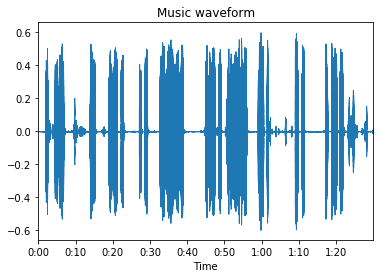

In [89]:
# # 绘图显示
# import librosa.display
# import matplotlib.pyplot as plt

# audioName = "./input/00415250.wav"
# y, sr = librosa.load(audioName)
# beat_frames = librosa.feature.delta(beat_frames,mode ='nearest')
#     x = array(beat_frames).reshape(-1, 1)
# print(y)
# # 绘制声音波形
# plt.figure()
# librosa.display.waveplot(y, sr)
# plt.title('Music waveform')
# plt.show()

In [13]:
audioName = "./input/00415250.wav"
y, sr = librosa.load(audioName, sr=None)
# tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
# beat_frames = librosa.feature.delta(beat_frames)
# x = array(beat_frames).reshape(-1, 1)

f1 = librosa.feature.mfcc(y=y, sr=sr)

In [14]:
f1

array([[-5.6671179e+02, -5.6671179e+02, -5.6671179e+02, ...,
        -4.5843448e+02, -4.9652750e+02, -5.3048840e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.7363564e+01,  4.6757931e+01,  4.1016754e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.4665920e+01, -3.6458092e+00,  1.9531054e+01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.4816517e+01, -1.2844425e+01, -7.4394493e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.0713158e+00, -1.2559330e+01,  5.4400861e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.7620926e+01,  8.2181101e+00,  1.3924236e+01]], dtype=float32)

In [15]:
print(np.size(f1, 0), np.size(f1, 1))

20 1407


In [34]:
f1t = f1.T

In [35]:
print(np.size(f1t, 0), np.size(f1t, 1))

1407 20


In [16]:
len(y)

719999

In [43]:
audioName = "./input/end_of_time_slice.wav"
y2, sr2 = librosa.load(audioName, sr=None)
# tempo, beat_frames = librosa.beat.beat_track(y=y2, sr=sr2)
#beat_frames = librosa.feature.delta(beat_frames)
#x = array(beat_frames).reshape(-1, 1)

f2 = librosa.feature.mfcc(y=y2, sr=sr2)

In [44]:
print(np.size(f2, 0), np.size(f2, 1))

20 79


In [45]:
len(y2)

40000

In [46]:
a1 = f1.T
lenx = len(a1)
a2 = f2.T
leny = len(a2)

In [47]:
print(lenx, leny)

1407 79


In [48]:
sliX = a1[0 : leny]

In [52]:
a1[1]

array([-566.7118,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ], dtype=float32)

In [53]:
a2[1]

array([-602.6831,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ], dtype=float32)

In [68]:
dist = 0
for i in range(0, leny):
    p1 = preprocessing.minmax_scale(a1[i])
    p2 = preprocessing.minmax_scale(a2[i])
    d = dtw(p1, p2, distance_only=False).distance
    print(d)
    dist += d

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0071288347244262695
0.23264092206954956
0.41125988960266113
0.10577374696731567
0.0
0.0
0.0
0.0
0.038480281829833984
0.020449578762054443
0.0015406608581542969
0.001482546329498291
0.0968819260597229
0.12103652954101562
0.08367323875427246
0.07975894212722778
0.08383524417877197
0.14488422870635986
0.08551007509231567
0.08532774448394775
0.08111917972564697
0.22569948434829712
0.3745614290237427
0.1606413722038269
0.0
0.0
0.0
0.0
0.0
0.25536978244781494
0.1182674765586853
0.09413367509841919
0.09635186195373535
0.09370601177215576
0.13565117120742798
0.16138821840286255
0.1971641182899475
0.2711978554725647
0.10506898164749146
0.09143346548080444
0.09230059385299683
0.08692926168441772
0.06088799238204956
0.008327007293701172
0.12251394987106323
0.10967350006103516
0.2840973138809204
0.15467149019241333
0.11644881963729858
0.12958312034606934
0.14394307136535645
1.7199999690055847


In [160]:
for i in range(0, 30000):
    if (y[i] != y2[i]):
        print(i,":", y[i] - y2[i])

0 : -1.5258789e-05
7 : 1.5258789e-05
8 : 1.5258789e-05
13 : -1.5258789e-05
14 : -3.0517578e-05
15 : -3.0517578e-05
16 : -3.0517578e-05
17 : -1.5258789e-05
18 : -1.5258789e-05
19 : -1.5258789e-05
20 : -1.5258789e-05
21 : -1.5258789e-05
22 : -1.5258789e-05
24 : -1.5258789e-05
25 : -1.5258789e-05
26 : -1.5258789e-05
28 : -1.5258789e-05
29 : -1.5258789e-05
37 : -1.5258789e-05
38 : -1.5258789e-05
39 : -1.5258789e-05
40 : -1.5258789e-05
41 : -1.5258789e-05
42 : -1.5258789e-05
45 : 1.5258789e-05
46 : 3.0517578e-05
47 : 4.5776367e-05
48 : 6.1035156e-05
49 : 6.1035156e-05
50 : 1.5258789e-05
51 : 7.6293945e-05
52 : -1.5258789e-05
53 : 1.5258789e-05
54 : -3.0517578e-05
55 : -4.5776367e-05
56 : -6.1035156e-05
57 : -6.1035156e-05
58 : -6.1035156e-05
59 : -9.1552734e-05
60 : -4.5776367e-05
61 : -3.0517578e-05
62 : -1.5258789e-05
63 : -1.5258789e-05
65 : 4.5776367e-05
66 : 1.5258789e-05
67 : 6.1035156e-05
68 : 4.5776367e-05
69 : 6.1035156e-05
70 : 7.6293945e-05
71 : 4.5776367e-05
72 : 7.6293945e-05
7

1302 : 6.1035156e-05
1303 : 0.00012207031
1304 : 0.00016784668
1305 : 0.00015258789
1306 : 0.00012207031
1307 : 0.00015258789
1308 : 0.0001373291
1309 : 0.00010681152
1310 : 7.6293945e-05
1312 : -4.5776367e-05
1313 : -0.00012207031
1314 : -0.00012207031
1315 : -0.0001373291
1316 : -0.0001373291
1317 : -0.0001373291
1318 : -7.6293945e-05
1319 : -1.5258789e-05
1320 : 1.5258789e-05
1321 : 0.0001373291
1322 : 0.00012207031
1323 : 7.6293945e-05
1324 : 0.00010681152
1325 : 6.1035156e-05
1326 : -1.5258789e-05
1327 : -7.6293945e-05
1328 : -0.00012207031
1329 : -0.00016784668
1330 : -0.0001373291
1331 : -0.00016784668
1332 : -0.00010681152
1333 : 1.5258789e-05
1334 : 3.0517578e-05
1335 : 7.6293945e-05
1336 : 7.6293945e-05
1337 : 0.00015258789
1338 : 0.00012207031
1339 : 4.5776367e-05
1341 : -4.5776367e-05
1342 : -0.0001373291
1343 : -0.00015258789
1344 : -0.00012207031
1345 : -0.0001373291
1346 : -9.1552734e-05
1347 : -1.5258789e-05
1348 : 4.5776367e-05
1349 : 0.00012207031
1350 : 0.00016784668

2564 : 0.00015258789
2565 : 4.5776367e-05
2566 : -1.5258789e-05
2567 : -4.5776367e-05
2568 : -0.00015258789
2569 : -0.0001373291
2570 : -0.00016784668
2571 : -0.00012207031
2572 : -0.00012207031
2574 : 3.0517578e-05
2575 : 3.0517578e-05
2576 : 4.5776367e-05
2579 : -6.1035156e-05
2580 : -6.1035156e-05
2581 : -9.1552734e-05
2582 : -0.00010681152
2583 : -9.1552734e-05
2584 : -0.00010681152
2585 : -3.0517578e-05
2586 : 3.0517578e-05
2587 : 6.1035156e-05
2588 : 0.00010681152
2589 : 0.0001373291
2590 : 0.00016784668
2591 : 0.00012207031
2592 : 7.6293945e-05
2593 : 7.6293945e-05
2594 : 3.0517578e-05
2595 : 1.5258789e-05
2596 : 1.5258789e-05
2597 : -1.5258789e-05
2598 : 6.1035156e-05
2601 : 4.5776367e-05
2602 : -1.5258789e-05
2603 : -3.0517578e-05
2604 : -7.6293945e-05
2605 : -0.00010681152
2606 : -0.0001373291
2607 : -9.1552734e-05
2608 : -6.1035156e-05
2610 : 4.5776367e-05
2611 : 0.00010681152
2612 : 0.0001373291
2613 : 0.00012207031
2614 : 0.00010681152
2615 : 3.0517578e-05
2616 : 4.5776367

3984 : 0.00076293945
3985 : 0.0008087158
3986 : 0.00079345703
3987 : 0.00074768066
3988 : 0.00064086914
3989 : 0.0005645752
3990 : 0.00036621094
3991 : 0.00019836426
3993 : -0.00018310547
3994 : -0.00032043457
3995 : -0.0004272461
3996 : -0.00048828125
3997 : -0.00047302246
3998 : -0.0004272461
3999 : -0.0004119873
4000 : -0.0002746582
4001 : -0.00015258789
4002 : -9.1552734e-05
4003 : -4.5776367e-05
4006 : -1.5258789e-05
4007 : -3.0517578e-05
4008 : -3.0517578e-05
4009 : -6.1035156e-05
4010 : -6.1035156e-05
4011 : -6.1035156e-05
4013 : 4.5776367e-05
4014 : 0.00012207031
4015 : 0.00015258789
4016 : 0.00012207031
4017 : 0.00012207031
4018 : 0.00012207031
4019 : 9.1552734e-05
4020 : -1.5258789e-05
4022 : -4.5776367e-05
4023 : -0.00010681152
4024 : -6.1035156e-05
4025 : -6.1035156e-05
4026 : -3.0517578e-05
4027 : 7.6293945e-05
4028 : 0.00015258789
4029 : 0.00022888184
4030 : 0.00035095215
4031 : 0.00044250488
4032 : 0.00045776367
4033 : 0.00050354004
4034 : 0.00050354004
4035 : 0.00051879

5328 : 0.0030059814
5329 : 0.003112793
5330 : 0.0031738281
5331 : 0.003326416
5332 : 0.00340271
5333 : 0.0035095215
5334 : 0.0036468506
5335 : 0.0037231445
5336 : 0.0038604736
5337 : 0.0039520264
5338 : 0.0040130615
5339 : 0.0041046143
5340 : 0.0040893555
5341 : 0.0040283203
5342 : 0.0040283203
5343 : 0.0038452148
5344 : 0.0036468506
5345 : 0.0034332275
5346 : 0.0030822754
5347 : 0.0027008057
5348 : 0.0022583008
5349 : 0.0017700195
5350 : 0.0012359619
5351 : 0.0006713867
5352 : 7.6293945e-05
5353 : -0.0005340576
5354 : -0.0011444092
5355 : -0.0017547607
5356 : -0.0023345947
5357 : -0.00289917
5358 : -0.00340271
5359 : -0.0038909912
5360 : -0.0043182373
5361 : -0.0046691895
5362 : -0.0049591064
5363 : -0.0051727295
5364 : -0.0053253174
5365 : -0.0054016113
5366 : -0.00541687
5367 : -0.005355835
5368 : -0.0052337646
5369 : -0.005065918
5370 : -0.004852295
5371 : -0.0046081543
5372 : -0.004272461
5373 : -0.003921509
5374 : -0.0035552979
5375 : -0.003112793
5376 : -0.0027313232
5377 : -0.0

6829 : -0.020126343
6830 : -0.018310547
6831 : -0.016235352
6832 : -0.013946533
6833 : -0.011581421
6834 : -0.009124756
6835 : -0.006866455
6836 : -0.0045776367
6837 : -0.0026245117
6838 : -0.00093078613
6839 : 0.0005493164
6840 : 0.0018005371
6841 : 0.002609253
6842 : 0.0032806396
6843 : 0.0036315918
6844 : 0.0036468506
6845 : 0.0036773682
6846 : 0.0034484863
6847 : 0.0030517578
6848 : 0.0026855469
6849 : 0.002090454
6850 : 0.0015563965
6851 : 0.0010986328
6852 : 0.00065612793
6853 : 0.00045776367
6854 : 0.00030517578
6855 : 0.00035095215
6856 : 0.0007324219
6857 : 0.0012969971
6858 : 0.0020599365
6859 : 0.003112793
6860 : 0.0043182373
6861 : 0.0056915283
6862 : 0.0071258545
6863 : 0.008621216
6864 : 0.010070801
6865 : 0.011459351
6866 : 0.012664795
6867 : 0.013641357
6868 : 0.014419556
6869 : 0.014892578
6870 : 0.015151978
6871 : 0.014968872
6872 : 0.014541626
6873 : 0.013809204
6874 : 0.012771606
6875 : 0.011383057
6876 : 0.009735107
6877 : 0.0078125
6878 : 0.0056152344
6879 : 0.003

8162 : 0.04283142
8163 : 0.034454346
8164 : 0.025360107
8165 : 0.015411377
8166 : 0.004928589
8167 : -0.0056610107
8168 : -0.016235352
8169 : -0.026351929
8170 : -0.03553772
8171 : -0.0438385
8172 : -0.051101685
8173 : -0.05709839
8174 : -0.062072754
8175 : -0.06588745
8176 : -0.06877136
8177 : -0.07054138
8178 : -0.071136475
8179 : -0.070739746
8180 : -0.069000244
8181 : -0.06616211
8182 : -0.06225586
8183 : -0.057281494
8184 : -0.051452637
8185 : -0.045059204
8186 : -0.038223267
8187 : -0.03111267
8188 : -0.024032593
8189 : -0.016967773
8190 : -0.010070801
8191 : -0.0033416748
8192 : 0.003326416
8193 : 0.009811401
8194 : 0.016021729
8195 : 0.022201538
8196 : 0.027801514
8197 : 0.03303528
8198 : 0.037582397
8199 : 0.041427612
8200 : 0.044448853
8201 : 0.046585083
8202 : 0.04789734
8203 : 0.048324585
8204 : 0.04827881
8205 : 0.04763794
8206 : 0.0466156
8207 : 0.045196533
8208 : 0.043548584
8209 : 0.041534424
8210 : 0.03919983
8211 : 0.036590576
8212 : 0.033615112
8213 : 0.03036499
8214

9598 : 0.021713257
9599 : 0.02557373
9600 : 0.029632568
9601 : 0.03404236
9602 : 0.03878784
9603 : 0.043945312
9604 : 0.0496521
9605 : 0.055862427
9606 : 0.06265259
9607 : 0.069747925
9608 : 0.07698059
9609 : 0.08451843
9610 : 0.09188843
9611 : 0.09893799
9612 : 0.10551453
9613 : 0.11123657
9614 : 0.11592102
9615 : 0.11924744
9616 : 0.120895386
9617 : 0.1207428
9618 : 0.11854553
9619 : 0.114227295
9620 : 0.10746765
9621 : 0.098526
9622 : 0.087509155
9623 : 0.07461548
9624 : 0.06021118
9625 : 0.044387817
9626 : 0.02758789
9627 : 0.010299683
9628 : -0.0073547363
9629 : -0.025131226
9630 : -0.042526245
9631 : -0.05958557
9632 : -0.07608032
9633 : -0.09162903
9634 : -0.10618591
9635 : -0.11959839
9636 : -0.1315155
9637 : -0.14199829
9638 : -0.15054321
9639 : -0.15699768
9640 : -0.16134644
9641 : -0.16329956
9642 : -0.16314697
9643 : -0.16070557
9644 : -0.15653992
9645 : -0.15081787
9646 : -0.14334106
9647 : -0.13468933
9648 : -0.12503052
9649 : -0.11451721
9650 : -0.10310364
9651 : -0.0907

10995 : -0.113723755
10996 : -0.090545654
10997 : -0.06486511
10998 : -0.037200928
10999 : -0.007949829
11000 : 0.022277832
11001 : 0.05290222
11002 : 0.08328247
11003 : 0.11286926
11004 : 0.14105225
11005 : 0.1676178
11006 : 0.19204712
11007 : 0.21414185
11008 : 0.23365784
11009 : 0.25024414
11010 : 0.26367188
11011 : 0.2735901
11012 : 0.27989197
11013 : 0.2823639
11014 : 0.28097534
11015 : 0.27593994
11016 : 0.26748657
11017 : 0.256073
11018 : 0.24215698
11019 : 0.22608948
11020 : 0.20843506
11021 : 0.1894226
11022 : 0.16918945
11023 : 0.14781189
11024 : 0.12548828
11025 : 0.10221863
11026 : 0.07815552
11027 : 0.053710938
11028 : 0.02923584
11029 : 0.005279541
11030 : -0.017562866
11031 : -0.03894043
11032 : -0.05822754
11033 : -0.07531738
11034 : -0.0900116
11035 : -0.10244751
11036 : -0.11294556
11037 : -0.12161255
11038 : -0.12869263
11039 : -0.13449097
11040 : -0.13899231
11041 : -0.14204407
11042 : -0.14376831
11043 : -0.14372253
11044 : -0.14187622
11045 : -0.1381073
11046 : -0

12411 : -4.5776367e-05
12412 : -0.00015258789
12413 : -0.0002746582
12414 : -0.00035095215
12415 : -0.00048828125
12416 : -0.0004119873
12417 : -0.00030517578
12418 : -0.00019836426
12419 : -6.1035156e-05
12420 : -0.00012207031
12421 : -0.0001373291
12422 : -0.00036621094
12423 : -0.00076293945
12424 : -0.0012817383
12425 : -0.0018463135
12426 : -0.002319336
12427 : -0.0027313232
12428 : -0.0028381348
12429 : -0.0027923584
12430 : -0.0024414062
12431 : -0.0018005371
12432 : -0.0010528564
12433 : -0.00022888184
12434 : 0.0005645752
12435 : 0.0012359619
12436 : 0.001663208
12437 : 0.0017242432
12438 : 0.001739502
12439 : 0.0014801025
12440 : 0.0010681152
12441 : 0.0008239746
12442 : 0.00062561035
12443 : 0.00064086914
12444 : 0.0008392334
12445 : 0.0011444092
12446 : 0.0014801025
12447 : 0.0018615723
12448 : 0.0021820068
12449 : 0.0022277832
12450 : 0.0022277832
12451 : 0.0020141602
12452 : 0.0017547607
12453 : 0.001373291
12454 : 0.0009460449
12455 : 0.0006713867
12456 : 0.00033569336
1

13816 : -0.009475708
13817 : -0.0061035156
13818 : -0.0030670166
13819 : 6.1035156e-05
13820 : 0.0031585693
13821 : 0.005569458
13822 : 0.008224487
13823 : 0.010635376
13824 : 0.012283325
13825 : 0.013656616
13826 : 0.014526367
13827 : 0.01449585
13828 : 0.0137786865
13829 : 0.012817383
13830 : 0.010635376
13831 : 0.008651733
13832 : 0.006088257
13833 : 0.0036621094
13834 : 0.0015106201
13835 : -0.0007171631
13836 : -0.0020599365
13837 : -0.0033721924
13838 : -0.003479004
13839 : -0.004425049
13840 : -0.0041046143
13841 : -0.003479004
13842 : -0.0036468506
13843 : -0.0025482178
13844 : -0.0020599365
13845 : -0.0011749268
13846 : 0.00015258789
13847 : 0.0015106201
13848 : 0.002609253
13849 : 0.005050659
13850 : 0.0070495605
13851 : 0.008468628
13852 : 0.010925293
13853 : 0.0126953125
13854 : 0.01399231
13855 : 0.014556885
13856 : 0.015106201
13857 : 0.014709473
13858 : 0.013381958
13859 : 0.011734009
13860 : 0.009216309
13861 : 0.0066833496
13862 : 0.0034179688
13863 : -0.00038146973
13

15188 : 0.008743286
15189 : -0.029556274
15190 : -0.049682617
15191 : -0.05769348
15192 : -0.058654785
15193 : -0.061813354
15194 : -0.060943604
15195 : -0.048187256
15196 : -0.0181427
15197 : 0.005203247
15198 : 0.008972168
15199 : -0.006881714
15200 : -0.034439087
15201 : -0.050094604
15202 : -0.057510376
15203 : -0.04437256
15204 : -0.019836426
15205 : 0.0054626465
15206 : 0.02520752
15207 : 0.027938843
15208 : 0.01927185
15209 : 0.018341064
15210 : 0.047790527
15211 : 0.095962524
15212 : 0.10467529
15213 : 0.023086548
15214 : -0.11393738
15215 : -0.21542358
15216 : -0.20204163
15217 : -0.0639801
15218 : 0.090789795
15219 : 0.15335083
15220 : 0.10057068
15221 : -0.021499634
15222 : -0.105270386
15223 : -0.109191895
15224 : -0.079193115
15225 : -0.07322693
15226 : -0.126297
15227 : -0.18972778
15228 : -0.20533752
15229 : -0.1374054
15230 : -0.029846191
15231 : 0.04336548
15232 : 0.049987793
15233 : 0.0019378662
15234 : -0.04534912
15235 : -0.057662964
15236 : -0.028381348
15237 : 0.0

16688 : 0.06568909
16689 : 0.06060791
16690 : 0.04258728
16691 : 0.064575195
16692 : 0.09466553
16693 : 0.13542175
16694 : 0.14715576
16695 : 0.04084778
16696 : -0.08355713
16697 : -0.12788391
16698 : -0.08078003
16699 : 0.06813049
16700 : 0.21714783
16701 : 0.25776672
16702 : 0.21890259
16703 : 0.14483643
16704 : 0.08325195
16705 : 0.08631897
16706 : 0.11550903
16707 : 0.11186218
16708 : 0.090286255
16709 : 0.06896973
16710 : 0.11566162
16711 : 0.23370361
16712 : 0.31625366
16713 : 0.31655884
16714 : 0.21987915
16715 : 0.08229065
16716 : -0.00869751
16717 : -0.014465332
16718 : 0.024353027
16719 : 0.063430786
16720 : 0.06690979
16721 : 0.018478394
16722 : -0.028823853
16723 : -0.048614502
16724 : -0.05218506
16725 : -0.05117798
16726 : -0.07827759
16727 : -0.22261047
16728 : -0.3795166
16729 : -0.43836975
16730 : -0.4043579
16731 : -0.25297546
16732 : -0.11260986
16733 : -0.0778656
16734 : -0.12416077
16735 : -0.20227051
16736 : -0.26020813
16737 : -0.2500763
16738 : -0.21151733
16739

18188 : 0.124938965
18189 : 0.24281311
18190 : 0.39056396
18191 : 0.45721436
18192 : 0.21766663
18193 : -0.000579834
18194 : 0.12045288
18195 : 0.22164917
18196 : -0.014541626
18197 : -0.24588013
18198 : -0.17330933
18199 : 0.010879517
18200 : 0.030014038
18201 : -0.14736938
18202 : -0.27947998
18203 : -0.23527527
18204 : -0.17166138
18205 : -0.27085876
18206 : -0.41178894
18207 : -0.4088745
18208 : -0.29766846
18209 : -0.19691467
18210 : -0.1842041
18211 : -0.1430664
18212 : -0.015731812
18213 : 0.05744934
18214 : -0.011123657
18215 : 0.07443237
18216 : 0.24484253
18217 : -0.04020691
18218 : -0.3604889
18219 : -0.15908813
18220 : 0.051101685
18221 : -0.14021301
18222 : -0.2743988
18223 : -0.15127563
18224 : -0.008911133
18225 : 0.16769409
18226 : 0.1929779
18227 : -0.072402954
18228 : -0.17280579
18229 : 0.110198975
18230 : 0.18920898
18231 : -0.12652588
18232 : -0.29034424
18233 : -0.08602905
18234 : 0.15969849
18235 : 0.15135193
18236 : -0.035858154
18237 : -0.11743164
18238 : 0.052

19688 : -0.040649414
19689 : -0.07847595
19690 : -0.111846924
19691 : -0.14302063
19692 : -0.17427063
19693 : -0.19779968
19694 : -0.21876526
19695 : -0.24261475
19696 : -0.25408936
19697 : -0.26991272
19698 : -0.28056335
19699 : -0.28735352
19700 : -0.29533386
19701 : -0.29885864
19702 : -0.29989624
19703 : -0.29615784
19704 : -0.2934723
19705 : -0.28204346
19706 : -0.27127075
19707 : -0.2550354
19708 : -0.23280334
19709 : -0.20994568
19710 : -0.18232727
19711 : -0.15185547
19712 : -0.121917725
19713 : -0.0892334
19714 : -0.055221558
19715 : -0.02696228
19716 : 0.006958008
19717 : 0.035003662
19718 : 0.062683105
19719 : 0.08958435
19720 : 0.11619568
19721 : 0.14338684
19722 : 0.16362
19723 : 0.18916321
19724 : 0.21096802
19725 : 0.23051453
19726 : 0.24681091
19727 : 0.26524353
19728 : 0.27764893
19729 : 0.28260803
19730 : 0.2878723
19731 : 0.28512573
19732 : 0.2780609
19733 : 0.26235962
19734 : 0.24481201
19735 : 0.22027588
19736 : 0.18913269
19737 : 0.15715027
19738 : 0.12133789
1973

21187 : -0.13293457
21188 : -0.13102722
21189 : -0.13215637
21190 : -0.13700867
21191 : -0.1446228
21192 : -0.15657043
21193 : -0.16824341
21194 : -0.18234253
21195 : -0.1927185
21196 : -0.20043945
21197 : -0.20326233
21198 : -0.19950867
21199 : -0.18937683
21200 : -0.17390442
21201 : -0.15444946
21202 : -0.12768555
21203 : -0.10092163
21204 : -0.073654175
21205 : -0.04359436
21206 : -0.016784668
21207 : 0.006072998
21208 : 0.030731201
21209 : 0.04966736
21210 : 0.06428528
21211 : 0.0811615
21212 : 0.09327698
21213 : 0.103775024
21214 : 0.11651611
21215 : 0.12780762
21216 : 0.13760376
21217 : 0.15124512
21218 : 0.16300964
21219 : 0.17092896
21220 : 0.18035889
21221 : 0.18582153
21222 : 0.18577576
21223 : 0.18003845
21224 : 0.17208862
21225 : 0.15582275
21226 : 0.13375854
21227 : 0.110824585
21228 : 0.08117676
21229 : 0.05142212
21230 : 0.02104187
21231 : -0.009094238
21232 : -0.03642273
21233 : -0.060699463
21234 : -0.08383179
21235 : -0.100982666
21236 : -0.11628723
21237 : -0.1298217

22687 : -0.35136414
22688 : -0.3462677
22689 : -0.32040405
22690 : -0.28367615
22691 : -0.22814941
22692 : -0.16267395
22693 : -0.09489441
22694 : -0.030975342
22695 : 0.035354614
22696 : 0.10118103
22697 : 0.15588379
22698 : 0.20133972
22699 : 0.23320007
22700 : 0.2581787
22701 : 0.27397156
22702 : 0.30491638
22703 : 0.2684784
22704 : 0.22680664
22705 : 0.22215271
22706 : 0.15794373
22707 : 0.11885071
22708 : 0.07130432
22709 : 0.0049743652
22710 : -0.026351929
22711 : -0.042099
22712 : -0.049346924
22713 : -0.06913757
22714 : -0.055770874
22715 : -0.039627075
22716 : -0.015090942
22717 : 0.015396118
22718 : 0.020874023
22719 : 0.027755737
22720 : 0.03164673
22721 : 0.050247192
22722 : 0.04585266
22723 : 0.03526306
22724 : 0.035614014
22725 : 0.037582397
22726 : 0.05003357
22727 : 0.064453125
22728 : 0.071258545
22729 : 0.07046509
22730 : 0.084487915
22731 : 0.08648682
22732 : 0.07562256
22733 : 0.05621338
22734 : 0.019470215
22735 : -0.02406311
22736 : -0.06788635
22737 : -0.12200928

24187 : -0.028549194
24188 : -0.06956482
24189 : -0.096069336
24190 : -0.107406616
24191 : -0.10115051
24192 : -0.07800293
24193 : -0.04133606
24194 : 0.0068206787
24195 : 0.061676025
24196 : 0.11779785
24197 : 0.17105103
24198 : 0.21636963
24199 : 0.2508545
24200 : 0.27197266
24201 : 0.27864075
24202 : 0.27053833
24203 : 0.2489624
24204 : 0.21746826
24205 : 0.17887878
24206 : 0.13793945
24207 : 0.09713745
24208 : 0.057891846
24209 : 0.024612427
24210 : -0.0031738281
24211 : -0.02609253
24212 : -0.044189453
24213 : -0.059188843
24214 : -0.073349
24215 : -0.08792114
24216 : -0.103027344
24217 : -0.1197052
24218 : -0.13664246
24219 : -0.15390015
24220 : -0.16781616
24221 : -0.17634583
24222 : -0.17974854
24223 : -0.1749115
24224 : -0.16142273
24225 : -0.13934326
24226 : -0.11053467
24227 : -0.07644653
24228 : -0.03955078
24229 : -0.003616333
24230 : 0.029022217
24231 : 0.055892944
24232 : 0.072769165
24233 : 0.07853699
24234 : 0.07321167
24235 : 0.054534912
24236 : 0.025527954
24237 : -0

25588 : -0.018234253
25589 : -0.022766113
25590 : -0.02670288
25591 : -0.029541016
25592 : -0.030960083
25593 : -0.031311035
25594 : -0.031188965
25595 : -0.031326294
25596 : -0.030975342
25597 : -0.031036377
25598 : -0.03173828
25599 : -0.033096313
25600 : -0.034744263
25601 : -0.037490845
25602 : -0.04034424
25603 : -0.043380737
25604 : -0.045715332
25605 : -0.047836304
25606 : -0.048675537
25607 : -0.048355103
25608 : -0.046218872
25609 : -0.043655396
25610 : -0.03994751
25611 : -0.03453064
25612 : -0.027633667
25613 : -0.020248413
25614 : -0.013076782
25615 : -0.0050354004
25616 : 0.0031280518
25617 : 0.011489868
25618 : 0.01928711
25619 : 0.026977539
25620 : 0.034225464
25621 : 0.041152954
25622 : 0.047973633
25623 : 0.05482483
25624 : 0.061706543
25625 : 0.06858826
25626 : 0.07571411
25627 : 0.083358765
25628 : 0.09062195
25629 : 0.0975647
25630 : 0.10446167
25631 : 0.110687256
25632 : 0.11581421
25633 : 0.11941528
25634 : 0.12161255
25635 : 0.12226868
25636 : 0.12197876
25637 : 

26930 : 0.057266235
26931 : 0.04763794
26932 : 0.03729248
26933 : 0.026184082
26934 : 0.014312744
26935 : 0.001953125
26936 : -0.010848999
26937 : -0.023803711
26938 : -0.036575317
26939 : -0.049057007
26940 : -0.060791016
26941 : -0.07159424
26942 : -0.081222534
26943 : -0.0894928
26944 : -0.09629822
26945 : -0.10154724
26946 : -0.105392456
26947 : -0.107910156
26948 : -0.10960388
26949 : -0.110580444
26950 : -0.11125183
26951 : -0.11178589
26952 : -0.11239624
26953 : -0.11305237
26954 : -0.11387634
26955 : -0.1146698
26956 : -0.11532593
26957 : -0.11576843
26958 : -0.11552429
26959 : -0.11468506
26960 : -0.11315918
26961 : -0.11064148
26962 : -0.10723877
26963 : -0.10273743
26964 : -0.097091675
26965 : -0.09037781
26966 : -0.08256531
26967 : -0.07357788
26968 : -0.06349182
26969 : -0.052627563
26970 : -0.040863037
26971 : -0.028747559
26972 : -0.016403198
26973 : -0.0040893555
26974 : 0.007949829
26975 : 0.019454956
26976 : 0.030471802
26977 : 0.040786743
26978 : 0.05026245
26979 : 0

28339 : -0.0552063
28340 : -0.05873108
28341 : -0.061935425
28342 : -0.064712524
28343 : -0.0667572
28344 : -0.06796265
28345 : -0.06820679
28346 : -0.06756592
28347 : -0.06602478
28348 : -0.06375122
28349 : -0.061065674
28350 : -0.057998657
28351 : -0.054992676
28352 : -0.052093506
28353 : -0.04966736
28354 : -0.047927856
28355 : -0.04689026
28356 : -0.046524048
28357 : -0.046936035
28358 : -0.047851562
28359 : -0.04902649
28360 : -0.05026245
28361 : -0.051254272
28362 : -0.051651
28363 : -0.051437378
28364 : -0.050445557
28365 : -0.048828125
28366 : -0.0466156
28367 : -0.043945312
28368 : -0.041229248
28369 : -0.03845215
28370 : -0.035964966
28371 : -0.03364563
28372 : -0.03164673
28373 : -0.029571533
28374 : -0.027359009
28375 : -0.024719238
28376 : -0.021560669
28377 : -0.0178833
28378 : -0.0137786865
28379 : -0.009811401
28380 : -0.006576538
28381 : -0.0048065186
28382 : -0.005279541
28383 : -0.008758545
28384 : -0.01576233
28385 : -0.026489258
28386 : -0.040496826
28387 : -0.0570

29687 : -0.0061798096
29688 : -0.0038146973
29689 : 0.0019683838
29690 : 0.0066070557
29691 : 0.012359619
29692 : 0.019592285
29693 : 0.02243042
29694 : 0.027572632
29695 : 0.028030396
29696 : 0.028961182
29697 : 0.026763916
29698 : 0.02330017
29699 : 0.025772095
29700 : 0.023925781
29701 : 0.028671265
29702 : 0.03387451
29703 : 0.039474487
29704 : 0.050933838
29705 : 0.07026672
29706 : 0.07249451
29707 : 0.061401367
29708 : 0.06472778
29709 : 0.0572052
29710 : 0.04093933
29711 : 0.03327942
29712 : 0.020217896
29713 : 0.006134033
29714 : 0.014053345
29715 : 0.02229309
29716 : 0.027496338
29717 : 0.039794922
29718 : 0.050476074
29719 : 0.061965942
29720 : 0.067733765
29721 : 0.07168579
29722 : 0.065704346
29723 : 0.054718018
29724 : 0.049240112
29725 : 0.037368774
29726 : 0.028823853
29727 : 0.021728516
29728 : 0.015411377
29729 : 0.014434814
29730 : 0.012893677
29731 : 0.016052246
29732 : 0.017730713
29733 : 0.018371582
29734 : 0.021865845
29735 : 0.022415161
29736 : 0.02432251
29737 :

In [110]:
beat_frames

array([17.5       , 17.5       , 17.5       , 17.5       , 17.5       ,
       17.28333333, 17.03333333, 17.03333333, 17.03333333, 17.03333333,
       17.03333333])

In [110]:
import utils.corpus as VCP

corpus_path = './corpus' # 语料库路径
dbPath = './beatDatabase.npy' # 数据表路径

vComp = VCP.voiceComparator(corpus_path, dbPath)

testPath = './input/31秒处.wav'
vComp.voiceCompare(testPath)

最接近的录音是： ./corpus\00426687.wav


'./corpus\\00426687.wav'

In [55]:
tPath = './input/00415250-前5s.wav'
# 读入要识别的录音
y, sr = librosa.load(tPath)

# 识别录音的节奏序列
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_frames = librosa.feature.delta(beat_frames,mode ='nearest')
x = array(beat_frames).reshape(-1, 1)

lenx = len(x)

In [56]:
type(x)

numpy.ndarray

In [101]:
px = preprocessing.minmax_scale(x)

In [93]:
x

array([[ 8.83333333],
       [11.83333333],
       [14.55      ],
       [16.55      ],
       [17.5       ],
       [17.28333333],
       [17.03333333],
       [15.7       ],
       [13.58333333],
       [10.98333333],
       [ 8.2       ]])